##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

2022-12-14 13:38:21.991446: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 13:38:21.991557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 13:38:21.991567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"As a huge fan of horror films, especially J-horror and also gore i thought Nekeddo bur\xc3\xa2ddo sounded pretty good. I researched the plot, read reviews, and even looked at some photos to make sure it seemed like a good gory and scary movie to watch before downloading it. So excited it had finished and ready to be scared and recoiling in horror at the amazing gore i was expecting i was terribly disappointed. The plot was ridiculous and didn't even make sense and left too much unexplained, the gore was hilarious rather then horrifying, and what was with the cartoon style sound effects ? The acting was probably the only thing mildly scary about it. I did not understand the cactus idea and the way the mothers husband disappeared in the middle of the sea after following a flashing light, they left both pretty unexplained, or perhaps i missed it as my mind couldn't understand what i was actually seeing. I appreciate the way it was supposed to be; shocking and a few scenes (the 

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 15,   4, 629, ...,   0,   0,   0],
       [ 49, 557,  51, ...,   0,   0,   0],
       [  1,   7,   4, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"As a huge fan of horror films, especially J-horror and also gore i thought Nekeddo bur\xc3\xa2ddo sounded pretty good. I researched the plot, read reviews, and even looked at some photos to make sure it seemed like a good gory and scary movie to watch before downloading it. So excited it had finished and ready to be scared and recoiling in horror at the amazing gore i was expecting i was terribly disappointed. The plot was ridiculous and didn't even make sense and left too much unexplained, the gore was hilarious rather then horrifying, and what was with the cartoon style sound effects ? The acting was probably the only thing mildly scary about it. I did not understand the cactus idea and the way the mothers husband disappeared in the middle of the sea after following a flashing light, they left both pretty unexplained, or perhaps i missed it as my mind couldn't understand what i was actually seeing. I appreciate the way it was supposed to be; shocking and a few scenes (th

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 3s 3s/step


[-0.00252648]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 60ms/step


[-0.00252648]


Compile the Keras model to configure the training process:

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


2022-12-14 13:38:42.916496: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'


  1/391 [..............................] - ETA: 53:54 - loss: 0.6931 - accuracy: 0.6250

  2/391 [..............................] - ETA: 1:16 - loss: 0.6931 - accuracy: 0.5703 

  3/391 [..............................] - ETA: 49s - loss: 0.6931 - accuracy: 0.5469 

  4/391 [..............................] - ETA: 1:00 - loss: 0.6934 - accuracy: 0.5117

  5/391 [..............................] - ETA: 1:05 - loss: 0.6932 - accuracy: 0.5250

  6/391 [..............................] - ETA: 1:09 - loss: 0.6934 - accuracy: 0.5078

  7/391 [..............................] - ETA: 1:10 - loss: 0.6933 - accuracy: 0.5067

  8/391 [..............................] - ETA: 1:11 - loss: 0.6934 - accuracy: 0.5000

  9/391 [..............................] - ETA: 1:11 - loss: 0.6933 - accuracy: 0.5017

 10/391 [..............................] - ETA: 1:12 - loss: 0.6934 - accuracy: 0.4984

 11/391 [..............................] - ETA: 1:07 - loss: 0.6933 - accuracy: 0.4957

 12/391 [..............................] - ETA: 1:07 - loss: 0.6932 - accuracy: 0.5000

 13/391 [..............................] - ETA: 1:08 - loss: 0.6932 - accuracy: 0.4952

 14/391 [>.............................] - ETA: 1:08 - loss: 0.6932 - accuracy: 0.4967

 15/391 [>.............................] - ETA: 1:09 - loss: 0.6933 - accuracy: 0.4917

 16/391 [>.............................] - ETA: 1:09 - loss: 0.6932 - accuracy: 0.5000

 17/391 [>.............................] - ETA: 1:09 - loss: 0.6932 - accuracy: 0.4982

 18/391 [>.............................] - ETA: 1:09 - loss: 0.6932 - accuracy: 0.4965

 19/391 [>.............................] - ETA: 1:09 - loss: 0.6931 - accuracy: 0.4984

 20/391 [>.............................] - ETA: 1:10 - loss: 0.6931 - accuracy: 0.4977

 21/391 [>.............................] - ETA: 1:09 - loss: 0.6931 - accuracy: 0.5030

 23/391 [>.............................] - ETA: 1:04 - loss: 0.6931 - accuracy: 0.5027

 24/391 [>.............................] - ETA: 1:05 - loss: 0.6931 - accuracy: 0.5000

 25/391 [>.............................] - ETA: 1:05 - loss: 0.6931 - accuracy: 0.5000

 26/391 [>.............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4994

 27/391 [=>............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4977

 28/391 [=>............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.4978

 29/391 [=>............................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.4978

 30/391 [=>............................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.4953

 31/391 [=>............................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.4934

 32/391 [=>............................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.4907

 33/391 [=>............................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.4896

 34/391 [=>............................] - ETA: 59s - loss: 0.6931 - accuracy: 0.4885 

 36/391 [=>............................] - ETA: 56s - loss: 0.6930 - accuracy: 0.4905

 37/391 [=>............................] - ETA: 55s - loss: 0.6930 - accuracy: 0.4941

 38/391 [=>............................] - ETA: 54s - loss: 0.6930 - accuracy: 0.4938

 39/391 [=>............................] - ETA: 54s - loss: 0.6930 - accuracy: 0.4964

 40/391 [==>...........................] - ETA: 53s - loss: 0.6930 - accuracy: 0.4953

 41/391 [==>...........................] - ETA: 52s - loss: 0.6930 - accuracy: 0.4947

 42/391 [==>...........................] - ETA: 51s - loss: 0.6930 - accuracy: 0.4937

 43/391 [==>...........................] - ETA: 52s - loss: 0.6930 - accuracy: 0.4949

 44/391 [==>...........................] - ETA: 51s - loss: 0.6929 - accuracy: 0.4929

 45/391 [==>...........................] - ETA: 51s - loss: 0.6929 - accuracy: 0.4941

 46/391 [==>...........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.4942

 47/391 [==>...........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.4930

 48/391 [==>...........................] - ETA: 51s - loss: 0.6929 - accuracy: 0.4938

 49/391 [==>...........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.4920

 50/391 [==>...........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.4925

 51/391 [==>...........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.4923

 52/391 [==>...........................] - ETA: 50s - loss: 0.6928 - accuracy: 0.4919

 53/391 [===>..........................] - ETA: 51s - loss: 0.6928 - accuracy: 0.4906

 54/391 [===>..........................] - ETA: 50s - loss: 0.6928 - accuracy: 0.4902

 55/391 [===>..........................] - ETA: 50s - loss: 0.6928 - accuracy: 0.4889

 56/391 [===>..........................] - ETA: 49s - loss: 0.6928 - accuracy: 0.4902

 57/391 [===>..........................] - ETA: 49s - loss: 0.6928 - accuracy: 0.4918

 58/391 [===>..........................] - ETA: 48s - loss: 0.6928 - accuracy: 0.4933

 59/391 [===>..........................] - ETA: 48s - loss: 0.6928 - accuracy: 0.4931

 60/391 [===>..........................] - ETA: 48s - loss: 0.6928 - accuracy: 0.4935

 61/391 [===>..........................] - ETA: 48s - loss: 0.6928 - accuracy: 0.4939

 62/391 [===>..........................] - ETA: 48s - loss: 0.6928 - accuracy: 0.4940

 63/391 [===>..........................] - ETA: 48s - loss: 0.6928 - accuracy: 0.4948

 64/391 [===>..........................] - ETA: 48s - loss: 0.6928 - accuracy: 0.4958

 65/391 [===>..........................] - ETA: 48s - loss: 0.6928 - accuracy: 0.4957

 66/391 [====>.........................] - ETA: 48s - loss: 0.6928 - accuracy: 0.4955

 67/391 [====>.........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4967

 68/391 [====>.........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4954

 69/391 [====>.........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4959

 70/391 [====>.........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4969

 71/391 [====>.........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4978

 72/391 [====>.........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4983

 73/391 [====>.........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4983

 74/391 [====>.........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4983

 75/391 [====>.........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4960

 76/391 [====>.........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.4971

 77/391 [====>.........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.4974

 78/391 [====>.........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.4974

 79/391 [=====>........................] - ETA: 46s - loss: 0.6928 - accuracy: 0.4988

 80/391 [=====>........................] - ETA: 45s - loss: 0.6927 - accuracy: 0.4984

 81/391 [=====>........................] - ETA: 45s - loss: 0.6927 - accuracy: 0.4986

 83/391 [=====>........................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5004

 85/391 [=====>........................] - ETA: 43s - loss: 0.6927 - accuracy: 0.4993

 86/391 [=====>........................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5004

 87/391 [=====>........................] - ETA: 42s - loss: 0.6927 - accuracy: 0.4993

 89/391 [=====>........................] - ETA: 41s - loss: 0.6927 - accuracy: 0.5004

 91/391 [=====>........................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5005

 92/391 [======>.......................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5008

 93/391 [======>.......................] - ETA: 40s - loss: 0.6926 - accuracy: 0.5012

 95/391 [======>.......................] - ETA: 39s - loss: 0.6925 - accuracy: 0.5008

 96/391 [======>.......................] - ETA: 39s - loss: 0.6925 - accuracy: 0.5011

 97/391 [======>.......................] - ETA: 39s - loss: 0.6925 - accuracy: 0.5005

 98/391 [======>.......................] - ETA: 39s - loss: 0.6925 - accuracy: 0.5005

 99/391 [======>.......................] - ETA: 39s - loss: 0.6925 - accuracy: 0.4995

100/391 [======>.......................] - ETA: 38s - loss: 0.6925 - accuracy: 0.4998

101/391 [======>.......................] - ETA: 38s - loss: 0.6925 - accuracy: 0.4992

102/391 [======>.......................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5003

103/391 [======>.......................] - ETA: 38s - loss: 0.6924 - accuracy: 0.5011

105/391 [=======>......................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5016

106/391 [=======>......................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5018

107/391 [=======>......................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5020

108/391 [=======>......................] - ETA: 36s - loss: 0.6924 - accuracy: 0.5017

109/391 [=======>......................] - ETA: 36s - loss: 0.6924 - accuracy: 0.5022

111/391 [=======>......................] - ETA: 36s - loss: 0.6923 - accuracy: 0.5021

112/391 [=======>......................] - ETA: 35s - loss: 0.6923 - accuracy: 0.5031

113/391 [=======>......................] - ETA: 35s - loss: 0.6923 - accuracy: 0.5026

114/391 [=======>......................] - ETA: 35s - loss: 0.6923 - accuracy: 0.5030

115/391 [=======>......................] - ETA: 35s - loss: 0.6923 - accuracy: 0.5029

116/391 [=======>......................] - ETA: 35s - loss: 0.6923 - accuracy: 0.5031

117/391 [=======>......................] - ETA: 34s - loss: 0.6923 - accuracy: 0.5031

119/391 [========>.....................] - ETA: 34s - loss: 0.6922 - accuracy: 0.5045

120/391 [========>.....................] - ETA: 34s - loss: 0.6922 - accuracy: 0.5040

121/391 [========>.....................] - ETA: 34s - loss: 0.6922 - accuracy: 0.5045

122/391 [========>.....................] - ETA: 34s - loss: 0.6921 - accuracy: 0.5049

123/391 [========>.....................] - ETA: 33s - loss: 0.6921 - accuracy: 0.5051

125/391 [========>.....................] - ETA: 33s - loss: 0.6921 - accuracy: 0.5055

126/391 [========>.....................] - ETA: 32s - loss: 0.6921 - accuracy: 0.5057

127/391 [========>.....................] - ETA: 32s - loss: 0.6920 - accuracy: 0.5063

128/391 [========>.....................] - ETA: 32s - loss: 0.6920 - accuracy: 0.5061

129/391 [========>.....................] - ETA: 32s - loss: 0.6920 - accuracy: 0.5059

130/391 [========>.....................] - ETA: 32s - loss: 0.6920 - accuracy: 0.5055

131/391 [=========>....................] - ETA: 32s - loss: 0.6920 - accuracy: 0.5062

132/391 [=========>....................] - ETA: 32s - loss: 0.6920 - accuracy: 0.5064

133/391 [=========>....................] - ETA: 31s - loss: 0.6919 - accuracy: 0.5070

134/391 [=========>....................] - ETA: 31s - loss: 0.6919 - accuracy: 0.5078

135/391 [=========>....................] - ETA: 31s - loss: 0.6919 - accuracy: 0.5079

136/391 [=========>....................] - ETA: 31s - loss: 0.6919 - accuracy: 0.5074

137/391 [=========>....................] - ETA: 31s - loss: 0.6919 - accuracy: 0.5068

138/391 [=========>....................] - ETA: 30s - loss: 0.6919 - accuracy: 0.5069

139/391 [=========>....................] - ETA: 30s - loss: 0.6918 - accuracy: 0.5073

140/391 [=========>....................] - ETA: 30s - loss: 0.6918 - accuracy: 0.5074

141/391 [=========>....................] - ETA: 30s - loss: 0.6917 - accuracy: 0.5075

143/391 [=========>....................] - ETA: 30s - loss: 0.6917 - accuracy: 0.5082

144/391 [==========>...................] - ETA: 29s - loss: 0.6917 - accuracy: 0.5078

145/391 [==========>...................] - ETA: 29s - loss: 0.6916 - accuracy: 0.5082

146/391 [==========>...................] - ETA: 29s - loss: 0.6916 - accuracy: 0.5078

147/391 [==========>...................] - ETA: 29s - loss: 0.6916 - accuracy: 0.5074

148/391 [==========>...................] - ETA: 29s - loss: 0.6916 - accuracy: 0.5072

149/391 [==========>...................] - ETA: 29s - loss: 0.6916 - accuracy: 0.5070

150/391 [==========>...................] - ETA: 28s - loss: 0.6916 - accuracy: 0.5064

151/391 [==========>...................] - ETA: 28s - loss: 0.6916 - accuracy: 0.5060

152/391 [==========>...................] - ETA: 28s - loss: 0.6916 - accuracy: 0.5060

153/391 [==========>...................] - ETA: 28s - loss: 0.6916 - accuracy: 0.5057

154/391 [==========>...................] - ETA: 28s - loss: 0.6916 - accuracy: 0.5051

155/391 [==========>...................] - ETA: 27s - loss: 0.6916 - accuracy: 0.5047

156/391 [==========>...................] - ETA: 27s - loss: 0.6915 - accuracy: 0.5041

157/391 [===========>..................] - ETA: 27s - loss: 0.6915 - accuracy: 0.5040

158/391 [===========>..................] - ETA: 27s - loss: 0.6915 - accuracy: 0.5045

159/391 [===========>..................] - ETA: 27s - loss: 0.6915 - accuracy: 0.5047

160/391 [===========>..................] - ETA: 26s - loss: 0.6914 - accuracy: 0.5049

161/391 [===========>..................] - ETA: 26s - loss: 0.6914 - accuracy: 0.5054

162/391 [===========>..................] - ETA: 26s - loss: 0.6914 - accuracy: 0.5046

163/391 [===========>..................] - ETA: 26s - loss: 0.6913 - accuracy: 0.5045

165/391 [===========>..................] - ETA: 25s - loss: 0.6913 - accuracy: 0.5042

166/391 [===========>..................] - ETA: 25s - loss: 0.6912 - accuracy: 0.5040

167/391 [===========>..................] - ETA: 25s - loss: 0.6911 - accuracy: 0.5034

168/391 [===========>..................] - ETA: 25s - loss: 0.6911 - accuracy: 0.5037

169/391 [===========>..................] - ETA: 25s - loss: 0.6911 - accuracy: 0.5037

170/391 [============>.................] - ETA: 25s - loss: 0.6910 - accuracy: 0.5034

171/391 [============>.................] - ETA: 25s - loss: 0.6910 - accuracy: 0.5036

172/391 [============>.................] - ETA: 24s - loss: 0.6910 - accuracy: 0.5035

173/391 [============>.................] - ETA: 24s - loss: 0.6910 - accuracy: 0.5038

174/391 [============>.................] - ETA: 24s - loss: 0.6909 - accuracy: 0.5040

175/391 [============>.................] - ETA: 24s - loss: 0.6908 - accuracy: 0.5034

176/391 [============>.................] - ETA: 24s - loss: 0.6908 - accuracy: 0.5037

177/391 [============>.................] - ETA: 24s - loss: 0.6907 - accuracy: 0.5034

179/391 [============>.................] - ETA: 23s - loss: 0.6905 - accuracy: 0.5038

180/391 [============>.................] - ETA: 23s - loss: 0.6904 - accuracy: 0.5033

181/391 [============>.................] - ETA: 23s - loss: 0.6904 - accuracy: 0.5028

182/391 [============>.................] - ETA: 23s - loss: 0.6903 - accuracy: 0.5028

183/391 [=============>................] - ETA: 23s - loss: 0.6903 - accuracy: 0.5026

184/391 [=============>................] - ETA: 23s - loss: 0.6901 - accuracy: 0.5031

185/391 [=============>................] - ETA: 22s - loss: 0.6901 - accuracy: 0.5030

186/391 [=============>................] - ETA: 22s - loss: 0.6900 - accuracy: 0.5024

187/391 [=============>................] - ETA: 22s - loss: 0.6898 - accuracy: 0.5018

188/391 [=============>................] - ETA: 22s - loss: 0.6897 - accuracy: 0.5021

189/391 [=============>................] - ETA: 22s - loss: 0.6895 - accuracy: 0.5026

191/391 [=============>................] - ETA: 21s - loss: 0.6891 - accuracy: 0.5020

193/391 [=============>................] - ETA: 21s - loss: 0.6888 - accuracy: 0.5020

194/391 [=============>................] - ETA: 21s - loss: 0.6885 - accuracy: 0.5023

195/391 [=============>................] - ETA: 21s - loss: 0.6881 - accuracy: 0.5024

197/391 [==============>...............] - ETA: 20s - loss: 0.6877 - accuracy: 0.5038

198/391 [==============>...............] - ETA: 20s - loss: 0.6876 - accuracy: 0.5049

200/391 [==============>...............] - ETA: 20s - loss: 0.6874 - accuracy: 0.5055

201/391 [==============>...............] - ETA: 20s - loss: 0.6871 - accuracy: 0.5064

202/391 [==============>...............] - ETA: 20s - loss: 0.6868 - accuracy: 0.5070

203/391 [==============>...............] - ETA: 20s - loss: 0.6868 - accuracy: 0.5075

204/391 [==============>...............] - ETA: 19s - loss: 0.6864 - accuracy: 0.5077

205/391 [==============>...............] - ETA: 19s - loss: 0.6869 - accuracy: 0.5081

206/391 [==============>...............] - ETA: 19s - loss: 0.6874 - accuracy: 0.5081

207/391 [==============>...............] - ETA: 19s - loss: 0.6879 - accuracy: 0.5082

208/391 [==============>...............] - ETA: 19s - loss: 0.6887 - accuracy: 0.5083

209/391 [===============>..............] - ETA: 19s - loss: 0.6894 - accuracy: 0.5081

211/391 [===============>..............] - ETA: 18s - loss: 0.6909 - accuracy: 0.5078

212/391 [===============>..............] - ETA: 18s - loss: 0.6916 - accuracy: 0.5074

213/391 [===============>..............] - ETA: 18s - loss: 0.6919 - accuracy: 0.5075

214/391 [===============>..............] - ETA: 18s - loss: 0.6921 - accuracy: 0.5074

215/391 [===============>..............] - ETA: 18s - loss: 0.6925 - accuracy: 0.5072

216/391 [===============>..............] - ETA: 18s - loss: 0.6927 - accuracy: 0.5069

217/391 [===============>..............] - ETA: 17s - loss: 0.6925 - accuracy: 0.5073

219/391 [===============>..............] - ETA: 17s - loss: 0.6923 - accuracy: 0.5076

220/391 [===============>..............] - ETA: 17s - loss: 0.6922 - accuracy: 0.5077

221/391 [===============>..............] - ETA: 17s - loss: 0.6920 - accuracy: 0.5076

222/391 [================>.............] - ETA: 17s - loss: 0.6918 - accuracy: 0.5083

223/391 [================>.............] - ETA: 17s - loss: 0.6916 - accuracy: 0.5074

224/391 [================>.............] - ETA: 16s - loss: 0.6915 - accuracy: 0.5078

225/391 [================>.............] - ETA: 16s - loss: 0.6914 - accuracy: 0.5076

227/391 [================>.............] - ETA: 16s - loss: 0.6912 - accuracy: 0.5078

228/391 [================>.............] - ETA: 16s - loss: 0.6910 - accuracy: 0.5077

229/391 [================>.............] - ETA: 16s - loss: 0.6909 - accuracy: 0.5078

230/391 [================>.............] - ETA: 16s - loss: 0.6908 - accuracy: 0.5080

231/391 [================>.............] - ETA: 16s - loss: 0.6907 - accuracy: 0.5080

232/391 [================>.............] - ETA: 15s - loss: 0.6904 - accuracy: 0.5080

233/391 [================>.............] - ETA: 15s - loss: 0.6903 - accuracy: 0.5082

234/391 [================>.............] - ETA: 15s - loss: 0.6902 - accuracy: 0.5084

235/391 [=================>............] - ETA: 15s - loss: 0.6900 - accuracy: 0.5087

236/391 [=================>............] - ETA: 15s - loss: 0.6899 - accuracy: 0.5089

238/391 [=================>............] - ETA: 15s - loss: 0.6894 - accuracy: 0.5087

239/391 [=================>............] - ETA: 15s - loss: 0.6892 - accuracy: 0.5090

240/391 [=================>............] - ETA: 14s - loss: 0.6890 - accuracy: 0.5094

241/391 [=================>............] - ETA: 14s - loss: 0.6889 - accuracy: 0.5097

242/391 [=================>............] - ETA: 14s - loss: 0.6888 - accuracy: 0.5104

243/391 [=================>............] - ETA: 14s - loss: 0.6887 - accuracy: 0.5103

244/391 [=================>............] - ETA: 14s - loss: 0.6884 - accuracy: 0.5106

245/391 [=================>............] - ETA: 14s - loss: 0.6881 - accuracy: 0.5111

246/391 [=================>............] - ETA: 14s - loss: 0.6879 - accuracy: 0.5114

247/391 [=================>............] - ETA: 14s - loss: 0.6878 - accuracy: 0.5113

248/391 [==================>...........] - ETA: 13s - loss: 0.6875 - accuracy: 0.5115

249/391 [==================>...........] - ETA: 13s - loss: 0.6871 - accuracy: 0.5124

250/391 [==================>...........] - ETA: 13s - loss: 0.6867 - accuracy: 0.5129

251/391 [==================>...........] - ETA: 13s - loss: 0.6865 - accuracy: 0.5133

252/391 [==================>...........] - ETA: 13s - loss: 0.6861 - accuracy: 0.5141

253/391 [==================>...........] - ETA: 13s - loss: 0.6857 - accuracy: 0.5149

254/391 [==================>...........] - ETA: 13s - loss: 0.6853 - accuracy: 0.5153

255/391 [==================>...........] - ETA: 13s - loss: 0.6849 - accuracy: 0.5159

256/391 [==================>...........] - ETA: 13s - loss: 0.6848 - accuracy: 0.5165

257/391 [==================>...........] - ETA: 12s - loss: 0.6847 - accuracy: 0.5173

259/391 [==================>...........] - ETA: 12s - loss: 0.6843 - accuracy: 0.5183

260/391 [==================>...........] - ETA: 12s - loss: 0.6840 - accuracy: 0.5191

261/391 [===================>..........] - ETA: 12s - loss: 0.6834 - accuracy: 0.5202

262/391 [===================>..........] - ETA: 12s - loss: 0.6830 - accuracy: 0.5211

263/391 [===================>..........] - ETA: 12s - loss: 0.6826 - accuracy: 0.5218

264/391 [===================>..........] - ETA: 12s - loss: 0.6823 - accuracy: 0.5227

266/391 [===================>..........] - ETA: 11s - loss: 0.6816 - accuracy: 0.5241

267/391 [===================>..........] - ETA: 11s - loss: 0.6813 - accuracy: 0.5247

268/391 [===================>..........] - ETA: 11s - loss: 0.6807 - accuracy: 0.5257

269/391 [===================>..........] - ETA: 11s - loss: 0.6805 - accuracy: 0.5263

270/391 [===================>..........] - ETA: 11s - loss: 0.6802 - accuracy: 0.5265

272/391 [===================>..........] - ETA: 11s - loss: 0.6795 - accuracy: 0.5276

273/391 [===================>..........] - ETA: 11s - loss: 0.6790 - accuracy: 0.5284

274/391 [====================>.........] - ETA: 11s - loss: 0.6786 - accuracy: 0.5291

275/391 [====================>.........] - ETA: 10s - loss: 0.6783 - accuracy: 0.5294

276/391 [====================>.........] - ETA: 10s - loss: 0.6783 - accuracy: 0.5296

277/391 [====================>.........] - ETA: 10s - loss: 0.6780 - accuracy: 0.5301

279/391 [====================>.........] - ETA: 10s - loss: 0.6775 - accuracy: 0.5307

280/391 [====================>.........] - ETA: 10s - loss: 0.6772 - accuracy: 0.5312

281/391 [====================>.........] - ETA: 10s - loss: 0.6770 - accuracy: 0.5317

282/391 [====================>.........] - ETA: 10s - loss: 0.6767 - accuracy: 0.5322

283/391 [====================>.........] - ETA: 10s - loss: 0.6764 - accuracy: 0.5327

285/391 [====================>.........] - ETA: 9s - loss: 0.6757 - accuracy: 0.5339 

287/391 [=====================>........] - ETA: 9s - loss: 0.6750 - accuracy: 0.5353

288/391 [=====================>........] - ETA: 9s - loss: 0.6747 - accuracy: 0.5360

289/391 [=====================>........] - ETA: 9s - loss: 0.6743 - accuracy: 0.5368

291/391 [=====================>........] - ETA: 9s - loss: 0.6733 - accuracy: 0.5382

293/391 [=====================>........] - ETA: 9s - loss: 0.6728 - accuracy: 0.5394

294/391 [=====================>........] - ETA: 8s - loss: 0.6727 - accuracy: 0.5398

295/391 [=====================>........] - ETA: 8s - loss: 0.6724 - accuracy: 0.5404

296/391 [=====================>........] - ETA: 8s - loss: 0.6722 - accuracy: 0.5408

297/391 [=====================>........] - ETA: 8s - loss: 0.6717 - accuracy: 0.5415

298/391 [=====================>........] - ETA: 8s - loss: 0.6715 - accuracy: 0.5418

300/391 [======================>.......] - ETA: 8s - loss: 0.6706 - accuracy: 0.5432

301/391 [======================>.......] - ETA: 8s - loss: 0.6703 - accuracy: 0.5437

302/391 [======================>.......] - ETA: 8s - loss: 0.6700 - accuracy: 0.5441

303/391 [======================>.......] - ETA: 8s - loss: 0.6699 - accuracy: 0.5448

304/391 [======================>.......] - ETA: 7s - loss: 0.6693 - accuracy: 0.5455

305/391 [======================>.......] - ETA: 7s - loss: 0.6689 - accuracy: 0.5461

306/391 [======================>.......] - ETA: 7s - loss: 0.6686 - accuracy: 0.5467

307/391 [======================>.......] - ETA: 7s - loss: 0.6684 - accuracy: 0.5472

308/391 [======================>.......] - ETA: 7s - loss: 0.6679 - accuracy: 0.5479

309/391 [======================>.......] - ETA: 7s - loss: 0.6677 - accuracy: 0.5484

310/391 [======================>.......] - ETA: 7s - loss: 0.6673 - accuracy: 0.5490

311/391 [======================>.......] - ETA: 7s - loss: 0.6671 - accuracy: 0.5494

313/391 [=======================>......] - ETA: 7s - loss: 0.6666 - accuracy: 0.5506

314/391 [=======================>......] - ETA: 6s - loss: 0.6660 - accuracy: 0.5514

316/391 [=======================>......] - ETA: 6s - loss: 0.6654 - accuracy: 0.5526

318/391 [=======================>......] - ETA: 6s - loss: 0.6652 - accuracy: 0.5534

319/391 [=======================>......] - ETA: 6s - loss: 0.6648 - accuracy: 0.5539

320/391 [=======================>......] - ETA: 6s - loss: 0.6645 - accuracy: 0.5545

321/391 [=======================>......] - ETA: 6s - loss: 0.6641 - accuracy: 0.5549

323/391 [=======================>......] - ETA: 6s - loss: 0.6635 - accuracy: 0.5559

325/391 [=======================>......] - ETA: 5s - loss: 0.6626 - accuracy: 0.5571

327/391 [========================>.....] - ETA: 5s - loss: 0.6617 - accuracy: 0.5584

329/391 [========================>.....] - ETA: 5s - loss: 0.6608 - accuracy: 0.5597

330/391 [========================>.....] - ETA: 5s - loss: 0.6602 - accuracy: 0.5606

331/391 [========================>.....] - ETA: 5s - loss: 0.6595 - accuracy: 0.5613

332/391 [========================>.....] - ETA: 5s - loss: 0.6592 - accuracy: 0.5617

333/391 [========================>.....] - ETA: 5s - loss: 0.6585 - accuracy: 0.5624

334/391 [========================>.....] - ETA: 5s - loss: 0.6581 - accuracy: 0.5632

335/391 [========================>.....] - ETA: 4s - loss: 0.6580 - accuracy: 0.5639

336/391 [========================>.....] - ETA: 4s - loss: 0.6577 - accuracy: 0.5646

337/391 [========================>.....] - ETA: 4s - loss: 0.6572 - accuracy: 0.5651

338/391 [========================>.....] - ETA: 4s - loss: 0.6569 - accuracy: 0.5655

339/391 [=========================>....] - ETA: 4s - loss: 0.6563 - accuracy: 0.5661

340/391 [=========================>....] - ETA: 4s - loss: 0.6559 - accuracy: 0.5667

342/391 [=========================>....] - ETA: 4s - loss: 0.6554 - accuracy: 0.5677

344/391 [=========================>....] - ETA: 4s - loss: 0.6548 - accuracy: 0.5686

345/391 [=========================>....] - ETA: 4s - loss: 0.6545 - accuracy: 0.5692

346/391 [=========================>....] - ETA: 3s - loss: 0.6544 - accuracy: 0.5694

347/391 [=========================>....] - ETA: 3s - loss: 0.6542 - accuracy: 0.5699

348/391 [=========================>....] - ETA: 3s - loss: 0.6541 - accuracy: 0.5702

350/391 [=========================>....] - ETA: 3s - loss: 0.6540 - accuracy: 0.5707

351/391 [=========================>....] - ETA: 3s - loss: 0.6537 - accuracy: 0.5712

352/391 [==========================>...] - ETA: 3s - loss: 0.6534 - accuracy: 0.5717

353/391 [==========================>...] - ETA: 3s - loss: 0.6531 - accuracy: 0.5720

354/391 [==========================>...] - ETA: 3s - loss: 0.6530 - accuracy: 0.5723

355/391 [==========================>...] - ETA: 3s - loss: 0.6528 - accuracy: 0.5727

356/391 [==========================>...] - ETA: 3s - loss: 0.6528 - accuracy: 0.5730

357/391 [==========================>...] - ETA: 2s - loss: 0.6527 - accuracy: 0.5733

359/391 [==========================>...] - ETA: 2s - loss: 0.6521 - accuracy: 0.5742

360/391 [==========================>...] - ETA: 2s - loss: 0.6519 - accuracy: 0.5744

361/391 [==========================>...] - ETA: 2s - loss: 0.6518 - accuracy: 0.5746

362/391 [==========================>...] - ETA: 2s - loss: 0.6515 - accuracy: 0.5749

364/391 [==========================>...] - ETA: 2s - loss: 0.6511 - accuracy: 0.5756

366/391 [===========================>..] - ETA: 2s - loss: 0.6503 - accuracy: 0.5767

367/391 [===========================>..] - ETA: 2s - loss: 0.6501 - accuracy: 0.5771

368/391 [===========================>..] - ETA: 1s - loss: 0.6496 - accuracy: 0.5774

370/391 [===========================>..] - ETA: 1s - loss: 0.6487 - accuracy: 0.5784

371/391 [===========================>..] - ETA: 1s - loss: 0.6483 - accuracy: 0.5789

373/391 [===========================>..] - ETA: 1s - loss: 0.6473 - accuracy: 0.5796

374/391 [===========================>..] - ETA: 1s - loss: 0.6470 - accuracy: 0.5798

376/391 [===========================>..] - ETA: 1s - loss: 0.6462 - accuracy: 0.5807

377/391 [===========================>..] - ETA: 1s - loss: 0.6457 - accuracy: 0.5812

378/391 [============================>.] - ETA: 1s - loss: 0.6455 - accuracy: 0.5813

379/391 [============================>.] - ETA: 1s - loss: 0.6451 - accuracy: 0.5817

380/391 [============================>.] - ETA: 0s - loss: 0.6445 - accuracy: 0.5821

381/391 [============================>.] - ETA: 0s - loss: 0.6442 - accuracy: 0.5824

383/391 [============================>.] - ETA: 0s - loss: 0.6432 - accuracy: 0.5833

385/391 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.5842

386/391 [============================>.] - ETA: 0s - loss: 0.6423 - accuracy: 0.5844

388/391 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.5850

389/391 [============================>.] - ETA: 0s - loss: 0.6415 - accuracy: 0.5853

390/391 [============================>.] - ETA: 0s - loss: 0.6411 - accuracy: 0.5858

391/391 [==============================] - ETA: 0s - loss: 0.6407 - accuracy: 0.5861

391/391 [==============================] - 45s 94ms/step - loss: 0.6407 - accuracy: 0.5861 - val_loss: 0.5107 - val_accuracy: 0.7151


Epoch 2/10


  1/391 [..............................] - ETA: 3:37 - loss: 0.5823 - accuracy: 0.6719

  2/391 [..............................] - ETA: 21s - loss: 0.5166 - accuracy: 0.7188 

  3/391 [..............................] - ETA: 22s - loss: 0.4940 - accuracy: 0.7292

  4/391 [..............................] - ETA: 22s - loss: 0.5030 - accuracy: 0.7305

  5/391 [..............................] - ETA: 22s - loss: 0.4994 - accuracy: 0.7344

  6/391 [..............................] - ETA: 22s - loss: 0.4815 - accuracy: 0.7448

  7/391 [..............................] - ETA: 22s - loss: 0.4748 - accuracy: 0.7433

  8/391 [..............................] - ETA: 22s - loss: 0.4745 - accuracy: 0.7520

  9/391 [..............................] - ETA: 22s - loss: 0.4986 - accuracy: 0.7378

 10/391 [..............................] - ETA: 22s - loss: 0.4969 - accuracy: 0.7437

 11/391 [..............................] - ETA: 22s - loss: 0.4968 - accuracy: 0.7457

 12/391 [..............................] - ETA: 23s - loss: 0.4900 - accuracy: 0.7461

 13/391 [..............................] - ETA: 23s - loss: 0.4898 - accuracy: 0.7440

 15/391 [>.............................] - ETA: 22s - loss: 0.4903 - accuracy: 0.7458

 16/391 [>.............................] - ETA: 22s - loss: 0.4872 - accuracy: 0.7451

 17/391 [>.............................] - ETA: 23s - loss: 0.4936 - accuracy: 0.7408

 18/391 [>.............................] - ETA: 23s - loss: 0.5001 - accuracy: 0.7352

 19/391 [>.............................] - ETA: 23s - loss: 0.5056 - accuracy: 0.7311

 21/391 [>.............................] - ETA: 22s - loss: 0.5092 - accuracy: 0.7254

 22/391 [>.............................] - ETA: 22s - loss: 0.5094 - accuracy: 0.7259

 24/391 [>.............................] - ETA: 21s - loss: 0.4996 - accuracy: 0.7344

 25/391 [>.............................] - ETA: 21s - loss: 0.4967 - accuracy: 0.7375

 26/391 [>.............................] - ETA: 21s - loss: 0.4982 - accuracy: 0.7380

 27/391 [=>............................] - ETA: 21s - loss: 0.4998 - accuracy: 0.7378

 28/391 [=>............................] - ETA: 21s - loss: 0.4992 - accuracy: 0.7416

 29/391 [=>............................] - ETA: 21s - loss: 0.4980 - accuracy: 0.7430

 30/391 [=>............................] - ETA: 23s - loss: 0.4969 - accuracy: 0.7437

 31/391 [=>............................] - ETA: 23s - loss: 0.4980 - accuracy: 0.7434

 32/391 [=>............................] - ETA: 23s - loss: 0.4989 - accuracy: 0.7437

 33/391 [=>............................] - ETA: 22s - loss: 0.5007 - accuracy: 0.7420

 34/391 [=>............................] - ETA: 22s - loss: 0.5014 - accuracy: 0.7426

 35/391 [=>............................] - ETA: 22s - loss: 0.5002 - accuracy: 0.7437

 36/391 [=>............................] - ETA: 22s - loss: 0.4986 - accuracy: 0.7452

 37/391 [=>............................] - ETA: 22s - loss: 0.4944 - accuracy: 0.7483

 38/391 [=>............................] - ETA: 23s - loss: 0.4916 - accuracy: 0.7508

 40/391 [==>...........................] - ETA: 23s - loss: 0.4906 - accuracy: 0.7539

 42/391 [==>...........................] - ETA: 23s - loss: 0.4947 - accuracy: 0.7533

 43/391 [==>...........................] - ETA: 24s - loss: 0.4987 - accuracy: 0.7540

 45/391 [==>...........................] - ETA: 23s - loss: 0.4993 - accuracy: 0.7563

 46/391 [==>...........................] - ETA: 23s - loss: 0.5036 - accuracy: 0.7558

 47/391 [==>...........................] - ETA: 23s - loss: 0.5054 - accuracy: 0.7557

 49/391 [==>...........................] - ETA: 23s - loss: 0.5070 - accuracy: 0.7551

 50/391 [==>...........................] - ETA: 22s - loss: 0.5074 - accuracy: 0.7556

 51/391 [==>...........................] - ETA: 22s - loss: 0.5094 - accuracy: 0.7549

 52/391 [==>...........................] - ETA: 22s - loss: 0.5107 - accuracy: 0.7542

 54/391 [===>..........................] - ETA: 22s - loss: 0.5140 - accuracy: 0.7538

 55/391 [===>..........................] - ETA: 22s - loss: 0.5147 - accuracy: 0.7523

 57/391 [===>..........................] - ETA: 21s - loss: 0.5134 - accuracy: 0.7533

 58/391 [===>..........................] - ETA: 21s - loss: 0.5135 - accuracy: 0.7527

 59/391 [===>..........................] - ETA: 21s - loss: 0.5119 - accuracy: 0.7524

 60/391 [===>..........................] - ETA: 21s - loss: 0.5124 - accuracy: 0.7518

 61/391 [===>..........................] - ETA: 21s - loss: 0.5105 - accuracy: 0.7531

 62/391 [===>..........................] - ETA: 21s - loss: 0.5096 - accuracy: 0.7535

 63/391 [===>..........................] - ETA: 21s - loss: 0.5097 - accuracy: 0.7532

 64/391 [===>..........................] - ETA: 21s - loss: 0.5083 - accuracy: 0.7546

 66/391 [====>.........................] - ETA: 20s - loss: 0.5050 - accuracy: 0.7569

 67/391 [====>.........................] - ETA: 20s - loss: 0.5054 - accuracy: 0.7568

 68/391 [====>.........................] - ETA: 20s - loss: 0.5052 - accuracy: 0.7562

 69/391 [====>.........................] - ETA: 20s - loss: 0.5046 - accuracy: 0.7575

 71/391 [====>.........................] - ETA: 20s - loss: 0.5043 - accuracy: 0.7581

 72/391 [====>.........................] - ETA: 20s - loss: 0.5031 - accuracy: 0.7595

 73/391 [====>.........................] - ETA: 20s - loss: 0.5027 - accuracy: 0.7598

 74/391 [====>.........................] - ETA: 20s - loss: 0.5021 - accuracy: 0.7610

 75/391 [====>.........................] - ETA: 19s - loss: 0.5022 - accuracy: 0.7610

 76/391 [====>.........................] - ETA: 19s - loss: 0.5013 - accuracy: 0.7609

 77/391 [====>.........................] - ETA: 19s - loss: 0.5014 - accuracy: 0.7606

 78/391 [====>.........................] - ETA: 19s - loss: 0.5009 - accuracy: 0.7600

 79/391 [=====>........................] - ETA: 19s - loss: 0.5009 - accuracy: 0.7603

 81/391 [=====>........................] - ETA: 19s - loss: 0.4993 - accuracy: 0.7614

 82/391 [=====>........................] - ETA: 19s - loss: 0.4998 - accuracy: 0.7603

 83/391 [=====>........................] - ETA: 19s - loss: 0.5001 - accuracy: 0.7592

 84/391 [=====>........................] - ETA: 19s - loss: 0.4997 - accuracy: 0.7589

 85/391 [=====>........................] - ETA: 19s - loss: 0.5002 - accuracy: 0.7586

 87/391 [=====>........................] - ETA: 18s - loss: 0.5006 - accuracy: 0.7575

 88/391 [=====>........................] - ETA: 18s - loss: 0.4996 - accuracy: 0.7583

 89/391 [=====>........................] - ETA: 18s - loss: 0.4990 - accuracy: 0.7574

 90/391 [=====>........................] - ETA: 18s - loss: 0.4991 - accuracy: 0.7564

 91/391 [=====>........................] - ETA: 18s - loss: 0.4994 - accuracy: 0.7560

 92/391 [======>.......................] - ETA: 18s - loss: 0.4994 - accuracy: 0.7559

 94/391 [======>.......................] - ETA: 18s - loss: 0.4967 - accuracy: 0.7578

 95/391 [======>.......................] - ETA: 18s - loss: 0.4974 - accuracy: 0.7582

 96/391 [======>.......................] - ETA: 18s - loss: 0.4964 - accuracy: 0.7588

 97/391 [======>.......................] - ETA: 18s - loss: 0.4953 - accuracy: 0.7597

 98/391 [======>.......................] - ETA: 18s - loss: 0.4955 - accuracy: 0.7594

 99/391 [======>.......................] - ETA: 18s - loss: 0.4954 - accuracy: 0.7598

100/391 [======>.......................] - ETA: 18s - loss: 0.4966 - accuracy: 0.7600

101/391 [======>.......................] - ETA: 18s - loss: 0.4976 - accuracy: 0.7601

102/391 [======>.......................] - ETA: 18s - loss: 0.4975 - accuracy: 0.7607

104/391 [======>.......................] - ETA: 18s - loss: 0.4969 - accuracy: 0.7607

105/391 [=======>......................] - ETA: 18s - loss: 0.4964 - accuracy: 0.7613

106/391 [=======>......................] - ETA: 18s - loss: 0.4959 - accuracy: 0.7615

108/391 [=======>......................] - ETA: 18s - loss: 0.4947 - accuracy: 0.7622

109/391 [=======>......................] - ETA: 17s - loss: 0.4938 - accuracy: 0.7625

110/391 [=======>......................] - ETA: 17s - loss: 0.4939 - accuracy: 0.7621

111/391 [=======>......................] - ETA: 17s - loss: 0.4932 - accuracy: 0.7624

112/391 [=======>......................] - ETA: 17s - loss: 0.4931 - accuracy: 0.7621

113/391 [=======>......................] - ETA: 17s - loss: 0.4933 - accuracy: 0.7615

115/391 [=======>......................] - ETA: 17s - loss: 0.4934 - accuracy: 0.7611

116/391 [=======>......................] - ETA: 17s - loss: 0.4928 - accuracy: 0.7616

118/391 [========>.....................] - ETA: 17s - loss: 0.4921 - accuracy: 0.7619

119/391 [========>.....................] - ETA: 17s - loss: 0.4920 - accuracy: 0.7617

120/391 [========>.....................] - ETA: 16s - loss: 0.4914 - accuracy: 0.7618

122/391 [========>.....................] - ETA: 16s - loss: 0.4914 - accuracy: 0.7615

123/391 [========>.....................] - ETA: 16s - loss: 0.4908 - accuracy: 0.7617

124/391 [========>.....................] - ETA: 16s - loss: 0.4898 - accuracy: 0.7616

126/391 [========>.....................] - ETA: 16s - loss: 0.4895 - accuracy: 0.7618

127/391 [========>.....................] - ETA: 16s - loss: 0.4899 - accuracy: 0.7618

128/391 [========>.....................] - ETA: 16s - loss: 0.4901 - accuracy: 0.7617

129/391 [========>.....................] - ETA: 16s - loss: 0.4902 - accuracy: 0.7621

130/391 [========>.....................] - ETA: 16s - loss: 0.4909 - accuracy: 0.7614

131/391 [=========>....................] - ETA: 16s - loss: 0.4906 - accuracy: 0.7618

132/391 [=========>....................] - ETA: 16s - loss: 0.4911 - accuracy: 0.7620

133/391 [=========>....................] - ETA: 15s - loss: 0.4910 - accuracy: 0.7625

134/391 [=========>....................] - ETA: 15s - loss: 0.4919 - accuracy: 0.7621

135/391 [=========>....................] - ETA: 15s - loss: 0.4921 - accuracy: 0.7620

136/391 [=========>....................] - ETA: 15s - loss: 0.4920 - accuracy: 0.7619

138/391 [=========>....................] - ETA: 15s - loss: 0.4917 - accuracy: 0.7615

139/391 [=========>....................] - ETA: 15s - loss: 0.4919 - accuracy: 0.7615

141/391 [=========>....................] - ETA: 15s - loss: 0.4917 - accuracy: 0.7611

142/391 [=========>....................] - ETA: 15s - loss: 0.4915 - accuracy: 0.7610

143/391 [=========>....................] - ETA: 15s - loss: 0.4918 - accuracy: 0.7604

144/391 [==========>...................] - ETA: 15s - loss: 0.4914 - accuracy: 0.7603

145/391 [==========>...................] - ETA: 15s - loss: 0.4908 - accuracy: 0.7605

147/391 [==========>...................] - ETA: 15s - loss: 0.4896 - accuracy: 0.7616

148/391 [==========>...................] - ETA: 15s - loss: 0.4891 - accuracy: 0.7616

150/391 [==========>...................] - ETA: 15s - loss: 0.4892 - accuracy: 0.7621

151/391 [==========>...................] - ETA: 15s - loss: 0.4885 - accuracy: 0.7628

152/391 [==========>...................] - ETA: 14s - loss: 0.4882 - accuracy: 0.7634

153/391 [==========>...................] - ETA: 14s - loss: 0.4887 - accuracy: 0.7634

154/391 [==========>...................] - ETA: 14s - loss: 0.4889 - accuracy: 0.7630

155/391 [==========>...................] - ETA: 14s - loss: 0.4886 - accuracy: 0.7633

156/391 [==========>...................] - ETA: 14s - loss: 0.4884 - accuracy: 0.7638

157/391 [===========>..................] - ETA: 14s - loss: 0.4884 - accuracy: 0.7639

158/391 [===========>..................] - ETA: 14s - loss: 0.4883 - accuracy: 0.7639

160/391 [===========>..................] - ETA: 14s - loss: 0.4880 - accuracy: 0.7642

161/391 [===========>..................] - ETA: 14s - loss: 0.4877 - accuracy: 0.7645

162/391 [===========>..................] - ETA: 14s - loss: 0.4874 - accuracy: 0.7644

163/391 [===========>..................] - ETA: 14s - loss: 0.4866 - accuracy: 0.7645

164/391 [===========>..................] - ETA: 14s - loss: 0.4865 - accuracy: 0.7644

165/391 [===========>..................] - ETA: 14s - loss: 0.4862 - accuracy: 0.7644

166/391 [===========>..................] - ETA: 14s - loss: 0.4855 - accuracy: 0.7649

167/391 [===========>..................] - ETA: 14s - loss: 0.4852 - accuracy: 0.7653

168/391 [===========>..................] - ETA: 14s - loss: 0.4850 - accuracy: 0.7656

169/391 [===========>..................] - ETA: 14s - loss: 0.4851 - accuracy: 0.7654

170/391 [============>.................] - ETA: 14s - loss: 0.4851 - accuracy: 0.7656

171/391 [============>.................] - ETA: 14s - loss: 0.4847 - accuracy: 0.7656

172/391 [============>.................] - ETA: 14s - loss: 0.4850 - accuracy: 0.7654

173/391 [============>.................] - ETA: 13s - loss: 0.4851 - accuracy: 0.7652

175/391 [============>.................] - ETA: 13s - loss: 0.4843 - accuracy: 0.7659

176/391 [============>.................] - ETA: 13s - loss: 0.4840 - accuracy: 0.7657

177/391 [============>.................] - ETA: 13s - loss: 0.4839 - accuracy: 0.7654

178/391 [============>.................] - ETA: 13s - loss: 0.4835 - accuracy: 0.7659

179/391 [============>.................] - ETA: 13s - loss: 0.4835 - accuracy: 0.7655

180/391 [============>.................] - ETA: 13s - loss: 0.4833 - accuracy: 0.7657

182/391 [============>.................] - ETA: 13s - loss: 0.4829 - accuracy: 0.7663

183/391 [=============>................] - ETA: 13s - loss: 0.4829 - accuracy: 0.7664

185/391 [=============>................] - ETA: 13s - loss: 0.4830 - accuracy: 0.7665

186/391 [=============>................] - ETA: 12s - loss: 0.4828 - accuracy: 0.7664

187/391 [=============>................] - ETA: 12s - loss: 0.4826 - accuracy: 0.7664

188/391 [=============>................] - ETA: 12s - loss: 0.4826 - accuracy: 0.7665

189/391 [=============>................] - ETA: 12s - loss: 0.4822 - accuracy: 0.7669

190/391 [=============>................] - ETA: 12s - loss: 0.4821 - accuracy: 0.7667

191/391 [=============>................] - ETA: 12s - loss: 0.4817 - accuracy: 0.7671

193/391 [=============>................] - ETA: 12s - loss: 0.4814 - accuracy: 0.7673

194/391 [=============>................] - ETA: 12s - loss: 0.4810 - accuracy: 0.7675

195/391 [=============>................] - ETA: 12s - loss: 0.4807 - accuracy: 0.7676

196/391 [==============>...............] - ETA: 12s - loss: 0.4801 - accuracy: 0.7683

197/391 [==============>...............] - ETA: 12s - loss: 0.4804 - accuracy: 0.7683

198/391 [==============>...............] - ETA: 12s - loss: 0.4799 - accuracy: 0.7685

199/391 [==============>...............] - ETA: 12s - loss: 0.4801 - accuracy: 0.7685

200/391 [==============>...............] - ETA: 12s - loss: 0.4796 - accuracy: 0.7690

201/391 [==============>...............] - ETA: 11s - loss: 0.4792 - accuracy: 0.7694

202/391 [==============>...............] - ETA: 11s - loss: 0.4792 - accuracy: 0.7696

203/391 [==============>...............] - ETA: 11s - loss: 0.4795 - accuracy: 0.7696

204/391 [==============>...............] - ETA: 11s - loss: 0.4792 - accuracy: 0.7699

206/391 [==============>...............] - ETA: 11s - loss: 0.4789 - accuracy: 0.7706

207/391 [==============>...............] - ETA: 11s - loss: 0.4792 - accuracy: 0.7709

208/391 [==============>...............] - ETA: 11s - loss: 0.4789 - accuracy: 0.7707

210/391 [===============>..............] - ETA: 11s - loss: 0.4794 - accuracy: 0.7708

211/391 [===============>..............] - ETA: 11s - loss: 0.4797 - accuracy: 0.7708

212/391 [===============>..............] - ETA: 11s - loss: 0.4796 - accuracy: 0.7709

214/391 [===============>..............] - ETA: 11s - loss: 0.4800 - accuracy: 0.7717

215/391 [===============>..............] - ETA: 11s - loss: 0.4800 - accuracy: 0.7720

216/391 [===============>..............] - ETA: 10s - loss: 0.4801 - accuracy: 0.7721

218/391 [===============>..............] - ETA: 10s - loss: 0.4808 - accuracy: 0.7724

219/391 [===============>..............] - ETA: 10s - loss: 0.4809 - accuracy: 0.7725

220/391 [===============>..............] - ETA: 10s - loss: 0.4811 - accuracy: 0.7727

221/391 [===============>..............] - ETA: 10s - loss: 0.4812 - accuracy: 0.7723

222/391 [================>.............] - ETA: 10s - loss: 0.4814 - accuracy: 0.7723

223/391 [================>.............] - ETA: 10s - loss: 0.4813 - accuracy: 0.7724

225/391 [================>.............] - ETA: 10s - loss: 0.4812 - accuracy: 0.7727

226/391 [================>.............] - ETA: 10s - loss: 0.4813 - accuracy: 0.7725

227/391 [================>.............] - ETA: 10s - loss: 0.4816 - accuracy: 0.7721

228/391 [================>.............] - ETA: 10s - loss: 0.4815 - accuracy: 0.7720

229/391 [================>.............] - ETA: 10s - loss: 0.4814 - accuracy: 0.7719

230/391 [================>.............] - ETA: 10s - loss: 0.4817 - accuracy: 0.7717

231/391 [================>.............] - ETA: 9s - loss: 0.4814 - accuracy: 0.7719 

232/391 [================>.............] - ETA: 9s - loss: 0.4815 - accuracy: 0.7718

233/391 [================>.............] - ETA: 9s - loss: 0.4817 - accuracy: 0.7717

234/391 [================>.............] - ETA: 9s - loss: 0.4813 - accuracy: 0.7719

235/391 [=================>............] - ETA: 9s - loss: 0.4813 - accuracy: 0.7716

236/391 [=================>............] - ETA: 9s - loss: 0.4816 - accuracy: 0.7715

237/391 [=================>............] - ETA: 9s - loss: 0.4815 - accuracy: 0.7716

238/391 [=================>............] - ETA: 9s - loss: 0.4814 - accuracy: 0.7717

239/391 [=================>............] - ETA: 9s - loss: 0.4817 - accuracy: 0.7714

240/391 [=================>............] - ETA: 9s - loss: 0.4821 - accuracy: 0.7714

241/391 [=================>............] - ETA: 9s - loss: 0.4823 - accuracy: 0.7715

242/391 [=================>............] - ETA: 9s - loss: 0.4823 - accuracy: 0.7720

243/391 [=================>............] - ETA: 9s - loss: 0.4828 - accuracy: 0.7719

245/391 [=================>............] - ETA: 9s - loss: 0.4830 - accuracy: 0.7719

246/391 [=================>............] - ETA: 9s - loss: 0.4828 - accuracy: 0.7722

247/391 [=================>............] - ETA: 9s - loss: 0.4830 - accuracy: 0.7723

249/391 [==================>...........] - ETA: 8s - loss: 0.4832 - accuracy: 0.7723

250/391 [==================>...........] - ETA: 8s - loss: 0.4829 - accuracy: 0.7723

251/391 [==================>...........] - ETA: 8s - loss: 0.4827 - accuracy: 0.7722

252/391 [==================>...........] - ETA: 8s - loss: 0.4819 - accuracy: 0.7724

253/391 [==================>...........] - ETA: 8s - loss: 0.4817 - accuracy: 0.7726

254/391 [==================>...........] - ETA: 8s - loss: 0.4817 - accuracy: 0.7726

255/391 [==================>...........] - ETA: 8s - loss: 0.4810 - accuracy: 0.7729

256/391 [==================>...........] - ETA: 8s - loss: 0.4803 - accuracy: 0.7733

257/391 [==================>...........] - ETA: 8s - loss: 0.4801 - accuracy: 0.7735

258/391 [==================>...........] - ETA: 8s - loss: 0.4794 - accuracy: 0.7737

260/391 [==================>...........] - ETA: 8s - loss: 0.4790 - accuracy: 0.7740

261/391 [===================>..........] - ETA: 8s - loss: 0.4788 - accuracy: 0.7741

262/391 [===================>..........] - ETA: 8s - loss: 0.4784 - accuracy: 0.7742

264/391 [===================>..........] - ETA: 7s - loss: 0.4781 - accuracy: 0.7747

265/391 [===================>..........] - ETA: 7s - loss: 0.4778 - accuracy: 0.7751

266/391 [===================>..........] - ETA: 7s - loss: 0.4776 - accuracy: 0.7751

267/391 [===================>..........] - ETA: 7s - loss: 0.4772 - accuracy: 0.7753

268/391 [===================>..........] - ETA: 7s - loss: 0.4771 - accuracy: 0.7753

269/391 [===================>..........] - ETA: 7s - loss: 0.4773 - accuracy: 0.7753

271/391 [===================>..........] - ETA: 7s - loss: 0.4766 - accuracy: 0.7755

273/391 [===================>..........] - ETA: 7s - loss: 0.4768 - accuracy: 0.7756

274/391 [====================>.........] - ETA: 7s - loss: 0.4774 - accuracy: 0.7753

275/391 [====================>.........] - ETA: 7s - loss: 0.4771 - accuracy: 0.7756

276/391 [====================>.........] - ETA: 7s - loss: 0.4775 - accuracy: 0.7755

277/391 [====================>.........] - ETA: 7s - loss: 0.4774 - accuracy: 0.7757

278/391 [====================>.........] - ETA: 7s - loss: 0.4775 - accuracy: 0.7759

279/391 [====================>.........] - ETA: 7s - loss: 0.4775 - accuracy: 0.7759

280/391 [====================>.........] - ETA: 6s - loss: 0.4772 - accuracy: 0.7759

281/391 [====================>.........] - ETA: 6s - loss: 0.4770 - accuracy: 0.7761

282/391 [====================>.........] - ETA: 6s - loss: 0.4770 - accuracy: 0.7762

283/391 [====================>.........] - ETA: 6s - loss: 0.4771 - accuracy: 0.7759

284/391 [====================>.........] - ETA: 6s - loss: 0.4768 - accuracy: 0.7757

285/391 [====================>.........] - ETA: 6s - loss: 0.4767 - accuracy: 0.7758

286/391 [====================>.........] - ETA: 6s - loss: 0.4763 - accuracy: 0.7760

288/391 [=====================>........] - ETA: 6s - loss: 0.4759 - accuracy: 0.7762

290/391 [=====================>........] - ETA: 6s - loss: 0.4756 - accuracy: 0.7759

291/391 [=====================>........] - ETA: 6s - loss: 0.4757 - accuracy: 0.7759

292/391 [=====================>........] - ETA: 6s - loss: 0.4754 - accuracy: 0.7760

293/391 [=====================>........] - ETA: 6s - loss: 0.4749 - accuracy: 0.7763

294/391 [=====================>........] - ETA: 6s - loss: 0.4747 - accuracy: 0.7765

296/391 [=====================>........] - ETA: 5s - loss: 0.4742 - accuracy: 0.7768

297/391 [=====================>........] - ETA: 5s - loss: 0.4738 - accuracy: 0.7771

298/391 [=====================>........] - ETA: 5s - loss: 0.4738 - accuracy: 0.7770

299/391 [=====================>........] - ETA: 5s - loss: 0.4735 - accuracy: 0.7769

300/391 [======================>.......] - ETA: 5s - loss: 0.4733 - accuracy: 0.7770

301/391 [======================>.......] - ETA: 5s - loss: 0.4733 - accuracy: 0.7769

302/391 [======================>.......] - ETA: 5s - loss: 0.4734 - accuracy: 0.7769

303/391 [======================>.......] - ETA: 5s - loss: 0.4732 - accuracy: 0.7769

304/391 [======================>.......] - ETA: 5s - loss: 0.4726 - accuracy: 0.7771

305/391 [======================>.......] - ETA: 5s - loss: 0.4725 - accuracy: 0.7772

307/391 [======================>.......] - ETA: 5s - loss: 0.4721 - accuracy: 0.7772

308/391 [======================>.......] - ETA: 5s - loss: 0.4718 - accuracy: 0.7775

309/391 [======================>.......] - ETA: 5s - loss: 0.4715 - accuracy: 0.7777

310/391 [======================>.......] - ETA: 5s - loss: 0.4711 - accuracy: 0.7780

311/391 [======================>.......] - ETA: 4s - loss: 0.4709 - accuracy: 0.7781

312/391 [======================>.......] - ETA: 4s - loss: 0.4705 - accuracy: 0.7783

314/391 [=======================>......] - ETA: 4s - loss: 0.4710 - accuracy: 0.7781

316/391 [=======================>......] - ETA: 4s - loss: 0.4707 - accuracy: 0.7780

317/391 [=======================>......] - ETA: 4s - loss: 0.4705 - accuracy: 0.7780

318/391 [=======================>......] - ETA: 4s - loss: 0.4702 - accuracy: 0.7781

319/391 [=======================>......] - ETA: 4s - loss: 0.4697 - accuracy: 0.7784

320/391 [=======================>......] - ETA: 4s - loss: 0.4696 - accuracy: 0.7785

321/391 [=======================>......] - ETA: 4s - loss: 0.4689 - accuracy: 0.7789

322/391 [=======================>......] - ETA: 4s - loss: 0.4686 - accuracy: 0.7790

323/391 [=======================>......] - ETA: 4s - loss: 0.4687 - accuracy: 0.7790

324/391 [=======================>......] - ETA: 4s - loss: 0.4685 - accuracy: 0.7792

325/391 [=======================>......] - ETA: 4s - loss: 0.4682 - accuracy: 0.7792

327/391 [========================>.....] - ETA: 3s - loss: 0.4684 - accuracy: 0.7794

328/391 [========================>.....] - ETA: 3s - loss: 0.4685 - accuracy: 0.7794

329/391 [========================>.....] - ETA: 3s - loss: 0.4683 - accuracy: 0.7796

330/391 [========================>.....] - ETA: 3s - loss: 0.4681 - accuracy: 0.7797

331/391 [========================>.....] - ETA: 3s - loss: 0.4679 - accuracy: 0.7799

333/391 [========================>.....] - ETA: 3s - loss: 0.4677 - accuracy: 0.7802

335/391 [========================>.....] - ETA: 3s - loss: 0.4676 - accuracy: 0.7801

336/391 [========================>.....] - ETA: 3s - loss: 0.4680 - accuracy: 0.7800

337/391 [========================>.....] - ETA: 3s - loss: 0.4677 - accuracy: 0.7800

338/391 [========================>.....] - ETA: 3s - loss: 0.4678 - accuracy: 0.7798

340/391 [=========================>....] - ETA: 3s - loss: 0.4674 - accuracy: 0.7801

341/391 [=========================>....] - ETA: 3s - loss: 0.4674 - accuracy: 0.7801

342/391 [=========================>....] - ETA: 3s - loss: 0.4672 - accuracy: 0.7802

343/391 [=========================>....] - ETA: 2s - loss: 0.4672 - accuracy: 0.7802

344/391 [=========================>....] - ETA: 2s - loss: 0.4671 - accuracy: 0.7801

346/391 [=========================>....] - ETA: 2s - loss: 0.4667 - accuracy: 0.7803

348/391 [=========================>....] - ETA: 2s - loss: 0.4666 - accuracy: 0.7804

349/391 [=========================>....] - ETA: 2s - loss: 0.4664 - accuracy: 0.7806

351/391 [=========================>....] - ETA: 2s - loss: 0.4661 - accuracy: 0.7809

352/391 [==========================>...] - ETA: 2s - loss: 0.4657 - accuracy: 0.7810

354/391 [==========================>...] - ETA: 2s - loss: 0.4660 - accuracy: 0.7811

355/391 [==========================>...] - ETA: 2s - loss: 0.4657 - accuracy: 0.7812

356/391 [==========================>...] - ETA: 2s - loss: 0.4656 - accuracy: 0.7812

357/391 [==========================>...] - ETA: 2s - loss: 0.4656 - accuracy: 0.7810

358/391 [==========================>...] - ETA: 2s - loss: 0.4653 - accuracy: 0.7812

359/391 [==========================>...] - ETA: 1s - loss: 0.4650 - accuracy: 0.7814

360/391 [==========================>...] - ETA: 1s - loss: 0.4648 - accuracy: 0.7814

361/391 [==========================>...] - ETA: 1s - loss: 0.4647 - accuracy: 0.7815

363/391 [==========================>...] - ETA: 1s - loss: 0.4648 - accuracy: 0.7813

364/391 [==========================>...] - ETA: 1s - loss: 0.4645 - accuracy: 0.7813

366/391 [===========================>..] - ETA: 1s - loss: 0.4642 - accuracy: 0.7814

367/391 [===========================>..] - ETA: 1s - loss: 0.4639 - accuracy: 0.7816

368/391 [===========================>..] - ETA: 1s - loss: 0.4638 - accuracy: 0.7817

369/391 [===========================>..] - ETA: 1s - loss: 0.4635 - accuracy: 0.7819

370/391 [===========================>..] - ETA: 1s - loss: 0.4636 - accuracy: 0.7819

371/391 [===========================>..] - ETA: 1s - loss: 0.4633 - accuracy: 0.7822

372/391 [===========================>..] - ETA: 1s - loss: 0.4634 - accuracy: 0.7822

373/391 [===========================>..] - ETA: 1s - loss: 0.4633 - accuracy: 0.7824

374/391 [===========================>..] - ETA: 1s - loss: 0.4632 - accuracy: 0.7826

375/391 [===========================>..] - ETA: 0s - loss: 0.4632 - accuracy: 0.7828

376/391 [===========================>..] - ETA: 0s - loss: 0.4633 - accuracy: 0.7827

377/391 [===========================>..] - ETA: 0s - loss: 0.4633 - accuracy: 0.7828

378/391 [============================>.] - ETA: 0s - loss: 0.4632 - accuracy: 0.7829

379/391 [============================>.] - ETA: 0s - loss: 0.4634 - accuracy: 0.7828

380/391 [============================>.] - ETA: 0s - loss: 0.4633 - accuracy: 0.7829

381/391 [============================>.] - ETA: 0s - loss: 0.4632 - accuracy: 0.7831

382/391 [============================>.] - ETA: 0s - loss: 0.4630 - accuracy: 0.7833

383/391 [============================>.] - ETA: 0s - loss: 0.4630 - accuracy: 0.7833

384/391 [============================>.] - ETA: 0s - loss: 0.4630 - accuracy: 0.7834

385/391 [============================>.] - ETA: 0s - loss: 0.4627 - accuracy: 0.7834

386/391 [============================>.] - ETA: 0s - loss: 0.4625 - accuracy: 0.7836

387/391 [============================>.] - ETA: 0s - loss: 0.4625 - accuracy: 0.7833

388/391 [============================>.] - ETA: 0s - loss: 0.4624 - accuracy: 0.7834

390/391 [============================>.] - ETA: 0s - loss: 0.4623 - accuracy: 0.7835

391/391 [==============================] - ETA: 0s - loss: 0.4621 - accuracy: 0.7836

391/391 [==============================] - 26s 64ms/step - loss: 0.4621 - accuracy: 0.7836 - val_loss: 0.4241 - val_accuracy: 0.8224


Epoch 3/10


  1/391 [..............................] - ETA: 3:27 - loss: 0.3543 - accuracy: 0.8125

  2/391 [..............................] - ETA: 22s - loss: 0.3570 - accuracy: 0.8359 

  4/391 [..............................] - ETA: 20s - loss: 0.3826 - accuracy: 0.8359

  6/391 [..............................] - ETA: 20s - loss: 0.3518 - accuracy: 0.8542

  7/391 [..............................] - ETA: 20s - loss: 0.3598 - accuracy: 0.8504

  8/391 [..............................] - ETA: 20s - loss: 0.3726 - accuracy: 0.8379

  9/391 [..............................] - ETA: 21s - loss: 0.3635 - accuracy: 0.8403

 10/391 [..............................] - ETA: 21s - loss: 0.3578 - accuracy: 0.8438

 11/391 [..............................] - ETA: 21s - loss: 0.3625 - accuracy: 0.8423

 12/391 [..............................] - ETA: 21s - loss: 0.3615 - accuracy: 0.8385

 13/391 [..............................] - ETA: 21s - loss: 0.3661 - accuracy: 0.8353

 14/391 [>.............................] - ETA: 22s - loss: 0.3651 - accuracy: 0.8315

 15/391 [>.............................] - ETA: 22s - loss: 0.3727 - accuracy: 0.8281

 16/391 [>.............................] - ETA: 22s - loss: 0.3766 - accuracy: 0.8281

 17/391 [>.............................] - ETA: 22s - loss: 0.3786 - accuracy: 0.8272

 18/391 [>.............................] - ETA: 22s - loss: 0.3821 - accuracy: 0.8255

 20/391 [>.............................] - ETA: 21s - loss: 0.3852 - accuracy: 0.8258

 22/391 [>.............................] - ETA: 21s - loss: 0.3883 - accuracy: 0.8232

 24/391 [>.............................] - ETA: 21s - loss: 0.3933 - accuracy: 0.8223

 25/391 [>.............................] - ETA: 21s - loss: 0.3947 - accuracy: 0.8225

 26/391 [>.............................] - ETA: 21s - loss: 0.3975 - accuracy: 0.8215

 27/391 [=>............................] - ETA: 21s - loss: 0.3948 - accuracy: 0.8235

 28/391 [=>............................] - ETA: 21s - loss: 0.3944 - accuracy: 0.8231

 29/391 [=>............................] - ETA: 21s - loss: 0.3994 - accuracy: 0.8190

 30/391 [=>............................] - ETA: 21s - loss: 0.4001 - accuracy: 0.8188

 31/391 [=>............................] - ETA: 21s - loss: 0.3975 - accuracy: 0.8206

 32/391 [=>............................] - ETA: 21s - loss: 0.3976 - accuracy: 0.8203

 33/391 [=>............................] - ETA: 21s - loss: 0.3970 - accuracy: 0.8205

 34/391 [=>............................] - ETA: 21s - loss: 0.3958 - accuracy: 0.8199

 35/391 [=>............................] - ETA: 21s - loss: 0.3968 - accuracy: 0.8192

 36/391 [=>............................] - ETA: 21s - loss: 0.3972 - accuracy: 0.8190

 37/391 [=>............................] - ETA: 21s - loss: 0.3978 - accuracy: 0.8180

 38/391 [=>............................] - ETA: 21s - loss: 0.3980 - accuracy: 0.8183

 40/391 [==>...........................] - ETA: 20s - loss: 0.3969 - accuracy: 0.8176

 42/391 [==>...........................] - ETA: 20s - loss: 0.3964 - accuracy: 0.8177

 43/391 [==>...........................] - ETA: 20s - loss: 0.3971 - accuracy: 0.8165

 44/391 [==>...........................] - ETA: 20s - loss: 0.3967 - accuracy: 0.8171

 45/391 [==>...........................] - ETA: 20s - loss: 0.3962 - accuracy: 0.8184

 46/391 [==>...........................] - ETA: 20s - loss: 0.3973 - accuracy: 0.8176

 47/391 [==>...........................] - ETA: 20s - loss: 0.3989 - accuracy: 0.8162

 48/391 [==>...........................] - ETA: 20s - loss: 0.3965 - accuracy: 0.8184

 49/391 [==>...........................] - ETA: 20s - loss: 0.3970 - accuracy: 0.8186

 50/391 [==>...........................] - ETA: 20s - loss: 0.3963 - accuracy: 0.8197

 52/391 [==>...........................] - ETA: 20s - loss: 0.3961 - accuracy: 0.8194

 53/391 [===>..........................] - ETA: 20s - loss: 0.3966 - accuracy: 0.8202

 54/391 [===>..........................] - ETA: 19s - loss: 0.3965 - accuracy: 0.8192

 55/391 [===>..........................] - ETA: 19s - loss: 0.3963 - accuracy: 0.8188

 56/391 [===>..........................] - ETA: 19s - loss: 0.3955 - accuracy: 0.8192

 57/391 [===>..........................] - ETA: 19s - loss: 0.3969 - accuracy: 0.8183

 58/391 [===>..........................] - ETA: 19s - loss: 0.3969 - accuracy: 0.8187

 59/391 [===>..........................] - ETA: 19s - loss: 0.3969 - accuracy: 0.8189

 60/391 [===>..........................] - ETA: 19s - loss: 0.3978 - accuracy: 0.8188

 61/391 [===>..........................] - ETA: 19s - loss: 0.3981 - accuracy: 0.8176

 62/391 [===>..........................] - ETA: 19s - loss: 0.3999 - accuracy: 0.8165

 63/391 [===>..........................] - ETA: 19s - loss: 0.4010 - accuracy: 0.8152

 64/391 [===>..........................] - ETA: 19s - loss: 0.4021 - accuracy: 0.8142

 65/391 [===>..........................] - ETA: 19s - loss: 0.4029 - accuracy: 0.8139

 66/391 [====>.........................] - ETA: 19s - loss: 0.4033 - accuracy: 0.8142

 67/391 [====>.........................] - ETA: 19s - loss: 0.4033 - accuracy: 0.8139

 68/391 [====>.........................] - ETA: 19s - loss: 0.4044 - accuracy: 0.8139

 70/391 [====>.........................] - ETA: 19s - loss: 0.4057 - accuracy: 0.8141

 72/391 [====>.........................] - ETA: 18s - loss: 0.4055 - accuracy: 0.8149

 74/391 [====>.........................] - ETA: 18s - loss: 0.4042 - accuracy: 0.8165

 75/391 [====>.........................] - ETA: 18s - loss: 0.4040 - accuracy: 0.8163

 76/391 [====>.........................] - ETA: 18s - loss: 0.4043 - accuracy: 0.8154

 77/391 [====>.........................] - ETA: 18s - loss: 0.4040 - accuracy: 0.8151

 79/391 [=====>........................] - ETA: 18s - loss: 0.4049 - accuracy: 0.8145

 80/391 [=====>........................] - ETA: 18s - loss: 0.4044 - accuracy: 0.8145

 81/391 [=====>........................] - ETA: 18s - loss: 0.4051 - accuracy: 0.8144

 83/391 [=====>........................] - ETA: 18s - loss: 0.4033 - accuracy: 0.8155

 84/391 [=====>........................] - ETA: 18s - loss: 0.4024 - accuracy: 0.8160

 85/391 [=====>........................] - ETA: 17s - loss: 0.4019 - accuracy: 0.8160

 86/391 [=====>........................] - ETA: 17s - loss: 0.4022 - accuracy: 0.8158

 87/391 [=====>........................] - ETA: 17s - loss: 0.4012 - accuracy: 0.8161

 88/391 [=====>........................] - ETA: 17s - loss: 0.4012 - accuracy: 0.8159

 89/391 [=====>........................] - ETA: 17s - loss: 0.4013 - accuracy: 0.8155

 90/391 [=====>........................] - ETA: 17s - loss: 0.4022 - accuracy: 0.8151

 92/391 [======>.......................] - ETA: 17s - loss: 0.4014 - accuracy: 0.8144

 93/391 [======>.......................] - ETA: 17s - loss: 0.4020 - accuracy: 0.8140

 94/391 [======>.......................] - ETA: 17s - loss: 0.4030 - accuracy: 0.8137

 96/391 [======>.......................] - ETA: 17s - loss: 0.4032 - accuracy: 0.8138

 97/391 [======>.......................] - ETA: 17s - loss: 0.4046 - accuracy: 0.8128

 98/391 [======>.......................] - ETA: 17s - loss: 0.4042 - accuracy: 0.8131

 99/391 [======>.......................] - ETA: 17s - loss: 0.4039 - accuracy: 0.8136

101/391 [======>.......................] - ETA: 16s - loss: 0.4030 - accuracy: 0.8148

102/391 [======>.......................] - ETA: 16s - loss: 0.4038 - accuracy: 0.8148

103/391 [======>.......................] - ETA: 16s - loss: 0.4027 - accuracy: 0.8154

104/391 [======>.......................] - ETA: 16s - loss: 0.4032 - accuracy: 0.8149

106/391 [=======>......................] - ETA: 16s - loss: 0.4016 - accuracy: 0.8160

107/391 [=======>......................] - ETA: 16s - loss: 0.4009 - accuracy: 0.8163

108/391 [=======>......................] - ETA: 16s - loss: 0.4006 - accuracy: 0.8170

109/391 [=======>......................] - ETA: 16s - loss: 0.4006 - accuracy: 0.8177

110/391 [=======>......................] - ETA: 16s - loss: 0.4008 - accuracy: 0.8173

111/391 [=======>......................] - ETA: 16s - loss: 0.3998 - accuracy: 0.8184

113/391 [=======>......................] - ETA: 16s - loss: 0.4008 - accuracy: 0.8184

114/391 [=======>......................] - ETA: 16s - loss: 0.4001 - accuracy: 0.8189

115/391 [=======>......................] - ETA: 15s - loss: 0.4001 - accuracy: 0.8196

116/391 [=======>......................] - ETA: 15s - loss: 0.4002 - accuracy: 0.8196

117/391 [=======>......................] - ETA: 15s - loss: 0.4003 - accuracy: 0.8196

118/391 [========>.....................] - ETA: 16s - loss: 0.4009 - accuracy: 0.8189

120/391 [========>.....................] - ETA: 15s - loss: 0.4009 - accuracy: 0.8189

121/391 [========>.....................] - ETA: 15s - loss: 0.4008 - accuracy: 0.8192

122/391 [========>.....................] - ETA: 15s - loss: 0.4013 - accuracy: 0.8186

123/391 [========>.....................] - ETA: 15s - loss: 0.4010 - accuracy: 0.8186

125/391 [========>.....................] - ETA: 15s - loss: 0.4015 - accuracy: 0.8184

126/391 [========>.....................] - ETA: 15s - loss: 0.4021 - accuracy: 0.8178

127/391 [========>.....................] - ETA: 15s - loss: 0.4019 - accuracy: 0.8179

128/391 [========>.....................] - ETA: 15s - loss: 0.4026 - accuracy: 0.8174

129/391 [========>.....................] - ETA: 15s - loss: 0.4031 - accuracy: 0.8166

130/391 [========>.....................] - ETA: 15s - loss: 0.4031 - accuracy: 0.8161

131/391 [=========>....................] - ETA: 15s - loss: 0.4029 - accuracy: 0.8161

132/391 [=========>....................] - ETA: 15s - loss: 0.4024 - accuracy: 0.8165

133/391 [=========>....................] - ETA: 15s - loss: 0.4023 - accuracy: 0.8165

134/391 [=========>....................] - ETA: 15s - loss: 0.4023 - accuracy: 0.8166

135/391 [=========>....................] - ETA: 15s - loss: 0.4024 - accuracy: 0.8161

136/391 [=========>....................] - ETA: 15s - loss: 0.4029 - accuracy: 0.8156

137/391 [=========>....................] - ETA: 14s - loss: 0.4033 - accuracy: 0.8156

138/391 [=========>....................] - ETA: 14s - loss: 0.4031 - accuracy: 0.8159

139/391 [=========>....................] - ETA: 14s - loss: 0.4031 - accuracy: 0.8156

140/391 [=========>....................] - ETA: 14s - loss: 0.4029 - accuracy: 0.8156

141/391 [=========>....................] - ETA: 14s - loss: 0.4026 - accuracy: 0.8159

142/391 [=========>....................] - ETA: 14s - loss: 0.4032 - accuracy: 0.8158

143/391 [=========>....................] - ETA: 14s - loss: 0.4033 - accuracy: 0.8159

144/391 [==========>...................] - ETA: 14s - loss: 0.4032 - accuracy: 0.8158

145/391 [==========>...................] - ETA: 14s - loss: 0.4036 - accuracy: 0.8157

146/391 [==========>...................] - ETA: 14s - loss: 0.4034 - accuracy: 0.8164

147/391 [==========>...................] - ETA: 14s - loss: 0.4035 - accuracy: 0.8164

149/391 [==========>...................] - ETA: 14s - loss: 0.4035 - accuracy: 0.8165

150/391 [==========>...................] - ETA: 14s - loss: 0.4035 - accuracy: 0.8167

152/391 [==========>...................] - ETA: 14s - loss: 0.4030 - accuracy: 0.8166

153/391 [==========>...................] - ETA: 14s - loss: 0.4032 - accuracy: 0.8165

154/391 [==========>...................] - ETA: 13s - loss: 0.4032 - accuracy: 0.8165

155/391 [==========>...................] - ETA: 13s - loss: 0.4033 - accuracy: 0.8166

156/391 [==========>...................] - ETA: 13s - loss: 0.4029 - accuracy: 0.8169

157/391 [===========>..................] - ETA: 13s - loss: 0.4034 - accuracy: 0.8167

158/391 [===========>..................] - ETA: 13s - loss: 0.4033 - accuracy: 0.8166

160/391 [===========>..................] - ETA: 13s - loss: 0.4036 - accuracy: 0.8168

161/391 [===========>..................] - ETA: 13s - loss: 0.4034 - accuracy: 0.8166

162/391 [===========>..................] - ETA: 13s - loss: 0.4036 - accuracy: 0.8164

163/391 [===========>..................] - ETA: 13s - loss: 0.4035 - accuracy: 0.8164

164/391 [===========>..................] - ETA: 13s - loss: 0.4030 - accuracy: 0.8165

165/391 [===========>..................] - ETA: 13s - loss: 0.4029 - accuracy: 0.8167

167/391 [===========>..................] - ETA: 13s - loss: 0.4042 - accuracy: 0.8162

168/391 [===========>..................] - ETA: 13s - loss: 0.4044 - accuracy: 0.8161

169/391 [===========>..................] - ETA: 13s - loss: 0.4048 - accuracy: 0.8160

171/391 [============>.................] - ETA: 12s - loss: 0.4054 - accuracy: 0.8161

173/391 [============>.................] - ETA: 12s - loss: 0.4052 - accuracy: 0.8162

174/391 [============>.................] - ETA: 12s - loss: 0.4051 - accuracy: 0.8161

175/391 [============>.................] - ETA: 12s - loss: 0.4048 - accuracy: 0.8165

177/391 [============>.................] - ETA: 12s - loss: 0.4046 - accuracy: 0.8165

178/391 [============>.................] - ETA: 12s - loss: 0.4043 - accuracy: 0.8165

179/391 [============>.................] - ETA: 12s - loss: 0.4048 - accuracy: 0.8163

180/391 [============>.................] - ETA: 12s - loss: 0.4051 - accuracy: 0.8155

181/391 [============>.................] - ETA: 12s - loss: 0.4049 - accuracy: 0.8156

182/391 [============>.................] - ETA: 12s - loss: 0.4045 - accuracy: 0.8159

184/391 [=============>................] - ETA: 12s - loss: 0.4044 - accuracy: 0.8161

185/391 [=============>................] - ETA: 12s - loss: 0.4042 - accuracy: 0.8162

186/391 [=============>................] - ETA: 11s - loss: 0.4036 - accuracy: 0.8166

187/391 [=============>................] - ETA: 11s - loss: 0.4044 - accuracy: 0.8163

188/391 [=============>................] - ETA: 11s - loss: 0.4041 - accuracy: 0.8164

189/391 [=============>................] - ETA: 11s - loss: 0.4041 - accuracy: 0.8164

190/391 [=============>................] - ETA: 11s - loss: 0.4042 - accuracy: 0.8163

191/391 [=============>................] - ETA: 11s - loss: 0.4043 - accuracy: 0.8163

193/391 [=============>................] - ETA: 11s - loss: 0.4033 - accuracy: 0.8173

194/391 [=============>................] - ETA: 11s - loss: 0.4035 - accuracy: 0.8173

195/391 [=============>................] - ETA: 11s - loss: 0.4031 - accuracy: 0.8175

196/391 [==============>...............] - ETA: 11s - loss: 0.4035 - accuracy: 0.8173

197/391 [==============>...............] - ETA: 11s - loss: 0.4033 - accuracy: 0.8175

198/391 [==============>...............] - ETA: 11s - loss: 0.4036 - accuracy: 0.8172

199/391 [==============>...............] - ETA: 11s - loss: 0.4037 - accuracy: 0.8173

200/391 [==============>...............] - ETA: 11s - loss: 0.4036 - accuracy: 0.8173

201/391 [==============>...............] - ETA: 11s - loss: 0.4040 - accuracy: 0.8171

202/391 [==============>...............] - ETA: 11s - loss: 0.4037 - accuracy: 0.8170

203/391 [==============>...............] - ETA: 10s - loss: 0.4038 - accuracy: 0.8169

204/391 [==============>...............] - ETA: 10s - loss: 0.4038 - accuracy: 0.8167

205/391 [==============>...............] - ETA: 10s - loss: 0.4037 - accuracy: 0.8168

206/391 [==============>...............] - ETA: 10s - loss: 0.4037 - accuracy: 0.8171

207/391 [==============>...............] - ETA: 10s - loss: 0.4032 - accuracy: 0.8173

208/391 [==============>...............] - ETA: 10s - loss: 0.4028 - accuracy: 0.8176

209/391 [===============>..............] - ETA: 10s - loss: 0.4026 - accuracy: 0.8177

210/391 [===============>..............] - ETA: 10s - loss: 0.4025 - accuracy: 0.8177

211/391 [===============>..............] - ETA: 10s - loss: 0.4025 - accuracy: 0.8178

213/391 [===============>..............] - ETA: 10s - loss: 0.4026 - accuracy: 0.8173

214/391 [===============>..............] - ETA: 10s - loss: 0.4025 - accuracy: 0.8174

215/391 [===============>..............] - ETA: 10s - loss: 0.4020 - accuracy: 0.8180

216/391 [===============>..............] - ETA: 10s - loss: 0.4025 - accuracy: 0.8176

217/391 [===============>..............] - ETA: 10s - loss: 0.4025 - accuracy: 0.8175

218/391 [===============>..............] - ETA: 10s - loss: 0.4022 - accuracy: 0.8179

219/391 [===============>..............] - ETA: 10s - loss: 0.4025 - accuracy: 0.8178

221/391 [===============>..............] - ETA: 9s - loss: 0.4027 - accuracy: 0.8178 

222/391 [================>.............] - ETA: 9s - loss: 0.4035 - accuracy: 0.8171

223/391 [================>.............] - ETA: 9s - loss: 0.4038 - accuracy: 0.8168

224/391 [================>.............] - ETA: 9s - loss: 0.4034 - accuracy: 0.8168

225/391 [================>.............] - ETA: 9s - loss: 0.4030 - accuracy: 0.8169

227/391 [================>.............] - ETA: 9s - loss: 0.4023 - accuracy: 0.8174

229/391 [================>.............] - ETA: 9s - loss: 0.4019 - accuracy: 0.8178

230/391 [================>.............] - ETA: 9s - loss: 0.4020 - accuracy: 0.8177

231/391 [================>.............] - ETA: 9s - loss: 0.4022 - accuracy: 0.8180

232/391 [================>.............] - ETA: 9s - loss: 0.4018 - accuracy: 0.8184

233/391 [================>.............] - ETA: 9s - loss: 0.4019 - accuracy: 0.8184

234/391 [================>.............] - ETA: 9s - loss: 0.4022 - accuracy: 0.8183

235/391 [=================>............] - ETA: 9s - loss: 0.4025 - accuracy: 0.8182

236/391 [=================>............] - ETA: 9s - loss: 0.4019 - accuracy: 0.8185

237/391 [=================>............] - ETA: 9s - loss: 0.4025 - accuracy: 0.8182

238/391 [=================>............] - ETA: 9s - loss: 0.4026 - accuracy: 0.8182

239/391 [=================>............] - ETA: 9s - loss: 0.4021 - accuracy: 0.8186

240/391 [=================>............] - ETA: 8s - loss: 0.4017 - accuracy: 0.8188

241/391 [=================>............] - ETA: 8s - loss: 0.4017 - accuracy: 0.8188

243/391 [=================>............] - ETA: 8s - loss: 0.4012 - accuracy: 0.8191

244/391 [=================>............] - ETA: 8s - loss: 0.4009 - accuracy: 0.8194

245/391 [=================>............] - ETA: 8s - loss: 0.4009 - accuracy: 0.8193

246/391 [=================>............] - ETA: 8s - loss: 0.4007 - accuracy: 0.8193

247/391 [=================>............] - ETA: 8s - loss: 0.4004 - accuracy: 0.8195

248/391 [==================>...........] - ETA: 8s - loss: 0.4004 - accuracy: 0.8195

249/391 [==================>...........] - ETA: 8s - loss: 0.4002 - accuracy: 0.8195

251/391 [==================>...........] - ETA: 8s - loss: 0.4004 - accuracy: 0.8193

252/391 [==================>...........] - ETA: 8s - loss: 0.3998 - accuracy: 0.8197

253/391 [==================>...........] - ETA: 8s - loss: 0.3997 - accuracy: 0.8197

254/391 [==================>...........] - ETA: 8s - loss: 0.3997 - accuracy: 0.8200

255/391 [==================>...........] - ETA: 8s - loss: 0.3999 - accuracy: 0.8197

256/391 [==================>...........] - ETA: 7s - loss: 0.3998 - accuracy: 0.8199

258/391 [==================>...........] - ETA: 7s - loss: 0.3992 - accuracy: 0.8203

259/391 [==================>...........] - ETA: 7s - loss: 0.3991 - accuracy: 0.8203

260/391 [==================>...........] - ETA: 7s - loss: 0.3986 - accuracy: 0.8207

261/391 [===================>..........] - ETA: 7s - loss: 0.3989 - accuracy: 0.8205

262/391 [===================>..........] - ETA: 7s - loss: 0.3984 - accuracy: 0.8208

263/391 [===================>..........] - ETA: 7s - loss: 0.3983 - accuracy: 0.8209

265/391 [===================>..........] - ETA: 7s - loss: 0.3982 - accuracy: 0.8206

266/391 [===================>..........] - ETA: 7s - loss: 0.3982 - accuracy: 0.8207

267/391 [===================>..........] - ETA: 7s - loss: 0.3981 - accuracy: 0.8206

268/391 [===================>..........] - ETA: 7s - loss: 0.3982 - accuracy: 0.8206

269/391 [===================>..........] - ETA: 7s - loss: 0.3979 - accuracy: 0.8209

270/391 [===================>..........] - ETA: 7s - loss: 0.3976 - accuracy: 0.8211

271/391 [===================>..........] - ETA: 7s - loss: 0.3977 - accuracy: 0.8212

272/391 [===================>..........] - ETA: 7s - loss: 0.3981 - accuracy: 0.8208

273/391 [===================>..........] - ETA: 7s - loss: 0.3982 - accuracy: 0.8207

274/391 [====================>.........] - ETA: 6s - loss: 0.3978 - accuracy: 0.8208

276/391 [====================>.........] - ETA: 6s - loss: 0.3972 - accuracy: 0.8210

277/391 [====================>.........] - ETA: 6s - loss: 0.3971 - accuracy: 0.8211

279/391 [====================>.........] - ETA: 6s - loss: 0.3967 - accuracy: 0.8213

280/391 [====================>.........] - ETA: 6s - loss: 0.3966 - accuracy: 0.8215

281/391 [====================>.........] - ETA: 6s - loss: 0.3967 - accuracy: 0.8215

282/391 [====================>.........] - ETA: 6s - loss: 0.3966 - accuracy: 0.8216

283/391 [====================>.........] - ETA: 6s - loss: 0.3966 - accuracy: 0.8216

284/391 [====================>.........] - ETA: 6s - loss: 0.3967 - accuracy: 0.8216

285/391 [====================>.........] - ETA: 6s - loss: 0.3968 - accuracy: 0.8217

286/391 [====================>.........] - ETA: 6s - loss: 0.3966 - accuracy: 0.8218

287/391 [=====================>........] - ETA: 6s - loss: 0.3966 - accuracy: 0.8219

289/391 [=====================>........] - ETA: 6s - loss: 0.3966 - accuracy: 0.8219

290/391 [=====================>........] - ETA: 5s - loss: 0.3967 - accuracy: 0.8218

291/391 [=====================>........] - ETA: 5s - loss: 0.3968 - accuracy: 0.8219

293/391 [=====================>........] - ETA: 5s - loss: 0.3962 - accuracy: 0.8223

294/391 [=====================>........] - ETA: 5s - loss: 0.3962 - accuracy: 0.8222

296/391 [=====================>........] - ETA: 5s - loss: 0.3961 - accuracy: 0.8224

297/391 [=====================>........] - ETA: 5s - loss: 0.3957 - accuracy: 0.8226

298/391 [=====================>........] - ETA: 5s - loss: 0.3953 - accuracy: 0.8229

299/391 [=====================>........] - ETA: 5s - loss: 0.3951 - accuracy: 0.8230

300/391 [======================>.......] - ETA: 5s - loss: 0.3952 - accuracy: 0.8229

301/391 [======================>.......] - ETA: 5s - loss: 0.3949 - accuracy: 0.8231

302/391 [======================>.......] - ETA: 5s - loss: 0.3948 - accuracy: 0.8232

303/391 [======================>.......] - ETA: 5s - loss: 0.3947 - accuracy: 0.8233

304/391 [======================>.......] - ETA: 5s - loss: 0.3944 - accuracy: 0.8236

306/391 [======================>.......] - ETA: 5s - loss: 0.3941 - accuracy: 0.8236

307/391 [======================>.......] - ETA: 4s - loss: 0.3944 - accuracy: 0.8233

308/391 [======================>.......] - ETA: 4s - loss: 0.3945 - accuracy: 0.8233

309/391 [======================>.......] - ETA: 4s - loss: 0.3946 - accuracy: 0.8232

310/391 [======================>.......] - ETA: 4s - loss: 0.3945 - accuracy: 0.8231

311/391 [======================>.......] - ETA: 4s - loss: 0.3946 - accuracy: 0.8230

312/391 [======================>.......] - ETA: 4s - loss: 0.3946 - accuracy: 0.8230

313/391 [=======================>......] - ETA: 4s - loss: 0.3946 - accuracy: 0.8230

314/391 [=======================>......] - ETA: 4s - loss: 0.3944 - accuracy: 0.8232

315/391 [=======================>......] - ETA: 4s - loss: 0.3944 - accuracy: 0.8231

316/391 [=======================>......] - ETA: 4s - loss: 0.3943 - accuracy: 0.8230

318/391 [=======================>......] - ETA: 4s - loss: 0.3939 - accuracy: 0.8233

320/391 [=======================>......] - ETA: 4s - loss: 0.3937 - accuracy: 0.8233

321/391 [=======================>......] - ETA: 4s - loss: 0.3935 - accuracy: 0.8234

322/391 [=======================>......] - ETA: 4s - loss: 0.3934 - accuracy: 0.8233

323/391 [=======================>......] - ETA: 4s - loss: 0.3935 - accuracy: 0.8233

324/391 [=======================>......] - ETA: 3s - loss: 0.3937 - accuracy: 0.8234

325/391 [=======================>......] - ETA: 3s - loss: 0.3938 - accuracy: 0.8232

326/391 [========================>.....] - ETA: 3s - loss: 0.3935 - accuracy: 0.8233

327/391 [========================>.....] - ETA: 3s - loss: 0.3934 - accuracy: 0.8232

328/391 [========================>.....] - ETA: 3s - loss: 0.3931 - accuracy: 0.8235

329/391 [========================>.....] - ETA: 3s - loss: 0.3929 - accuracy: 0.8236

330/391 [========================>.....] - ETA: 3s - loss: 0.3927 - accuracy: 0.8236

331/391 [========================>.....] - ETA: 3s - loss: 0.3930 - accuracy: 0.8234

332/391 [========================>.....] - ETA: 3s - loss: 0.3930 - accuracy: 0.8234

333/391 [========================>.....] - ETA: 3s - loss: 0.3930 - accuracy: 0.8233

334/391 [========================>.....] - ETA: 3s - loss: 0.3930 - accuracy: 0.8235

335/391 [========================>.....] - ETA: 3s - loss: 0.3930 - accuracy: 0.8235

336/391 [========================>.....] - ETA: 3s - loss: 0.3927 - accuracy: 0.8235

337/391 [========================>.....] - ETA: 3s - loss: 0.3925 - accuracy: 0.8237

338/391 [========================>.....] - ETA: 3s - loss: 0.3924 - accuracy: 0.8236

339/391 [=========================>....] - ETA: 3s - loss: 0.3922 - accuracy: 0.8238

340/391 [=========================>....] - ETA: 3s - loss: 0.3923 - accuracy: 0.8239

341/391 [=========================>....] - ETA: 2s - loss: 0.3927 - accuracy: 0.8235

343/391 [=========================>....] - ETA: 2s - loss: 0.3925 - accuracy: 0.8235

344/391 [=========================>....] - ETA: 2s - loss: 0.3924 - accuracy: 0.8236

345/391 [=========================>....] - ETA: 2s - loss: 0.3924 - accuracy: 0.8238

346/391 [=========================>....] - ETA: 2s - loss: 0.3923 - accuracy: 0.8238

347/391 [=========================>....] - ETA: 2s - loss: 0.3921 - accuracy: 0.8239

348/391 [=========================>....] - ETA: 2s - loss: 0.3926 - accuracy: 0.8237

349/391 [=========================>....] - ETA: 2s - loss: 0.3924 - accuracy: 0.8238

351/391 [=========================>....] - ETA: 2s - loss: 0.3926 - accuracy: 0.8236

352/391 [==========================>...] - ETA: 2s - loss: 0.3931 - accuracy: 0.8233

353/391 [==========================>...] - ETA: 2s - loss: 0.3929 - accuracy: 0.8234

354/391 [==========================>...] - ETA: 2s - loss: 0.3928 - accuracy: 0.8235

356/391 [==========================>...] - ETA: 2s - loss: 0.3924 - accuracy: 0.8238

358/391 [==========================>...] - ETA: 1s - loss: 0.3925 - accuracy: 0.8234

359/391 [==========================>...] - ETA: 1s - loss: 0.3923 - accuracy: 0.8235

360/391 [==========================>...] - ETA: 1s - loss: 0.3922 - accuracy: 0.8236

361/391 [==========================>...] - ETA: 1s - loss: 0.3922 - accuracy: 0.8235

362/391 [==========================>...] - ETA: 1s - loss: 0.3919 - accuracy: 0.8237

363/391 [==========================>...] - ETA: 1s - loss: 0.3917 - accuracy: 0.8236

364/391 [==========================>...] - ETA: 1s - loss: 0.3914 - accuracy: 0.8238

365/391 [===========================>..] - ETA: 1s - loss: 0.3914 - accuracy: 0.8237

366/391 [===========================>..] - ETA: 1s - loss: 0.3909 - accuracy: 0.8239

367/391 [===========================>..] - ETA: 1s - loss: 0.3907 - accuracy: 0.8241

368/391 [===========================>..] - ETA: 1s - loss: 0.3909 - accuracy: 0.8241

370/391 [===========================>..] - ETA: 1s - loss: 0.3910 - accuracy: 0.8241

371/391 [===========================>..] - ETA: 1s - loss: 0.3910 - accuracy: 0.8240

372/391 [===========================>..] - ETA: 1s - loss: 0.3910 - accuracy: 0.8240

374/391 [===========================>..] - ETA: 1s - loss: 0.3906 - accuracy: 0.8241

375/391 [===========================>..] - ETA: 0s - loss: 0.3903 - accuracy: 0.8242

376/391 [===========================>..] - ETA: 0s - loss: 0.3901 - accuracy: 0.8243

377/391 [===========================>..] - ETA: 0s - loss: 0.3899 - accuracy: 0.8244

379/391 [============================>.] - ETA: 0s - loss: 0.3899 - accuracy: 0.8245

381/391 [============================>.] - ETA: 0s - loss: 0.3896 - accuracy: 0.8246

382/391 [============================>.] - ETA: 0s - loss: 0.3895 - accuracy: 0.8246

383/391 [============================>.] - ETA: 0s - loss: 0.3894 - accuracy: 0.8246

384/391 [============================>.] - ETA: 0s - loss: 0.3897 - accuracy: 0.8244

386/391 [============================>.] - ETA: 0s - loss: 0.3898 - accuracy: 0.8244

387/391 [============================>.] - ETA: 0s - loss: 0.3898 - accuracy: 0.8244

388/391 [============================>.] - ETA: 0s - loss: 0.3895 - accuracy: 0.8247

389/391 [============================>.] - ETA: 0s - loss: 0.3896 - accuracy: 0.8246

390/391 [============================>.] - ETA: 0s - loss: 0.3893 - accuracy: 0.8247

391/391 [==============================] - ETA: 0s - loss: 0.3893 - accuracy: 0.8248

391/391 [==============================] - 25s 62ms/step - loss: 0.3893 - accuracy: 0.8248 - val_loss: 0.3739 - val_accuracy: 0.8276


Epoch 4/10


  1/391 [..............................] - ETA: 4:05 - loss: 0.2771 - accuracy: 0.9062

  2/391 [..............................] - ETA: 21s - loss: 0.3101 - accuracy: 0.8828 

  3/391 [..............................] - ETA: 23s - loss: 0.3219 - accuracy: 0.8802

  4/391 [..............................] - ETA: 23s - loss: 0.3109 - accuracy: 0.8789

  5/391 [..............................] - ETA: 22s - loss: 0.3145 - accuracy: 0.8719

  6/391 [..............................] - ETA: 22s - loss: 0.3252 - accuracy: 0.8620

  7/391 [..............................] - ETA: 23s - loss: 0.3345 - accuracy: 0.8504

  8/391 [..............................] - ETA: 22s - loss: 0.3324 - accuracy: 0.8535

  9/391 [..............................] - ETA: 22s - loss: 0.3327 - accuracy: 0.8542

 10/391 [..............................] - ETA: 22s - loss: 0.3270 - accuracy: 0.8609

 11/391 [..............................] - ETA: 22s - loss: 0.3313 - accuracy: 0.8565

 12/391 [..............................] - ETA: 22s - loss: 0.3318 - accuracy: 0.8581

 13/391 [..............................] - ETA: 22s - loss: 0.3281 - accuracy: 0.8618

 15/391 [>.............................] - ETA: 21s - loss: 0.3262 - accuracy: 0.8604

 16/391 [>.............................] - ETA: 22s - loss: 0.3252 - accuracy: 0.8613

 17/391 [>.............................] - ETA: 21s - loss: 0.3318 - accuracy: 0.8566

 19/391 [>.............................] - ETA: 21s - loss: 0.3353 - accuracy: 0.8512

 20/391 [>.............................] - ETA: 21s - loss: 0.3372 - accuracy: 0.8500

 21/391 [>.............................] - ETA: 21s - loss: 0.3394 - accuracy: 0.8490

 22/391 [>.............................] - ETA: 21s - loss: 0.3446 - accuracy: 0.8473

 23/391 [>.............................] - ETA: 21s - loss: 0.3444 - accuracy: 0.8485

 24/391 [>.............................] - ETA: 21s - loss: 0.3444 - accuracy: 0.8470

 25/391 [>.............................] - ETA: 21s - loss: 0.3413 - accuracy: 0.8500

 26/391 [>.............................] - ETA: 21s - loss: 0.3423 - accuracy: 0.8498

 27/391 [=>............................] - ETA: 21s - loss: 0.3423 - accuracy: 0.8519

 28/391 [=>............................] - ETA: 21s - loss: 0.3397 - accuracy: 0.8521

 29/391 [=>............................] - ETA: 21s - loss: 0.3424 - accuracy: 0.8518

 30/391 [=>............................] - ETA: 22s - loss: 0.3423 - accuracy: 0.8521

 32/391 [=>............................] - ETA: 22s - loss: 0.3485 - accuracy: 0.8447

 34/391 [=>............................] - ETA: 21s - loss: 0.3504 - accuracy: 0.8410

 35/391 [=>............................] - ETA: 21s - loss: 0.3519 - accuracy: 0.8402

 36/391 [=>............................] - ETA: 21s - loss: 0.3533 - accuracy: 0.8394

 37/391 [=>............................] - ETA: 21s - loss: 0.3536 - accuracy: 0.8387

 38/391 [=>............................] - ETA: 21s - loss: 0.3546 - accuracy: 0.8384

 39/391 [=>............................] - ETA: 21s - loss: 0.3548 - accuracy: 0.8385

 41/391 [==>...........................] - ETA: 20s - loss: 0.3555 - accuracy: 0.8399

 42/391 [==>...........................] - ETA: 20s - loss: 0.3556 - accuracy: 0.8404

 43/391 [==>...........................] - ETA: 20s - loss: 0.3559 - accuracy: 0.8416

 45/391 [==>...........................] - ETA: 20s - loss: 0.3566 - accuracy: 0.8424

 46/391 [==>...........................] - ETA: 20s - loss: 0.3575 - accuracy: 0.8417

 47/391 [==>...........................] - ETA: 20s - loss: 0.3593 - accuracy: 0.8398

 48/391 [==>...........................] - ETA: 20s - loss: 0.3598 - accuracy: 0.8405

 49/391 [==>...........................] - ETA: 20s - loss: 0.3596 - accuracy: 0.8409

 51/391 [==>...........................] - ETA: 20s - loss: 0.3593 - accuracy: 0.8428

 52/391 [==>...........................] - ETA: 20s - loss: 0.3596 - accuracy: 0.8441

 53/391 [===>..........................] - ETA: 20s - loss: 0.3603 - accuracy: 0.8452

 55/391 [===>..........................] - ETA: 20s - loss: 0.3638 - accuracy: 0.8446

 56/391 [===>..........................] - ETA: 19s - loss: 0.3678 - accuracy: 0.8424

 57/391 [===>..........................] - ETA: 19s - loss: 0.3695 - accuracy: 0.8429

 58/391 [===>..........................] - ETA: 19s - loss: 0.3707 - accuracy: 0.8443

 60/391 [===>..........................] - ETA: 19s - loss: 0.3726 - accuracy: 0.8445

 61/391 [===>..........................] - ETA: 19s - loss: 0.3736 - accuracy: 0.8440

 62/391 [===>..........................] - ETA: 19s - loss: 0.3742 - accuracy: 0.8440

 63/391 [===>..........................] - ETA: 19s - loss: 0.3757 - accuracy: 0.8428

 64/391 [===>..........................] - ETA: 19s - loss: 0.3758 - accuracy: 0.8433

 65/391 [===>..........................] - ETA: 19s - loss: 0.3761 - accuracy: 0.8435

 66/391 [====>.........................] - ETA: 19s - loss: 0.3764 - accuracy: 0.8433

 67/391 [====>.........................] - ETA: 19s - loss: 0.3764 - accuracy: 0.8431

 68/391 [====>.........................] - ETA: 19s - loss: 0.3776 - accuracy: 0.8415

 69/391 [====>.........................] - ETA: 19s - loss: 0.3780 - accuracy: 0.8408

 70/391 [====>.........................] - ETA: 19s - loss: 0.3804 - accuracy: 0.8386

 71/391 [====>.........................] - ETA: 19s - loss: 0.3811 - accuracy: 0.8378

 73/391 [====>.........................] - ETA: 18s - loss: 0.3818 - accuracy: 0.8380

 74/391 [====>.........................] - ETA: 18s - loss: 0.3816 - accuracy: 0.8380

 75/391 [====>.........................] - ETA: 18s - loss: 0.3824 - accuracy: 0.8375

 77/391 [====>.........................] - ETA: 18s - loss: 0.3845 - accuracy: 0.8352

 78/391 [====>.........................] - ETA: 18s - loss: 0.3834 - accuracy: 0.8361

 79/391 [=====>........................] - ETA: 18s - loss: 0.3833 - accuracy: 0.8372

 80/391 [=====>........................] - ETA: 18s - loss: 0.3848 - accuracy: 0.8357

 81/391 [=====>........................] - ETA: 18s - loss: 0.3853 - accuracy: 0.8356

 82/391 [=====>........................] - ETA: 18s - loss: 0.3861 - accuracy: 0.8356

 83/391 [=====>........................] - ETA: 18s - loss: 0.3865 - accuracy: 0.8360

 84/391 [=====>........................] - ETA: 18s - loss: 0.3870 - accuracy: 0.8356

 86/391 [=====>........................] - ETA: 17s - loss: 0.3851 - accuracy: 0.8365

 88/391 [=====>........................] - ETA: 17s - loss: 0.3846 - accuracy: 0.8365

 89/391 [=====>........................] - ETA: 17s - loss: 0.3840 - accuracy: 0.8371

 91/391 [=====>........................] - ETA: 17s - loss: 0.3854 - accuracy: 0.8359

 92/391 [======>.......................] - ETA: 17s - loss: 0.3848 - accuracy: 0.8363

 93/391 [======>.......................] - ETA: 17s - loss: 0.3840 - accuracy: 0.8369

 94/391 [======>.......................] - ETA: 17s - loss: 0.3838 - accuracy: 0.8364

 95/391 [======>.......................] - ETA: 17s - loss: 0.3836 - accuracy: 0.8363

 96/391 [======>.......................] - ETA: 17s - loss: 0.3833 - accuracy: 0.8364

 97/391 [======>.......................] - ETA: 17s - loss: 0.3823 - accuracy: 0.8368

 98/391 [======>.......................] - ETA: 17s - loss: 0.3821 - accuracy: 0.8369

 99/391 [======>.......................] - ETA: 16s - loss: 0.3818 - accuracy: 0.8365

100/391 [======>.......................] - ETA: 16s - loss: 0.3817 - accuracy: 0.8366

101/391 [======>.......................] - ETA: 16s - loss: 0.3824 - accuracy: 0.8359

102/391 [======>.......................] - ETA: 16s - loss: 0.3828 - accuracy: 0.8353

104/391 [======>.......................] - ETA: 16s - loss: 0.3835 - accuracy: 0.8350

106/391 [=======>......................] - ETA: 16s - loss: 0.3838 - accuracy: 0.8348

107/391 [=======>......................] - ETA: 16s - loss: 0.3832 - accuracy: 0.8353

108/391 [=======>......................] - ETA: 16s - loss: 0.3830 - accuracy: 0.8352

109/391 [=======>......................] - ETA: 16s - loss: 0.3837 - accuracy: 0.8347

110/391 [=======>......................] - ETA: 16s - loss: 0.3834 - accuracy: 0.8352

111/391 [=======>......................] - ETA: 16s - loss: 0.3838 - accuracy: 0.8353

113/391 [=======>......................] - ETA: 16s - loss: 0.3842 - accuracy: 0.8359

114/391 [=======>......................] - ETA: 15s - loss: 0.3849 - accuracy: 0.8351

115/391 [=======>......................] - ETA: 15s - loss: 0.3859 - accuracy: 0.8344

117/391 [=======>......................] - ETA: 15s - loss: 0.3860 - accuracy: 0.8347

118/391 [========>.....................] - ETA: 15s - loss: 0.3853 - accuracy: 0.8353

119/391 [========>.....................] - ETA: 15s - loss: 0.3848 - accuracy: 0.8357

120/391 [========>.....................] - ETA: 15s - loss: 0.3844 - accuracy: 0.8363

122/391 [========>.....................] - ETA: 15s - loss: 0.3840 - accuracy: 0.8361

123/391 [========>.....................] - ETA: 15s - loss: 0.3845 - accuracy: 0.8357

124/391 [========>.....................] - ETA: 15s - loss: 0.3843 - accuracy: 0.8356

125/391 [========>.....................] - ETA: 15s - loss: 0.3839 - accuracy: 0.8359

126/391 [========>.....................] - ETA: 15s - loss: 0.3845 - accuracy: 0.8356

127/391 [========>.....................] - ETA: 15s - loss: 0.3842 - accuracy: 0.8356

128/391 [========>.....................] - ETA: 15s - loss: 0.3855 - accuracy: 0.8348

130/391 [========>.....................] - ETA: 15s - loss: 0.3852 - accuracy: 0.8352

131/391 [=========>....................] - ETA: 15s - loss: 0.3860 - accuracy: 0.8347

132/391 [=========>....................] - ETA: 15s - loss: 0.3857 - accuracy: 0.8346

133/391 [=========>....................] - ETA: 14s - loss: 0.3845 - accuracy: 0.8354

134/391 [=========>....................] - ETA: 14s - loss: 0.3845 - accuracy: 0.8355

135/391 [=========>....................] - ETA: 14s - loss: 0.3841 - accuracy: 0.8356

136/391 [=========>....................] - ETA: 14s - loss: 0.3842 - accuracy: 0.8355

137/391 [=========>....................] - ETA: 14s - loss: 0.3845 - accuracy: 0.8355

138/391 [=========>....................] - ETA: 14s - loss: 0.3842 - accuracy: 0.8357

139/391 [=========>....................] - ETA: 14s - loss: 0.3842 - accuracy: 0.8359

140/391 [=========>....................] - ETA: 14s - loss: 0.3841 - accuracy: 0.8359

141/391 [=========>....................] - ETA: 14s - loss: 0.3836 - accuracy: 0.8362

142/391 [=========>....................] - ETA: 14s - loss: 0.3843 - accuracy: 0.8359

143/391 [=========>....................] - ETA: 14s - loss: 0.3849 - accuracy: 0.8354

144/391 [==========>...................] - ETA: 14s - loss: 0.3849 - accuracy: 0.8356

145/391 [==========>...................] - ETA: 14s - loss: 0.3850 - accuracy: 0.8355

146/391 [==========>...................] - ETA: 14s - loss: 0.3846 - accuracy: 0.8357

147/391 [==========>...................] - ETA: 14s - loss: 0.3844 - accuracy: 0.8359

148/391 [==========>...................] - ETA: 14s - loss: 0.3836 - accuracy: 0.8365

149/391 [==========>...................] - ETA: 14s - loss: 0.3835 - accuracy: 0.8362

150/391 [==========>...................] - ETA: 13s - loss: 0.3826 - accuracy: 0.8367

151/391 [==========>...................] - ETA: 13s - loss: 0.3823 - accuracy: 0.8369

152/391 [==========>...................] - ETA: 13s - loss: 0.3819 - accuracy: 0.8372

153/391 [==========>...................] - ETA: 13s - loss: 0.3815 - accuracy: 0.8374

154/391 [==========>...................] - ETA: 13s - loss: 0.3810 - accuracy: 0.8376

155/391 [==========>...................] - ETA: 13s - loss: 0.3813 - accuracy: 0.8374

156/391 [==========>...................] - ETA: 13s - loss: 0.3822 - accuracy: 0.8367

157/391 [===========>..................] - ETA: 13s - loss: 0.3817 - accuracy: 0.8369

158/391 [===========>..................] - ETA: 13s - loss: 0.3819 - accuracy: 0.8366

159/391 [===========>..................] - ETA: 13s - loss: 0.3822 - accuracy: 0.8362

160/391 [===========>..................] - ETA: 13s - loss: 0.3818 - accuracy: 0.8365

162/391 [===========>..................] - ETA: 13s - loss: 0.3811 - accuracy: 0.8371

163/391 [===========>..................] - ETA: 13s - loss: 0.3806 - accuracy: 0.8374

164/391 [===========>..................] - ETA: 13s - loss: 0.3805 - accuracy: 0.8375

166/391 [===========>..................] - ETA: 13s - loss: 0.3798 - accuracy: 0.8380

167/391 [===========>..................] - ETA: 12s - loss: 0.3794 - accuracy: 0.8381

168/391 [===========>..................] - ETA: 12s - loss: 0.3794 - accuracy: 0.8382

169/391 [===========>..................] - ETA: 12s - loss: 0.3794 - accuracy: 0.8383

170/391 [============>.................] - ETA: 12s - loss: 0.3795 - accuracy: 0.8381

171/391 [============>.................] - ETA: 12s - loss: 0.3794 - accuracy: 0.8381

172/391 [============>.................] - ETA: 12s - loss: 0.3789 - accuracy: 0.8382

173/391 [============>.................] - ETA: 12s - loss: 0.3786 - accuracy: 0.8383

174/391 [============>.................] - ETA: 12s - loss: 0.3783 - accuracy: 0.8384

176/391 [============>.................] - ETA: 12s - loss: 0.3778 - accuracy: 0.8389

178/391 [============>.................] - ETA: 12s - loss: 0.3781 - accuracy: 0.8387

179/391 [============>.................] - ETA: 12s - loss: 0.3782 - accuracy: 0.8389

181/391 [============>.................] - ETA: 12s - loss: 0.3783 - accuracy: 0.8386

182/391 [============>.................] - ETA: 12s - loss: 0.3784 - accuracy: 0.8386

184/391 [=============>................] - ETA: 11s - loss: 0.3787 - accuracy: 0.8382

186/391 [=============>................] - ETA: 11s - loss: 0.3794 - accuracy: 0.8381

187/391 [=============>................] - ETA: 11s - loss: 0.3797 - accuracy: 0.8382

188/391 [=============>................] - ETA: 11s - loss: 0.3799 - accuracy: 0.8383

189/391 [=============>................] - ETA: 11s - loss: 0.3803 - accuracy: 0.8380

191/391 [=============>................] - ETA: 11s - loss: 0.3806 - accuracy: 0.8378

192/391 [=============>................] - ETA: 11s - loss: 0.3811 - accuracy: 0.8372

194/391 [=============>................] - ETA: 11s - loss: 0.3811 - accuracy: 0.8372

195/391 [=============>................] - ETA: 11s - loss: 0.3808 - accuracy: 0.8371

196/391 [==============>...............] - ETA: 11s - loss: 0.3809 - accuracy: 0.8367

197/391 [==============>...............] - ETA: 11s - loss: 0.3805 - accuracy: 0.8371

198/391 [==============>...............] - ETA: 11s - loss: 0.3811 - accuracy: 0.8366

199/391 [==============>...............] - ETA: 11s - loss: 0.3812 - accuracy: 0.8364

200/391 [==============>...............] - ETA: 10s - loss: 0.3810 - accuracy: 0.8363

201/391 [==============>...............] - ETA: 10s - loss: 0.3807 - accuracy: 0.8364

202/391 [==============>...............] - ETA: 10s - loss: 0.3807 - accuracy: 0.8362

203/391 [==============>...............] - ETA: 10s - loss: 0.3807 - accuracy: 0.8362

204/391 [==============>...............] - ETA: 10s - loss: 0.3805 - accuracy: 0.8364

205/391 [==============>...............] - ETA: 10s - loss: 0.3803 - accuracy: 0.8367

206/391 [==============>...............] - ETA: 10s - loss: 0.3794 - accuracy: 0.8372

207/391 [==============>...............] - ETA: 10s - loss: 0.3800 - accuracy: 0.8370

208/391 [==============>...............] - ETA: 10s - loss: 0.3795 - accuracy: 0.8373

209/391 [===============>..............] - ETA: 10s - loss: 0.3793 - accuracy: 0.8375

210/391 [===============>..............] - ETA: 10s - loss: 0.3794 - accuracy: 0.8376

211/391 [===============>..............] - ETA: 10s - loss: 0.3789 - accuracy: 0.8380

212/391 [===============>..............] - ETA: 10s - loss: 0.3790 - accuracy: 0.8380

213/391 [===============>..............] - ETA: 10s - loss: 0.3787 - accuracy: 0.8381

214/391 [===============>..............] - ETA: 10s - loss: 0.3787 - accuracy: 0.8381

215/391 [===============>..............] - ETA: 10s - loss: 0.3792 - accuracy: 0.8379

216/391 [===============>..............] - ETA: 10s - loss: 0.3788 - accuracy: 0.8380

217/391 [===============>..............] - ETA: 10s - loss: 0.3790 - accuracy: 0.8380

218/391 [===============>..............] - ETA: 10s - loss: 0.3787 - accuracy: 0.8382

219/391 [===============>..............] - ETA: 10s - loss: 0.3785 - accuracy: 0.8384

220/391 [===============>..............] - ETA: 9s - loss: 0.3782 - accuracy: 0.8388 

221/391 [===============>..............] - ETA: 9s - loss: 0.3778 - accuracy: 0.8388

222/391 [================>.............] - ETA: 9s - loss: 0.3776 - accuracy: 0.8389

223/391 [================>.............] - ETA: 9s - loss: 0.3773 - accuracy: 0.8391

224/391 [================>.............] - ETA: 9s - loss: 0.3771 - accuracy: 0.8393

225/391 [================>.............] - ETA: 9s - loss: 0.3771 - accuracy: 0.8392

226/391 [================>.............] - ETA: 9s - loss: 0.3769 - accuracy: 0.8394

227/391 [================>.............] - ETA: 9s - loss: 0.3766 - accuracy: 0.8396

228/391 [================>.............] - ETA: 9s - loss: 0.3766 - accuracy: 0.8394

229/391 [================>.............] - ETA: 9s - loss: 0.3768 - accuracy: 0.8392

231/391 [================>.............] - ETA: 9s - loss: 0.3762 - accuracy: 0.8395

232/391 [================>.............] - ETA: 9s - loss: 0.3761 - accuracy: 0.8398

233/391 [================>.............] - ETA: 9s - loss: 0.3761 - accuracy: 0.8397

234/391 [================>.............] - ETA: 9s - loss: 0.3762 - accuracy: 0.8395

236/391 [=================>............] - ETA: 9s - loss: 0.3760 - accuracy: 0.8396

237/391 [=================>............] - ETA: 8s - loss: 0.3760 - accuracy: 0.8395

238/391 [=================>............] - ETA: 8s - loss: 0.3756 - accuracy: 0.8397

239/391 [=================>............] - ETA: 8s - loss: 0.3758 - accuracy: 0.8394

240/391 [=================>............] - ETA: 8s - loss: 0.3756 - accuracy: 0.8395

242/391 [=================>............] - ETA: 8s - loss: 0.3754 - accuracy: 0.8397

244/391 [=================>............] - ETA: 8s - loss: 0.3755 - accuracy: 0.8396

245/391 [=================>............] - ETA: 8s - loss: 0.3751 - accuracy: 0.8396

246/391 [=================>............] - ETA: 8s - loss: 0.3753 - accuracy: 0.8394

247/391 [=================>............] - ETA: 8s - loss: 0.3751 - accuracy: 0.8393

248/391 [==================>...........] - ETA: 8s - loss: 0.3746 - accuracy: 0.8396

249/391 [==================>...........] - ETA: 8s - loss: 0.3743 - accuracy: 0.8397

251/391 [==================>...........] - ETA: 8s - loss: 0.3738 - accuracy: 0.8400

252/391 [==================>...........] - ETA: 8s - loss: 0.3738 - accuracy: 0.8400

253/391 [==================>...........] - ETA: 8s - loss: 0.3735 - accuracy: 0.8402

254/391 [==================>...........] - ETA: 7s - loss: 0.3733 - accuracy: 0.8404

255/391 [==================>...........] - ETA: 7s - loss: 0.3731 - accuracy: 0.8406

256/391 [==================>...........] - ETA: 7s - loss: 0.3730 - accuracy: 0.8406

257/391 [==================>...........] - ETA: 7s - loss: 0.3732 - accuracy: 0.8405

258/391 [==================>...........] - ETA: 7s - loss: 0.3732 - accuracy: 0.8405

259/391 [==================>...........] - ETA: 7s - loss: 0.3736 - accuracy: 0.8402

260/391 [==================>...........] - ETA: 7s - loss: 0.3736 - accuracy: 0.8402

261/391 [===================>..........] - ETA: 7s - loss: 0.3733 - accuracy: 0.8403

262/391 [===================>..........] - ETA: 7s - loss: 0.3731 - accuracy: 0.8405

263/391 [===================>..........] - ETA: 7s - loss: 0.3732 - accuracy: 0.8404

264/391 [===================>..........] - ETA: 7s - loss: 0.3729 - accuracy: 0.8406

265/391 [===================>..........] - ETA: 7s - loss: 0.3726 - accuracy: 0.8407

266/391 [===================>..........] - ETA: 7s - loss: 0.3724 - accuracy: 0.8407

267/391 [===================>..........] - ETA: 7s - loss: 0.3726 - accuracy: 0.8406

268/391 [===================>..........] - ETA: 7s - loss: 0.3727 - accuracy: 0.8406

269/391 [===================>..........] - ETA: 7s - loss: 0.3722 - accuracy: 0.8409

270/391 [===================>..........] - ETA: 7s - loss: 0.3716 - accuracy: 0.8413

271/391 [===================>..........] - ETA: 7s - loss: 0.3714 - accuracy: 0.8414

273/391 [===================>..........] - ETA: 6s - loss: 0.3708 - accuracy: 0.8417

274/391 [====================>.........] - ETA: 6s - loss: 0.3708 - accuracy: 0.8416

275/391 [====================>.........] - ETA: 6s - loss: 0.3707 - accuracy: 0.8416

276/391 [====================>.........] - ETA: 6s - loss: 0.3707 - accuracy: 0.8417

277/391 [====================>.........] - ETA: 6s - loss: 0.3708 - accuracy: 0.8415

278/391 [====================>.........] - ETA: 6s - loss: 0.3711 - accuracy: 0.8412

279/391 [====================>.........] - ETA: 6s - loss: 0.3713 - accuracy: 0.8411

280/391 [====================>.........] - ETA: 6s - loss: 0.3718 - accuracy: 0.8408

281/391 [====================>.........] - ETA: 6s - loss: 0.3717 - accuracy: 0.8410

282/391 [====================>.........] - ETA: 6s - loss: 0.3717 - accuracy: 0.8409

283/391 [====================>.........] - ETA: 6s - loss: 0.3717 - accuracy: 0.8409

285/391 [====================>.........] - ETA: 6s - loss: 0.3714 - accuracy: 0.8410

286/391 [====================>.........] - ETA: 6s - loss: 0.3712 - accuracy: 0.8412

287/391 [=====================>........] - ETA: 6s - loss: 0.3713 - accuracy: 0.8413

288/391 [=====================>........] - ETA: 6s - loss: 0.3715 - accuracy: 0.8412

290/391 [=====================>........] - ETA: 5s - loss: 0.3712 - accuracy: 0.8413

291/391 [=====================>........] - ETA: 5s - loss: 0.3713 - accuracy: 0.8411

292/391 [=====================>........] - ETA: 5s - loss: 0.3716 - accuracy: 0.8409

293/391 [=====================>........] - ETA: 5s - loss: 0.3712 - accuracy: 0.8410

294/391 [=====================>........] - ETA: 5s - loss: 0.3717 - accuracy: 0.8406

295/391 [=====================>........] - ETA: 5s - loss: 0.3714 - accuracy: 0.8407

297/391 [=====================>........] - ETA: 5s - loss: 0.3713 - accuracy: 0.8409

298/391 [=====================>........] - ETA: 5s - loss: 0.3709 - accuracy: 0.8411

299/391 [=====================>........] - ETA: 5s - loss: 0.3707 - accuracy: 0.8411

300/391 [======================>.......] - ETA: 5s - loss: 0.3710 - accuracy: 0.8411

301/391 [======================>.......] - ETA: 5s - loss: 0.3711 - accuracy: 0.8412

303/391 [======================>.......] - ETA: 5s - loss: 0.3707 - accuracy: 0.8414

304/391 [======================>.......] - ETA: 5s - loss: 0.3703 - accuracy: 0.8417

305/391 [======================>.......] - ETA: 5s - loss: 0.3699 - accuracy: 0.8418

306/391 [======================>.......] - ETA: 5s - loss: 0.3701 - accuracy: 0.8416

308/391 [======================>.......] - ETA: 4s - loss: 0.3697 - accuracy: 0.8417

310/391 [======================>.......] - ETA: 4s - loss: 0.3695 - accuracy: 0.8418

311/391 [======================>.......] - ETA: 4s - loss: 0.3692 - accuracy: 0.8420

312/391 [======================>.......] - ETA: 4s - loss: 0.3691 - accuracy: 0.8420

314/391 [=======================>......] - ETA: 4s - loss: 0.3691 - accuracy: 0.8422

316/391 [=======================>......] - ETA: 4s - loss: 0.3685 - accuracy: 0.8425

317/391 [=======================>......] - ETA: 4s - loss: 0.3687 - accuracy: 0.8424

318/391 [=======================>......] - ETA: 4s - loss: 0.3684 - accuracy: 0.8425

319/391 [=======================>......] - ETA: 4s - loss: 0.3684 - accuracy: 0.8424

321/391 [=======================>......] - ETA: 4s - loss: 0.3687 - accuracy: 0.8421

322/391 [=======================>......] - ETA: 4s - loss: 0.3688 - accuracy: 0.8420

323/391 [=======================>......] - ETA: 3s - loss: 0.3688 - accuracy: 0.8420

324/391 [=======================>......] - ETA: 3s - loss: 0.3688 - accuracy: 0.8421

325/391 [=======================>......] - ETA: 3s - loss: 0.3686 - accuracy: 0.8421

326/391 [========================>.....] - ETA: 3s - loss: 0.3684 - accuracy: 0.8422

327/391 [========================>.....] - ETA: 3s - loss: 0.3685 - accuracy: 0.8420

328/391 [========================>.....] - ETA: 3s - loss: 0.3684 - accuracy: 0.8421

329/391 [========================>.....] - ETA: 3s - loss: 0.3685 - accuracy: 0.8420

330/391 [========================>.....] - ETA: 3s - loss: 0.3682 - accuracy: 0.8420

331/391 [========================>.....] - ETA: 3s - loss: 0.3682 - accuracy: 0.8421

332/391 [========================>.....] - ETA: 3s - loss: 0.3681 - accuracy: 0.8422

333/391 [========================>.....] - ETA: 3s - loss: 0.3681 - accuracy: 0.8422

334/391 [========================>.....] - ETA: 3s - loss: 0.3680 - accuracy: 0.8422

335/391 [========================>.....] - ETA: 3s - loss: 0.3677 - accuracy: 0.8423

336/391 [========================>.....] - ETA: 3s - loss: 0.3678 - accuracy: 0.8421

337/391 [========================>.....] - ETA: 3s - loss: 0.3678 - accuracy: 0.8422

338/391 [========================>.....] - ETA: 3s - loss: 0.3679 - accuracy: 0.8423

339/391 [=========================>....] - ETA: 3s - loss: 0.3680 - accuracy: 0.8422

341/391 [=========================>....] - ETA: 2s - loss: 0.3681 - accuracy: 0.8419

342/391 [=========================>....] - ETA: 2s - loss: 0.3679 - accuracy: 0.8420

343/391 [=========================>....] - ETA: 2s - loss: 0.3675 - accuracy: 0.8422

344/391 [=========================>....] - ETA: 2s - loss: 0.3675 - accuracy: 0.8423

345/391 [=========================>....] - ETA: 2s - loss: 0.3675 - accuracy: 0.8422

346/391 [=========================>....] - ETA: 2s - loss: 0.3673 - accuracy: 0.8423

347/391 [=========================>....] - ETA: 2s - loss: 0.3672 - accuracy: 0.8423

348/391 [=========================>....] - ETA: 2s - loss: 0.3674 - accuracy: 0.8420

349/391 [=========================>....] - ETA: 2s - loss: 0.3672 - accuracy: 0.8421

350/391 [=========================>....] - ETA: 2s - loss: 0.3673 - accuracy: 0.8421

351/391 [=========================>....] - ETA: 2s - loss: 0.3675 - accuracy: 0.8419

352/391 [==========================>...] - ETA: 2s - loss: 0.3672 - accuracy: 0.8421

353/391 [==========================>...] - ETA: 2s - loss: 0.3672 - accuracy: 0.8422

354/391 [==========================>...] - ETA: 2s - loss: 0.3672 - accuracy: 0.8421

355/391 [==========================>...] - ETA: 2s - loss: 0.3671 - accuracy: 0.8423

356/391 [==========================>...] - ETA: 2s - loss: 0.3671 - accuracy: 0.8421

357/391 [==========================>...] - ETA: 2s - loss: 0.3670 - accuracy: 0.8421

358/391 [==========================>...] - ETA: 1s - loss: 0.3671 - accuracy: 0.8420

359/391 [==========================>...] - ETA: 1s - loss: 0.3672 - accuracy: 0.8421

360/391 [==========================>...] - ETA: 1s - loss: 0.3671 - accuracy: 0.8421

361/391 [==========================>...] - ETA: 1s - loss: 0.3672 - accuracy: 0.8421

363/391 [==========================>...] - ETA: 1s - loss: 0.3668 - accuracy: 0.8424

364/391 [==========================>...] - ETA: 1s - loss: 0.3668 - accuracy: 0.8425

365/391 [===========================>..] - ETA: 1s - loss: 0.3667 - accuracy: 0.8426

366/391 [===========================>..] - ETA: 1s - loss: 0.3666 - accuracy: 0.8427

367/391 [===========================>..] - ETA: 1s - loss: 0.3665 - accuracy: 0.8428

368/391 [===========================>..] - ETA: 1s - loss: 0.3664 - accuracy: 0.8427

369/391 [===========================>..] - ETA: 1s - loss: 0.3662 - accuracy: 0.8428

370/391 [===========================>..] - ETA: 1s - loss: 0.3660 - accuracy: 0.8428

372/391 [===========================>..] - ETA: 1s - loss: 0.3656 - accuracy: 0.8429

373/391 [===========================>..] - ETA: 1s - loss: 0.3654 - accuracy: 0.8429

374/391 [===========================>..] - ETA: 1s - loss: 0.3654 - accuracy: 0.8429

375/391 [===========================>..] - ETA: 0s - loss: 0.3656 - accuracy: 0.8428

376/391 [===========================>..] - ETA: 0s - loss: 0.3656 - accuracy: 0.8428

378/391 [============================>.] - ETA: 0s - loss: 0.3663 - accuracy: 0.8425

379/391 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8425

380/391 [============================>.] - ETA: 0s - loss: 0.3662 - accuracy: 0.8426

381/391 [============================>.] - ETA: 0s - loss: 0.3661 - accuracy: 0.8426

383/391 [============================>.] - ETA: 0s - loss: 0.3660 - accuracy: 0.8427

384/391 [============================>.] - ETA: 0s - loss: 0.3659 - accuracy: 0.8428

385/391 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8429

386/391 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8429

387/391 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8428

388/391 [============================>.] - ETA: 0s - loss: 0.3656 - accuracy: 0.8428

389/391 [============================>.] - ETA: 0s - loss: 0.3659 - accuracy: 0.8425

390/391 [============================>.] - ETA: 0s - loss: 0.3658 - accuracy: 0.8426

391/391 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8428

391/391 [==============================] - 25s 62ms/step - loss: 0.3656 - accuracy: 0.8428 - val_loss: 0.3558 - val_accuracy: 0.8484


Epoch 5/10


  1/391 [..............................] - ETA: 3:40 - loss: 0.4667 - accuracy: 0.8125

  2/391 [..............................] - ETA: 26s - loss: 0.4404 - accuracy: 0.8047 

  3/391 [..............................] - ETA: 27s - loss: 0.3877 - accuracy: 0.8438

  4/391 [..............................] - ETA: 26s - loss: 0.4045 - accuracy: 0.8203

  5/391 [..............................] - ETA: 25s - loss: 0.3855 - accuracy: 0.8281

  6/391 [..............................] - ETA: 25s - loss: 0.3829 - accuracy: 0.8281

  7/391 [..............................] - ETA: 24s - loss: 0.3848 - accuracy: 0.8237

  9/391 [..............................] - ETA: 23s - loss: 0.3652 - accuracy: 0.8351

 10/391 [..............................] - ETA: 23s - loss: 0.3648 - accuracy: 0.8297

 11/391 [..............................] - ETA: 24s - loss: 0.3540 - accuracy: 0.8423

 12/391 [..............................] - ETA: 24s - loss: 0.3489 - accuracy: 0.8464

 13/391 [..............................] - ETA: 23s - loss: 0.3482 - accuracy: 0.8498

 14/391 [>.............................] - ETA: 23s - loss: 0.3489 - accuracy: 0.8504

 15/391 [>.............................] - ETA: 23s - loss: 0.3469 - accuracy: 0.8510

 16/391 [>.............................] - ETA: 23s - loss: 0.3486 - accuracy: 0.8516

 17/391 [>.............................] - ETA: 23s - loss: 0.3496 - accuracy: 0.8493

 18/391 [>.............................] - ETA: 23s - loss: 0.3471 - accuracy: 0.8498

 20/391 [>.............................] - ETA: 22s - loss: 0.3501 - accuracy: 0.8461

 21/391 [>.............................] - ETA: 22s - loss: 0.3523 - accuracy: 0.8430

 22/391 [>.............................] - ETA: 22s - loss: 0.3529 - accuracy: 0.8430

 23/391 [>.............................] - ETA: 22s - loss: 0.3491 - accuracy: 0.8451

 24/391 [>.............................] - ETA: 22s - loss: 0.3473 - accuracy: 0.8464

 25/391 [>.............................] - ETA: 22s - loss: 0.3438 - accuracy: 0.8500

 26/391 [>.............................] - ETA: 22s - loss: 0.3428 - accuracy: 0.8504

 27/391 [=>............................] - ETA: 22s - loss: 0.3457 - accuracy: 0.8507

 28/391 [=>............................] - ETA: 22s - loss: 0.3425 - accuracy: 0.8521

 29/391 [=>............................] - ETA: 22s - loss: 0.3437 - accuracy: 0.8524

 30/391 [=>............................] - ETA: 22s - loss: 0.3480 - accuracy: 0.8505

 31/391 [=>............................] - ETA: 22s - loss: 0.3483 - accuracy: 0.8508

 32/391 [=>............................] - ETA: 22s - loss: 0.3449 - accuracy: 0.8521

 33/391 [=>............................] - ETA: 22s - loss: 0.3435 - accuracy: 0.8527

 34/391 [=>............................] - ETA: 22s - loss: 0.3427 - accuracy: 0.8520

 35/391 [=>............................] - ETA: 22s - loss: 0.3418 - accuracy: 0.8518

 36/391 [=>............................] - ETA: 22s - loss: 0.3437 - accuracy: 0.8503

 37/391 [=>............................] - ETA: 22s - loss: 0.3444 - accuracy: 0.8497

 38/391 [=>............................] - ETA: 22s - loss: 0.3413 - accuracy: 0.8512

 39/391 [=>............................] - ETA: 22s - loss: 0.3409 - accuracy: 0.8514

 40/391 [==>...........................] - ETA: 22s - loss: 0.3385 - accuracy: 0.8523

 41/391 [==>...........................] - ETA: 22s - loss: 0.3414 - accuracy: 0.8498

 42/391 [==>...........................] - ETA: 22s - loss: 0.3420 - accuracy: 0.8501

 43/391 [==>...........................] - ETA: 22s - loss: 0.3400 - accuracy: 0.8510

 44/391 [==>...........................] - ETA: 22s - loss: 0.3388 - accuracy: 0.8516

 45/391 [==>...........................] - ETA: 22s - loss: 0.3397 - accuracy: 0.8517

 46/391 [==>...........................] - ETA: 22s - loss: 0.3394 - accuracy: 0.8519

 47/391 [==>...........................] - ETA: 22s - loss: 0.3397 - accuracy: 0.8524

 48/391 [==>...........................] - ETA: 22s - loss: 0.3368 - accuracy: 0.8535

 49/391 [==>...........................] - ETA: 22s - loss: 0.3378 - accuracy: 0.8527

 50/391 [==>...........................] - ETA: 22s - loss: 0.3388 - accuracy: 0.8522

 51/391 [==>...........................] - ETA: 21s - loss: 0.3408 - accuracy: 0.8511

 53/391 [===>..........................] - ETA: 21s - loss: 0.3372 - accuracy: 0.8544

 54/391 [===>..........................] - ETA: 21s - loss: 0.3362 - accuracy: 0.8553

 55/391 [===>..........................] - ETA: 21s - loss: 0.3345 - accuracy: 0.8565

 57/391 [===>..........................] - ETA: 21s - loss: 0.3336 - accuracy: 0.8577

 58/391 [===>..........................] - ETA: 21s - loss: 0.3330 - accuracy: 0.8578

 59/391 [===>..........................] - ETA: 21s - loss: 0.3330 - accuracy: 0.8575

 60/391 [===>..........................] - ETA: 21s - loss: 0.3330 - accuracy: 0.8570

 61/391 [===>..........................] - ETA: 21s - loss: 0.3338 - accuracy: 0.8573

 62/391 [===>..........................] - ETA: 20s - loss: 0.3340 - accuracy: 0.8579

 63/391 [===>..........................] - ETA: 21s - loss: 0.3328 - accuracy: 0.8586

 64/391 [===>..........................] - ETA: 21s - loss: 0.3321 - accuracy: 0.8599

 65/391 [===>..........................] - ETA: 21s - loss: 0.3331 - accuracy: 0.8594

 67/391 [====>.........................] - ETA: 20s - loss: 0.3319 - accuracy: 0.8598

 69/391 [====>.........................] - ETA: 20s - loss: 0.3324 - accuracy: 0.8594

 70/391 [====>.........................] - ETA: 20s - loss: 0.3335 - accuracy: 0.8592

 71/391 [====>.........................] - ETA: 20s - loss: 0.3319 - accuracy: 0.8596

 72/391 [====>.........................] - ETA: 20s - loss: 0.3307 - accuracy: 0.8602

 73/391 [====>.........................] - ETA: 20s - loss: 0.3313 - accuracy: 0.8598

 74/391 [====>.........................] - ETA: 20s - loss: 0.3308 - accuracy: 0.8594

 75/391 [====>.........................] - ETA: 20s - loss: 0.3297 - accuracy: 0.8596

 76/391 [====>.........................] - ETA: 20s - loss: 0.3289 - accuracy: 0.8602

 77/391 [====>.........................] - ETA: 20s - loss: 0.3313 - accuracy: 0.8594

 78/391 [====>.........................] - ETA: 19s - loss: 0.3318 - accuracy: 0.8596

 79/391 [=====>........................] - ETA: 19s - loss: 0.3311 - accuracy: 0.8602

 80/391 [=====>........................] - ETA: 19s - loss: 0.3313 - accuracy: 0.8600

 81/391 [=====>........................] - ETA: 19s - loss: 0.3314 - accuracy: 0.8601

 82/391 [=====>........................] - ETA: 19s - loss: 0.3311 - accuracy: 0.8605

 83/391 [=====>........................] - ETA: 19s - loss: 0.3311 - accuracy: 0.8607

 84/391 [=====>........................] - ETA: 19s - loss: 0.3319 - accuracy: 0.8601

 85/391 [=====>........................] - ETA: 19s - loss: 0.3331 - accuracy: 0.8594

 86/391 [=====>........................] - ETA: 19s - loss: 0.3328 - accuracy: 0.8588

 87/391 [=====>........................] - ETA: 19s - loss: 0.3322 - accuracy: 0.8596

 88/391 [=====>........................] - ETA: 19s - loss: 0.3315 - accuracy: 0.8597

 89/391 [=====>........................] - ETA: 19s - loss: 0.3322 - accuracy: 0.8594

 90/391 [=====>........................] - ETA: 19s - loss: 0.3322 - accuracy: 0.8590

 91/391 [=====>........................] - ETA: 19s - loss: 0.3309 - accuracy: 0.8597

 92/391 [======>.......................] - ETA: 19s - loss: 0.3308 - accuracy: 0.8594

 93/391 [======>.......................] - ETA: 19s - loss: 0.3301 - accuracy: 0.8597

 94/391 [======>.......................] - ETA: 18s - loss: 0.3297 - accuracy: 0.8597

 95/391 [======>.......................] - ETA: 18s - loss: 0.3303 - accuracy: 0.8595

 96/391 [======>.......................] - ETA: 18s - loss: 0.3305 - accuracy: 0.8589

 97/391 [======>.......................] - ETA: 18s - loss: 0.3302 - accuracy: 0.8592

 98/391 [======>.......................] - ETA: 18s - loss: 0.3301 - accuracy: 0.8595

 99/391 [======>.......................] - ETA: 18s - loss: 0.3308 - accuracy: 0.8594

100/391 [======>.......................] - ETA: 18s - loss: 0.3310 - accuracy: 0.8592

101/391 [======>.......................] - ETA: 18s - loss: 0.3304 - accuracy: 0.8597

102/391 [======>.......................] - ETA: 18s - loss: 0.3314 - accuracy: 0.8589

103/391 [======>.......................] - ETA: 18s - loss: 0.3316 - accuracy: 0.8588

104/391 [======>.......................] - ETA: 18s - loss: 0.3314 - accuracy: 0.8588

105/391 [=======>......................] - ETA: 18s - loss: 0.3315 - accuracy: 0.8585

106/391 [=======>......................] - ETA: 18s - loss: 0.3333 - accuracy: 0.8579

107/391 [=======>......................] - ETA: 17s - loss: 0.3322 - accuracy: 0.8588

108/391 [=======>......................] - ETA: 17s - loss: 0.3323 - accuracy: 0.8587

109/391 [=======>......................] - ETA: 17s - loss: 0.3319 - accuracy: 0.8587

110/391 [=======>......................] - ETA: 17s - loss: 0.3334 - accuracy: 0.8578

111/391 [=======>......................] - ETA: 17s - loss: 0.3339 - accuracy: 0.8580

112/391 [=======>......................] - ETA: 17s - loss: 0.3334 - accuracy: 0.8587

113/391 [=======>......................] - ETA: 17s - loss: 0.3330 - accuracy: 0.8588

114/391 [=======>......................] - ETA: 17s - loss: 0.3339 - accuracy: 0.8584

116/391 [=======>......................] - ETA: 17s - loss: 0.3361 - accuracy: 0.8576

118/391 [========>.....................] - ETA: 17s - loss: 0.3341 - accuracy: 0.8586

119/391 [========>.....................] - ETA: 17s - loss: 0.3327 - accuracy: 0.8591

120/391 [========>.....................] - ETA: 17s - loss: 0.3345 - accuracy: 0.8582

121/391 [========>.....................] - ETA: 16s - loss: 0.3346 - accuracy: 0.8580

122/391 [========>.....................] - ETA: 16s - loss: 0.3356 - accuracy: 0.8576

123/391 [========>.....................] - ETA: 16s - loss: 0.3359 - accuracy: 0.8572

124/391 [========>.....................] - ETA: 16s - loss: 0.3367 - accuracy: 0.8567

125/391 [========>.....................] - ETA: 16s - loss: 0.3373 - accuracy: 0.8560

126/391 [========>.....................] - ETA: 16s - loss: 0.3362 - accuracy: 0.8566

127/391 [========>.....................] - ETA: 16s - loss: 0.3358 - accuracy: 0.8565

128/391 [========>.....................] - ETA: 16s - loss: 0.3357 - accuracy: 0.8563

129/391 [========>.....................] - ETA: 16s - loss: 0.3358 - accuracy: 0.8566

130/391 [========>.....................] - ETA: 16s - loss: 0.3354 - accuracy: 0.8564

131/391 [=========>....................] - ETA: 16s - loss: 0.3355 - accuracy: 0.8563

132/391 [=========>....................] - ETA: 16s - loss: 0.3350 - accuracy: 0.8564

133/391 [=========>....................] - ETA: 16s - loss: 0.3346 - accuracy: 0.8566

134/391 [=========>....................] - ETA: 16s - loss: 0.3350 - accuracy: 0.8561

135/391 [=========>....................] - ETA: 16s - loss: 0.3348 - accuracy: 0.8562

136/391 [=========>....................] - ETA: 16s - loss: 0.3350 - accuracy: 0.8559

137/391 [=========>....................] - ETA: 16s - loss: 0.3353 - accuracy: 0.8556

138/391 [=========>....................] - ETA: 15s - loss: 0.3354 - accuracy: 0.8558

139/391 [=========>....................] - ETA: 15s - loss: 0.3348 - accuracy: 0.8562

140/391 [=========>....................] - ETA: 15s - loss: 0.3347 - accuracy: 0.8564

141/391 [=========>....................] - ETA: 15s - loss: 0.3348 - accuracy: 0.8561

142/391 [=========>....................] - ETA: 15s - loss: 0.3352 - accuracy: 0.8556

143/391 [=========>....................] - ETA: 15s - loss: 0.3346 - accuracy: 0.8561

144/391 [==========>...................] - ETA: 15s - loss: 0.3344 - accuracy: 0.8563

145/391 [==========>...................] - ETA: 15s - loss: 0.3347 - accuracy: 0.8565

146/391 [==========>...................] - ETA: 15s - loss: 0.3341 - accuracy: 0.8568

147/391 [==========>...................] - ETA: 15s - loss: 0.3340 - accuracy: 0.8569

149/391 [==========>...................] - ETA: 15s - loss: 0.3348 - accuracy: 0.8565

151/391 [==========>...................] - ETA: 15s - loss: 0.3347 - accuracy: 0.8560

152/391 [==========>...................] - ETA: 15s - loss: 0.3349 - accuracy: 0.8561

153/391 [==========>...................] - ETA: 14s - loss: 0.3347 - accuracy: 0.8562

154/391 [==========>...................] - ETA: 14s - loss: 0.3347 - accuracy: 0.8561

155/391 [==========>...................] - ETA: 14s - loss: 0.3348 - accuracy: 0.8560

156/391 [==========>...................] - ETA: 14s - loss: 0.3350 - accuracy: 0.8558

157/391 [===========>..................] - ETA: 14s - loss: 0.3349 - accuracy: 0.8559

158/391 [===========>..................] - ETA: 14s - loss: 0.3351 - accuracy: 0.8559

159/391 [===========>..................] - ETA: 14s - loss: 0.3354 - accuracy: 0.8554

160/391 [===========>..................] - ETA: 14s - loss: 0.3356 - accuracy: 0.8556

161/391 [===========>..................] - ETA: 14s - loss: 0.3362 - accuracy: 0.8556

162/391 [===========>..................] - ETA: 14s - loss: 0.3364 - accuracy: 0.8554

163/391 [===========>..................] - ETA: 14s - loss: 0.3366 - accuracy: 0.8553

165/391 [===========>..................] - ETA: 14s - loss: 0.3366 - accuracy: 0.8553

167/391 [===========>..................] - ETA: 14s - loss: 0.3357 - accuracy: 0.8557

168/391 [===========>..................] - ETA: 13s - loss: 0.3349 - accuracy: 0.8560

169/391 [===========>..................] - ETA: 13s - loss: 0.3354 - accuracy: 0.8558

170/391 [============>.................] - ETA: 13s - loss: 0.3355 - accuracy: 0.8556

171/391 [============>.................] - ETA: 13s - loss: 0.3354 - accuracy: 0.8555

172/391 [============>.................] - ETA: 13s - loss: 0.3356 - accuracy: 0.8556

173/391 [============>.................] - ETA: 13s - loss: 0.3354 - accuracy: 0.8554

174/391 [============>.................] - ETA: 13s - loss: 0.3350 - accuracy: 0.8555

175/391 [============>.................] - ETA: 13s - loss: 0.3352 - accuracy: 0.8553

176/391 [============>.................] - ETA: 13s - loss: 0.3350 - accuracy: 0.8554

177/391 [============>.................] - ETA: 13s - loss: 0.3351 - accuracy: 0.8555

178/391 [============>.................] - ETA: 13s - loss: 0.3349 - accuracy: 0.8554

179/391 [============>.................] - ETA: 13s - loss: 0.3349 - accuracy: 0.8554

180/391 [============>.................] - ETA: 13s - loss: 0.3350 - accuracy: 0.8554

181/391 [============>.................] - ETA: 13s - loss: 0.3353 - accuracy: 0.8552

182/391 [============>.................] - ETA: 13s - loss: 0.3349 - accuracy: 0.8555

183/391 [=============>................] - ETA: 13s - loss: 0.3348 - accuracy: 0.8554

184/391 [=============>................] - ETA: 12s - loss: 0.3350 - accuracy: 0.8554

185/391 [=============>................] - ETA: 12s - loss: 0.3352 - accuracy: 0.8553

186/391 [=============>................] - ETA: 12s - loss: 0.3346 - accuracy: 0.8557

187/391 [=============>................] - ETA: 12s - loss: 0.3349 - accuracy: 0.8556

188/391 [=============>................] - ETA: 12s - loss: 0.3347 - accuracy: 0.8557

189/391 [=============>................] - ETA: 12s - loss: 0.3342 - accuracy: 0.8562

190/391 [=============>................] - ETA: 12s - loss: 0.3335 - accuracy: 0.8565

191/391 [=============>................] - ETA: 12s - loss: 0.3336 - accuracy: 0.8563

192/391 [=============>................] - ETA: 12s - loss: 0.3339 - accuracy: 0.8561

193/391 [=============>................] - ETA: 12s - loss: 0.3347 - accuracy: 0.8557

194/391 [=============>................] - ETA: 12s - loss: 0.3346 - accuracy: 0.8559

195/391 [=============>................] - ETA: 12s - loss: 0.3347 - accuracy: 0.8558

196/391 [==============>...............] - ETA: 12s - loss: 0.3351 - accuracy: 0.8555

197/391 [==============>...............] - ETA: 12s - loss: 0.3353 - accuracy: 0.8555

198/391 [==============>...............] - ETA: 12s - loss: 0.3354 - accuracy: 0.8554

200/391 [==============>...............] - ETA: 11s - loss: 0.3355 - accuracy: 0.8557

201/391 [==============>...............] - ETA: 11s - loss: 0.3364 - accuracy: 0.8553

202/391 [==============>...............] - ETA: 11s - loss: 0.3364 - accuracy: 0.8551

203/391 [==============>...............] - ETA: 11s - loss: 0.3364 - accuracy: 0.8549

204/391 [==============>...............] - ETA: 11s - loss: 0.3360 - accuracy: 0.8550

205/391 [==============>...............] - ETA: 11s - loss: 0.3363 - accuracy: 0.8550

207/391 [==============>...............] - ETA: 11s - loss: 0.3369 - accuracy: 0.8545

208/391 [==============>...............] - ETA: 11s - loss: 0.3371 - accuracy: 0.8543

209/391 [===============>..............] - ETA: 11s - loss: 0.3372 - accuracy: 0.8542

210/391 [===============>..............] - ETA: 11s - loss: 0.3375 - accuracy: 0.8539

211/391 [===============>..............] - ETA: 11s - loss: 0.3373 - accuracy: 0.8540

212/391 [===============>..............] - ETA: 11s - loss: 0.3375 - accuracy: 0.8538

213/391 [===============>..............] - ETA: 11s - loss: 0.3373 - accuracy: 0.8539

214/391 [===============>..............] - ETA: 11s - loss: 0.3378 - accuracy: 0.8537

215/391 [===============>..............] - ETA: 10s - loss: 0.3375 - accuracy: 0.8539

216/391 [===============>..............] - ETA: 10s - loss: 0.3375 - accuracy: 0.8539

217/391 [===============>..............] - ETA: 10s - loss: 0.3373 - accuracy: 0.8540

218/391 [===============>..............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8541

219/391 [===============>..............] - ETA: 10s - loss: 0.3374 - accuracy: 0.8537

220/391 [===============>..............] - ETA: 10s - loss: 0.3372 - accuracy: 0.8538

221/391 [===============>..............] - ETA: 10s - loss: 0.3368 - accuracy: 0.8543

222/391 [================>.............] - ETA: 10s - loss: 0.3364 - accuracy: 0.8547

223/391 [================>.............] - ETA: 10s - loss: 0.3362 - accuracy: 0.8548

224/391 [================>.............] - ETA: 10s - loss: 0.3360 - accuracy: 0.8548

225/391 [================>.............] - ETA: 10s - loss: 0.3360 - accuracy: 0.8548

226/391 [================>.............] - ETA: 10s - loss: 0.3357 - accuracy: 0.8550

227/391 [================>.............] - ETA: 10s - loss: 0.3355 - accuracy: 0.8550

228/391 [================>.............] - ETA: 10s - loss: 0.3359 - accuracy: 0.8546

229/391 [================>.............] - ETA: 10s - loss: 0.3360 - accuracy: 0.8545

230/391 [================>.............] - ETA: 9s - loss: 0.3359 - accuracy: 0.8546 

231/391 [================>.............] - ETA: 9s - loss: 0.3358 - accuracy: 0.8546

232/391 [================>.............] - ETA: 9s - loss: 0.3354 - accuracy: 0.8547

233/391 [================>.............] - ETA: 9s - loss: 0.3354 - accuracy: 0.8546

234/391 [================>.............] - ETA: 9s - loss: 0.3350 - accuracy: 0.8548

236/391 [=================>............] - ETA: 9s - loss: 0.3355 - accuracy: 0.8545

237/391 [=================>............] - ETA: 9s - loss: 0.3354 - accuracy: 0.8546

238/391 [=================>............] - ETA: 9s - loss: 0.3357 - accuracy: 0.8545

240/391 [=================>............] - ETA: 9s - loss: 0.3354 - accuracy: 0.8549

241/391 [=================>............] - ETA: 9s - loss: 0.3353 - accuracy: 0.8550

242/391 [=================>............] - ETA: 9s - loss: 0.3351 - accuracy: 0.8550

243/391 [=================>............] - ETA: 9s - loss: 0.3349 - accuracy: 0.8551

244/391 [=================>............] - ETA: 9s - loss: 0.3343 - accuracy: 0.8554

245/391 [=================>............] - ETA: 9s - loss: 0.3344 - accuracy: 0.8554

247/391 [=================>............] - ETA: 8s - loss: 0.3337 - accuracy: 0.8556

248/391 [==================>...........] - ETA: 8s - loss: 0.3335 - accuracy: 0.8556

249/391 [==================>...........] - ETA: 8s - loss: 0.3333 - accuracy: 0.8557

250/391 [==================>...........] - ETA: 8s - loss: 0.3334 - accuracy: 0.8557

251/391 [==================>...........] - ETA: 8s - loss: 0.3334 - accuracy: 0.8557

252/391 [==================>...........] - ETA: 8s - loss: 0.3336 - accuracy: 0.8557

253/391 [==================>...........] - ETA: 8s - loss: 0.3333 - accuracy: 0.8557

254/391 [==================>...........] - ETA: 8s - loss: 0.3331 - accuracy: 0.8557

256/391 [==================>...........] - ETA: 8s - loss: 0.3325 - accuracy: 0.8559

257/391 [==================>...........] - ETA: 8s - loss: 0.3321 - accuracy: 0.8560

258/391 [==================>...........] - ETA: 8s - loss: 0.3318 - accuracy: 0.8562

259/391 [==================>...........] - ETA: 8s - loss: 0.3315 - accuracy: 0.8563

260/391 [==================>...........] - ETA: 8s - loss: 0.3316 - accuracy: 0.8562

262/391 [===================>..........] - ETA: 7s - loss: 0.3313 - accuracy: 0.8563

263/391 [===================>..........] - ETA: 7s - loss: 0.3312 - accuracy: 0.8565

264/391 [===================>..........] - ETA: 7s - loss: 0.3309 - accuracy: 0.8567

266/391 [===================>..........] - ETA: 7s - loss: 0.3310 - accuracy: 0.8566

267/391 [===================>..........] - ETA: 7s - loss: 0.3307 - accuracy: 0.8569

268/391 [===================>..........] - ETA: 7s - loss: 0.3306 - accuracy: 0.8569

269/391 [===================>..........] - ETA: 7s - loss: 0.3307 - accuracy: 0.8568

270/391 [===================>..........] - ETA: 7s - loss: 0.3307 - accuracy: 0.8569

271/391 [===================>..........] - ETA: 7s - loss: 0.3306 - accuracy: 0.8571

273/391 [===================>..........] - ETA: 7s - loss: 0.3311 - accuracy: 0.8566

274/391 [====================>.........] - ETA: 7s - loss: 0.3311 - accuracy: 0.8568

275/391 [====================>.........] - ETA: 7s - loss: 0.3307 - accuracy: 0.8569

277/391 [====================>.........] - ETA: 7s - loss: 0.3310 - accuracy: 0.8567

278/391 [====================>.........] - ETA: 6s - loss: 0.3314 - accuracy: 0.8567

279/391 [====================>.........] - ETA: 6s - loss: 0.3316 - accuracy: 0.8565

280/391 [====================>.........] - ETA: 6s - loss: 0.3317 - accuracy: 0.8564

282/391 [====================>.........] - ETA: 6s - loss: 0.3317 - accuracy: 0.8566

283/391 [====================>.........] - ETA: 6s - loss: 0.3316 - accuracy: 0.8567

284/391 [====================>.........] - ETA: 6s - loss: 0.3312 - accuracy: 0.8568

286/391 [====================>.........] - ETA: 6s - loss: 0.3309 - accuracy: 0.8570

287/391 [=====================>........] - ETA: 6s - loss: 0.3308 - accuracy: 0.8569

288/391 [=====================>........] - ETA: 6s - loss: 0.3308 - accuracy: 0.8569

289/391 [=====================>........] - ETA: 6s - loss: 0.3311 - accuracy: 0.8567

290/391 [=====================>........] - ETA: 6s - loss: 0.3310 - accuracy: 0.8564

291/391 [=====================>........] - ETA: 6s - loss: 0.3308 - accuracy: 0.8565

292/391 [=====================>........] - ETA: 6s - loss: 0.3307 - accuracy: 0.8566

293/391 [=====================>........] - ETA: 6s - loss: 0.3306 - accuracy: 0.8567

294/391 [=====================>........] - ETA: 5s - loss: 0.3305 - accuracy: 0.8568

295/391 [=====================>........] - ETA: 5s - loss: 0.3307 - accuracy: 0.8569

296/391 [=====================>........] - ETA: 5s - loss: 0.3308 - accuracy: 0.8568

297/391 [=====================>........] - ETA: 5s - loss: 0.3308 - accuracy: 0.8569

298/391 [=====================>........] - ETA: 5s - loss: 0.3308 - accuracy: 0.8569

299/391 [=====================>........] - ETA: 5s - loss: 0.3311 - accuracy: 0.8566

300/391 [======================>.......] - ETA: 5s - loss: 0.3310 - accuracy: 0.8567

301/391 [======================>.......] - ETA: 5s - loss: 0.3308 - accuracy: 0.8568

302/391 [======================>.......] - ETA: 5s - loss: 0.3313 - accuracy: 0.8566

303/391 [======================>.......] - ETA: 5s - loss: 0.3311 - accuracy: 0.8566

304/391 [======================>.......] - ETA: 5s - loss: 0.3312 - accuracy: 0.8565

305/391 [======================>.......] - ETA: 5s - loss: 0.3312 - accuracy: 0.8564

306/391 [======================>.......] - ETA: 5s - loss: 0.3311 - accuracy: 0.8564

307/391 [======================>.......] - ETA: 5s - loss: 0.3308 - accuracy: 0.8565

309/391 [======================>.......] - ETA: 5s - loss: 0.3306 - accuracy: 0.8564

310/391 [======================>.......] - ETA: 4s - loss: 0.3303 - accuracy: 0.8567

311/391 [======================>.......] - ETA: 4s - loss: 0.3306 - accuracy: 0.8566

312/391 [======================>.......] - ETA: 4s - loss: 0.3305 - accuracy: 0.8566

314/391 [=======================>......] - ETA: 4s - loss: 0.3311 - accuracy: 0.8565

315/391 [=======================>......] - ETA: 4s - loss: 0.3308 - accuracy: 0.8566

317/391 [=======================>......] - ETA: 4s - loss: 0.3311 - accuracy: 0.8564

319/391 [=======================>......] - ETA: 4s - loss: 0.3308 - accuracy: 0.8565

320/391 [=======================>......] - ETA: 4s - loss: 0.3310 - accuracy: 0.8566

321/391 [=======================>......] - ETA: 4s - loss: 0.3309 - accuracy: 0.8566

322/391 [=======================>......] - ETA: 4s - loss: 0.3309 - accuracy: 0.8567

323/391 [=======================>......] - ETA: 4s - loss: 0.3311 - accuracy: 0.8566

324/391 [=======================>......] - ETA: 4s - loss: 0.3309 - accuracy: 0.8567

325/391 [=======================>......] - ETA: 4s - loss: 0.3309 - accuracy: 0.8568

327/391 [========================>.....] - ETA: 3s - loss: 0.3306 - accuracy: 0.8570

329/391 [========================>.....] - ETA: 3s - loss: 0.3309 - accuracy: 0.8569

330/391 [========================>.....] - ETA: 3s - loss: 0.3308 - accuracy: 0.8568

331/391 [========================>.....] - ETA: 3s - loss: 0.3306 - accuracy: 0.8567

332/391 [========================>.....] - ETA: 3s - loss: 0.3304 - accuracy: 0.8568

333/391 [========================>.....] - ETA: 3s - loss: 0.3306 - accuracy: 0.8569

335/391 [========================>.....] - ETA: 3s - loss: 0.3306 - accuracy: 0.8569

337/391 [========================>.....] - ETA: 3s - loss: 0.3305 - accuracy: 0.8569

338/391 [========================>.....] - ETA: 3s - loss: 0.3302 - accuracy: 0.8571

339/391 [=========================>....] - ETA: 3s - loss: 0.3303 - accuracy: 0.8570

340/391 [=========================>....] - ETA: 3s - loss: 0.3299 - accuracy: 0.8571

341/391 [=========================>....] - ETA: 3s - loss: 0.3297 - accuracy: 0.8571

342/391 [=========================>....] - ETA: 2s - loss: 0.3299 - accuracy: 0.8570

343/391 [=========================>....] - ETA: 2s - loss: 0.3303 - accuracy: 0.8567

344/391 [=========================>....] - ETA: 2s - loss: 0.3305 - accuracy: 0.8567

345/391 [=========================>....] - ETA: 2s - loss: 0.3310 - accuracy: 0.8565

347/391 [=========================>....] - ETA: 2s - loss: 0.3316 - accuracy: 0.8564

348/391 [=========================>....] - ETA: 2s - loss: 0.3314 - accuracy: 0.8565

349/391 [=========================>....] - ETA: 2s - loss: 0.3313 - accuracy: 0.8566

350/391 [=========================>....] - ETA: 2s - loss: 0.3315 - accuracy: 0.8566

351/391 [=========================>....] - ETA: 2s - loss: 0.3315 - accuracy: 0.8566

353/391 [==========================>...] - ETA: 2s - loss: 0.3317 - accuracy: 0.8565

354/391 [==========================>...] - ETA: 2s - loss: 0.3313 - accuracy: 0.8567

355/391 [==========================>...] - ETA: 2s - loss: 0.3312 - accuracy: 0.8567

357/391 [==========================>...] - ETA: 2s - loss: 0.3312 - accuracy: 0.8565

358/391 [==========================>...] - ETA: 1s - loss: 0.3314 - accuracy: 0.8565

359/391 [==========================>...] - ETA: 1s - loss: 0.3313 - accuracy: 0.8565

360/391 [==========================>...] - ETA: 1s - loss: 0.3312 - accuracy: 0.8566

362/391 [==========================>...] - ETA: 1s - loss: 0.3311 - accuracy: 0.8565

363/391 [==========================>...] - ETA: 1s - loss: 0.3310 - accuracy: 0.8567

364/391 [==========================>...] - ETA: 1s - loss: 0.3310 - accuracy: 0.8567

365/391 [===========================>..] - ETA: 1s - loss: 0.3308 - accuracy: 0.8567

366/391 [===========================>..] - ETA: 1s - loss: 0.3308 - accuracy: 0.8568

367/391 [===========================>..] - ETA: 1s - loss: 0.3310 - accuracy: 0.8567

368/391 [===========================>..] - ETA: 1s - loss: 0.3308 - accuracy: 0.8568

369/391 [===========================>..] - ETA: 1s - loss: 0.3309 - accuracy: 0.8567

370/391 [===========================>..] - ETA: 1s - loss: 0.3306 - accuracy: 0.8570

371/391 [===========================>..] - ETA: 1s - loss: 0.3305 - accuracy: 0.8570

372/391 [===========================>..] - ETA: 1s - loss: 0.3305 - accuracy: 0.8571

373/391 [===========================>..] - ETA: 1s - loss: 0.3305 - accuracy: 0.8571

375/391 [===========================>..] - ETA: 0s - loss: 0.3302 - accuracy: 0.8571

376/391 [===========================>..] - ETA: 0s - loss: 0.3300 - accuracy: 0.8572

377/391 [===========================>..] - ETA: 0s - loss: 0.3299 - accuracy: 0.8572

378/391 [============================>.] - ETA: 0s - loss: 0.3301 - accuracy: 0.8571

379/391 [============================>.] - ETA: 0s - loss: 0.3302 - accuracy: 0.8571

380/391 [============================>.] - ETA: 0s - loss: 0.3300 - accuracy: 0.8573

381/391 [============================>.] - ETA: 0s - loss: 0.3298 - accuracy: 0.8573

382/391 [============================>.] - ETA: 0s - loss: 0.3299 - accuracy: 0.8573

384/391 [============================>.] - ETA: 0s - loss: 0.3298 - accuracy: 0.8575

386/391 [============================>.] - ETA: 0s - loss: 0.3297 - accuracy: 0.8576

387/391 [============================>.] - ETA: 0s - loss: 0.3297 - accuracy: 0.8576

389/391 [============================>.] - ETA: 0s - loss: 0.3299 - accuracy: 0.8574

390/391 [============================>.] - ETA: 0s - loss: 0.3299 - accuracy: 0.8575

391/391 [==============================] - ETA: 0s - loss: 0.3301 - accuracy: 0.8574

391/391 [==============================] - 25s 64ms/step - loss: 0.3301 - accuracy: 0.8574 - val_loss: 0.3418 - val_accuracy: 0.8406


Epoch 6/10


  1/391 [..............................] - ETA: 3:48 - loss: 0.3774 - accuracy: 0.8125

  2/391 [..............................] - ETA: 22s - loss: 0.3527 - accuracy: 0.8516 

  3/391 [..............................] - ETA: 22s - loss: 0.3276 - accuracy: 0.8594

  4/391 [..............................] - ETA: 23s - loss: 0.3185 - accuracy: 0.8633

  5/391 [..............................] - ETA: 23s - loss: 0.3303 - accuracy: 0.8500

  6/391 [..............................] - ETA: 23s - loss: 0.3210 - accuracy: 0.8542

  7/391 [..............................] - ETA: 23s - loss: 0.3303 - accuracy: 0.8549

  8/391 [..............................] - ETA: 22s - loss: 0.3348 - accuracy: 0.8516

  9/391 [..............................] - ETA: 22s - loss: 0.3205 - accuracy: 0.8559

 10/391 [..............................] - ETA: 22s - loss: 0.3200 - accuracy: 0.8562

 12/391 [..............................] - ETA: 22s - loss: 0.3146 - accuracy: 0.8581

 13/391 [..............................] - ETA: 21s - loss: 0.3198 - accuracy: 0.8570

 14/391 [>.............................] - ETA: 21s - loss: 0.3215 - accuracy: 0.8583

 16/391 [>.............................] - ETA: 21s - loss: 0.3190 - accuracy: 0.8545

 17/391 [>.............................] - ETA: 21s - loss: 0.3174 - accuracy: 0.8557

 18/391 [>.............................] - ETA: 21s - loss: 0.3191 - accuracy: 0.8550

 19/391 [>.............................] - ETA: 21s - loss: 0.3253 - accuracy: 0.8520

 20/391 [>.............................] - ETA: 21s - loss: 0.3231 - accuracy: 0.8523

 21/391 [>.............................] - ETA: 21s - loss: 0.3214 - accuracy: 0.8542

 22/391 [>.............................] - ETA: 21s - loss: 0.3183 - accuracy: 0.8565

 23/391 [>.............................] - ETA: 21s - loss: 0.3137 - accuracy: 0.8573

 25/391 [>.............................] - ETA: 21s - loss: 0.3171 - accuracy: 0.8600

 26/391 [>.............................] - ETA: 21s - loss: 0.3155 - accuracy: 0.8612

 27/391 [=>............................] - ETA: 21s - loss: 0.3176 - accuracy: 0.8611

 28/391 [=>............................] - ETA: 21s - loss: 0.3173 - accuracy: 0.8627

 29/391 [=>............................] - ETA: 21s - loss: 0.3142 - accuracy: 0.8648

 30/391 [=>............................] - ETA: 23s - loss: 0.3115 - accuracy: 0.8667

 31/391 [=>............................] - ETA: 23s - loss: 0.3105 - accuracy: 0.8684

 33/391 [=>............................] - ETA: 23s - loss: 0.3151 - accuracy: 0.8670

 34/391 [=>............................] - ETA: 23s - loss: 0.3180 - accuracy: 0.8658

 35/391 [=>............................] - ETA: 23s - loss: 0.3194 - accuracy: 0.8652

 36/391 [=>............................] - ETA: 22s - loss: 0.3165 - accuracy: 0.8672

 37/391 [=>............................] - ETA: 22s - loss: 0.3151 - accuracy: 0.8674

 38/391 [=>............................] - ETA: 22s - loss: 0.3117 - accuracy: 0.8697

 39/391 [=>............................] - ETA: 22s - loss: 0.3111 - accuracy: 0.8698

 40/391 [==>...........................] - ETA: 22s - loss: 0.3111 - accuracy: 0.8699

 42/391 [==>...........................] - ETA: 22s - loss: 0.3138 - accuracy: 0.8657

 43/391 [==>...........................] - ETA: 21s - loss: 0.3143 - accuracy: 0.8652

 44/391 [==>...........................] - ETA: 21s - loss: 0.3127 - accuracy: 0.8668

 46/391 [==>...........................] - ETA: 21s - loss: 0.3125 - accuracy: 0.8682

 47/391 [==>...........................] - ETA: 21s - loss: 0.3131 - accuracy: 0.8670

 48/391 [==>...........................] - ETA: 21s - loss: 0.3132 - accuracy: 0.8669

 49/391 [==>...........................] - ETA: 21s - loss: 0.3143 - accuracy: 0.8664

 50/391 [==>...........................] - ETA: 21s - loss: 0.3131 - accuracy: 0.8672

 52/391 [==>...........................] - ETA: 20s - loss: 0.3132 - accuracy: 0.8663

 53/391 [===>..........................] - ETA: 20s - loss: 0.3138 - accuracy: 0.8653

 54/391 [===>..........................] - ETA: 20s - loss: 0.3133 - accuracy: 0.8655

 55/391 [===>..........................] - ETA: 20s - loss: 0.3138 - accuracy: 0.8642

 56/391 [===>..........................] - ETA: 20s - loss: 0.3120 - accuracy: 0.8647

 57/391 [===>..........................] - ETA: 20s - loss: 0.3108 - accuracy: 0.8651

 58/391 [===>..........................] - ETA: 20s - loss: 0.3097 - accuracy: 0.8656

 59/391 [===>..........................] - ETA: 21s - loss: 0.3095 - accuracy: 0.8657

 60/391 [===>..........................] - ETA: 21s - loss: 0.3116 - accuracy: 0.8654

 61/391 [===>..........................] - ETA: 21s - loss: 0.3102 - accuracy: 0.8658

 62/391 [===>..........................] - ETA: 21s - loss: 0.3085 - accuracy: 0.8662

 63/391 [===>..........................] - ETA: 21s - loss: 0.3085 - accuracy: 0.8656

 64/391 [===>..........................] - ETA: 21s - loss: 0.3094 - accuracy: 0.8660

 65/391 [===>..........................] - ETA: 21s - loss: 0.3093 - accuracy: 0.8663

 66/391 [====>.........................] - ETA: 21s - loss: 0.3081 - accuracy: 0.8672

 67/391 [====>.........................] - ETA: 21s - loss: 0.3109 - accuracy: 0.8657

 68/391 [====>.........................] - ETA: 21s - loss: 0.3119 - accuracy: 0.8656

 69/391 [====>.........................] - ETA: 21s - loss: 0.3133 - accuracy: 0.8653

 70/391 [====>.........................] - ETA: 21s - loss: 0.3115 - accuracy: 0.8665

 71/391 [====>.........................] - ETA: 21s - loss: 0.3110 - accuracy: 0.8671

 73/391 [====>.........................] - ETA: 20s - loss: 0.3133 - accuracy: 0.8658

 75/391 [====>.........................] - ETA: 20s - loss: 0.3143 - accuracy: 0.8644

 76/391 [====>.........................] - ETA: 20s - loss: 0.3150 - accuracy: 0.8635

 78/391 [====>.........................] - ETA: 20s - loss: 0.3134 - accuracy: 0.8644

 79/391 [=====>........................] - ETA: 20s - loss: 0.3117 - accuracy: 0.8653

 80/391 [=====>........................] - ETA: 20s - loss: 0.3113 - accuracy: 0.8658

 81/391 [=====>........................] - ETA: 20s - loss: 0.3118 - accuracy: 0.8655

 82/391 [=====>........................] - ETA: 20s - loss: 0.3128 - accuracy: 0.8651

 83/391 [=====>........................] - ETA: 19s - loss: 0.3129 - accuracy: 0.8643

 84/391 [=====>........................] - ETA: 19s - loss: 0.3139 - accuracy: 0.8635

 85/391 [=====>........................] - ETA: 19s - loss: 0.3134 - accuracy: 0.8638

 86/391 [=====>........................] - ETA: 19s - loss: 0.3138 - accuracy: 0.8637

 87/391 [=====>........................] - ETA: 19s - loss: 0.3154 - accuracy: 0.8631

 88/391 [=====>........................] - ETA: 19s - loss: 0.3160 - accuracy: 0.8633

 89/391 [=====>........................] - ETA: 19s - loss: 0.3160 - accuracy: 0.8634

 90/391 [=====>........................] - ETA: 19s - loss: 0.3186 - accuracy: 0.8625

 91/391 [=====>........................] - ETA: 19s - loss: 0.3179 - accuracy: 0.8626

 92/391 [======>.......................] - ETA: 19s - loss: 0.3184 - accuracy: 0.8624

 93/391 [======>.......................] - ETA: 19s - loss: 0.3177 - accuracy: 0.8627

 94/391 [======>.......................] - ETA: 19s - loss: 0.3186 - accuracy: 0.8625

 95/391 [======>.......................] - ETA: 19s - loss: 0.3183 - accuracy: 0.8627

 96/391 [======>.......................] - ETA: 18s - loss: 0.3187 - accuracy: 0.8625

 97/391 [======>.......................] - ETA: 18s - loss: 0.3188 - accuracy: 0.8621

 98/391 [======>.......................] - ETA: 18s - loss: 0.3194 - accuracy: 0.8619

 99/391 [======>.......................] - ETA: 18s - loss: 0.3201 - accuracy: 0.8617

100/391 [======>.......................] - ETA: 18s - loss: 0.3191 - accuracy: 0.8620

101/391 [======>.......................] - ETA: 18s - loss: 0.3188 - accuracy: 0.8622

102/391 [======>.......................] - ETA: 18s - loss: 0.3190 - accuracy: 0.8624

103/391 [======>.......................] - ETA: 18s - loss: 0.3180 - accuracy: 0.8632

104/391 [======>.......................] - ETA: 18s - loss: 0.3168 - accuracy: 0.8637

105/391 [=======>......................] - ETA: 18s - loss: 0.3171 - accuracy: 0.8638

107/391 [=======>......................] - ETA: 18s - loss: 0.3169 - accuracy: 0.8640

108/391 [=======>......................] - ETA: 18s - loss: 0.3165 - accuracy: 0.8644

109/391 [=======>......................] - ETA: 17s - loss: 0.3161 - accuracy: 0.8653

110/391 [=======>......................] - ETA: 17s - loss: 0.3152 - accuracy: 0.8658

111/391 [=======>......................] - ETA: 17s - loss: 0.3145 - accuracy: 0.8660

112/391 [=======>......................] - ETA: 17s - loss: 0.3151 - accuracy: 0.8658

113/391 [=======>......................] - ETA: 17s - loss: 0.3158 - accuracy: 0.8653

114/391 [=======>......................] - ETA: 17s - loss: 0.3161 - accuracy: 0.8654

116/391 [=======>......................] - ETA: 17s - loss: 0.3164 - accuracy: 0.8652

117/391 [=======>......................] - ETA: 17s - loss: 0.3165 - accuracy: 0.8654

119/391 [========>.....................] - ETA: 17s - loss: 0.3157 - accuracy: 0.8658

120/391 [========>.....................] - ETA: 17s - loss: 0.3161 - accuracy: 0.8656

121/391 [========>.....................] - ETA: 17s - loss: 0.3162 - accuracy: 0.8657

122/391 [========>.....................] - ETA: 16s - loss: 0.3174 - accuracy: 0.8646

123/391 [========>.....................] - ETA: 16s - loss: 0.3177 - accuracy: 0.8642

124/391 [========>.....................] - ETA: 16s - loss: 0.3177 - accuracy: 0.8644

125/391 [========>.....................] - ETA: 16s - loss: 0.3168 - accuracy: 0.8650

126/391 [========>.....................] - ETA: 16s - loss: 0.3167 - accuracy: 0.8650

128/391 [========>.....................] - ETA: 16s - loss: 0.3167 - accuracy: 0.8649

129/391 [========>.....................] - ETA: 16s - loss: 0.3166 - accuracy: 0.8646

130/391 [========>.....................] - ETA: 16s - loss: 0.3161 - accuracy: 0.8649

131/391 [=========>....................] - ETA: 16s - loss: 0.3154 - accuracy: 0.8655

133/391 [=========>....................] - ETA: 16s - loss: 0.3149 - accuracy: 0.8650

135/391 [=========>....................] - ETA: 16s - loss: 0.3145 - accuracy: 0.8652

136/391 [=========>....................] - ETA: 15s - loss: 0.3142 - accuracy: 0.8652

138/391 [=========>....................] - ETA: 15s - loss: 0.3140 - accuracy: 0.8655

139/391 [=========>....................] - ETA: 15s - loss: 0.3132 - accuracy: 0.8659

140/391 [=========>....................] - ETA: 15s - loss: 0.3138 - accuracy: 0.8652

142/391 [=========>....................] - ETA: 15s - loss: 0.3134 - accuracy: 0.8654

143/391 [=========>....................] - ETA: 15s - loss: 0.3135 - accuracy: 0.8656

144/391 [==========>...................] - ETA: 15s - loss: 0.3133 - accuracy: 0.8658

145/391 [==========>...................] - ETA: 15s - loss: 0.3137 - accuracy: 0.8656

147/391 [==========>...................] - ETA: 15s - loss: 0.3138 - accuracy: 0.8656

149/391 [==========>...................] - ETA: 14s - loss: 0.3136 - accuracy: 0.8656

150/391 [==========>...................] - ETA: 14s - loss: 0.3135 - accuracy: 0.8654

151/391 [==========>...................] - ETA: 14s - loss: 0.3132 - accuracy: 0.8654

152/391 [==========>...................] - ETA: 14s - loss: 0.3133 - accuracy: 0.8653

153/391 [==========>...................] - ETA: 14s - loss: 0.3139 - accuracy: 0.8654

154/391 [==========>...................] - ETA: 14s - loss: 0.3153 - accuracy: 0.8647

155/391 [==========>...................] - ETA: 14s - loss: 0.3154 - accuracy: 0.8650

156/391 [==========>...................] - ETA: 14s - loss: 0.3154 - accuracy: 0.8650

157/391 [===========>..................] - ETA: 14s - loss: 0.3155 - accuracy: 0.8648

158/391 [===========>..................] - ETA: 14s - loss: 0.3151 - accuracy: 0.8650

159/391 [===========>..................] - ETA: 14s - loss: 0.3154 - accuracy: 0.8649

160/391 [===========>..................] - ETA: 14s - loss: 0.3152 - accuracy: 0.8649

161/391 [===========>..................] - ETA: 14s - loss: 0.3155 - accuracy: 0.8646

162/391 [===========>..................] - ETA: 14s - loss: 0.3159 - accuracy: 0.8643

163/391 [===========>..................] - ETA: 14s - loss: 0.3166 - accuracy: 0.8640

164/391 [===========>..................] - ETA: 14s - loss: 0.3164 - accuracy: 0.8643

165/391 [===========>..................] - ETA: 14s - loss: 0.3169 - accuracy: 0.8641

166/391 [===========>..................] - ETA: 13s - loss: 0.3165 - accuracy: 0.8644

167/391 [===========>..................] - ETA: 13s - loss: 0.3164 - accuracy: 0.8646

169/391 [===========>..................] - ETA: 13s - loss: 0.3164 - accuracy: 0.8645

170/391 [============>.................] - ETA: 13s - loss: 0.3167 - accuracy: 0.8642

171/391 [============>.................] - ETA: 13s - loss: 0.3166 - accuracy: 0.8640

172/391 [============>.................] - ETA: 13s - loss: 0.3166 - accuracy: 0.8642

173/391 [============>.................] - ETA: 13s - loss: 0.3165 - accuracy: 0.8642

174/391 [============>.................] - ETA: 13s - loss: 0.3161 - accuracy: 0.8644

175/391 [============>.................] - ETA: 13s - loss: 0.3164 - accuracy: 0.8644

176/391 [============>.................] - ETA: 13s - loss: 0.3168 - accuracy: 0.8643

177/391 [============>.................] - ETA: 13s - loss: 0.3169 - accuracy: 0.8641

178/391 [============>.................] - ETA: 13s - loss: 0.3170 - accuracy: 0.8634

179/391 [============>.................] - ETA: 13s - loss: 0.3169 - accuracy: 0.8633

181/391 [============>.................] - ETA: 13s - loss: 0.3160 - accuracy: 0.8639

182/391 [============>.................] - ETA: 12s - loss: 0.3165 - accuracy: 0.8638

183/391 [=============>................] - ETA: 12s - loss: 0.3160 - accuracy: 0.8642

185/391 [=============>................] - ETA: 12s - loss: 0.3167 - accuracy: 0.8644

186/391 [=============>................] - ETA: 12s - loss: 0.3177 - accuracy: 0.8641

187/391 [=============>................] - ETA: 12s - loss: 0.3176 - accuracy: 0.8643

188/391 [=============>................] - ETA: 12s - loss: 0.3174 - accuracy: 0.8644

189/391 [=============>................] - ETA: 12s - loss: 0.3173 - accuracy: 0.8646

190/391 [=============>................] - ETA: 12s - loss: 0.3176 - accuracy: 0.8644

191/391 [=============>................] - ETA: 12s - loss: 0.3179 - accuracy: 0.8643

192/391 [=============>................] - ETA: 12s - loss: 0.3174 - accuracy: 0.8645

193/391 [=============>................] - ETA: 12s - loss: 0.3174 - accuracy: 0.8643

194/391 [=============>................] - ETA: 12s - loss: 0.3169 - accuracy: 0.8647

195/391 [=============>................] - ETA: 12s - loss: 0.3168 - accuracy: 0.8646

196/391 [==============>...............] - ETA: 12s - loss: 0.3167 - accuracy: 0.8645

197/391 [==============>...............] - ETA: 11s - loss: 0.3171 - accuracy: 0.8643

199/391 [==============>...............] - ETA: 11s - loss: 0.3173 - accuracy: 0.8642

200/391 [==============>...............] - ETA: 11s - loss: 0.3172 - accuracy: 0.8643

201/391 [==============>...............] - ETA: 11s - loss: 0.3173 - accuracy: 0.8644

202/391 [==============>...............] - ETA: 11s - loss: 0.3177 - accuracy: 0.8639

203/391 [==============>...............] - ETA: 11s - loss: 0.3177 - accuracy: 0.8640

204/391 [==============>...............] - ETA: 11s - loss: 0.3175 - accuracy: 0.8642

205/391 [==============>...............] - ETA: 11s - loss: 0.3179 - accuracy: 0.8639

207/391 [==============>...............] - ETA: 11s - loss: 0.3183 - accuracy: 0.8638

208/391 [==============>...............] - ETA: 11s - loss: 0.3190 - accuracy: 0.8636

209/391 [===============>..............] - ETA: 11s - loss: 0.3188 - accuracy: 0.8636

210/391 [===============>..............] - ETA: 11s - loss: 0.3189 - accuracy: 0.8637

212/391 [===============>..............] - ETA: 11s - loss: 0.3185 - accuracy: 0.8636

213/391 [===============>..............] - ETA: 11s - loss: 0.3185 - accuracy: 0.8638

215/391 [===============>..............] - ETA: 10s - loss: 0.3180 - accuracy: 0.8640

216/391 [===============>..............] - ETA: 10s - loss: 0.3175 - accuracy: 0.8642

217/391 [===============>..............] - ETA: 10s - loss: 0.3177 - accuracy: 0.8640

218/391 [===============>..............] - ETA: 10s - loss: 0.3188 - accuracy: 0.8635

219/391 [===============>..............] - ETA: 10s - loss: 0.3193 - accuracy: 0.8632

220/391 [===============>..............] - ETA: 10s - loss: 0.3198 - accuracy: 0.8628

221/391 [===============>..............] - ETA: 10s - loss: 0.3196 - accuracy: 0.8628

222/391 [================>.............] - ETA: 10s - loss: 0.3193 - accuracy: 0.8627

223/391 [================>.............] - ETA: 10s - loss: 0.3198 - accuracy: 0.8625

224/391 [================>.............] - ETA: 10s - loss: 0.3204 - accuracy: 0.8624

225/391 [================>.............] - ETA: 10s - loss: 0.3212 - accuracy: 0.8620

226/391 [================>.............] - ETA: 10s - loss: 0.3208 - accuracy: 0.8623

227/391 [================>.............] - ETA: 10s - loss: 0.3207 - accuracy: 0.8623

228/391 [================>.............] - ETA: 10s - loss: 0.3208 - accuracy: 0.8623

229/391 [================>.............] - ETA: 10s - loss: 0.3207 - accuracy: 0.8624

231/391 [================>.............] - ETA: 9s - loss: 0.3206 - accuracy: 0.8625 

232/391 [================>.............] - ETA: 9s - loss: 0.3205 - accuracy: 0.8625

233/391 [================>.............] - ETA: 9s - loss: 0.3205 - accuracy: 0.8625

234/391 [================>.............] - ETA: 9s - loss: 0.3203 - accuracy: 0.8624

235/391 [=================>............] - ETA: 9s - loss: 0.3204 - accuracy: 0.8623

236/391 [=================>............] - ETA: 9s - loss: 0.3202 - accuracy: 0.8625

237/391 [=================>............] - ETA: 9s - loss: 0.3206 - accuracy: 0.8621

239/391 [=================>............] - ETA: 9s - loss: 0.3208 - accuracy: 0.8620

240/391 [=================>............] - ETA: 9s - loss: 0.3204 - accuracy: 0.8622

241/391 [=================>............] - ETA: 9s - loss: 0.3209 - accuracy: 0.8619

243/391 [=================>............] - ETA: 9s - loss: 0.3209 - accuracy: 0.8622

244/391 [=================>............] - ETA: 9s - loss: 0.3213 - accuracy: 0.8621

245/391 [=================>............] - ETA: 9s - loss: 0.3214 - accuracy: 0.8621

246/391 [=================>............] - ETA: 8s - loss: 0.3211 - accuracy: 0.8624

247/391 [=================>............] - ETA: 8s - loss: 0.3205 - accuracy: 0.8625

248/391 [==================>...........] - ETA: 8s - loss: 0.3206 - accuracy: 0.8624

249/391 [==================>...........] - ETA: 8s - loss: 0.3204 - accuracy: 0.8625

250/391 [==================>...........] - ETA: 8s - loss: 0.3206 - accuracy: 0.8626

251/391 [==================>...........] - ETA: 8s - loss: 0.3211 - accuracy: 0.8625

253/391 [==================>...........] - ETA: 8s - loss: 0.3209 - accuracy: 0.8626

254/391 [==================>...........] - ETA: 8s - loss: 0.3208 - accuracy: 0.8626

255/391 [==================>...........] - ETA: 8s - loss: 0.3207 - accuracy: 0.8624

256/391 [==================>...........] - ETA: 8s - loss: 0.3214 - accuracy: 0.8622

257/391 [==================>...........] - ETA: 8s - loss: 0.3212 - accuracy: 0.8624

258/391 [==================>...........] - ETA: 8s - loss: 0.3213 - accuracy: 0.8623

260/391 [==================>...........] - ETA: 8s - loss: 0.3209 - accuracy: 0.8627

262/391 [===================>..........] - ETA: 7s - loss: 0.3208 - accuracy: 0.8630

263/391 [===================>..........] - ETA: 7s - loss: 0.3210 - accuracy: 0.8628

264/391 [===================>..........] - ETA: 7s - loss: 0.3210 - accuracy: 0.8628

265/391 [===================>..........] - ETA: 7s - loss: 0.3207 - accuracy: 0.8630

266/391 [===================>..........] - ETA: 7s - loss: 0.3208 - accuracy: 0.8630

267/391 [===================>..........] - ETA: 7s - loss: 0.3209 - accuracy: 0.8629

268/391 [===================>..........] - ETA: 7s - loss: 0.3208 - accuracy: 0.8629

270/391 [===================>..........] - ETA: 7s - loss: 0.3211 - accuracy: 0.8629

271/391 [===================>..........] - ETA: 7s - loss: 0.3210 - accuracy: 0.8631

272/391 [===================>..........] - ETA: 7s - loss: 0.3210 - accuracy: 0.8631

273/391 [===================>..........] - ETA: 7s - loss: 0.3210 - accuracy: 0.8628

274/391 [====================>.........] - ETA: 7s - loss: 0.3210 - accuracy: 0.8629

275/391 [====================>.........] - ETA: 7s - loss: 0.3211 - accuracy: 0.8629

277/391 [====================>.........] - ETA: 6s - loss: 0.3217 - accuracy: 0.8626

278/391 [====================>.........] - ETA: 6s - loss: 0.3216 - accuracy: 0.8627

279/391 [====================>.........] - ETA: 6s - loss: 0.3216 - accuracy: 0.8626

280/391 [====================>.........] - ETA: 6s - loss: 0.3221 - accuracy: 0.8625

282/391 [====================>.........] - ETA: 6s - loss: 0.3223 - accuracy: 0.8624

283/391 [====================>.........] - ETA: 6s - loss: 0.3222 - accuracy: 0.8624

284/391 [====================>.........] - ETA: 6s - loss: 0.3221 - accuracy: 0.8625

285/391 [====================>.........] - ETA: 6s - loss: 0.3218 - accuracy: 0.8628

286/391 [====================>.........] - ETA: 6s - loss: 0.3218 - accuracy: 0.8628

288/391 [=====================>........] - ETA: 6s - loss: 0.3225 - accuracy: 0.8623

289/391 [=====================>........] - ETA: 6s - loss: 0.3223 - accuracy: 0.8624

290/391 [=====================>........] - ETA: 6s - loss: 0.3223 - accuracy: 0.8622

292/391 [=====================>........] - ETA: 6s - loss: 0.3219 - accuracy: 0.8625

293/391 [=====================>........] - ETA: 5s - loss: 0.3219 - accuracy: 0.8625

295/391 [=====================>........] - ETA: 5s - loss: 0.3220 - accuracy: 0.8626

296/391 [=====================>........] - ETA: 5s - loss: 0.3221 - accuracy: 0.8624

297/391 [=====================>........] - ETA: 5s - loss: 0.3219 - accuracy: 0.8625

299/391 [=====================>........] - ETA: 5s - loss: 0.3216 - accuracy: 0.8628

301/391 [======================>.......] - ETA: 5s - loss: 0.3221 - accuracy: 0.8627

302/391 [======================>.......] - ETA: 5s - loss: 0.3220 - accuracy: 0.8628

303/391 [======================>.......] - ETA: 5s - loss: 0.3223 - accuracy: 0.8629

304/391 [======================>.......] - ETA: 5s - loss: 0.3220 - accuracy: 0.8629

305/391 [======================>.......] - ETA: 5s - loss: 0.3219 - accuracy: 0.8630

307/391 [======================>.......] - ETA: 5s - loss: 0.3218 - accuracy: 0.8628

308/391 [======================>.......] - ETA: 5s - loss: 0.3217 - accuracy: 0.8630

309/391 [======================>.......] - ETA: 4s - loss: 0.3214 - accuracy: 0.8632

310/391 [======================>.......] - ETA: 4s - loss: 0.3215 - accuracy: 0.8632

311/391 [======================>.......] - ETA: 4s - loss: 0.3215 - accuracy: 0.8631

312/391 [======================>.......] - ETA: 4s - loss: 0.3211 - accuracy: 0.8633

313/391 [=======================>......] - ETA: 4s - loss: 0.3212 - accuracy: 0.8631

314/391 [=======================>......] - ETA: 4s - loss: 0.3216 - accuracy: 0.8628

315/391 [=======================>......] - ETA: 4s - loss: 0.3217 - accuracy: 0.8627

316/391 [=======================>......] - ETA: 4s - loss: 0.3213 - accuracy: 0.8629

317/391 [=======================>......] - ETA: 4s - loss: 0.3210 - accuracy: 0.8631

319/391 [=======================>......] - ETA: 4s - loss: 0.3203 - accuracy: 0.8635

320/391 [=======================>......] - ETA: 4s - loss: 0.3206 - accuracy: 0.8633

321/391 [=======================>......] - ETA: 4s - loss: 0.3209 - accuracy: 0.8631

323/391 [=======================>......] - ETA: 4s - loss: 0.3209 - accuracy: 0.8631

324/391 [=======================>......] - ETA: 4s - loss: 0.3209 - accuracy: 0.8632

326/391 [========================>.....] - ETA: 3s - loss: 0.3209 - accuracy: 0.8631

327/391 [========================>.....] - ETA: 3s - loss: 0.3208 - accuracy: 0.8632

328/391 [========================>.....] - ETA: 3s - loss: 0.3206 - accuracy: 0.8633

329/391 [========================>.....] - ETA: 3s - loss: 0.3209 - accuracy: 0.8631

330/391 [========================>.....] - ETA: 3s - loss: 0.3209 - accuracy: 0.8631

331/391 [========================>.....] - ETA: 3s - loss: 0.3209 - accuracy: 0.8628

332/391 [========================>.....] - ETA: 3s - loss: 0.3209 - accuracy: 0.8628

333/391 [========================>.....] - ETA: 3s - loss: 0.3209 - accuracy: 0.8627

334/391 [========================>.....] - ETA: 3s - loss: 0.3211 - accuracy: 0.8626

335/391 [========================>.....] - ETA: 3s - loss: 0.3207 - accuracy: 0.8628

336/391 [========================>.....] - ETA: 3s - loss: 0.3205 - accuracy: 0.8629

337/391 [========================>.....] - ETA: 3s - loss: 0.3204 - accuracy: 0.8629

338/391 [========================>.....] - ETA: 3s - loss: 0.3205 - accuracy: 0.8628

339/391 [=========================>....] - ETA: 3s - loss: 0.3202 - accuracy: 0.8629

340/391 [=========================>....] - ETA: 3s - loss: 0.3200 - accuracy: 0.8631

341/391 [=========================>....] - ETA: 3s - loss: 0.3198 - accuracy: 0.8631

342/391 [=========================>....] - ETA: 2s - loss: 0.3196 - accuracy: 0.8632

343/391 [=========================>....] - ETA: 2s - loss: 0.3196 - accuracy: 0.8632

344/391 [=========================>....] - ETA: 2s - loss: 0.3192 - accuracy: 0.8633

346/391 [=========================>....] - ETA: 2s - loss: 0.3193 - accuracy: 0.8631

347/391 [=========================>....] - ETA: 2s - loss: 0.3192 - accuracy: 0.8632

348/391 [=========================>....] - ETA: 2s - loss: 0.3191 - accuracy: 0.8633

349/391 [=========================>....] - ETA: 2s - loss: 0.3193 - accuracy: 0.8630

350/391 [=========================>....] - ETA: 2s - loss: 0.3192 - accuracy: 0.8630

351/391 [=========================>....] - ETA: 2s - loss: 0.3193 - accuracy: 0.8631

352/391 [==========================>...] - ETA: 2s - loss: 0.3191 - accuracy: 0.8633

353/391 [==========================>...] - ETA: 2s - loss: 0.3191 - accuracy: 0.8633

354/391 [==========================>...] - ETA: 2s - loss: 0.3189 - accuracy: 0.8634

356/391 [==========================>...] - ETA: 2s - loss: 0.3190 - accuracy: 0.8633

357/391 [==========================>...] - ETA: 2s - loss: 0.3189 - accuracy: 0.8634

358/391 [==========================>...] - ETA: 1s - loss: 0.3186 - accuracy: 0.8636

359/391 [==========================>...] - ETA: 1s - loss: 0.3184 - accuracy: 0.8637

360/391 [==========================>...] - ETA: 1s - loss: 0.3182 - accuracy: 0.8638

361/391 [==========================>...] - ETA: 1s - loss: 0.3185 - accuracy: 0.8636

362/391 [==========================>...] - ETA: 1s - loss: 0.3182 - accuracy: 0.8638

363/391 [==========================>...] - ETA: 1s - loss: 0.3185 - accuracy: 0.8636

364/391 [==========================>...] - ETA: 1s - loss: 0.3187 - accuracy: 0.8637

365/391 [===========================>..] - ETA: 1s - loss: 0.3188 - accuracy: 0.8637

366/391 [===========================>..] - ETA: 1s - loss: 0.3188 - accuracy: 0.8637

367/391 [===========================>..] - ETA: 1s - loss: 0.3185 - accuracy: 0.8639

369/391 [===========================>..] - ETA: 1s - loss: 0.3184 - accuracy: 0.8640

370/391 [===========================>..] - ETA: 1s - loss: 0.3188 - accuracy: 0.8637

371/391 [===========================>..] - ETA: 1s - loss: 0.3187 - accuracy: 0.8638

373/391 [===========================>..] - ETA: 1s - loss: 0.3190 - accuracy: 0.8637

374/391 [===========================>..] - ETA: 1s - loss: 0.3189 - accuracy: 0.8638

375/391 [===========================>..] - ETA: 0s - loss: 0.3188 - accuracy: 0.8638

376/391 [===========================>..] - ETA: 0s - loss: 0.3185 - accuracy: 0.8639

377/391 [===========================>..] - ETA: 0s - loss: 0.3187 - accuracy: 0.8638

378/391 [============================>.] - ETA: 0s - loss: 0.3184 - accuracy: 0.8639

379/391 [============================>.] - ETA: 0s - loss: 0.3185 - accuracy: 0.8638

380/391 [============================>.] - ETA: 0s - loss: 0.3185 - accuracy: 0.8638

381/391 [============================>.] - ETA: 0s - loss: 0.3185 - accuracy: 0.8637

383/391 [============================>.] - ETA: 0s - loss: 0.3189 - accuracy: 0.8632

384/391 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.8631

385/391 [============================>.] - ETA: 0s - loss: 0.3190 - accuracy: 0.8631

386/391 [============================>.] - ETA: 0s - loss: 0.3194 - accuracy: 0.8630

388/391 [============================>.] - ETA: 0s - loss: 0.3192 - accuracy: 0.8630

389/391 [============================>.] - ETA: 0s - loss: 0.3193 - accuracy: 0.8631

390/391 [============================>.] - ETA: 0s - loss: 0.3195 - accuracy: 0.8630

391/391 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.8630

391/391 [==============================] - 25s 63ms/step - loss: 0.3197 - accuracy: 0.8630 - val_loss: 0.3298 - val_accuracy: 0.8474


Epoch 7/10


  1/391 [..............................] - ETA: 3:30 - loss: 0.3231 - accuracy: 0.8281

  2/391 [..............................] - ETA: 25s - loss: 0.2615 - accuracy: 0.8750 

  3/391 [..............................] - ETA: 23s - loss: 0.2777 - accuracy: 0.8802

  5/391 [..............................] - ETA: 22s - loss: 0.2661 - accuracy: 0.8844

  6/391 [..............................] - ETA: 21s - loss: 0.2615 - accuracy: 0.8880

  7/391 [..............................] - ETA: 22s - loss: 0.2721 - accuracy: 0.8839

  8/391 [..............................] - ETA: 22s - loss: 0.2732 - accuracy: 0.8828

  9/391 [..............................] - ETA: 21s - loss: 0.2660 - accuracy: 0.8872

 10/391 [..............................] - ETA: 22s - loss: 0.2597 - accuracy: 0.8922

 11/391 [..............................] - ETA: 22s - loss: 0.2628 - accuracy: 0.8906

 12/391 [..............................] - ETA: 21s - loss: 0.2735 - accuracy: 0.8893

 13/391 [..............................] - ETA: 21s - loss: 0.2863 - accuracy: 0.8810

 15/391 [>.............................] - ETA: 21s - loss: 0.2832 - accuracy: 0.8802

 16/391 [>.............................] - ETA: 21s - loss: 0.2969 - accuracy: 0.8730

 18/391 [>.............................] - ETA: 20s - loss: 0.2960 - accuracy: 0.8707

 19/391 [>.............................] - ETA: 20s - loss: 0.2941 - accuracy: 0.8725

 20/391 [>.............................] - ETA: 20s - loss: 0.2940 - accuracy: 0.8727

 21/391 [>.............................] - ETA: 20s - loss: 0.2925 - accuracy: 0.8750

 22/391 [>.............................] - ETA: 20s - loss: 0.2937 - accuracy: 0.8750

 23/391 [>.............................] - ETA: 21s - loss: 0.2904 - accuracy: 0.8770

 25/391 [>.............................] - ETA: 21s - loss: 0.2978 - accuracy: 0.8763

 26/391 [>.............................] - ETA: 21s - loss: 0.2956 - accuracy: 0.8768

 27/391 [=>............................] - ETA: 21s - loss: 0.2975 - accuracy: 0.8750

 28/391 [=>............................] - ETA: 21s - loss: 0.2988 - accuracy: 0.8744

 29/391 [=>............................] - ETA: 21s - loss: 0.3000 - accuracy: 0.8728

 30/391 [=>............................] - ETA: 21s - loss: 0.2991 - accuracy: 0.8729

 31/391 [=>............................] - ETA: 21s - loss: 0.2995 - accuracy: 0.8725

 32/391 [=>............................] - ETA: 21s - loss: 0.2990 - accuracy: 0.8721

 33/391 [=>............................] - ETA: 21s - loss: 0.2989 - accuracy: 0.8726

 34/391 [=>............................] - ETA: 21s - loss: 0.2997 - accuracy: 0.8727

 35/391 [=>............................] - ETA: 20s - loss: 0.2962 - accuracy: 0.8741

 36/391 [=>............................] - ETA: 20s - loss: 0.2961 - accuracy: 0.8746

 37/391 [=>............................] - ETA: 20s - loss: 0.2964 - accuracy: 0.8746

 38/391 [=>............................] - ETA: 20s - loss: 0.2983 - accuracy: 0.8729

 39/391 [=>............................] - ETA: 20s - loss: 0.2977 - accuracy: 0.8738

 40/391 [==>...........................] - ETA: 20s - loss: 0.2973 - accuracy: 0.8750

 41/391 [==>...........................] - ETA: 20s - loss: 0.2985 - accuracy: 0.8750

 42/391 [==>...........................] - ETA: 20s - loss: 0.3021 - accuracy: 0.8735

 44/391 [==>...........................] - ETA: 20s - loss: 0.3054 - accuracy: 0.8718

 45/391 [==>...........................] - ETA: 20s - loss: 0.3085 - accuracy: 0.8708

 46/391 [==>...........................] - ETA: 20s - loss: 0.3140 - accuracy: 0.8689

 47/391 [==>...........................] - ETA: 20s - loss: 0.3149 - accuracy: 0.8680

 48/391 [==>...........................] - ETA: 20s - loss: 0.3160 - accuracy: 0.8678

 50/391 [==>...........................] - ETA: 19s - loss: 0.3166 - accuracy: 0.8656

 51/391 [==>...........................] - ETA: 19s - loss: 0.3157 - accuracy: 0.8661

 52/391 [==>...........................] - ETA: 19s - loss: 0.3143 - accuracy: 0.8669

 53/391 [===>..........................] - ETA: 19s - loss: 0.3139 - accuracy: 0.8670

 55/391 [===>..........................] - ETA: 19s - loss: 0.3133 - accuracy: 0.8656

 56/391 [===>..........................] - ETA: 19s - loss: 0.3158 - accuracy: 0.8638

 58/391 [===>..........................] - ETA: 19s - loss: 0.3159 - accuracy: 0.8648

 59/391 [===>..........................] - ETA: 19s - loss: 0.3183 - accuracy: 0.8647

 60/391 [===>..........................] - ETA: 19s - loss: 0.3195 - accuracy: 0.8646

 62/391 [===>..........................] - ETA: 18s - loss: 0.3187 - accuracy: 0.8649

 64/391 [===>..........................] - ETA: 18s - loss: 0.3173 - accuracy: 0.8665

 65/391 [===>..........................] - ETA: 18s - loss: 0.3163 - accuracy: 0.8673

 66/391 [====>.........................] - ETA: 18s - loss: 0.3167 - accuracy: 0.8674

 67/391 [====>.........................] - ETA: 18s - loss: 0.3175 - accuracy: 0.8673

 68/391 [====>.........................] - ETA: 18s - loss: 0.3185 - accuracy: 0.8667

 69/391 [====>.........................] - ETA: 18s - loss: 0.3179 - accuracy: 0.8666

 70/391 [====>.........................] - ETA: 18s - loss: 0.3187 - accuracy: 0.8661

 71/391 [====>.........................] - ETA: 18s - loss: 0.3181 - accuracy: 0.8664

 72/391 [====>.........................] - ETA: 18s - loss: 0.3185 - accuracy: 0.8657

 74/391 [====>.........................] - ETA: 18s - loss: 0.3182 - accuracy: 0.8655

 76/391 [====>.........................] - ETA: 18s - loss: 0.3207 - accuracy: 0.8645

 77/391 [====>.........................] - ETA: 18s - loss: 0.3187 - accuracy: 0.8651

 79/391 [=====>........................] - ETA: 18s - loss: 0.3174 - accuracy: 0.8657

 80/391 [=====>........................] - ETA: 17s - loss: 0.3189 - accuracy: 0.8652

 82/391 [=====>........................] - ETA: 17s - loss: 0.3181 - accuracy: 0.8662

 83/391 [=====>........................] - ETA: 17s - loss: 0.3171 - accuracy: 0.8671

 84/391 [=====>........................] - ETA: 17s - loss: 0.3169 - accuracy: 0.8674

 86/391 [=====>........................] - ETA: 17s - loss: 0.3164 - accuracy: 0.8676

 87/391 [=====>........................] - ETA: 17s - loss: 0.3162 - accuracy: 0.8675

 88/391 [=====>........................] - ETA: 17s - loss: 0.3148 - accuracy: 0.8681

 89/391 [=====>........................] - ETA: 17s - loss: 0.3156 - accuracy: 0.8682

 91/391 [=====>........................] - ETA: 17s - loss: 0.3166 - accuracy: 0.8668

 92/391 [======>.......................] - ETA: 17s - loss: 0.3169 - accuracy: 0.8667

 93/391 [======>.......................] - ETA: 17s - loss: 0.3168 - accuracy: 0.8666

 94/391 [======>.......................] - ETA: 17s - loss: 0.3183 - accuracy: 0.8655

 95/391 [======>.......................] - ETA: 17s - loss: 0.3179 - accuracy: 0.8653

 97/391 [======>.......................] - ETA: 16s - loss: 0.3183 - accuracy: 0.8649

 98/391 [======>.......................] - ETA: 16s - loss: 0.3178 - accuracy: 0.8646

 99/391 [======>.......................] - ETA: 16s - loss: 0.3185 - accuracy: 0.8640

101/391 [======>.......................] - ETA: 16s - loss: 0.3189 - accuracy: 0.8642

102/391 [======>.......................] - ETA: 16s - loss: 0.3194 - accuracy: 0.8641

103/391 [======>.......................] - ETA: 16s - loss: 0.3203 - accuracy: 0.8636

104/391 [======>.......................] - ETA: 16s - loss: 0.3203 - accuracy: 0.8637

106/391 [=======>......................] - ETA: 16s - loss: 0.3195 - accuracy: 0.8639

107/391 [=======>......................] - ETA: 16s - loss: 0.3201 - accuracy: 0.8638

108/391 [=======>......................] - ETA: 16s - loss: 0.3195 - accuracy: 0.8644

109/391 [=======>......................] - ETA: 16s - loss: 0.3193 - accuracy: 0.8641

111/391 [=======>......................] - ETA: 16s - loss: 0.3184 - accuracy: 0.8643

113/391 [=======>......................] - ETA: 15s - loss: 0.3177 - accuracy: 0.8650

114/391 [=======>......................] - ETA: 15s - loss: 0.3173 - accuracy: 0.8653

115/391 [=======>......................] - ETA: 15s - loss: 0.3176 - accuracy: 0.8652

117/391 [=======>......................] - ETA: 15s - loss: 0.3176 - accuracy: 0.8654

118/391 [========>.....................] - ETA: 15s - loss: 0.3185 - accuracy: 0.8647

119/391 [========>.....................] - ETA: 15s - loss: 0.3186 - accuracy: 0.8646

120/391 [========>.....................] - ETA: 15s - loss: 0.3185 - accuracy: 0.8647

121/391 [========>.....................] - ETA: 15s - loss: 0.3180 - accuracy: 0.8649

123/391 [========>.....................] - ETA: 15s - loss: 0.3190 - accuracy: 0.8643

124/391 [========>.....................] - ETA: 15s - loss: 0.3190 - accuracy: 0.8643

125/391 [========>.....................] - ETA: 15s - loss: 0.3195 - accuracy: 0.8643

126/391 [========>.....................] - ETA: 15s - loss: 0.3189 - accuracy: 0.8643

127/391 [========>.....................] - ETA: 15s - loss: 0.3183 - accuracy: 0.8648

128/391 [========>.....................] - ETA: 15s - loss: 0.3180 - accuracy: 0.8651

129/391 [========>.....................] - ETA: 15s - loss: 0.3178 - accuracy: 0.8652

130/391 [========>.....................] - ETA: 15s - loss: 0.3185 - accuracy: 0.8651

131/391 [=========>....................] - ETA: 15s - loss: 0.3186 - accuracy: 0.8652

133/391 [=========>....................] - ETA: 14s - loss: 0.3195 - accuracy: 0.8652

134/391 [=========>....................] - ETA: 14s - loss: 0.3198 - accuracy: 0.8649

135/391 [=========>....................] - ETA: 14s - loss: 0.3192 - accuracy: 0.8650

136/391 [=========>....................] - ETA: 14s - loss: 0.3185 - accuracy: 0.8655

137/391 [=========>....................] - ETA: 14s - loss: 0.3189 - accuracy: 0.8648

138/391 [=========>....................] - ETA: 14s - loss: 0.3196 - accuracy: 0.8644

140/391 [=========>....................] - ETA: 14s - loss: 0.3201 - accuracy: 0.8642

141/391 [=========>....................] - ETA: 14s - loss: 0.3204 - accuracy: 0.8640

142/391 [=========>....................] - ETA: 14s - loss: 0.3195 - accuracy: 0.8645

143/391 [=========>....................] - ETA: 14s - loss: 0.3194 - accuracy: 0.8651

144/391 [==========>...................] - ETA: 14s - loss: 0.3193 - accuracy: 0.8652

145/391 [==========>...................] - ETA: 14s - loss: 0.3189 - accuracy: 0.8656

147/391 [==========>...................] - ETA: 14s - loss: 0.3196 - accuracy: 0.8649

148/391 [==========>...................] - ETA: 14s - loss: 0.3194 - accuracy: 0.8649

149/391 [==========>...................] - ETA: 14s - loss: 0.3194 - accuracy: 0.8648

150/391 [==========>...................] - ETA: 13s - loss: 0.3191 - accuracy: 0.8651

151/391 [==========>...................] - ETA: 13s - loss: 0.3194 - accuracy: 0.8649

153/391 [==========>...................] - ETA: 13s - loss: 0.3191 - accuracy: 0.8651

154/391 [==========>...................] - ETA: 13s - loss: 0.3189 - accuracy: 0.8650

155/391 [==========>...................] - ETA: 13s - loss: 0.3184 - accuracy: 0.8651

156/391 [==========>...................] - ETA: 13s - loss: 0.3181 - accuracy: 0.8653

157/391 [===========>..................] - ETA: 13s - loss: 0.3183 - accuracy: 0.8648

159/391 [===========>..................] - ETA: 13s - loss: 0.3195 - accuracy: 0.8644

160/391 [===========>..................] - ETA: 13s - loss: 0.3201 - accuracy: 0.8644

162/391 [===========>..................] - ETA: 13s - loss: 0.3208 - accuracy: 0.8640

163/391 [===========>..................] - ETA: 13s - loss: 0.3211 - accuracy: 0.8640

164/391 [===========>..................] - ETA: 13s - loss: 0.3214 - accuracy: 0.8639

165/391 [===========>..................] - ETA: 13s - loss: 0.3215 - accuracy: 0.8640

166/391 [===========>..................] - ETA: 13s - loss: 0.3216 - accuracy: 0.8638

167/391 [===========>..................] - ETA: 12s - loss: 0.3213 - accuracy: 0.8641

168/391 [===========>..................] - ETA: 12s - loss: 0.3215 - accuracy: 0.8641

170/391 [============>.................] - ETA: 12s - loss: 0.3219 - accuracy: 0.8634

172/391 [============>.................] - ETA: 12s - loss: 0.3224 - accuracy: 0.8629

173/391 [============>.................] - ETA: 12s - loss: 0.3222 - accuracy: 0.8632

174/391 [============>.................] - ETA: 12s - loss: 0.3223 - accuracy: 0.8631

175/391 [============>.................] - ETA: 12s - loss: 0.3224 - accuracy: 0.8631

176/391 [============>.................] - ETA: 12s - loss: 0.3220 - accuracy: 0.8635

177/391 [============>.................] - ETA: 12s - loss: 0.3231 - accuracy: 0.8631

178/391 [============>.................] - ETA: 12s - loss: 0.3233 - accuracy: 0.8631

179/391 [============>.................] - ETA: 12s - loss: 0.3231 - accuracy: 0.8631

180/391 [============>.................] - ETA: 12s - loss: 0.3226 - accuracy: 0.8635

181/391 [============>.................] - ETA: 12s - loss: 0.3222 - accuracy: 0.8638

182/391 [============>.................] - ETA: 12s - loss: 0.3230 - accuracy: 0.8632

183/391 [=============>................] - ETA: 12s - loss: 0.3227 - accuracy: 0.8634

184/391 [=============>................] - ETA: 12s - loss: 0.3221 - accuracy: 0.8635

185/391 [=============>................] - ETA: 11s - loss: 0.3219 - accuracy: 0.8636

186/391 [=============>................] - ETA: 11s - loss: 0.3221 - accuracy: 0.8633

187/391 [=============>................] - ETA: 11s - loss: 0.3217 - accuracy: 0.8634

188/391 [=============>................] - ETA: 11s - loss: 0.3216 - accuracy: 0.8634

189/391 [=============>................] - ETA: 11s - loss: 0.3216 - accuracy: 0.8633

190/391 [=============>................] - ETA: 11s - loss: 0.3218 - accuracy: 0.8632

192/391 [=============>................] - ETA: 11s - loss: 0.3214 - accuracy: 0.8633

193/391 [=============>................] - ETA: 11s - loss: 0.3206 - accuracy: 0.8639

194/391 [=============>................] - ETA: 11s - loss: 0.3206 - accuracy: 0.8639

195/391 [=============>................] - ETA: 11s - loss: 0.3203 - accuracy: 0.8640

196/391 [==============>...............] - ETA: 11s - loss: 0.3202 - accuracy: 0.8643

197/391 [==============>...............] - ETA: 11s - loss: 0.3199 - accuracy: 0.8643

198/391 [==============>...............] - ETA: 11s - loss: 0.3194 - accuracy: 0.8648

199/391 [==============>...............] - ETA: 11s - loss: 0.3186 - accuracy: 0.8653

200/391 [==============>...............] - ETA: 11s - loss: 0.3192 - accuracy: 0.8648

201/391 [==============>...............] - ETA: 11s - loss: 0.3196 - accuracy: 0.8647

202/391 [==============>...............] - ETA: 10s - loss: 0.3195 - accuracy: 0.8646

203/391 [==============>...............] - ETA: 10s - loss: 0.3198 - accuracy: 0.8645

204/391 [==============>...............] - ETA: 10s - loss: 0.3198 - accuracy: 0.8646

205/391 [==============>...............] - ETA: 10s - loss: 0.3193 - accuracy: 0.8648

206/391 [==============>...............] - ETA: 10s - loss: 0.3196 - accuracy: 0.8647

208/391 [==============>...............] - ETA: 10s - loss: 0.3190 - accuracy: 0.8647

209/391 [===============>..............] - ETA: 10s - loss: 0.3191 - accuracy: 0.8645

210/391 [===============>..............] - ETA: 10s - loss: 0.3190 - accuracy: 0.8647

211/391 [===============>..............] - ETA: 10s - loss: 0.3193 - accuracy: 0.8646

212/391 [===============>..............] - ETA: 10s - loss: 0.3194 - accuracy: 0.8645

213/391 [===============>..............] - ETA: 10s - loss: 0.3194 - accuracy: 0.8647

214/391 [===============>..............] - ETA: 10s - loss: 0.3190 - accuracy: 0.8650

215/391 [===============>..............] - ETA: 10s - loss: 0.3189 - accuracy: 0.8651

216/391 [===============>..............] - ETA: 10s - loss: 0.3184 - accuracy: 0.8654

217/391 [===============>..............] - ETA: 10s - loss: 0.3184 - accuracy: 0.8654

218/391 [===============>..............] - ETA: 10s - loss: 0.3184 - accuracy: 0.8655

219/391 [===============>..............] - ETA: 9s - loss: 0.3183 - accuracy: 0.8656 

220/391 [===============>..............] - ETA: 9s - loss: 0.3185 - accuracy: 0.8655

221/391 [===============>..............] - ETA: 9s - loss: 0.3189 - accuracy: 0.8651

222/391 [================>.............] - ETA: 9s - loss: 0.3186 - accuracy: 0.8653

223/391 [================>.............] - ETA: 9s - loss: 0.3184 - accuracy: 0.8653

224/391 [================>.............] - ETA: 9s - loss: 0.3184 - accuracy: 0.8653

225/391 [================>.............] - ETA: 9s - loss: 0.3180 - accuracy: 0.8654

226/391 [================>.............] - ETA: 9s - loss: 0.3181 - accuracy: 0.8654

227/391 [================>.............] - ETA: 9s - loss: 0.3178 - accuracy: 0.8656

228/391 [================>.............] - ETA: 9s - loss: 0.3178 - accuracy: 0.8656

229/391 [================>.............] - ETA: 9s - loss: 0.3182 - accuracy: 0.8654

230/391 [================>.............] - ETA: 9s - loss: 0.3176 - accuracy: 0.8659

231/391 [================>.............] - ETA: 9s - loss: 0.3174 - accuracy: 0.8660

232/391 [================>.............] - ETA: 9s - loss: 0.3178 - accuracy: 0.8658

233/391 [================>.............] - ETA: 9s - loss: 0.3176 - accuracy: 0.8659

234/391 [================>.............] - ETA: 9s - loss: 0.3177 - accuracy: 0.8660

235/391 [=================>............] - ETA: 9s - loss: 0.3178 - accuracy: 0.8660

236/391 [=================>............] - ETA: 9s - loss: 0.3172 - accuracy: 0.8663

238/391 [=================>............] - ETA: 9s - loss: 0.3176 - accuracy: 0.8660

239/391 [=================>............] - ETA: 8s - loss: 0.3177 - accuracy: 0.8661

240/391 [=================>............] - ETA: 8s - loss: 0.3176 - accuracy: 0.8663

242/391 [=================>............] - ETA: 8s - loss: 0.3168 - accuracy: 0.8665

243/391 [=================>............] - ETA: 8s - loss: 0.3168 - accuracy: 0.8664

244/391 [=================>............] - ETA: 8s - loss: 0.3169 - accuracy: 0.8664

245/391 [=================>............] - ETA: 8s - loss: 0.3169 - accuracy: 0.8664

246/391 [=================>............] - ETA: 8s - loss: 0.3165 - accuracy: 0.8667

247/391 [=================>............] - ETA: 8s - loss: 0.3162 - accuracy: 0.8668

248/391 [==================>...........] - ETA: 8s - loss: 0.3164 - accuracy: 0.8666

249/391 [==================>...........] - ETA: 8s - loss: 0.3162 - accuracy: 0.8667

251/391 [==================>...........] - ETA: 8s - loss: 0.3160 - accuracy: 0.8669

252/391 [==================>...........] - ETA: 8s - loss: 0.3159 - accuracy: 0.8667

253/391 [==================>...........] - ETA: 8s - loss: 0.3156 - accuracy: 0.8668

255/391 [==================>...........] - ETA: 7s - loss: 0.3151 - accuracy: 0.8671

257/391 [==================>...........] - ETA: 7s - loss: 0.3151 - accuracy: 0.8669

258/391 [==================>...........] - ETA: 7s - loss: 0.3151 - accuracy: 0.8669

259/391 [==================>...........] - ETA: 7s - loss: 0.3147 - accuracy: 0.8670

260/391 [==================>...........] - ETA: 7s - loss: 0.3149 - accuracy: 0.8669

261/391 [===================>..........] - ETA: 7s - loss: 0.3148 - accuracy: 0.8668

262/391 [===================>..........] - ETA: 7s - loss: 0.3149 - accuracy: 0.8667

263/391 [===================>..........] - ETA: 7s - loss: 0.3147 - accuracy: 0.8667

264/391 [===================>..........] - ETA: 7s - loss: 0.3150 - accuracy: 0.8667

265/391 [===================>..........] - ETA: 7s - loss: 0.3149 - accuracy: 0.8668

266/391 [===================>..........] - ETA: 7s - loss: 0.3150 - accuracy: 0.8667

267/391 [===================>..........] - ETA: 7s - loss: 0.3151 - accuracy: 0.8667

269/391 [===================>..........] - ETA: 7s - loss: 0.3151 - accuracy: 0.8666

270/391 [===================>..........] - ETA: 7s - loss: 0.3150 - accuracy: 0.8667

271/391 [===================>..........] - ETA: 7s - loss: 0.3153 - accuracy: 0.8665

272/391 [===================>..........] - ETA: 6s - loss: 0.3153 - accuracy: 0.8666

274/391 [====================>.........] - ETA: 6s - loss: 0.3153 - accuracy: 0.8665

275/391 [====================>.........] - ETA: 6s - loss: 0.3151 - accuracy: 0.8666

276/391 [====================>.........] - ETA: 6s - loss: 0.3147 - accuracy: 0.8669

277/391 [====================>.........] - ETA: 6s - loss: 0.3147 - accuracy: 0.8670

278/391 [====================>.........] - ETA: 6s - loss: 0.3149 - accuracy: 0.8667

279/391 [====================>.........] - ETA: 6s - loss: 0.3147 - accuracy: 0.8669

280/391 [====================>.........] - ETA: 6s - loss: 0.3150 - accuracy: 0.8667

282/391 [====================>.........] - ETA: 6s - loss: 0.3152 - accuracy: 0.8669

283/391 [====================>.........] - ETA: 6s - loss: 0.3152 - accuracy: 0.8669

285/391 [====================>.........] - ETA: 6s - loss: 0.3158 - accuracy: 0.8667

286/391 [====================>.........] - ETA: 6s - loss: 0.3156 - accuracy: 0.8669

287/391 [=====================>........] - ETA: 6s - loss: 0.3154 - accuracy: 0.8671

288/391 [=====================>........] - ETA: 6s - loss: 0.3155 - accuracy: 0.8670

289/391 [=====================>........] - ETA: 5s - loss: 0.3156 - accuracy: 0.8668

290/391 [=====================>........] - ETA: 5s - loss: 0.3154 - accuracy: 0.8668

292/391 [=====================>........] - ETA: 5s - loss: 0.3151 - accuracy: 0.8669

293/391 [=====================>........] - ETA: 5s - loss: 0.3153 - accuracy: 0.8667

295/391 [=====================>........] - ETA: 5s - loss: 0.3157 - accuracy: 0.8664

296/391 [=====================>........] - ETA: 5s - loss: 0.3153 - accuracy: 0.8665

297/391 [=====================>........] - ETA: 5s - loss: 0.3154 - accuracy: 0.8663

298/391 [=====================>........] - ETA: 5s - loss: 0.3152 - accuracy: 0.8664

299/391 [=====================>........] - ETA: 5s - loss: 0.3152 - accuracy: 0.8664

300/391 [======================>.......] - ETA: 5s - loss: 0.3148 - accuracy: 0.8667

301/391 [======================>.......] - ETA: 5s - loss: 0.3149 - accuracy: 0.8666

303/391 [======================>.......] - ETA: 5s - loss: 0.3153 - accuracy: 0.8664

304/391 [======================>.......] - ETA: 5s - loss: 0.3157 - accuracy: 0.8663

305/391 [======================>.......] - ETA: 4s - loss: 0.3156 - accuracy: 0.8664

306/391 [======================>.......] - ETA: 4s - loss: 0.3156 - accuracy: 0.8664

307/391 [======================>.......] - ETA: 4s - loss: 0.3154 - accuracy: 0.8665

308/391 [======================>.......] - ETA: 4s - loss: 0.3154 - accuracy: 0.8665

309/391 [======================>.......] - ETA: 4s - loss: 0.3152 - accuracy: 0.8665

310/391 [======================>.......] - ETA: 4s - loss: 0.3150 - accuracy: 0.8666

311/391 [======================>.......] - ETA: 4s - loss: 0.3147 - accuracy: 0.8666

312/391 [======================>.......] - ETA: 4s - loss: 0.3148 - accuracy: 0.8666

314/391 [=======================>......] - ETA: 4s - loss: 0.3145 - accuracy: 0.8668

315/391 [=======================>......] - ETA: 4s - loss: 0.3145 - accuracy: 0.8668

317/391 [=======================>......] - ETA: 4s - loss: 0.3142 - accuracy: 0.8668

318/391 [=======================>......] - ETA: 4s - loss: 0.3144 - accuracy: 0.8667

319/391 [=======================>......] - ETA: 4s - loss: 0.3142 - accuracy: 0.8668

320/391 [=======================>......] - ETA: 4s - loss: 0.3140 - accuracy: 0.8667

321/391 [=======================>......] - ETA: 4s - loss: 0.3141 - accuracy: 0.8669

323/391 [=======================>......] - ETA: 3s - loss: 0.3140 - accuracy: 0.8670

324/391 [=======================>......] - ETA: 3s - loss: 0.3138 - accuracy: 0.8671

325/391 [=======================>......] - ETA: 3s - loss: 0.3135 - accuracy: 0.8672

326/391 [========================>.....] - ETA: 3s - loss: 0.3133 - accuracy: 0.8673

327/391 [========================>.....] - ETA: 3s - loss: 0.3133 - accuracy: 0.8674

328/391 [========================>.....] - ETA: 3s - loss: 0.3132 - accuracy: 0.8674

329/391 [========================>.....] - ETA: 3s - loss: 0.3133 - accuracy: 0.8673

330/391 [========================>.....] - ETA: 3s - loss: 0.3130 - accuracy: 0.8674

331/391 [========================>.....] - ETA: 3s - loss: 0.3131 - accuracy: 0.8674

332/391 [========================>.....] - ETA: 3s - loss: 0.3132 - accuracy: 0.8672

333/391 [========================>.....] - ETA: 3s - loss: 0.3128 - accuracy: 0.8674

334/391 [========================>.....] - ETA: 3s - loss: 0.3127 - accuracy: 0.8674

335/391 [========================>.....] - ETA: 3s - loss: 0.3128 - accuracy: 0.8674

337/391 [========================>.....] - ETA: 3s - loss: 0.3128 - accuracy: 0.8674

338/391 [========================>.....] - ETA: 3s - loss: 0.3127 - accuracy: 0.8673

339/391 [=========================>....] - ETA: 3s - loss: 0.3126 - accuracy: 0.8675

340/391 [=========================>....] - ETA: 2s - loss: 0.3121 - accuracy: 0.8677

341/391 [=========================>....] - ETA: 2s - loss: 0.3120 - accuracy: 0.8678

343/391 [=========================>....] - ETA: 2s - loss: 0.3120 - accuracy: 0.8678

344/391 [=========================>....] - ETA: 2s - loss: 0.3122 - accuracy: 0.8677

345/391 [=========================>....] - ETA: 2s - loss: 0.3119 - accuracy: 0.8678

346/391 [=========================>....] - ETA: 2s - loss: 0.3117 - accuracy: 0.8679

347/391 [=========================>....] - ETA: 2s - loss: 0.3117 - accuracy: 0.8678

348/391 [=========================>....] - ETA: 2s - loss: 0.3117 - accuracy: 0.8678

349/391 [=========================>....] - ETA: 2s - loss: 0.3118 - accuracy: 0.8677

350/391 [=========================>....] - ETA: 2s - loss: 0.3115 - accuracy: 0.8678

351/391 [=========================>....] - ETA: 2s - loss: 0.3116 - accuracy: 0.8677

352/391 [==========================>...] - ETA: 2s - loss: 0.3118 - accuracy: 0.8675

353/391 [==========================>...] - ETA: 2s - loss: 0.3115 - accuracy: 0.8677

354/391 [==========================>...] - ETA: 2s - loss: 0.3115 - accuracy: 0.8676

355/391 [==========================>...] - ETA: 2s - loss: 0.3116 - accuracy: 0.8676

356/391 [==========================>...] - ETA: 2s - loss: 0.3115 - accuracy: 0.8676

357/391 [==========================>...] - ETA: 1s - loss: 0.3115 - accuracy: 0.8675

358/391 [==========================>...] - ETA: 1s - loss: 0.3113 - accuracy: 0.8677

359/391 [==========================>...] - ETA: 1s - loss: 0.3113 - accuracy: 0.8677

360/391 [==========================>...] - ETA: 1s - loss: 0.3114 - accuracy: 0.8676

361/391 [==========================>...] - ETA: 1s - loss: 0.3116 - accuracy: 0.8676

362/391 [==========================>...] - ETA: 1s - loss: 0.3112 - accuracy: 0.8677

363/391 [==========================>...] - ETA: 1s - loss: 0.3112 - accuracy: 0.8677

364/391 [==========================>...] - ETA: 1s - loss: 0.3107 - accuracy: 0.8680

365/391 [===========================>..] - ETA: 1s - loss: 0.3106 - accuracy: 0.8681

367/391 [===========================>..] - ETA: 1s - loss: 0.3105 - accuracy: 0.8681

368/391 [===========================>..] - ETA: 1s - loss: 0.3104 - accuracy: 0.8682

369/391 [===========================>..] - ETA: 1s - loss: 0.3103 - accuracy: 0.8682

370/391 [===========================>..] - ETA: 1s - loss: 0.3106 - accuracy: 0.8681

371/391 [===========================>..] - ETA: 1s - loss: 0.3109 - accuracy: 0.8679

373/391 [===========================>..] - ETA: 1s - loss: 0.3114 - accuracy: 0.8676

375/391 [===========================>..] - ETA: 0s - loss: 0.3115 - accuracy: 0.8678

376/391 [===========================>..] - ETA: 0s - loss: 0.3115 - accuracy: 0.8679

378/391 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.8678

379/391 [============================>.] - ETA: 0s - loss: 0.3119 - accuracy: 0.8680

380/391 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.8679

381/391 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8679

382/391 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.8677

383/391 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8678

384/391 [============================>.] - ETA: 0s - loss: 0.3117 - accuracy: 0.8678

385/391 [============================>.] - ETA: 0s - loss: 0.3115 - accuracy: 0.8679

386/391 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.8676

388/391 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8678

390/391 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.8678

391/391 [==============================] - ETA: 0s - loss: 0.3119 - accuracy: 0.8678

391/391 [==============================] - 24s 61ms/step - loss: 0.3119 - accuracy: 0.8678 - val_loss: 0.3347 - val_accuracy: 0.8620


Epoch 8/10


  1/391 [..............................] - ETA: 3:19 - loss: 0.3025 - accuracy: 0.8594

  2/391 [..............................] - ETA: 19s - loss: 0.2676 - accuracy: 0.8984 

  3/391 [..............................] - ETA: 20s - loss: 0.2853 - accuracy: 0.9010

  4/391 [..............................] - ETA: 21s - loss: 0.3013 - accuracy: 0.8828

  5/391 [..............................] - ETA: 21s - loss: 0.3042 - accuracy: 0.8781

  6/391 [..............................] - ETA: 22s - loss: 0.2933 - accuracy: 0.8854

  8/391 [..............................] - ETA: 21s - loss: 0.2912 - accuracy: 0.8848

 10/391 [..............................] - ETA: 20s - loss: 0.2932 - accuracy: 0.8828

 11/391 [..............................] - ETA: 21s - loss: 0.2926 - accuracy: 0.8793

 12/391 [..............................] - ETA: 21s - loss: 0.2864 - accuracy: 0.8802

 13/391 [..............................] - ETA: 22s - loss: 0.2871 - accuracy: 0.8774

 14/391 [>.............................] - ETA: 22s - loss: 0.2822 - accuracy: 0.8795

 16/391 [>.............................] - ETA: 21s - loss: 0.2833 - accuracy: 0.8760

 18/391 [>.............................] - ETA: 21s - loss: 0.2754 - accuracy: 0.8811

 19/391 [>.............................] - ETA: 21s - loss: 0.2812 - accuracy: 0.8808

 20/391 [>.............................] - ETA: 21s - loss: 0.2824 - accuracy: 0.8789

 22/391 [>.............................] - ETA: 21s - loss: 0.2841 - accuracy: 0.8814

 23/391 [>.............................] - ETA: 21s - loss: 0.2850 - accuracy: 0.8811

 24/391 [>.............................] - ETA: 21s - loss: 0.2836 - accuracy: 0.8828

 25/391 [>.............................] - ETA: 21s - loss: 0.2807 - accuracy: 0.8844

 26/391 [>.............................] - ETA: 21s - loss: 0.2796 - accuracy: 0.8828

 28/391 [=>............................] - ETA: 20s - loss: 0.2763 - accuracy: 0.8828

 30/391 [=>............................] - ETA: 20s - loss: 0.2816 - accuracy: 0.8797

 31/391 [=>............................] - ETA: 20s - loss: 0.2804 - accuracy: 0.8800

 32/391 [=>............................] - ETA: 20s - loss: 0.2836 - accuracy: 0.8789

 33/391 [=>............................] - ETA: 20s - loss: 0.2835 - accuracy: 0.8788

 34/391 [=>............................] - ETA: 20s - loss: 0.2826 - accuracy: 0.8801

 35/391 [=>............................] - ETA: 20s - loss: 0.2819 - accuracy: 0.8799

 37/391 [=>............................] - ETA: 19s - loss: 0.2894 - accuracy: 0.8775

 38/391 [=>............................] - ETA: 19s - loss: 0.2903 - accuracy: 0.8766

 39/391 [=>............................] - ETA: 19s - loss: 0.2915 - accuracy: 0.8754

 40/391 [==>...........................] - ETA: 19s - loss: 0.2879 - accuracy: 0.8777

 41/391 [==>...........................] - ETA: 19s - loss: 0.2870 - accuracy: 0.8784

 42/391 [==>...........................] - ETA: 19s - loss: 0.2876 - accuracy: 0.8780

 44/391 [==>...........................] - ETA: 19s - loss: 0.2884 - accuracy: 0.8786

 45/391 [==>...........................] - ETA: 19s - loss: 0.2910 - accuracy: 0.8774

 46/391 [==>...........................] - ETA: 19s - loss: 0.2925 - accuracy: 0.8764

 47/391 [==>...........................] - ETA: 19s - loss: 0.2919 - accuracy: 0.8763

 48/391 [==>...........................] - ETA: 19s - loss: 0.2923 - accuracy: 0.8770

 50/391 [==>...........................] - ETA: 19s - loss: 0.2913 - accuracy: 0.8781

 51/391 [==>...........................] - ETA: 19s - loss: 0.2928 - accuracy: 0.8768

 52/391 [==>...........................] - ETA: 18s - loss: 0.2935 - accuracy: 0.8759

 53/391 [===>..........................] - ETA: 18s - loss: 0.2946 - accuracy: 0.8750

 54/391 [===>..........................] - ETA: 18s - loss: 0.2938 - accuracy: 0.8753

 55/391 [===>..........................] - ETA: 18s - loss: 0.2955 - accuracy: 0.8747

 57/391 [===>..........................] - ETA: 18s - loss: 0.2954 - accuracy: 0.8750

 58/391 [===>..........................] - ETA: 18s - loss: 0.2943 - accuracy: 0.8755

 59/391 [===>..........................] - ETA: 18s - loss: 0.2956 - accuracy: 0.8753

 60/391 [===>..........................] - ETA: 18s - loss: 0.2950 - accuracy: 0.8753

 61/391 [===>..........................] - ETA: 18s - loss: 0.2950 - accuracy: 0.8753

 62/391 [===>..........................] - ETA: 18s - loss: 0.2974 - accuracy: 0.8737

 63/391 [===>..........................] - ETA: 18s - loss: 0.2956 - accuracy: 0.8745

 65/391 [===>..........................] - ETA: 18s - loss: 0.2948 - accuracy: 0.8755

 66/391 [====>.........................] - ETA: 18s - loss: 0.2948 - accuracy: 0.8752

 67/391 [====>.........................] - ETA: 18s - loss: 0.2950 - accuracy: 0.8750

 68/391 [====>.........................] - ETA: 18s - loss: 0.2959 - accuracy: 0.8748

 69/391 [====>.........................] - ETA: 18s - loss: 0.2954 - accuracy: 0.8748

 70/391 [====>.........................] - ETA: 18s - loss: 0.2974 - accuracy: 0.8737

 71/391 [====>.........................] - ETA: 17s - loss: 0.2978 - accuracy: 0.8741

 73/391 [====>.........................] - ETA: 17s - loss: 0.2989 - accuracy: 0.8739

 74/391 [====>.........................] - ETA: 17s - loss: 0.2991 - accuracy: 0.8742

 75/391 [====>.........................] - ETA: 17s - loss: 0.2984 - accuracy: 0.8742

 76/391 [====>.........................] - ETA: 17s - loss: 0.2980 - accuracy: 0.8744

 78/391 [====>.........................] - ETA: 17s - loss: 0.2996 - accuracy: 0.8734

 79/391 [=====>........................] - ETA: 17s - loss: 0.2997 - accuracy: 0.8738

 80/391 [=====>........................] - ETA: 17s - loss: 0.3002 - accuracy: 0.8738

 81/391 [=====>........................] - ETA: 17s - loss: 0.3007 - accuracy: 0.8738

 82/391 [=====>........................] - ETA: 17s - loss: 0.3009 - accuracy: 0.8740

 84/391 [=====>........................] - ETA: 17s - loss: 0.3009 - accuracy: 0.8744

 85/391 [=====>........................] - ETA: 17s - loss: 0.3011 - accuracy: 0.8746

 87/391 [=====>........................] - ETA: 17s - loss: 0.3008 - accuracy: 0.8748

 88/391 [=====>........................] - ETA: 16s - loss: 0.3019 - accuracy: 0.8738

 89/391 [=====>........................] - ETA: 16s - loss: 0.3012 - accuracy: 0.8745

 90/391 [=====>........................] - ETA: 16s - loss: 0.3011 - accuracy: 0.8745

 91/391 [=====>........................] - ETA: 16s - loss: 0.3003 - accuracy: 0.8748

 92/391 [======>.......................] - ETA: 16s - loss: 0.3010 - accuracy: 0.8747

 93/391 [======>.......................] - ETA: 16s - loss: 0.3005 - accuracy: 0.8747

 94/391 [======>.......................] - ETA: 16s - loss: 0.3021 - accuracy: 0.8742

 95/391 [======>.......................] - ETA: 16s - loss: 0.3017 - accuracy: 0.8745

 96/391 [======>.......................] - ETA: 16s - loss: 0.3014 - accuracy: 0.8745

 97/391 [======>.......................] - ETA: 16s - loss: 0.3016 - accuracy: 0.8747

 98/391 [======>.......................] - ETA: 16s - loss: 0.3012 - accuracy: 0.8750

 99/391 [======>.......................] - ETA: 16s - loss: 0.3012 - accuracy: 0.8752

101/391 [======>.......................] - ETA: 16s - loss: 0.2999 - accuracy: 0.8762

102/391 [======>.......................] - ETA: 16s - loss: 0.2996 - accuracy: 0.8764

103/391 [======>.......................] - ETA: 16s - loss: 0.2999 - accuracy: 0.8765

104/391 [======>.......................] - ETA: 16s - loss: 0.2992 - accuracy: 0.8771

105/391 [=======>......................] - ETA: 16s - loss: 0.2986 - accuracy: 0.8775

106/391 [=======>......................] - ETA: 16s - loss: 0.2984 - accuracy: 0.8778

107/391 [=======>......................] - ETA: 16s - loss: 0.2985 - accuracy: 0.8775

108/391 [=======>......................] - ETA: 16s - loss: 0.2975 - accuracy: 0.8777

109/391 [=======>......................] - ETA: 15s - loss: 0.2978 - accuracy: 0.8774

110/391 [=======>......................] - ETA: 15s - loss: 0.2978 - accuracy: 0.8774

111/391 [=======>......................] - ETA: 15s - loss: 0.2977 - accuracy: 0.8773

112/391 [=======>......................] - ETA: 15s - loss: 0.2975 - accuracy: 0.8770

113/391 [=======>......................] - ETA: 15s - loss: 0.2972 - accuracy: 0.8771

114/391 [=======>......................] - ETA: 15s - loss: 0.2973 - accuracy: 0.8771

115/391 [=======>......................] - ETA: 15s - loss: 0.2981 - accuracy: 0.8770

116/391 [=======>......................] - ETA: 15s - loss: 0.2980 - accuracy: 0.8769

117/391 [=======>......................] - ETA: 15s - loss: 0.2982 - accuracy: 0.8770

119/391 [========>.....................] - ETA: 15s - loss: 0.2981 - accuracy: 0.8770

121/391 [========>.....................] - ETA: 15s - loss: 0.2978 - accuracy: 0.8771

123/391 [========>.....................] - ETA: 15s - loss: 0.2975 - accuracy: 0.8769

124/391 [========>.....................] - ETA: 15s - loss: 0.2978 - accuracy: 0.8769

125/391 [========>.....................] - ETA: 15s - loss: 0.2981 - accuracy: 0.8767

126/391 [========>.....................] - ETA: 14s - loss: 0.2976 - accuracy: 0.8771

127/391 [========>.....................] - ETA: 14s - loss: 0.2974 - accuracy: 0.8772

129/391 [========>.....................] - ETA: 14s - loss: 0.2973 - accuracy: 0.8769

130/391 [========>.....................] - ETA: 14s - loss: 0.2980 - accuracy: 0.8769

131/391 [=========>....................] - ETA: 14s - loss: 0.2980 - accuracy: 0.8774

132/391 [=========>....................] - ETA: 14s - loss: 0.2982 - accuracy: 0.8774

133/391 [=========>....................] - ETA: 14s - loss: 0.2982 - accuracy: 0.8773

135/391 [=========>....................] - ETA: 14s - loss: 0.2992 - accuracy: 0.8766

136/391 [=========>....................] - ETA: 14s - loss: 0.2990 - accuracy: 0.8765

137/391 [=========>....................] - ETA: 14s - loss: 0.2999 - accuracy: 0.8759

138/391 [=========>....................] - ETA: 14s - loss: 0.2995 - accuracy: 0.8758

139/391 [=========>....................] - ETA: 14s - loss: 0.2999 - accuracy: 0.8758

140/391 [=========>....................] - ETA: 14s - loss: 0.2991 - accuracy: 0.8760

141/391 [=========>....................] - ETA: 14s - loss: 0.2988 - accuracy: 0.8763

142/391 [=========>....................] - ETA: 14s - loss: 0.2990 - accuracy: 0.8762

143/391 [=========>....................] - ETA: 14s - loss: 0.2994 - accuracy: 0.8759

144/391 [==========>...................] - ETA: 14s - loss: 0.3000 - accuracy: 0.8755

145/391 [==========>...................] - ETA: 14s - loss: 0.2998 - accuracy: 0.8755

146/391 [==========>...................] - ETA: 13s - loss: 0.3001 - accuracy: 0.8755

147/391 [==========>...................] - ETA: 13s - loss: 0.2995 - accuracy: 0.8757

149/391 [==========>...................] - ETA: 13s - loss: 0.2989 - accuracy: 0.8763

150/391 [==========>...................] - ETA: 13s - loss: 0.2999 - accuracy: 0.8759

151/391 [==========>...................] - ETA: 13s - loss: 0.2994 - accuracy: 0.8759

152/391 [==========>...................] - ETA: 13s - loss: 0.2997 - accuracy: 0.8760

153/391 [==========>...................] - ETA: 13s - loss: 0.2996 - accuracy: 0.8760

155/391 [==========>...................] - ETA: 13s - loss: 0.3002 - accuracy: 0.8756

156/391 [==========>...................] - ETA: 13s - loss: 0.3010 - accuracy: 0.8752

157/391 [===========>..................] - ETA: 13s - loss: 0.3016 - accuracy: 0.8749

158/391 [===========>..................] - ETA: 13s - loss: 0.3013 - accuracy: 0.8752

159/391 [===========>..................] - ETA: 13s - loss: 0.3010 - accuracy: 0.8752

161/391 [===========>..................] - ETA: 13s - loss: 0.3008 - accuracy: 0.8750

162/391 [===========>..................] - ETA: 13s - loss: 0.3008 - accuracy: 0.8750

163/391 [===========>..................] - ETA: 12s - loss: 0.3004 - accuracy: 0.8750

164/391 [===========>..................] - ETA: 12s - loss: 0.3007 - accuracy: 0.8749

165/391 [===========>..................] - ETA: 12s - loss: 0.3006 - accuracy: 0.8750

167/391 [===========>..................] - ETA: 12s - loss: 0.3004 - accuracy: 0.8752

168/391 [===========>..................] - ETA: 12s - loss: 0.3003 - accuracy: 0.8752

169/391 [===========>..................] - ETA: 12s - loss: 0.2995 - accuracy: 0.8756

170/391 [============>.................] - ETA: 12s - loss: 0.2999 - accuracy: 0.8753

171/391 [============>.................] - ETA: 12s - loss: 0.2992 - accuracy: 0.8756

172/391 [============>.................] - ETA: 12s - loss: 0.2991 - accuracy: 0.8756

174/391 [============>.................] - ETA: 12s - loss: 0.2980 - accuracy: 0.8758

176/391 [============>.................] - ETA: 12s - loss: 0.2986 - accuracy: 0.8759

177/391 [============>.................] - ETA: 12s - loss: 0.2987 - accuracy: 0.8761

178/391 [============>.................] - ETA: 12s - loss: 0.2998 - accuracy: 0.8754

179/391 [============>.................] - ETA: 12s - loss: 0.3000 - accuracy: 0.8753

181/391 [============>.................] - ETA: 11s - loss: 0.2999 - accuracy: 0.8748

182/391 [============>.................] - ETA: 11s - loss: 0.2997 - accuracy: 0.8749

183/391 [=============>................] - ETA: 11s - loss: 0.2991 - accuracy: 0.8752

185/391 [=============>................] - ETA: 11s - loss: 0.2984 - accuracy: 0.8755

186/391 [=============>................] - ETA: 11s - loss: 0.2981 - accuracy: 0.8758

187/391 [=============>................] - ETA: 11s - loss: 0.2981 - accuracy: 0.8758

188/391 [=============>................] - ETA: 11s - loss: 0.2992 - accuracy: 0.8752

189/391 [=============>................] - ETA: 11s - loss: 0.2994 - accuracy: 0.8752

190/391 [=============>................] - ETA: 11s - loss: 0.2996 - accuracy: 0.8752

192/391 [=============>................] - ETA: 11s - loss: 0.2997 - accuracy: 0.8751

193/391 [=============>................] - ETA: 11s - loss: 0.2998 - accuracy: 0.8750

195/391 [=============>................] - ETA: 11s - loss: 0.3004 - accuracy: 0.8747

196/391 [==============>...............] - ETA: 11s - loss: 0.3005 - accuracy: 0.8747

197/391 [==============>...............] - ETA: 11s - loss: 0.3004 - accuracy: 0.8748

198/391 [==============>...............] - ETA: 10s - loss: 0.3015 - accuracy: 0.8743

199/391 [==============>...............] - ETA: 10s - loss: 0.3012 - accuracy: 0.8745

201/391 [==============>...............] - ETA: 10s - loss: 0.3003 - accuracy: 0.8751

202/391 [==============>...............] - ETA: 10s - loss: 0.3000 - accuracy: 0.8752

203/391 [==============>...............] - ETA: 10s - loss: 0.3004 - accuracy: 0.8752

205/391 [==============>...............] - ETA: 10s - loss: 0.3008 - accuracy: 0.8752

206/391 [==============>...............] - ETA: 10s - loss: 0.3007 - accuracy: 0.8754

207/391 [==============>...............] - ETA: 10s - loss: 0.3007 - accuracy: 0.8753

208/391 [==============>...............] - ETA: 10s - loss: 0.3006 - accuracy: 0.8754

209/391 [===============>..............] - ETA: 10s - loss: 0.3007 - accuracy: 0.8752

210/391 [===============>..............] - ETA: 10s - loss: 0.3014 - accuracy: 0.8750

211/391 [===============>..............] - ETA: 10s - loss: 0.3019 - accuracy: 0.8745

212/391 [===============>..............] - ETA: 10s - loss: 0.3019 - accuracy: 0.8743

213/391 [===============>..............] - ETA: 10s - loss: 0.3023 - accuracy: 0.8740

214/391 [===============>..............] - ETA: 10s - loss: 0.3024 - accuracy: 0.8738

215/391 [===============>..............] - ETA: 10s - loss: 0.3025 - accuracy: 0.8736

216/391 [===============>..............] - ETA: 10s - loss: 0.3024 - accuracy: 0.8736

217/391 [===============>..............] - ETA: 9s - loss: 0.3019 - accuracy: 0.8738 

218/391 [===============>..............] - ETA: 9s - loss: 0.3027 - accuracy: 0.8734

219/391 [===============>..............] - ETA: 9s - loss: 0.3027 - accuracy: 0.8734

221/391 [===============>..............] - ETA: 9s - loss: 0.3031 - accuracy: 0.8735

222/391 [================>.............] - ETA: 9s - loss: 0.3031 - accuracy: 0.8735

223/391 [================>.............] - ETA: 9s - loss: 0.3038 - accuracy: 0.8730

224/391 [================>.............] - ETA: 9s - loss: 0.3038 - accuracy: 0.8730

225/391 [================>.............] - ETA: 9s - loss: 0.3036 - accuracy: 0.8731

226/391 [================>.............] - ETA: 9s - loss: 0.3032 - accuracy: 0.8734

227/391 [================>.............] - ETA: 9s - loss: 0.3036 - accuracy: 0.8732

228/391 [================>.............] - ETA: 9s - loss: 0.3037 - accuracy: 0.8732

229/391 [================>.............] - ETA: 9s - loss: 0.3036 - accuracy: 0.8732

230/391 [================>.............] - ETA: 9s - loss: 0.3036 - accuracy: 0.8731

231/391 [================>.............] - ETA: 9s - loss: 0.3037 - accuracy: 0.8730

232/391 [================>.............] - ETA: 9s - loss: 0.3041 - accuracy: 0.8729

234/391 [================>.............] - ETA: 8s - loss: 0.3040 - accuracy: 0.8729

235/391 [=================>............] - ETA: 8s - loss: 0.3039 - accuracy: 0.8728

236/391 [=================>............] - ETA: 8s - loss: 0.3038 - accuracy: 0.8728

237/391 [=================>............] - ETA: 8s - loss: 0.3039 - accuracy: 0.8727

239/391 [=================>............] - ETA: 8s - loss: 0.3037 - accuracy: 0.8725

240/391 [=================>............] - ETA: 8s - loss: 0.3041 - accuracy: 0.8724

241/391 [=================>............] - ETA: 8s - loss: 0.3045 - accuracy: 0.8722

243/391 [=================>............] - ETA: 8s - loss: 0.3046 - accuracy: 0.8721

244/391 [=================>............] - ETA: 8s - loss: 0.3043 - accuracy: 0.8722

246/391 [=================>............] - ETA: 8s - loss: 0.3039 - accuracy: 0.8724

248/391 [==================>...........] - ETA: 8s - loss: 0.3038 - accuracy: 0.8725

249/391 [==================>...........] - ETA: 8s - loss: 0.3040 - accuracy: 0.8723

250/391 [==================>...........] - ETA: 8s - loss: 0.3041 - accuracy: 0.8724

251/391 [==================>...........] - ETA: 7s - loss: 0.3041 - accuracy: 0.8724

252/391 [==================>...........] - ETA: 7s - loss: 0.3042 - accuracy: 0.8723

253/391 [==================>...........] - ETA: 7s - loss: 0.3045 - accuracy: 0.8720

255/391 [==================>...........] - ETA: 7s - loss: 0.3045 - accuracy: 0.8718

256/391 [==================>...........] - ETA: 7s - loss: 0.3046 - accuracy: 0.8716

257/391 [==================>...........] - ETA: 7s - loss: 0.3046 - accuracy: 0.8715

258/391 [==================>...........] - ETA: 7s - loss: 0.3050 - accuracy: 0.8714

259/391 [==================>...........] - ETA: 7s - loss: 0.3051 - accuracy: 0.8712

260/391 [==================>...........] - ETA: 7s - loss: 0.3051 - accuracy: 0.8712

261/391 [===================>..........] - ETA: 7s - loss: 0.3049 - accuracy: 0.8712

262/391 [===================>..........] - ETA: 7s - loss: 0.3052 - accuracy: 0.8711

263/391 [===================>..........] - ETA: 7s - loss: 0.3054 - accuracy: 0.8710

264/391 [===================>..........] - ETA: 7s - loss: 0.3057 - accuracy: 0.8709

265/391 [===================>..........] - ETA: 7s - loss: 0.3059 - accuracy: 0.8708

266/391 [===================>..........] - ETA: 7s - loss: 0.3059 - accuracy: 0.8707

267/391 [===================>..........] - ETA: 7s - loss: 0.3061 - accuracy: 0.8704

268/391 [===================>..........] - ETA: 7s - loss: 0.3061 - accuracy: 0.8704

269/391 [===================>..........] - ETA: 6s - loss: 0.3058 - accuracy: 0.8705

271/391 [===================>..........] - ETA: 6s - loss: 0.3063 - accuracy: 0.8702

272/391 [===================>..........] - ETA: 6s - loss: 0.3066 - accuracy: 0.8701

273/391 [===================>..........] - ETA: 6s - loss: 0.3066 - accuracy: 0.8702

274/391 [====================>.........] - ETA: 6s - loss: 0.3068 - accuracy: 0.8701

275/391 [====================>.........] - ETA: 6s - loss: 0.3068 - accuracy: 0.8701

276/391 [====================>.........] - ETA: 6s - loss: 0.3069 - accuracy: 0.8700

277/391 [====================>.........] - ETA: 6s - loss: 0.3073 - accuracy: 0.8698

278/391 [====================>.........] - ETA: 6s - loss: 0.3072 - accuracy: 0.8698

279/391 [====================>.........] - ETA: 6s - loss: 0.3071 - accuracy: 0.8697

280/391 [====================>.........] - ETA: 6s - loss: 0.3071 - accuracy: 0.8698

281/391 [====================>.........] - ETA: 6s - loss: 0.3069 - accuracy: 0.8699

283/391 [====================>.........] - ETA: 6s - loss: 0.3073 - accuracy: 0.8695

284/391 [====================>.........] - ETA: 6s - loss: 0.3070 - accuracy: 0.8697

286/391 [====================>.........] - ETA: 6s - loss: 0.3073 - accuracy: 0.8694

287/391 [=====================>........] - ETA: 5s - loss: 0.3069 - accuracy: 0.8695

289/391 [=====================>........] - ETA: 5s - loss: 0.3065 - accuracy: 0.8696

290/391 [=====================>........] - ETA: 5s - loss: 0.3060 - accuracy: 0.8699

291/391 [=====================>........] - ETA: 5s - loss: 0.3062 - accuracy: 0.8697

292/391 [=====================>........] - ETA: 5s - loss: 0.3060 - accuracy: 0.8698

293/391 [=====================>........] - ETA: 5s - loss: 0.3061 - accuracy: 0.8698

294/391 [=====================>........] - ETA: 5s - loss: 0.3061 - accuracy: 0.8697

296/391 [=====================>........] - ETA: 5s - loss: 0.3065 - accuracy: 0.8697

297/391 [=====================>........] - ETA: 5s - loss: 0.3062 - accuracy: 0.8698

298/391 [=====================>........] - ETA: 5s - loss: 0.3059 - accuracy: 0.8699

299/391 [=====================>........] - ETA: 5s - loss: 0.3057 - accuracy: 0.8701

300/391 [======================>.......] - ETA: 5s - loss: 0.3060 - accuracy: 0.8701

301/391 [======================>.......] - ETA: 5s - loss: 0.3060 - accuracy: 0.8701

302/391 [======================>.......] - ETA: 5s - loss: 0.3062 - accuracy: 0.8700

303/391 [======================>.......] - ETA: 5s - loss: 0.3060 - accuracy: 0.8699

304/391 [======================>.......] - ETA: 5s - loss: 0.3062 - accuracy: 0.8698

305/391 [======================>.......] - ETA: 4s - loss: 0.3060 - accuracy: 0.8699

307/391 [======================>.......] - ETA: 4s - loss: 0.3060 - accuracy: 0.8699

308/391 [======================>.......] - ETA: 4s - loss: 0.3058 - accuracy: 0.8700

309/391 [======================>.......] - ETA: 4s - loss: 0.3054 - accuracy: 0.8702

310/391 [======================>.......] - ETA: 4s - loss: 0.3056 - accuracy: 0.8702

311/391 [======================>.......] - ETA: 4s - loss: 0.3057 - accuracy: 0.8701

312/391 [======================>.......] - ETA: 4s - loss: 0.3060 - accuracy: 0.8698

313/391 [=======================>......] - ETA: 4s - loss: 0.3063 - accuracy: 0.8698

314/391 [=======================>......] - ETA: 4s - loss: 0.3064 - accuracy: 0.8697

316/391 [=======================>......] - ETA: 4s - loss: 0.3068 - accuracy: 0.8695

317/391 [=======================>......] - ETA: 4s - loss: 0.3068 - accuracy: 0.8695

318/391 [=======================>......] - ETA: 4s - loss: 0.3066 - accuracy: 0.8696

320/391 [=======================>......] - ETA: 4s - loss: 0.3065 - accuracy: 0.8697

322/391 [=======================>......] - ETA: 3s - loss: 0.3062 - accuracy: 0.8699

323/391 [=======================>......] - ETA: 3s - loss: 0.3063 - accuracy: 0.8698

324/391 [=======================>......] - ETA: 3s - loss: 0.3064 - accuracy: 0.8698

325/391 [=======================>......] - ETA: 3s - loss: 0.3065 - accuracy: 0.8698

326/391 [========================>.....] - ETA: 3s - loss: 0.3065 - accuracy: 0.8697

328/391 [========================>.....] - ETA: 3s - loss: 0.3070 - accuracy: 0.8694

330/391 [========================>.....] - ETA: 3s - loss: 0.3066 - accuracy: 0.8693

331/391 [========================>.....] - ETA: 3s - loss: 0.3066 - accuracy: 0.8692

332/391 [========================>.....] - ETA: 3s - loss: 0.3067 - accuracy: 0.8692

334/391 [========================>.....] - ETA: 3s - loss: 0.3068 - accuracy: 0.8691

336/391 [========================>.....] - ETA: 3s - loss: 0.3062 - accuracy: 0.8694

337/391 [========================>.....] - ETA: 3s - loss: 0.3063 - accuracy: 0.8694

338/391 [========================>.....] - ETA: 3s - loss: 0.3064 - accuracy: 0.8694

339/391 [=========================>....] - ETA: 2s - loss: 0.3065 - accuracy: 0.8694

340/391 [=========================>....] - ETA: 2s - loss: 0.3064 - accuracy: 0.8693

342/391 [=========================>....] - ETA: 2s - loss: 0.3069 - accuracy: 0.8694

343/391 [=========================>....] - ETA: 2s - loss: 0.3070 - accuracy: 0.8694

344/391 [=========================>....] - ETA: 2s - loss: 0.3072 - accuracy: 0.8693

345/391 [=========================>....] - ETA: 2s - loss: 0.3074 - accuracy: 0.8691

346/391 [=========================>....] - ETA: 2s - loss: 0.3074 - accuracy: 0.8690

348/391 [=========================>....] - ETA: 2s - loss: 0.3070 - accuracy: 0.8692

349/391 [=========================>....] - ETA: 2s - loss: 0.3072 - accuracy: 0.8691

350/391 [=========================>....] - ETA: 2s - loss: 0.3068 - accuracy: 0.8694

352/391 [==========================>...] - ETA: 2s - loss: 0.3066 - accuracy: 0.8696

353/391 [==========================>...] - ETA: 2s - loss: 0.3064 - accuracy: 0.8696

354/391 [==========================>...] - ETA: 2s - loss: 0.3063 - accuracy: 0.8697

355/391 [==========================>...] - ETA: 2s - loss: 0.3061 - accuracy: 0.8698

356/391 [==========================>...] - ETA: 2s - loss: 0.3059 - accuracy: 0.8697

358/391 [==========================>...] - ETA: 1s - loss: 0.3060 - accuracy: 0.8696

359/391 [==========================>...] - ETA: 1s - loss: 0.3066 - accuracy: 0.8693

360/391 [==========================>...] - ETA: 1s - loss: 0.3066 - accuracy: 0.8693

361/391 [==========================>...] - ETA: 1s - loss: 0.3062 - accuracy: 0.8695

362/391 [==========================>...] - ETA: 1s - loss: 0.3062 - accuracy: 0.8694

363/391 [==========================>...] - ETA: 1s - loss: 0.3061 - accuracy: 0.8694

364/391 [==========================>...] - ETA: 1s - loss: 0.3058 - accuracy: 0.8697

365/391 [===========================>..] - ETA: 1s - loss: 0.3057 - accuracy: 0.8698

366/391 [===========================>..] - ETA: 1s - loss: 0.3057 - accuracy: 0.8697

367/391 [===========================>..] - ETA: 1s - loss: 0.3054 - accuracy: 0.8699

369/391 [===========================>..] - ETA: 1s - loss: 0.3053 - accuracy: 0.8700

370/391 [===========================>..] - ETA: 1s - loss: 0.3054 - accuracy: 0.8699

371/391 [===========================>..] - ETA: 1s - loss: 0.3054 - accuracy: 0.8699

372/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8700

373/391 [===========================>..] - ETA: 1s - loss: 0.3052 - accuracy: 0.8699

374/391 [===========================>..] - ETA: 0s - loss: 0.3056 - accuracy: 0.8698

376/391 [===========================>..] - ETA: 0s - loss: 0.3056 - accuracy: 0.8698

377/391 [===========================>..] - ETA: 0s - loss: 0.3056 - accuracy: 0.8697

379/391 [============================>.] - ETA: 0s - loss: 0.3055 - accuracy: 0.8698

380/391 [============================>.] - ETA: 0s - loss: 0.3056 - accuracy: 0.8697

381/391 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8698

382/391 [============================>.] - ETA: 0s - loss: 0.3056 - accuracy: 0.8698

383/391 [============================>.] - ETA: 0s - loss: 0.3055 - accuracy: 0.8699

384/391 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8697

385/391 [============================>.] - ETA: 0s - loss: 0.3060 - accuracy: 0.8696

386/391 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8695

387/391 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8695

389/391 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8695

390/391 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.8694

391/391 [==============================] - ETA: 0s - loss: 0.3062 - accuracy: 0.8694

391/391 [==============================] - 24s 61ms/step - loss: 0.3062 - accuracy: 0.8694 - val_loss: 0.3240 - val_accuracy: 0.8531


Epoch 9/10


  1/391 [..............................] - ETA: 3:23 - loss: 0.2981 - accuracy: 0.8750

  2/391 [..............................] - ETA: 24s - loss: 0.3375 - accuracy: 0.8750 

  3/391 [..............................] - ETA: 24s - loss: 0.3028 - accuracy: 0.8958

  4/391 [..............................] - ETA: 24s - loss: 0.3124 - accuracy: 0.8867

  5/391 [..............................] - ETA: 24s - loss: 0.3471 - accuracy: 0.8625

  6/391 [..............................] - ETA: 24s - loss: 0.3314 - accuracy: 0.8620

  8/391 [..............................] - ETA: 23s - loss: 0.3315 - accuracy: 0.8633

  9/391 [..............................] - ETA: 23s - loss: 0.3247 - accuracy: 0.8646

 10/391 [..............................] - ETA: 22s - loss: 0.3207 - accuracy: 0.8672

 11/391 [..............................] - ETA: 22s - loss: 0.3157 - accuracy: 0.8679

 12/391 [..............................] - ETA: 23s - loss: 0.3211 - accuracy: 0.8659

 13/391 [..............................] - ETA: 22s - loss: 0.3183 - accuracy: 0.8654

 14/391 [>.............................] - ETA: 22s - loss: 0.3134 - accuracy: 0.8672

 15/391 [>.............................] - ETA: 22s - loss: 0.3108 - accuracy: 0.8698

 17/391 [>.............................] - ETA: 22s - loss: 0.3011 - accuracy: 0.8741

 18/391 [>.............................] - ETA: 22s - loss: 0.3053 - accuracy: 0.8715

 19/391 [>.............................] - ETA: 22s - loss: 0.3114 - accuracy: 0.8684

 20/391 [>.............................] - ETA: 22s - loss: 0.3073 - accuracy: 0.8719

 21/391 [>.............................] - ETA: 22s - loss: 0.3107 - accuracy: 0.8713

 22/391 [>.............................] - ETA: 22s - loss: 0.3067 - accuracy: 0.8729

 23/391 [>.............................] - ETA: 21s - loss: 0.3054 - accuracy: 0.8750

 24/391 [>.............................] - ETA: 21s - loss: 0.3025 - accuracy: 0.8757

 25/391 [>.............................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8744

 26/391 [>.............................] - ETA: 21s - loss: 0.3083 - accuracy: 0.8732

 27/391 [=>............................] - ETA: 21s - loss: 0.3104 - accuracy: 0.8727

 28/391 [=>............................] - ETA: 21s - loss: 0.3150 - accuracy: 0.8689

 29/391 [=>............................] - ETA: 21s - loss: 0.3151 - accuracy: 0.8685

 30/391 [=>............................] - ETA: 21s - loss: 0.3139 - accuracy: 0.8687

 32/391 [=>............................] - ETA: 21s - loss: 0.3093 - accuracy: 0.8687

 33/391 [=>............................] - ETA: 21s - loss: 0.3075 - accuracy: 0.8698

 34/391 [=>............................] - ETA: 20s - loss: 0.3070 - accuracy: 0.8713

 35/391 [=>............................] - ETA: 20s - loss: 0.3075 - accuracy: 0.8714

 36/391 [=>............................] - ETA: 20s - loss: 0.3026 - accuracy: 0.8737

 38/391 [=>............................] - ETA: 20s - loss: 0.3010 - accuracy: 0.8758

 39/391 [=>............................] - ETA: 20s - loss: 0.2985 - accuracy: 0.8778

 40/391 [==>...........................] - ETA: 20s - loss: 0.3063 - accuracy: 0.8754

 41/391 [==>...........................] - ETA: 20s - loss: 0.3047 - accuracy: 0.8754

 42/391 [==>...........................] - ETA: 20s - loss: 0.3099 - accuracy: 0.8728

 43/391 [==>...........................] - ETA: 20s - loss: 0.3099 - accuracy: 0.8717

 44/391 [==>...........................] - ETA: 20s - loss: 0.3117 - accuracy: 0.8707

 45/391 [==>...........................] - ETA: 20s - loss: 0.3115 - accuracy: 0.8708

 46/391 [==>...........................] - ETA: 20s - loss: 0.3113 - accuracy: 0.8713

 47/391 [==>...........................] - ETA: 20s - loss: 0.3096 - accuracy: 0.8723

 48/391 [==>...........................] - ETA: 19s - loss: 0.3110 - accuracy: 0.8717

 49/391 [==>...........................] - ETA: 19s - loss: 0.3099 - accuracy: 0.8721

 50/391 [==>...........................] - ETA: 19s - loss: 0.3073 - accuracy: 0.8731

 51/391 [==>...........................] - ETA: 19s - loss: 0.3051 - accuracy: 0.8738

 52/391 [==>...........................] - ETA: 19s - loss: 0.3070 - accuracy: 0.8723

 53/391 [===>..........................] - ETA: 19s - loss: 0.3047 - accuracy: 0.8738

 54/391 [===>..........................] - ETA: 19s - loss: 0.3047 - accuracy: 0.8741

 55/391 [===>..........................] - ETA: 19s - loss: 0.3037 - accuracy: 0.8744

 56/391 [===>..........................] - ETA: 19s - loss: 0.3020 - accuracy: 0.8750

 57/391 [===>..........................] - ETA: 19s - loss: 0.3018 - accuracy: 0.8753

 59/391 [===>..........................] - ETA: 19s - loss: 0.3037 - accuracy: 0.8742

 60/391 [===>..........................] - ETA: 19s - loss: 0.3037 - accuracy: 0.8740

 61/391 [===>..........................] - ETA: 19s - loss: 0.3054 - accuracy: 0.8727

 63/391 [===>..........................] - ETA: 19s - loss: 0.3037 - accuracy: 0.8735

 65/391 [===>..........................] - ETA: 18s - loss: 0.3018 - accuracy: 0.8738

 66/391 [====>.........................] - ETA: 18s - loss: 0.3026 - accuracy: 0.8741

 68/391 [====>.........................] - ETA: 18s - loss: 0.3037 - accuracy: 0.8734

 69/391 [====>.........................] - ETA: 18s - loss: 0.3026 - accuracy: 0.8741

 70/391 [====>.........................] - ETA: 18s - loss: 0.3023 - accuracy: 0.8743

 71/391 [====>.........................] - ETA: 18s - loss: 0.3027 - accuracy: 0.8750

 72/391 [====>.........................] - ETA: 18s - loss: 0.3018 - accuracy: 0.8752

 73/391 [====>.........................] - ETA: 18s - loss: 0.3007 - accuracy: 0.8759

 74/391 [====>.........................] - ETA: 18s - loss: 0.3000 - accuracy: 0.8765

 75/391 [====>.........................] - ETA: 18s - loss: 0.3001 - accuracy: 0.8760

 76/391 [====>.........................] - ETA: 18s - loss: 0.2999 - accuracy: 0.8766

 78/391 [====>.........................] - ETA: 17s - loss: 0.3024 - accuracy: 0.8754

 79/391 [=====>........................] - ETA: 17s - loss: 0.3026 - accuracy: 0.8750

 80/391 [=====>........................] - ETA: 17s - loss: 0.3023 - accuracy: 0.8748

 81/391 [=====>........................] - ETA: 17s - loss: 0.3045 - accuracy: 0.8744

 83/391 [=====>........................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8741

 84/391 [=====>........................] - ETA: 17s - loss: 0.3036 - accuracy: 0.8739

 85/391 [=====>........................] - ETA: 17s - loss: 0.3041 - accuracy: 0.8735

 86/391 [=====>........................] - ETA: 17s - loss: 0.3059 - accuracy: 0.8726

 88/391 [=====>........................] - ETA: 17s - loss: 0.3055 - accuracy: 0.8730

 89/391 [=====>........................] - ETA: 17s - loss: 0.3057 - accuracy: 0.8729

 90/391 [=====>........................] - ETA: 17s - loss: 0.3059 - accuracy: 0.8727

 92/391 [======>.......................] - ETA: 17s - loss: 0.3050 - accuracy: 0.8728

 93/391 [======>.......................] - ETA: 17s - loss: 0.3053 - accuracy: 0.8721

 94/391 [======>.......................] - ETA: 17s - loss: 0.3051 - accuracy: 0.8722

 95/391 [======>.......................] - ETA: 17s - loss: 0.3059 - accuracy: 0.8722

 96/391 [======>.......................] - ETA: 17s - loss: 0.3066 - accuracy: 0.8721

 97/391 [======>.......................] - ETA: 17s - loss: 0.3062 - accuracy: 0.8724

 98/391 [======>.......................] - ETA: 17s - loss: 0.3061 - accuracy: 0.8723

 99/391 [======>.......................] - ETA: 17s - loss: 0.3055 - accuracy: 0.8726

100/391 [======>.......................] - ETA: 17s - loss: 0.3052 - accuracy: 0.8731

101/391 [======>.......................] - ETA: 17s - loss: 0.3056 - accuracy: 0.8724

102/391 [======>.......................] - ETA: 16s - loss: 0.3059 - accuracy: 0.8719

103/391 [======>.......................] - ETA: 16s - loss: 0.3049 - accuracy: 0.8724

104/391 [======>.......................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8727

105/391 [=======>......................] - ETA: 16s - loss: 0.3032 - accuracy: 0.8729

107/391 [=======>......................] - ETA: 16s - loss: 0.3044 - accuracy: 0.8719

108/391 [=======>......................] - ETA: 16s - loss: 0.3045 - accuracy: 0.8717

109/391 [=======>......................] - ETA: 16s - loss: 0.3055 - accuracy: 0.8708

110/391 [=======>......................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8714

111/391 [=======>......................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8719

112/391 [=======>......................] - ETA: 16s - loss: 0.3034 - accuracy: 0.8725

114/391 [=======>......................] - ETA: 16s - loss: 0.3030 - accuracy: 0.8725

115/391 [=======>......................] - ETA: 16s - loss: 0.3018 - accuracy: 0.8731

116/391 [=======>......................] - ETA: 16s - loss: 0.3017 - accuracy: 0.8732

117/391 [=======>......................] - ETA: 16s - loss: 0.3025 - accuracy: 0.8731

118/391 [========>.....................] - ETA: 16s - loss: 0.3017 - accuracy: 0.8737

120/391 [========>.....................] - ETA: 16s - loss: 0.3010 - accuracy: 0.8740

121/391 [========>.....................] - ETA: 15s - loss: 0.3008 - accuracy: 0.8742

122/391 [========>.....................] - ETA: 15s - loss: 0.3007 - accuracy: 0.8744

123/391 [========>.....................] - ETA: 15s - loss: 0.3002 - accuracy: 0.8745

124/391 [========>.....................] - ETA: 15s - loss: 0.2998 - accuracy: 0.8749

125/391 [========>.....................] - ETA: 15s - loss: 0.2994 - accuracy: 0.8751

126/391 [========>.....................] - ETA: 15s - loss: 0.2996 - accuracy: 0.8752

128/391 [========>.....................] - ETA: 15s - loss: 0.2991 - accuracy: 0.8752

129/391 [========>.....................] - ETA: 15s - loss: 0.3006 - accuracy: 0.8750

130/391 [========>.....................] - ETA: 15s - loss: 0.3000 - accuracy: 0.8751

131/391 [=========>....................] - ETA: 15s - loss: 0.2998 - accuracy: 0.8750

132/391 [=========>....................] - ETA: 15s - loss: 0.3000 - accuracy: 0.8749

134/391 [=========>....................] - ETA: 15s - loss: 0.2994 - accuracy: 0.8751

135/391 [=========>....................] - ETA: 15s - loss: 0.2997 - accuracy: 0.8751

136/391 [=========>....................] - ETA: 14s - loss: 0.3004 - accuracy: 0.8747

138/391 [=========>....................] - ETA: 14s - loss: 0.3017 - accuracy: 0.8742

139/391 [=========>....................] - ETA: 14s - loss: 0.3019 - accuracy: 0.8741

140/391 [=========>....................] - ETA: 14s - loss: 0.3018 - accuracy: 0.8742

141/391 [=========>....................] - ETA: 14s - loss: 0.3009 - accuracy: 0.8744

142/391 [=========>....................] - ETA: 14s - loss: 0.3005 - accuracy: 0.8748

143/391 [=========>....................] - ETA: 14s - loss: 0.3006 - accuracy: 0.8747

144/391 [==========>...................] - ETA: 14s - loss: 0.3013 - accuracy: 0.8745

145/391 [==========>...................] - ETA: 14s - loss: 0.3025 - accuracy: 0.8738

147/391 [==========>...................] - ETA: 14s - loss: 0.3012 - accuracy: 0.8746

148/391 [==========>...................] - ETA: 14s - loss: 0.3019 - accuracy: 0.8742

149/391 [==========>...................] - ETA: 14s - loss: 0.3019 - accuracy: 0.8738

150/391 [==========>...................] - ETA: 14s - loss: 0.3025 - accuracy: 0.8735

151/391 [==========>...................] - ETA: 14s - loss: 0.3026 - accuracy: 0.8737

152/391 [==========>...................] - ETA: 14s - loss: 0.3019 - accuracy: 0.8740

154/391 [==========>...................] - ETA: 13s - loss: 0.3028 - accuracy: 0.8732

155/391 [==========>...................] - ETA: 13s - loss: 0.3027 - accuracy: 0.8732

156/391 [==========>...................] - ETA: 13s - loss: 0.3027 - accuracy: 0.8731

157/391 [===========>..................] - ETA: 13s - loss: 0.3025 - accuracy: 0.8732

158/391 [===========>..................] - ETA: 13s - loss: 0.3019 - accuracy: 0.8734

159/391 [===========>..................] - ETA: 13s - loss: 0.3020 - accuracy: 0.8735

160/391 [===========>..................] - ETA: 13s - loss: 0.3016 - accuracy: 0.8737

161/391 [===========>..................] - ETA: 13s - loss: 0.3019 - accuracy: 0.8734

162/391 [===========>..................] - ETA: 13s - loss: 0.3021 - accuracy: 0.8729

164/391 [===========>..................] - ETA: 13s - loss: 0.3034 - accuracy: 0.8724

165/391 [===========>..................] - ETA: 13s - loss: 0.3050 - accuracy: 0.8719

166/391 [===========>..................] - ETA: 13s - loss: 0.3042 - accuracy: 0.8722

168/391 [===========>..................] - ETA: 13s - loss: 0.3044 - accuracy: 0.8722

169/391 [===========>..................] - ETA: 13s - loss: 0.3046 - accuracy: 0.8719

170/391 [============>.................] - ETA: 12s - loss: 0.3049 - accuracy: 0.8716

172/391 [============>.................] - ETA: 12s - loss: 0.3050 - accuracy: 0.8717

174/391 [============>.................] - ETA: 12s - loss: 0.3050 - accuracy: 0.8716

175/391 [============>.................] - ETA: 12s - loss: 0.3052 - accuracy: 0.8714

176/391 [============>.................] - ETA: 12s - loss: 0.3045 - accuracy: 0.8717

178/391 [============>.................] - ETA: 12s - loss: 0.3049 - accuracy: 0.8715

179/391 [============>.................] - ETA: 12s - loss: 0.3053 - accuracy: 0.8713

180/391 [============>.................] - ETA: 12s - loss: 0.3047 - accuracy: 0.8714

182/391 [============>.................] - ETA: 12s - loss: 0.3054 - accuracy: 0.8713

183/391 [=============>................] - ETA: 12s - loss: 0.3056 - accuracy: 0.8716

184/391 [=============>................] - ETA: 12s - loss: 0.3059 - accuracy: 0.8712

185/391 [=============>................] - ETA: 12s - loss: 0.3068 - accuracy: 0.8705

186/391 [=============>................] - ETA: 11s - loss: 0.3066 - accuracy: 0.8707

187/391 [=============>................] - ETA: 11s - loss: 0.3064 - accuracy: 0.8709

188/391 [=============>................] - ETA: 11s - loss: 0.3062 - accuracy: 0.8708

189/391 [=============>................] - ETA: 11s - loss: 0.3063 - accuracy: 0.8709

190/391 [=============>................] - ETA: 11s - loss: 0.3063 - accuracy: 0.8710

191/391 [=============>................] - ETA: 11s - loss: 0.3067 - accuracy: 0.8707

192/391 [=============>................] - ETA: 11s - loss: 0.3071 - accuracy: 0.8706

193/391 [=============>................] - ETA: 11s - loss: 0.3074 - accuracy: 0.8704

194/391 [=============>................] - ETA: 11s - loss: 0.3073 - accuracy: 0.8705

195/391 [=============>................] - ETA: 11s - loss: 0.3081 - accuracy: 0.8698

196/391 [==============>...............] - ETA: 11s - loss: 0.3083 - accuracy: 0.8698

198/391 [==============>...............] - ETA: 11s - loss: 0.3082 - accuracy: 0.8699

200/391 [==============>...............] - ETA: 11s - loss: 0.3076 - accuracy: 0.8700

201/391 [==============>...............] - ETA: 11s - loss: 0.3076 - accuracy: 0.8697

202/391 [==============>...............] - ETA: 10s - loss: 0.3078 - accuracy: 0.8696

203/391 [==============>...............] - ETA: 10s - loss: 0.3082 - accuracy: 0.8693

204/391 [==============>...............] - ETA: 10s - loss: 0.3082 - accuracy: 0.8693

205/391 [==============>...............] - ETA: 10s - loss: 0.3080 - accuracy: 0.8695

206/391 [==============>...............] - ETA: 10s - loss: 0.3076 - accuracy: 0.8695

208/391 [==============>...............] - ETA: 10s - loss: 0.3076 - accuracy: 0.8694

210/391 [===============>..............] - ETA: 10s - loss: 0.3077 - accuracy: 0.8694

211/391 [===============>..............] - ETA: 10s - loss: 0.3078 - accuracy: 0.8695

213/391 [===============>..............] - ETA: 10s - loss: 0.3071 - accuracy: 0.8698

215/391 [===============>..............] - ETA: 10s - loss: 0.3071 - accuracy: 0.8695

217/391 [===============>..............] - ETA: 10s - loss: 0.3076 - accuracy: 0.8692

218/391 [===============>..............] - ETA: 10s - loss: 0.3075 - accuracy: 0.8691

219/391 [===============>..............] - ETA: 9s - loss: 0.3075 - accuracy: 0.8691 

220/391 [===============>..............] - ETA: 9s - loss: 0.3080 - accuracy: 0.8687

221/391 [===============>..............] - ETA: 9s - loss: 0.3080 - accuracy: 0.8688

222/391 [================>.............] - ETA: 9s - loss: 0.3078 - accuracy: 0.8691

223/391 [================>.............] - ETA: 9s - loss: 0.3075 - accuracy: 0.8694

224/391 [================>.............] - ETA: 9s - loss: 0.3075 - accuracy: 0.8695

225/391 [================>.............] - ETA: 9s - loss: 0.3077 - accuracy: 0.8695

227/391 [================>.............] - ETA: 9s - loss: 0.3079 - accuracy: 0.8690

228/391 [================>.............] - ETA: 9s - loss: 0.3078 - accuracy: 0.8690

229/391 [================>.............] - ETA: 9s - loss: 0.3083 - accuracy: 0.8689

231/391 [================>.............] - ETA: 9s - loss: 0.3085 - accuracy: 0.8688

232/391 [================>.............] - ETA: 9s - loss: 0.3083 - accuracy: 0.8688

233/391 [================>.............] - ETA: 9s - loss: 0.3078 - accuracy: 0.8690

234/391 [================>.............] - ETA: 9s - loss: 0.3074 - accuracy: 0.8693

235/391 [=================>............] - ETA: 9s - loss: 0.3068 - accuracy: 0.8696

236/391 [=================>............] - ETA: 8s - loss: 0.3073 - accuracy: 0.8692

237/391 [=================>............] - ETA: 8s - loss: 0.3072 - accuracy: 0.8693

238/391 [=================>............] - ETA: 8s - loss: 0.3076 - accuracy: 0.8692

239/391 [=================>............] - ETA: 8s - loss: 0.3076 - accuracy: 0.8693

241/391 [=================>............] - ETA: 8s - loss: 0.3075 - accuracy: 0.8694

242/391 [=================>............] - ETA: 8s - loss: 0.3078 - accuracy: 0.8692

243/391 [=================>............] - ETA: 8s - loss: 0.3082 - accuracy: 0.8690

245/391 [=================>............] - ETA: 8s - loss: 0.3075 - accuracy: 0.8691

246/391 [=================>............] - ETA: 8s - loss: 0.3071 - accuracy: 0.8693

247/391 [=================>............] - ETA: 8s - loss: 0.3073 - accuracy: 0.8690

248/391 [==================>...........] - ETA: 8s - loss: 0.3072 - accuracy: 0.8690

249/391 [==================>...........] - ETA: 8s - loss: 0.3074 - accuracy: 0.8687

250/391 [==================>...........] - ETA: 8s - loss: 0.3076 - accuracy: 0.8686

252/391 [==================>...........] - ETA: 7s - loss: 0.3069 - accuracy: 0.8689

253/391 [==================>...........] - ETA: 7s - loss: 0.3063 - accuracy: 0.8691

254/391 [==================>...........] - ETA: 7s - loss: 0.3062 - accuracy: 0.8693

256/391 [==================>...........] - ETA: 7s - loss: 0.3059 - accuracy: 0.8694

257/391 [==================>...........] - ETA: 7s - loss: 0.3058 - accuracy: 0.8696

259/391 [==================>...........] - ETA: 7s - loss: 0.3050 - accuracy: 0.8700

260/391 [==================>...........] - ETA: 7s - loss: 0.3050 - accuracy: 0.8701

261/391 [===================>..........] - ETA: 7s - loss: 0.3045 - accuracy: 0.8704

262/391 [===================>..........] - ETA: 7s - loss: 0.3046 - accuracy: 0.8703

263/391 [===================>..........] - ETA: 7s - loss: 0.3044 - accuracy: 0.8704

264/391 [===================>..........] - ETA: 7s - loss: 0.3042 - accuracy: 0.8704

265/391 [===================>..........] - ETA: 7s - loss: 0.3052 - accuracy: 0.8700

266/391 [===================>..........] - ETA: 7s - loss: 0.3051 - accuracy: 0.8702

267/391 [===================>..........] - ETA: 7s - loss: 0.3052 - accuracy: 0.8700

268/391 [===================>..........] - ETA: 7s - loss: 0.3054 - accuracy: 0.8699

269/391 [===================>..........] - ETA: 7s - loss: 0.3053 - accuracy: 0.8701

270/391 [===================>..........] - ETA: 6s - loss: 0.3056 - accuracy: 0.8700

271/391 [===================>..........] - ETA: 6s - loss: 0.3056 - accuracy: 0.8699

272/391 [===================>..........] - ETA: 6s - loss: 0.3051 - accuracy: 0.8702

273/391 [===================>..........] - ETA: 6s - loss: 0.3048 - accuracy: 0.8704

274/391 [====================>.........] - ETA: 6s - loss: 0.3049 - accuracy: 0.8704

275/391 [====================>.........] - ETA: 6s - loss: 0.3049 - accuracy: 0.8702

276/391 [====================>.........] - ETA: 6s - loss: 0.3045 - accuracy: 0.8704

277/391 [====================>.........] - ETA: 6s - loss: 0.3044 - accuracy: 0.8705

278/391 [====================>.........] - ETA: 6s - loss: 0.3044 - accuracy: 0.8706

279/391 [====================>.........] - ETA: 6s - loss: 0.3042 - accuracy: 0.8706

280/391 [====================>.........] - ETA: 6s - loss: 0.3043 - accuracy: 0.8705

281/391 [====================>.........] - ETA: 6s - loss: 0.3041 - accuracy: 0.8705

283/391 [====================>.........] - ETA: 6s - loss: 0.3041 - accuracy: 0.8705

285/391 [====================>.........] - ETA: 6s - loss: 0.3043 - accuracy: 0.8703

286/391 [====================>.........] - ETA: 6s - loss: 0.3040 - accuracy: 0.8704

287/391 [=====================>........] - ETA: 5s - loss: 0.3050 - accuracy: 0.8699

288/391 [=====================>........] - ETA: 5s - loss: 0.3046 - accuracy: 0.8701

290/391 [=====================>........] - ETA: 5s - loss: 0.3043 - accuracy: 0.8703

291/391 [=====================>........] - ETA: 5s - loss: 0.3039 - accuracy: 0.8703

292/391 [=====================>........] - ETA: 5s - loss: 0.3039 - accuracy: 0.8705

293/391 [=====================>........] - ETA: 5s - loss: 0.3037 - accuracy: 0.8705

294/391 [=====================>........] - ETA: 5s - loss: 0.3040 - accuracy: 0.8704

295/391 [=====================>........] - ETA: 5s - loss: 0.3039 - accuracy: 0.8705

297/391 [=====================>........] - ETA: 5s - loss: 0.3042 - accuracy: 0.8706

298/391 [=====================>........] - ETA: 5s - loss: 0.3043 - accuracy: 0.8706

300/391 [======================>.......] - ETA: 5s - loss: 0.3041 - accuracy: 0.8707

301/391 [======================>.......] - ETA: 5s - loss: 0.3040 - accuracy: 0.8706

302/391 [======================>.......] - ETA: 5s - loss: 0.3039 - accuracy: 0.8706

303/391 [======================>.......] - ETA: 5s - loss: 0.3040 - accuracy: 0.8704

304/391 [======================>.......] - ETA: 4s - loss: 0.3039 - accuracy: 0.8704

306/391 [======================>.......] - ETA: 4s - loss: 0.3036 - accuracy: 0.8706

307/391 [======================>.......] - ETA: 4s - loss: 0.3037 - accuracy: 0.8706

308/391 [======================>.......] - ETA: 4s - loss: 0.3035 - accuracy: 0.8706

309/391 [======================>.......] - ETA: 4s - loss: 0.3039 - accuracy: 0.8705

310/391 [======================>.......] - ETA: 4s - loss: 0.3037 - accuracy: 0.8705

312/391 [======================>.......] - ETA: 4s - loss: 0.3036 - accuracy: 0.8706

313/391 [=======================>......] - ETA: 4s - loss: 0.3032 - accuracy: 0.8709

314/391 [=======================>......] - ETA: 4s - loss: 0.3035 - accuracy: 0.8706

315/391 [=======================>......] - ETA: 4s - loss: 0.3036 - accuracy: 0.8704

316/391 [=======================>......] - ETA: 4s - loss: 0.3033 - accuracy: 0.8706

317/391 [=======================>......] - ETA: 4s - loss: 0.3036 - accuracy: 0.8704

318/391 [=======================>......] - ETA: 4s - loss: 0.3038 - accuracy: 0.8705

320/391 [=======================>......] - ETA: 4s - loss: 0.3033 - accuracy: 0.8706

321/391 [=======================>......] - ETA: 4s - loss: 0.3034 - accuracy: 0.8706

322/391 [=======================>......] - ETA: 3s - loss: 0.3033 - accuracy: 0.8706

323/391 [=======================>......] - ETA: 3s - loss: 0.3033 - accuracy: 0.8705

324/391 [=======================>......] - ETA: 3s - loss: 0.3034 - accuracy: 0.8706

325/391 [=======================>......] - ETA: 3s - loss: 0.3035 - accuracy: 0.8705

326/391 [========================>.....] - ETA: 3s - loss: 0.3036 - accuracy: 0.8704

327/391 [========================>.....] - ETA: 3s - loss: 0.3034 - accuracy: 0.8704

328/391 [========================>.....] - ETA: 3s - loss: 0.3035 - accuracy: 0.8703

330/391 [========================>.....] - ETA: 3s - loss: 0.3037 - accuracy: 0.8701

331/391 [========================>.....] - ETA: 3s - loss: 0.3040 - accuracy: 0.8699

332/391 [========================>.....] - ETA: 3s - loss: 0.3040 - accuracy: 0.8698

333/391 [========================>.....] - ETA: 3s - loss: 0.3041 - accuracy: 0.8698

334/391 [========================>.....] - ETA: 3s - loss: 0.3045 - accuracy: 0.8698

335/391 [========================>.....] - ETA: 3s - loss: 0.3040 - accuracy: 0.8701

337/391 [========================>.....] - ETA: 3s - loss: 0.3042 - accuracy: 0.8700

338/391 [========================>.....] - ETA: 3s - loss: 0.3044 - accuracy: 0.8700

340/391 [=========================>....] - ETA: 2s - loss: 0.3044 - accuracy: 0.8699

341/391 [=========================>....] - ETA: 2s - loss: 0.3046 - accuracy: 0.8699

342/391 [=========================>....] - ETA: 2s - loss: 0.3046 - accuracy: 0.8700

344/391 [=========================>....] - ETA: 2s - loss: 0.3042 - accuracy: 0.8700

345/391 [=========================>....] - ETA: 2s - loss: 0.3041 - accuracy: 0.8700

346/391 [=========================>....] - ETA: 2s - loss: 0.3044 - accuracy: 0.8698

347/391 [=========================>....] - ETA: 2s - loss: 0.3046 - accuracy: 0.8696

348/391 [=========================>....] - ETA: 2s - loss: 0.3047 - accuracy: 0.8695

349/391 [=========================>....] - ETA: 2s - loss: 0.3043 - accuracy: 0.8698

350/391 [=========================>....] - ETA: 2s - loss: 0.3041 - accuracy: 0.8699

351/391 [=========================>....] - ETA: 2s - loss: 0.3043 - accuracy: 0.8699

352/391 [==========================>...] - ETA: 2s - loss: 0.3041 - accuracy: 0.8699

354/391 [==========================>...] - ETA: 2s - loss: 0.3041 - accuracy: 0.8700

355/391 [==========================>...] - ETA: 2s - loss: 0.3041 - accuracy: 0.8700

356/391 [==========================>...] - ETA: 2s - loss: 0.3041 - accuracy: 0.8701

357/391 [==========================>...] - ETA: 1s - loss: 0.3039 - accuracy: 0.8701

358/391 [==========================>...] - ETA: 1s - loss: 0.3034 - accuracy: 0.8705

359/391 [==========================>...] - ETA: 1s - loss: 0.3037 - accuracy: 0.8703

360/391 [==========================>...] - ETA: 1s - loss: 0.3038 - accuracy: 0.8704

361/391 [==========================>...] - ETA: 1s - loss: 0.3038 - accuracy: 0.8702

363/391 [==========================>...] - ETA: 1s - loss: 0.3037 - accuracy: 0.8703

364/391 [==========================>...] - ETA: 1s - loss: 0.3036 - accuracy: 0.8703

365/391 [===========================>..] - ETA: 1s - loss: 0.3035 - accuracy: 0.8704

366/391 [===========================>..] - ETA: 1s - loss: 0.3037 - accuracy: 0.8704

367/391 [===========================>..] - ETA: 1s - loss: 0.3038 - accuracy: 0.8703

368/391 [===========================>..] - ETA: 1s - loss: 0.3039 - accuracy: 0.8702

369/391 [===========================>..] - ETA: 1s - loss: 0.3035 - accuracy: 0.8704

370/391 [===========================>..] - ETA: 1s - loss: 0.3037 - accuracy: 0.8703

371/391 [===========================>..] - ETA: 1s - loss: 0.3037 - accuracy: 0.8702

372/391 [===========================>..] - ETA: 1s - loss: 0.3035 - accuracy: 0.8704

373/391 [===========================>..] - ETA: 1s - loss: 0.3035 - accuracy: 0.8706

374/391 [===========================>..] - ETA: 0s - loss: 0.3032 - accuracy: 0.8707

375/391 [===========================>..] - ETA: 0s - loss: 0.3030 - accuracy: 0.8708

376/391 [===========================>..] - ETA: 0s - loss: 0.3031 - accuracy: 0.8707

377/391 [===========================>..] - ETA: 0s - loss: 0.3029 - accuracy: 0.8709

378/391 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.8709

379/391 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8709

380/391 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.8711

381/391 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.8711

382/391 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8712

383/391 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8712

384/391 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8712

385/391 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8711

386/391 [============================>.] - ETA: 0s - loss: 0.3032 - accuracy: 0.8707

387/391 [============================>.] - ETA: 0s - loss: 0.3033 - accuracy: 0.8706

388/391 [============================>.] - ETA: 0s - loss: 0.3034 - accuracy: 0.8707

389/391 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.8707

390/391 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8708

391/391 [==============================] - ETA: 0s - loss: 0.3029 - accuracy: 0.8709

391/391 [==============================] - 24s 61ms/step - loss: 0.3029 - accuracy: 0.8709 - val_loss: 0.3232 - val_accuracy: 0.8547


Epoch 10/10


  1/391 [..............................] - ETA: 4:44 - loss: 0.2298 - accuracy: 0.8750

  2/391 [..............................] - ETA: 20s - loss: 0.2512 - accuracy: 0.8359 

  3/391 [..............................] - ETA: 26s - loss: 0.2999 - accuracy: 0.8333

  4/391 [..............................] - ETA: 25s - loss: 0.2609 - accuracy: 0.8672

  5/391 [..............................] - ETA: 24s - loss: 0.2510 - accuracy: 0.8875

  6/391 [..............................] - ETA: 23s - loss: 0.2510 - accuracy: 0.8958

  7/391 [..............................] - ETA: 23s - loss: 0.2562 - accuracy: 0.8996

  8/391 [..............................] - ETA: 23s - loss: 0.2632 - accuracy: 0.8965

  9/391 [..............................] - ETA: 23s - loss: 0.2713 - accuracy: 0.8924

 10/391 [..............................] - ETA: 24s - loss: 0.2714 - accuracy: 0.8922

 11/391 [..............................] - ETA: 24s - loss: 0.2653 - accuracy: 0.8935

 12/391 [..............................] - ETA: 24s - loss: 0.2641 - accuracy: 0.8906

 13/391 [..............................] - ETA: 24s - loss: 0.2662 - accuracy: 0.8906

 14/391 [>.............................] - ETA: 23s - loss: 0.2727 - accuracy: 0.8862

 15/391 [>.............................] - ETA: 23s - loss: 0.2750 - accuracy: 0.8844

 17/391 [>.............................] - ETA: 22s - loss: 0.2684 - accuracy: 0.8906

 18/391 [>.............................] - ETA: 22s - loss: 0.2769 - accuracy: 0.8880

 19/391 [>.............................] - ETA: 22s - loss: 0.2792 - accuracy: 0.8865

 21/391 [>.............................] - ETA: 22s - loss: 0.2821 - accuracy: 0.8824

 22/391 [>.............................] - ETA: 22s - loss: 0.2858 - accuracy: 0.8807

 23/391 [>.............................] - ETA: 21s - loss: 0.2845 - accuracy: 0.8825

 25/391 [>.............................] - ETA: 21s - loss: 0.2962 - accuracy: 0.8750

 26/391 [>.............................] - ETA: 21s - loss: 0.2930 - accuracy: 0.8756

 28/391 [=>............................] - ETA: 21s - loss: 0.2845 - accuracy: 0.8823

 29/391 [=>............................] - ETA: 21s - loss: 0.2859 - accuracy: 0.8820

 30/391 [=>............................] - ETA: 21s - loss: 0.2861 - accuracy: 0.8823

 31/391 [=>............................] - ETA: 21s - loss: 0.2865 - accuracy: 0.8821

 32/391 [=>............................] - ETA: 21s - loss: 0.2861 - accuracy: 0.8828

 33/391 [=>............................] - ETA: 21s - loss: 0.2875 - accuracy: 0.8807

 35/391 [=>............................] - ETA: 21s - loss: 0.2851 - accuracy: 0.8817

 37/391 [=>............................] - ETA: 20s - loss: 0.2857 - accuracy: 0.8809

 38/391 [=>............................] - ETA: 20s - loss: 0.2844 - accuracy: 0.8812

 39/391 [=>............................] - ETA: 20s - loss: 0.2847 - accuracy: 0.8806

 40/391 [==>...........................] - ETA: 20s - loss: 0.2904 - accuracy: 0.8781

 42/391 [==>...........................] - ETA: 20s - loss: 0.2869 - accuracy: 0.8787

 43/391 [==>...........................] - ETA: 20s - loss: 0.2883 - accuracy: 0.8783

 44/391 [==>...........................] - ETA: 20s - loss: 0.2857 - accuracy: 0.8803

 46/391 [==>...........................] - ETA: 20s - loss: 0.2888 - accuracy: 0.8781

 47/391 [==>...........................] - ETA: 20s - loss: 0.2872 - accuracy: 0.8790

 48/391 [==>...........................] - ETA: 20s - loss: 0.2876 - accuracy: 0.8792

 49/391 [==>...........................] - ETA: 20s - loss: 0.2905 - accuracy: 0.8776

 50/391 [==>...........................] - ETA: 20s - loss: 0.2874 - accuracy: 0.8794

 51/391 [==>...........................] - ETA: 19s - loss: 0.2877 - accuracy: 0.8790

 53/391 [===>..........................] - ETA: 19s - loss: 0.2870 - accuracy: 0.8800

 55/391 [===>..........................] - ETA: 19s - loss: 0.2871 - accuracy: 0.8801

 56/391 [===>..........................] - ETA: 19s - loss: 0.2871 - accuracy: 0.8806

 57/391 [===>..........................] - ETA: 19s - loss: 0.2875 - accuracy: 0.8805

 59/391 [===>..........................] - ETA: 19s - loss: 0.2907 - accuracy: 0.8800

 60/391 [===>..........................] - ETA: 19s - loss: 0.2943 - accuracy: 0.8784

 62/391 [===>..........................] - ETA: 18s - loss: 0.2953 - accuracy: 0.8783

 63/391 [===>..........................] - ETA: 19s - loss: 0.2963 - accuracy: 0.8775

 64/391 [===>..........................] - ETA: 19s - loss: 0.2982 - accuracy: 0.8762

 65/391 [===>..........................] - ETA: 19s - loss: 0.2994 - accuracy: 0.8760

 67/391 [====>.........................] - ETA: 18s - loss: 0.2978 - accuracy: 0.8764

 68/391 [====>.........................] - ETA: 18s - loss: 0.2976 - accuracy: 0.8766

 69/391 [====>.........................] - ETA: 18s - loss: 0.2982 - accuracy: 0.8755

 71/391 [====>.........................] - ETA: 18s - loss: 0.2993 - accuracy: 0.8748

 72/391 [====>.........................] - ETA: 18s - loss: 0.2990 - accuracy: 0.8748

 73/391 [====>.........................] - ETA: 18s - loss: 0.2986 - accuracy: 0.8752

 74/391 [====>.........................] - ETA: 18s - loss: 0.3001 - accuracy: 0.8748

 76/391 [====>.........................] - ETA: 18s - loss: 0.2993 - accuracy: 0.8746

 77/391 [====>.........................] - ETA: 18s - loss: 0.2993 - accuracy: 0.8752

 78/391 [====>.........................] - ETA: 18s - loss: 0.3000 - accuracy: 0.8748

 79/391 [=====>........................] - ETA: 18s - loss: 0.3000 - accuracy: 0.8750

 80/391 [=====>........................] - ETA: 18s - loss: 0.3001 - accuracy: 0.8746

 82/391 [=====>........................] - ETA: 17s - loss: 0.3001 - accuracy: 0.8742

 84/391 [=====>........................] - ETA: 17s - loss: 0.3011 - accuracy: 0.8743

 85/391 [=====>........................] - ETA: 17s - loss: 0.3005 - accuracy: 0.8746

 87/391 [=====>........................] - ETA: 17s - loss: 0.2989 - accuracy: 0.8754

 88/391 [=====>........................] - ETA: 17s - loss: 0.2980 - accuracy: 0.8759

 89/391 [=====>........................] - ETA: 17s - loss: 0.2988 - accuracy: 0.8752

 90/391 [=====>........................] - ETA: 17s - loss: 0.3022 - accuracy: 0.8736

 91/391 [=====>........................] - ETA: 17s - loss: 0.3010 - accuracy: 0.8741

 93/391 [======>.......................] - ETA: 17s - loss: 0.3004 - accuracy: 0.8740

 94/391 [======>.......................] - ETA: 16s - loss: 0.3008 - accuracy: 0.8742

 95/391 [======>.......................] - ETA: 16s - loss: 0.3007 - accuracy: 0.8735

 96/391 [======>.......................] - ETA: 16s - loss: 0.2996 - accuracy: 0.8740

 97/391 [======>.......................] - ETA: 16s - loss: 0.2989 - accuracy: 0.8744

 98/391 [======>.......................] - ETA: 16s - loss: 0.2976 - accuracy: 0.8748

 99/391 [======>.......................] - ETA: 16s - loss: 0.2969 - accuracy: 0.8753

101/391 [======>.......................] - ETA: 16s - loss: 0.2982 - accuracy: 0.8742

102/391 [======>.......................] - ETA: 16s - loss: 0.2979 - accuracy: 0.8745

104/391 [======>.......................] - ETA: 16s - loss: 0.3006 - accuracy: 0.8732

105/391 [=======>......................] - ETA: 16s - loss: 0.3002 - accuracy: 0.8734

106/391 [=======>......................] - ETA: 16s - loss: 0.3003 - accuracy: 0.8731

107/391 [=======>......................] - ETA: 16s - loss: 0.2999 - accuracy: 0.8731

108/391 [=======>......................] - ETA: 16s - loss: 0.3003 - accuracy: 0.8731

110/391 [=======>......................] - ETA: 16s - loss: 0.3007 - accuracy: 0.8730

112/391 [=======>......................] - ETA: 15s - loss: 0.2993 - accuracy: 0.8735

113/391 [=======>......................] - ETA: 15s - loss: 0.2985 - accuracy: 0.8738

114/391 [=======>......................] - ETA: 15s - loss: 0.2990 - accuracy: 0.8732

115/391 [=======>......................] - ETA: 15s - loss: 0.2992 - accuracy: 0.8728

117/391 [=======>......................] - ETA: 15s - loss: 0.3000 - accuracy: 0.8725

118/391 [========>.....................] - ETA: 15s - loss: 0.2996 - accuracy: 0.8727

119/391 [========>.....................] - ETA: 15s - loss: 0.2993 - accuracy: 0.8733

120/391 [========>.....................] - ETA: 15s - loss: 0.2987 - accuracy: 0.8738

121/391 [========>.....................] - ETA: 15s - loss: 0.2987 - accuracy: 0.8737

122/391 [========>.....................] - ETA: 15s - loss: 0.2997 - accuracy: 0.8728

123/391 [========>.....................] - ETA: 15s - loss: 0.2989 - accuracy: 0.8733

124/391 [========>.....................] - ETA: 15s - loss: 0.2986 - accuracy: 0.8736

125/391 [========>.....................] - ETA: 15s - loss: 0.2993 - accuracy: 0.8734

126/391 [========>.....................] - ETA: 15s - loss: 0.2994 - accuracy: 0.8733

127/391 [========>.....................] - ETA: 15s - loss: 0.2995 - accuracy: 0.8732

128/391 [========>.....................] - ETA: 15s - loss: 0.3001 - accuracy: 0.8728

129/391 [========>.....................] - ETA: 15s - loss: 0.2996 - accuracy: 0.8728

130/391 [========>.....................] - ETA: 15s - loss: 0.2996 - accuracy: 0.8726

131/391 [=========>....................] - ETA: 14s - loss: 0.2991 - accuracy: 0.8726

132/391 [=========>....................] - ETA: 14s - loss: 0.2994 - accuracy: 0.8725

134/391 [=========>....................] - ETA: 14s - loss: 0.3005 - accuracy: 0.8717

135/391 [=========>....................] - ETA: 14s - loss: 0.3003 - accuracy: 0.8719

136/391 [=========>....................] - ETA: 14s - loss: 0.3003 - accuracy: 0.8720

137/391 [=========>....................] - ETA: 14s - loss: 0.3001 - accuracy: 0.8723

138/391 [=========>....................] - ETA: 14s - loss: 0.3008 - accuracy: 0.8717

139/391 [=========>....................] - ETA: 14s - loss: 0.2998 - accuracy: 0.8719

140/391 [=========>....................] - ETA: 14s - loss: 0.3006 - accuracy: 0.8715

141/391 [=========>....................] - ETA: 14s - loss: 0.3012 - accuracy: 0.8715

142/391 [=========>....................] - ETA: 14s - loss: 0.3014 - accuracy: 0.8714

143/391 [=========>....................] - ETA: 14s - loss: 0.3011 - accuracy: 0.8716

144/391 [==========>...................] - ETA: 14s - loss: 0.3015 - accuracy: 0.8714

145/391 [==========>...................] - ETA: 14s - loss: 0.3008 - accuracy: 0.8717

146/391 [==========>...................] - ETA: 14s - loss: 0.3010 - accuracy: 0.8715

148/391 [==========>...................] - ETA: 13s - loss: 0.3012 - accuracy: 0.8714

149/391 [==========>...................] - ETA: 13s - loss: 0.3015 - accuracy: 0.8711

150/391 [==========>...................] - ETA: 13s - loss: 0.3009 - accuracy: 0.8712

151/391 [==========>...................] - ETA: 13s - loss: 0.3004 - accuracy: 0.8716

152/391 [==========>...................] - ETA: 13s - loss: 0.3009 - accuracy: 0.8714

153/391 [==========>...................] - ETA: 13s - loss: 0.3009 - accuracy: 0.8718

154/391 [==========>...................] - ETA: 13s - loss: 0.3007 - accuracy: 0.8720

155/391 [==========>...................] - ETA: 13s - loss: 0.3000 - accuracy: 0.8724

156/391 [==========>...................] - ETA: 13s - loss: 0.2997 - accuracy: 0.8727

157/391 [===========>..................] - ETA: 13s - loss: 0.3011 - accuracy: 0.8718

158/391 [===========>..................] - ETA: 13s - loss: 0.3012 - accuracy: 0.8716

159/391 [===========>..................] - ETA: 13s - loss: 0.3020 - accuracy: 0.8710

160/391 [===========>..................] - ETA: 13s - loss: 0.3022 - accuracy: 0.8708

161/391 [===========>..................] - ETA: 13s - loss: 0.3017 - accuracy: 0.8709

162/391 [===========>..................] - ETA: 13s - loss: 0.3025 - accuracy: 0.8708

163/391 [===========>..................] - ETA: 13s - loss: 0.3026 - accuracy: 0.8708

164/391 [===========>..................] - ETA: 13s - loss: 0.3022 - accuracy: 0.8710

165/391 [===========>..................] - ETA: 13s - loss: 0.3027 - accuracy: 0.8710

166/391 [===========>..................] - ETA: 12s - loss: 0.3026 - accuracy: 0.8711

167/391 [===========>..................] - ETA: 12s - loss: 0.3024 - accuracy: 0.8712

168/391 [===========>..................] - ETA: 12s - loss: 0.3019 - accuracy: 0.8713

170/391 [============>.................] - ETA: 12s - loss: 0.3012 - accuracy: 0.8720

171/391 [============>.................] - ETA: 12s - loss: 0.3007 - accuracy: 0.8722

172/391 [============>.................] - ETA: 12s - loss: 0.3003 - accuracy: 0.8723

173/391 [============>.................] - ETA: 12s - loss: 0.3007 - accuracy: 0.8720

175/391 [============>.................] - ETA: 12s - loss: 0.2998 - accuracy: 0.8724

176/391 [============>.................] - ETA: 12s - loss: 0.2993 - accuracy: 0.8729

177/391 [============>.................] - ETA: 12s - loss: 0.3009 - accuracy: 0.8721

178/391 [============>.................] - ETA: 12s - loss: 0.3007 - accuracy: 0.8725

179/391 [============>.................] - ETA: 12s - loss: 0.3008 - accuracy: 0.8724

180/391 [============>.................] - ETA: 12s - loss: 0.3008 - accuracy: 0.8723

181/391 [============>.................] - ETA: 12s - loss: 0.3016 - accuracy: 0.8719

182/391 [============>.................] - ETA: 12s - loss: 0.3017 - accuracy: 0.8719

183/391 [=============>................] - ETA: 11s - loss: 0.3012 - accuracy: 0.8722

184/391 [=============>................] - ETA: 11s - loss: 0.3009 - accuracy: 0.8723

185/391 [=============>................] - ETA: 11s - loss: 0.3010 - accuracy: 0.8723

186/391 [=============>................] - ETA: 11s - loss: 0.3008 - accuracy: 0.8722

188/391 [=============>................] - ETA: 11s - loss: 0.3014 - accuracy: 0.8718

189/391 [=============>................] - ETA: 11s - loss: 0.3015 - accuracy: 0.8716

190/391 [=============>................] - ETA: 11s - loss: 0.3016 - accuracy: 0.8716

191/391 [=============>................] - ETA: 11s - loss: 0.3017 - accuracy: 0.8716

192/391 [=============>................] - ETA: 11s - loss: 0.3015 - accuracy: 0.8717

193/391 [=============>................] - ETA: 11s - loss: 0.3016 - accuracy: 0.8717

194/391 [=============>................] - ETA: 11s - loss: 0.3017 - accuracy: 0.8715

195/391 [=============>................] - ETA: 11s - loss: 0.3010 - accuracy: 0.8719

196/391 [==============>...............] - ETA: 11s - loss: 0.3010 - accuracy: 0.8719

197/391 [==============>...............] - ETA: 11s - loss: 0.3015 - accuracy: 0.8716

199/391 [==============>...............] - ETA: 11s - loss: 0.3017 - accuracy: 0.8716

200/391 [==============>...............] - ETA: 11s - loss: 0.3017 - accuracy: 0.8716

201/391 [==============>...............] - ETA: 10s - loss: 0.3018 - accuracy: 0.8714

202/391 [==============>...............] - ETA: 10s - loss: 0.3022 - accuracy: 0.8713

203/391 [==============>...............] - ETA: 10s - loss: 0.3019 - accuracy: 0.8715

204/391 [==============>...............] - ETA: 10s - loss: 0.3026 - accuracy: 0.8711

205/391 [==============>...............] - ETA: 10s - loss: 0.3027 - accuracy: 0.8710

206/391 [==============>...............] - ETA: 10s - loss: 0.3028 - accuracy: 0.8711

208/391 [==============>...............] - ETA: 10s - loss: 0.3029 - accuracy: 0.8709

209/391 [===============>..............] - ETA: 10s - loss: 0.3028 - accuracy: 0.8707

210/391 [===============>..............] - ETA: 10s - loss: 0.3031 - accuracy: 0.8708

211/391 [===============>..............] - ETA: 10s - loss: 0.3033 - accuracy: 0.8709

212/391 [===============>..............] - ETA: 10s - loss: 0.3031 - accuracy: 0.8710

213/391 [===============>..............] - ETA: 10s - loss: 0.3036 - accuracy: 0.8708

214/391 [===============>..............] - ETA: 10s - loss: 0.3032 - accuracy: 0.8711

215/391 [===============>..............] - ETA: 10s - loss: 0.3031 - accuracy: 0.8711

216/391 [===============>..............] - ETA: 10s - loss: 0.3031 - accuracy: 0.8712

217/391 [===============>..............] - ETA: 10s - loss: 0.3032 - accuracy: 0.8712

218/391 [===============>..............] - ETA: 9s - loss: 0.3029 - accuracy: 0.8713 

219/391 [===============>..............] - ETA: 9s - loss: 0.3025 - accuracy: 0.8716

220/391 [===============>..............] - ETA: 9s - loss: 0.3022 - accuracy: 0.8717

221/391 [===============>..............] - ETA: 9s - loss: 0.3020 - accuracy: 0.8717

222/391 [================>.............] - ETA: 9s - loss: 0.3021 - accuracy: 0.8717

223/391 [================>.............] - ETA: 9s - loss: 0.3017 - accuracy: 0.8718

224/391 [================>.............] - ETA: 9s - loss: 0.3014 - accuracy: 0.8719

225/391 [================>.............] - ETA: 9s - loss: 0.3013 - accuracy: 0.8721

226/391 [================>.............] - ETA: 9s - loss: 0.3015 - accuracy: 0.8719

227/391 [================>.............] - ETA: 9s - loss: 0.3015 - accuracy: 0.8719

228/391 [================>.............] - ETA: 9s - loss: 0.3019 - accuracy: 0.8718

229/391 [================>.............] - ETA: 9s - loss: 0.3024 - accuracy: 0.8715

230/391 [================>.............] - ETA: 9s - loss: 0.3019 - accuracy: 0.8717

232/391 [================>.............] - ETA: 9s - loss: 0.3015 - accuracy: 0.8722

233/391 [================>.............] - ETA: 9s - loss: 0.3011 - accuracy: 0.8722

235/391 [=================>............] - ETA: 8s - loss: 0.3004 - accuracy: 0.8725

236/391 [=================>............] - ETA: 8s - loss: 0.3006 - accuracy: 0.8725

237/391 [=================>............] - ETA: 8s - loss: 0.3005 - accuracy: 0.8726

238/391 [=================>............] - ETA: 8s - loss: 0.3007 - accuracy: 0.8725

240/391 [=================>............] - ETA: 8s - loss: 0.3005 - accuracy: 0.8727

241/391 [=================>............] - ETA: 8s - loss: 0.3003 - accuracy: 0.8729

242/391 [=================>............] - ETA: 8s - loss: 0.3005 - accuracy: 0.8729

243/391 [=================>............] - ETA: 8s - loss: 0.3001 - accuracy: 0.8733

244/391 [=================>............] - ETA: 8s - loss: 0.3002 - accuracy: 0.8731

245/391 [=================>............] - ETA: 8s - loss: 0.2997 - accuracy: 0.8733

246/391 [=================>............] - ETA: 8s - loss: 0.2994 - accuracy: 0.8734

247/391 [=================>............] - ETA: 8s - loss: 0.2997 - accuracy: 0.8732

248/391 [==================>...........] - ETA: 8s - loss: 0.2997 - accuracy: 0.8732

249/391 [==================>...........] - ETA: 8s - loss: 0.2997 - accuracy: 0.8731

250/391 [==================>...........] - ETA: 8s - loss: 0.2999 - accuracy: 0.8730

252/391 [==================>...........] - ETA: 8s - loss: 0.3002 - accuracy: 0.8727

253/391 [==================>...........] - ETA: 7s - loss: 0.3006 - accuracy: 0.8725

255/391 [==================>...........] - ETA: 7s - loss: 0.3000 - accuracy: 0.8728

256/391 [==================>...........] - ETA: 7s - loss: 0.2998 - accuracy: 0.8729

257/391 [==================>...........] - ETA: 7s - loss: 0.2999 - accuracy: 0.8728

258/391 [==================>...........] - ETA: 7s - loss: 0.2998 - accuracy: 0.8727

260/391 [==================>...........] - ETA: 7s - loss: 0.3004 - accuracy: 0.8723

261/391 [===================>..........] - ETA: 7s - loss: 0.3003 - accuracy: 0.8723

262/391 [===================>..........] - ETA: 7s - loss: 0.3005 - accuracy: 0.8722

263/391 [===================>..........] - ETA: 7s - loss: 0.3006 - accuracy: 0.8721

264/391 [===================>..........] - ETA: 7s - loss: 0.3006 - accuracy: 0.8720

265/391 [===================>..........] - ETA: 7s - loss: 0.3003 - accuracy: 0.8722

266/391 [===================>..........] - ETA: 7s - loss: 0.3012 - accuracy: 0.8718

267/391 [===================>..........] - ETA: 7s - loss: 0.3009 - accuracy: 0.8720

268/391 [===================>..........] - ETA: 7s - loss: 0.3014 - accuracy: 0.8717

269/391 [===================>..........] - ETA: 7s - loss: 0.3010 - accuracy: 0.8720

270/391 [===================>..........] - ETA: 6s - loss: 0.3014 - accuracy: 0.8718

271/391 [===================>..........] - ETA: 6s - loss: 0.3016 - accuracy: 0.8717

272/391 [===================>..........] - ETA: 6s - loss: 0.3017 - accuracy: 0.8716

273/391 [===================>..........] - ETA: 6s - loss: 0.3018 - accuracy: 0.8714

274/391 [====================>.........] - ETA: 6s - loss: 0.3020 - accuracy: 0.8712

275/391 [====================>.........] - ETA: 6s - loss: 0.3018 - accuracy: 0.8712

277/391 [====================>.........] - ETA: 6s - loss: 0.3015 - accuracy: 0.8715

278/391 [====================>.........] - ETA: 6s - loss: 0.3014 - accuracy: 0.8716

279/391 [====================>.........] - ETA: 6s - loss: 0.3012 - accuracy: 0.8716

281/391 [====================>.........] - ETA: 6s - loss: 0.3008 - accuracy: 0.8719

282/391 [====================>.........] - ETA: 6s - loss: 0.3007 - accuracy: 0.8719

284/391 [====================>.........] - ETA: 6s - loss: 0.3012 - accuracy: 0.8717

285/391 [====================>.........] - ETA: 6s - loss: 0.3007 - accuracy: 0.8719

286/391 [====================>.........] - ETA: 6s - loss: 0.3008 - accuracy: 0.8719

288/391 [=====================>........] - ETA: 5s - loss: 0.3010 - accuracy: 0.8717

289/391 [=====================>........] - ETA: 5s - loss: 0.3007 - accuracy: 0.8719

290/391 [=====================>........] - ETA: 5s - loss: 0.3005 - accuracy: 0.8721

291/391 [=====================>........] - ETA: 5s - loss: 0.3004 - accuracy: 0.8722

292/391 [=====================>........] - ETA: 5s - loss: 0.3006 - accuracy: 0.8722

294/391 [=====================>........] - ETA: 5s - loss: 0.3001 - accuracy: 0.8726

295/391 [=====================>........] - ETA: 5s - loss: 0.3001 - accuracy: 0.8727

296/391 [=====================>........] - ETA: 5s - loss: 0.3002 - accuracy: 0.8725

298/391 [=====================>........] - ETA: 5s - loss: 0.3000 - accuracy: 0.8727

299/391 [=====================>........] - ETA: 5s - loss: 0.3000 - accuracy: 0.8728

300/391 [======================>.......] - ETA: 5s - loss: 0.3001 - accuracy: 0.8727

301/391 [======================>.......] - ETA: 5s - loss: 0.3000 - accuracy: 0.8727

303/391 [======================>.......] - ETA: 5s - loss: 0.2998 - accuracy: 0.8727

304/391 [======================>.......] - ETA: 4s - loss: 0.2995 - accuracy: 0.8729

305/391 [======================>.......] - ETA: 4s - loss: 0.2997 - accuracy: 0.8728

307/391 [======================>.......] - ETA: 4s - loss: 0.2997 - accuracy: 0.8727

308/391 [======================>.......] - ETA: 4s - loss: 0.2995 - accuracy: 0.8728

309/391 [======================>.......] - ETA: 4s - loss: 0.2994 - accuracy: 0.8728

310/391 [======================>.......] - ETA: 4s - loss: 0.2994 - accuracy: 0.8728

311/391 [======================>.......] - ETA: 4s - loss: 0.2992 - accuracy: 0.8729

312/391 [======================>.......] - ETA: 4s - loss: 0.2992 - accuracy: 0.8731

313/391 [=======================>......] - ETA: 4s - loss: 0.2997 - accuracy: 0.8730

314/391 [=======================>......] - ETA: 4s - loss: 0.2998 - accuracy: 0.8730

315/391 [=======================>......] - ETA: 4s - loss: 0.2994 - accuracy: 0.8732

316/391 [=======================>......] - ETA: 4s - loss: 0.2996 - accuracy: 0.8729

317/391 [=======================>......] - ETA: 4s - loss: 0.2998 - accuracy: 0.8728

318/391 [=======================>......] - ETA: 4s - loss: 0.2998 - accuracy: 0.8727

319/391 [=======================>......] - ETA: 4s - loss: 0.2998 - accuracy: 0.8726

320/391 [=======================>......] - ETA: 4s - loss: 0.2999 - accuracy: 0.8725

321/391 [=======================>......] - ETA: 4s - loss: 0.3000 - accuracy: 0.8725

322/391 [=======================>......] - ETA: 3s - loss: 0.2999 - accuracy: 0.8726

323/391 [=======================>......] - ETA: 3s - loss: 0.2998 - accuracy: 0.8726

324/391 [=======================>......] - ETA: 3s - loss: 0.2995 - accuracy: 0.8727

325/391 [=======================>......] - ETA: 3s - loss: 0.3000 - accuracy: 0.8725

326/391 [========================>.....] - ETA: 3s - loss: 0.2997 - accuracy: 0.8727

327/391 [========================>.....] - ETA: 3s - loss: 0.2996 - accuracy: 0.8728

329/391 [========================>.....] - ETA: 3s - loss: 0.2996 - accuracy: 0.8729

330/391 [========================>.....] - ETA: 3s - loss: 0.2999 - accuracy: 0.8728

331/391 [========================>.....] - ETA: 3s - loss: 0.3001 - accuracy: 0.8725

333/391 [========================>.....] - ETA: 3s - loss: 0.3004 - accuracy: 0.8725

334/391 [========================>.....] - ETA: 3s - loss: 0.3004 - accuracy: 0.8725

335/391 [========================>.....] - ETA: 3s - loss: 0.3001 - accuracy: 0.8726

336/391 [========================>.....] - ETA: 3s - loss: 0.2998 - accuracy: 0.8728

337/391 [========================>.....] - ETA: 3s - loss: 0.3001 - accuracy: 0.8727

339/391 [=========================>....] - ETA: 2s - loss: 0.3001 - accuracy: 0.8725

340/391 [=========================>....] - ETA: 2s - loss: 0.3000 - accuracy: 0.8725

341/391 [=========================>....] - ETA: 2s - loss: 0.3001 - accuracy: 0.8726

342/391 [=========================>....] - ETA: 2s - loss: 0.3001 - accuracy: 0.8726

344/391 [=========================>....] - ETA: 2s - loss: 0.3002 - accuracy: 0.8725

345/391 [=========================>....] - ETA: 2s - loss: 0.2997 - accuracy: 0.8728

346/391 [=========================>....] - ETA: 2s - loss: 0.2996 - accuracy: 0.8729

348/391 [=========================>....] - ETA: 2s - loss: 0.2993 - accuracy: 0.8730

350/391 [=========================>....] - ETA: 2s - loss: 0.2996 - accuracy: 0.8729

352/391 [==========================>...] - ETA: 2s - loss: 0.2995 - accuracy: 0.8729

354/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8729

355/391 [==========================>...] - ETA: 2s - loss: 0.2993 - accuracy: 0.8729

356/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8728

357/391 [==========================>...] - ETA: 1s - loss: 0.2992 - accuracy: 0.8728

359/391 [==========================>...] - ETA: 1s - loss: 0.2995 - accuracy: 0.8727

360/391 [==========================>...] - ETA: 1s - loss: 0.2995 - accuracy: 0.8727

361/391 [==========================>...] - ETA: 1s - loss: 0.2995 - accuracy: 0.8728

362/391 [==========================>...] - ETA: 1s - loss: 0.2993 - accuracy: 0.8730

363/391 [==========================>...] - ETA: 1s - loss: 0.2990 - accuracy: 0.8731

364/391 [==========================>...] - ETA: 1s - loss: 0.2991 - accuracy: 0.8732

366/391 [===========================>..] - ETA: 1s - loss: 0.2992 - accuracy: 0.8730

367/391 [===========================>..] - ETA: 1s - loss: 0.2990 - accuracy: 0.8731

368/391 [===========================>..] - ETA: 1s - loss: 0.2990 - accuracy: 0.8731

369/391 [===========================>..] - ETA: 1s - loss: 0.2992 - accuracy: 0.8729

370/391 [===========================>..] - ETA: 1s - loss: 0.2991 - accuracy: 0.8731

371/391 [===========================>..] - ETA: 1s - loss: 0.2992 - accuracy: 0.8731

373/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8729

374/391 [===========================>..] - ETA: 0s - loss: 0.2993 - accuracy: 0.8729

376/391 [===========================>..] - ETA: 0s - loss: 0.2994 - accuracy: 0.8728

377/391 [===========================>..] - ETA: 0s - loss: 0.2993 - accuracy: 0.8728

378/391 [============================>.] - ETA: 0s - loss: 0.2993 - accuracy: 0.8729

379/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8730

380/391 [============================>.] - ETA: 0s - loss: 0.2993 - accuracy: 0.8729

382/391 [============================>.] - ETA: 0s - loss: 0.2993 - accuracy: 0.8729

383/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8730

384/391 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.8732

385/391 [============================>.] - ETA: 0s - loss: 0.2986 - accuracy: 0.8733

386/391 [============================>.] - ETA: 0s - loss: 0.2987 - accuracy: 0.8732

387/391 [============================>.] - ETA: 0s - loss: 0.2988 - accuracy: 0.8732

388/391 [============================>.] - ETA: 0s - loss: 0.2990 - accuracy: 0.8732

389/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8732

391/391 [==============================] - ETA: 0s - loss: 0.2990 - accuracy: 0.8733

391/391 [==============================] - 24s 60ms/step - loss: 0.2990 - accuracy: 0.8733 - val_loss: 0.3240 - val_accuracy: 0.8542


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 2:09 - loss: 0.3935 - accuracy: 0.7812

  3/391 [..............................] - ETA: 10s - loss: 0.3814 - accuracy: 0.8073 

  5/391 [..............................] - ETA: 10s - loss: 0.3591 - accuracy: 0.8250

  8/391 [..............................] - ETA: 9s - loss: 0.3337 - accuracy: 0.8379 

 10/391 [..............................] - ETA: 10s - loss: 0.3531 - accuracy: 0.8359

 13/391 [..............................] - ETA: 9s - loss: 0.3412 - accuracy: 0.8438 

 15/391 [>.............................] - ETA: 9s - loss: 0.3377 - accuracy: 0.8469

 17/391 [>.............................] - ETA: 9s - loss: 0.3362 - accuracy: 0.8456

 20/391 [>.............................] - ETA: 9s - loss: 0.3376 - accuracy: 0.8453

 22/391 [>.............................] - ETA: 9s - loss: 0.3305 - accuracy: 0.8473

 24/391 [>.............................] - ETA: 9s - loss: 0.3290 - accuracy: 0.8509

 27/391 [=>............................] - ETA: 9s - loss: 0.3238 - accuracy: 0.8542

 29/391 [=>............................] - ETA: 9s - loss: 0.3233 - accuracy: 0.8551

 31/391 [=>............................] - ETA: 9s - loss: 0.3247 - accuracy: 0.8543

 34/391 [=>............................] - ETA: 9s - loss: 0.3193 - accuracy: 0.8580

 37/391 [=>............................] - ETA: 9s - loss: 0.3157 - accuracy: 0.8606

 39/391 [=>............................] - ETA: 8s - loss: 0.3164 - accuracy: 0.8602

 41/391 [==>...........................] - ETA: 8s - loss: 0.3193 - accuracy: 0.8594

 44/391 [==>...........................] - ETA: 8s - loss: 0.3178 - accuracy: 0.8601

 47/391 [==>...........................] - ETA: 8s - loss: 0.3191 - accuracy: 0.8604

 50/391 [==>...........................] - ETA: 8s - loss: 0.3221 - accuracy: 0.8575

 52/391 [==>...........................] - ETA: 8s - loss: 0.3185 - accuracy: 0.8588

 54/391 [===>..........................] - ETA: 8s - loss: 0.3192 - accuracy: 0.8576

 57/391 [===>..........................] - ETA: 8s - loss: 0.3161 - accuracy: 0.8575

 60/391 [===>..........................] - ETA: 8s - loss: 0.3169 - accuracy: 0.8565

 62/391 [===>..........................] - ETA: 8s - loss: 0.3182 - accuracy: 0.8569

 65/391 [===>..........................] - ETA: 8s - loss: 0.3176 - accuracy: 0.8579

 68/391 [====>.........................] - ETA: 8s - loss: 0.3180 - accuracy: 0.8578

 70/391 [====>.........................] - ETA: 8s - loss: 0.3180 - accuracy: 0.8576

 72/391 [====>.........................] - ETA: 8s - loss: 0.3167 - accuracy: 0.8574

 74/391 [====>.........................] - ETA: 8s - loss: 0.3149 - accuracy: 0.8585

 76/391 [====>.........................] - ETA: 7s - loss: 0.3142 - accuracy: 0.8586

 79/391 [=====>........................] - ETA: 7s - loss: 0.3133 - accuracy: 0.8590

 81/391 [=====>........................] - ETA: 7s - loss: 0.3113 - accuracy: 0.8601

 84/391 [=====>........................] - ETA: 7s - loss: 0.3104 - accuracy: 0.8616

 86/391 [=====>........................] - ETA: 7s - loss: 0.3106 - accuracy: 0.8614

 88/391 [=====>........................] - ETA: 7s - loss: 0.3091 - accuracy: 0.8624

 91/391 [=====>........................] - ETA: 7s - loss: 0.3093 - accuracy: 0.8625

 93/391 [======>.......................] - ETA: 7s - loss: 0.3118 - accuracy: 0.8611

 96/391 [======>.......................] - ETA: 7s - loss: 0.3113 - accuracy: 0.8612

 98/391 [======>.......................] - ETA: 7s - loss: 0.3119 - accuracy: 0.8603

100/391 [======>.......................] - ETA: 7s - loss: 0.3130 - accuracy: 0.8602

102/391 [======>.......................] - ETA: 7s - loss: 0.3118 - accuracy: 0.8606

104/391 [======>.......................] - ETA: 7s - loss: 0.3103 - accuracy: 0.8616

107/391 [=======>......................] - ETA: 7s - loss: 0.3112 - accuracy: 0.8608

110/391 [=======>......................] - ETA: 7s - loss: 0.3129 - accuracy: 0.8608

112/391 [=======>......................] - ETA: 7s - loss: 0.3126 - accuracy: 0.8617

114/391 [=======>......................] - ETA: 7s - loss: 0.3138 - accuracy: 0.8614

116/391 [=======>......................] - ETA: 7s - loss: 0.3143 - accuracy: 0.8615

118/391 [========>.....................] - ETA: 6s - loss: 0.3144 - accuracy: 0.8618

121/391 [========>.....................] - ETA: 6s - loss: 0.3146 - accuracy: 0.8618

124/391 [========>.....................] - ETA: 6s - loss: 0.3161 - accuracy: 0.8611

126/391 [========>.....................] - ETA: 6s - loss: 0.3170 - accuracy: 0.8610

129/391 [========>.....................] - ETA: 6s - loss: 0.3161 - accuracy: 0.8611

132/391 [=========>....................] - ETA: 6s - loss: 0.3157 - accuracy: 0.8608

135/391 [=========>....................] - ETA: 6s - loss: 0.3142 - accuracy: 0.8615

137/391 [=========>....................] - ETA: 6s - loss: 0.3149 - accuracy: 0.8611

139/391 [=========>....................] - ETA: 6s - loss: 0.3137 - accuracy: 0.8616

141/391 [=========>....................] - ETA: 6s - loss: 0.3147 - accuracy: 0.8607

143/391 [=========>....................] - ETA: 6s - loss: 0.3147 - accuracy: 0.8606

146/391 [==========>...................] - ETA: 6s - loss: 0.3150 - accuracy: 0.8608

149/391 [==========>...................] - ETA: 6s - loss: 0.3146 - accuracy: 0.8607

151/391 [==========>...................] - ETA: 6s - loss: 0.3149 - accuracy: 0.8607

154/391 [==========>...................] - ETA: 6s - loss: 0.3137 - accuracy: 0.8614

156/391 [==========>...................] - ETA: 5s - loss: 0.3141 - accuracy: 0.8611

158/391 [===========>..................] - ETA: 5s - loss: 0.3142 - accuracy: 0.8612

160/391 [===========>..................] - ETA: 5s - loss: 0.3149 - accuracy: 0.8610

163/391 [===========>..................] - ETA: 5s - loss: 0.3161 - accuracy: 0.8603

166/391 [===========>..................] - ETA: 5s - loss: 0.3160 - accuracy: 0.8602

168/391 [===========>..................] - ETA: 5s - loss: 0.3163 - accuracy: 0.8600

170/391 [============>.................] - ETA: 5s - loss: 0.3164 - accuracy: 0.8601

172/391 [============>.................] - ETA: 5s - loss: 0.3163 - accuracy: 0.8602

174/391 [============>.................] - ETA: 5s - loss: 0.3161 - accuracy: 0.8605

177/391 [============>.................] - ETA: 5s - loss: 0.3157 - accuracy: 0.8604

179/391 [============>.................] - ETA: 5s - loss: 0.3166 - accuracy: 0.8602

181/391 [============>.................] - ETA: 5s - loss: 0.3168 - accuracy: 0.8602

184/391 [=============>................] - ETA: 5s - loss: 0.3164 - accuracy: 0.8606

186/391 [=============>................] - ETA: 5s - loss: 0.3160 - accuracy: 0.8609

188/391 [=============>................] - ETA: 5s - loss: 0.3158 - accuracy: 0.8610

190/391 [=============>................] - ETA: 5s - loss: 0.3155 - accuracy: 0.8611

193/391 [=============>................] - ETA: 5s - loss: 0.3162 - accuracy: 0.8603

196/391 [==============>...............] - ETA: 5s - loss: 0.3150 - accuracy: 0.8606

198/391 [==============>...............] - ETA: 4s - loss: 0.3145 - accuracy: 0.8609

200/391 [==============>...............] - ETA: 4s - loss: 0.3136 - accuracy: 0.8612

202/391 [==============>...............] - ETA: 4s - loss: 0.3144 - accuracy: 0.8609

205/391 [==============>...............] - ETA: 4s - loss: 0.3145 - accuracy: 0.8608

207/391 [==============>...............] - ETA: 4s - loss: 0.3147 - accuracy: 0.8607

210/391 [===============>..............] - ETA: 4s - loss: 0.3149 - accuracy: 0.8603

212/391 [===============>..............] - ETA: 4s - loss: 0.3148 - accuracy: 0.8604

215/391 [===============>..............] - ETA: 4s - loss: 0.3142 - accuracy: 0.8606

217/391 [===============>..............] - ETA: 4s - loss: 0.3146 - accuracy: 0.8602

219/391 [===============>..............] - ETA: 4s - loss: 0.3152 - accuracy: 0.8599

221/391 [===============>..............] - ETA: 4s - loss: 0.3146 - accuracy: 0.8602

224/391 [================>.............] - ETA: 4s - loss: 0.3151 - accuracy: 0.8597

226/391 [================>.............] - ETA: 4s - loss: 0.3144 - accuracy: 0.8600

229/391 [================>.............] - ETA: 4s - loss: 0.3138 - accuracy: 0.8601

231/391 [================>.............] - ETA: 4s - loss: 0.3138 - accuracy: 0.8598

233/391 [================>.............] - ETA: 4s - loss: 0.3152 - accuracy: 0.8589

235/391 [=================>............] - ETA: 3s - loss: 0.3155 - accuracy: 0.8588

238/391 [=================>............] - ETA: 3s - loss: 0.3149 - accuracy: 0.8590

240/391 [=================>............] - ETA: 3s - loss: 0.3146 - accuracy: 0.8594

242/391 [=================>............] - ETA: 3s - loss: 0.3156 - accuracy: 0.8591

244/391 [=================>............] - ETA: 3s - loss: 0.3149 - accuracy: 0.8594

246/391 [=================>............] - ETA: 3s - loss: 0.3153 - accuracy: 0.8589

248/391 [==================>...........] - ETA: 3s - loss: 0.3152 - accuracy: 0.8589

251/391 [==================>...........] - ETA: 3s - loss: 0.3154 - accuracy: 0.8588

253/391 [==================>...........] - ETA: 3s - loss: 0.3152 - accuracy: 0.8588

256/391 [==================>...........] - ETA: 3s - loss: 0.3153 - accuracy: 0.8586

258/391 [==================>...........] - ETA: 3s - loss: 0.3150 - accuracy: 0.8588

261/391 [===================>..........] - ETA: 3s - loss: 0.3143 - accuracy: 0.8592

263/391 [===================>..........] - ETA: 3s - loss: 0.3142 - accuracy: 0.8593

265/391 [===================>..........] - ETA: 3s - loss: 0.3139 - accuracy: 0.8594

267/391 [===================>..........] - ETA: 3s - loss: 0.3137 - accuracy: 0.8595

269/391 [===================>..........] - ETA: 3s - loss: 0.3140 - accuracy: 0.8593

271/391 [===================>..........] - ETA: 3s - loss: 0.3142 - accuracy: 0.8590

273/391 [===================>..........] - ETA: 3s - loss: 0.3143 - accuracy: 0.8590

276/391 [====================>.........] - ETA: 2s - loss: 0.3149 - accuracy: 0.8586

278/391 [====================>.........] - ETA: 2s - loss: 0.3147 - accuracy: 0.8587

280/391 [====================>.........] - ETA: 2s - loss: 0.3144 - accuracy: 0.8588

282/391 [====================>.........] - ETA: 2s - loss: 0.3145 - accuracy: 0.8589

285/391 [====================>.........] - ETA: 2s - loss: 0.3152 - accuracy: 0.8586

288/391 [=====================>........] - ETA: 2s - loss: 0.3158 - accuracy: 0.8582

290/391 [=====================>........] - ETA: 2s - loss: 0.3159 - accuracy: 0.8581

293/391 [=====================>........] - ETA: 2s - loss: 0.3154 - accuracy: 0.8585

295/391 [=====================>........] - ETA: 2s - loss: 0.3154 - accuracy: 0.8582

298/391 [=====================>........] - ETA: 2s - loss: 0.3144 - accuracy: 0.8586

300/391 [======================>.......] - ETA: 2s - loss: 0.3144 - accuracy: 0.8586

301/391 [======================>.......] - ETA: 2s - loss: 0.3148 - accuracy: 0.8584

303/391 [======================>.......] - ETA: 2s - loss: 0.3146 - accuracy: 0.8583

305/391 [======================>.......] - ETA: 2s - loss: 0.3142 - accuracy: 0.8585

308/391 [======================>.......] - ETA: 2s - loss: 0.3138 - accuracy: 0.8586

310/391 [======================>.......] - ETA: 2s - loss: 0.3144 - accuracy: 0.8584

313/391 [=======================>......] - ETA: 1s - loss: 0.3143 - accuracy: 0.8585

315/391 [=======================>......] - ETA: 1s - loss: 0.3145 - accuracy: 0.8585

318/391 [=======================>......] - ETA: 1s - loss: 0.3149 - accuracy: 0.8582

321/391 [=======================>......] - ETA: 1s - loss: 0.3146 - accuracy: 0.8583

323/391 [=======================>......] - ETA: 1s - loss: 0.3143 - accuracy: 0.8584

325/391 [=======================>......] - ETA: 1s - loss: 0.3139 - accuracy: 0.8586

328/391 [========================>.....] - ETA: 1s - loss: 0.3138 - accuracy: 0.8585

330/391 [========================>.....] - ETA: 1s - loss: 0.3135 - accuracy: 0.8586

332/391 [========================>.....] - ETA: 1s - loss: 0.3138 - accuracy: 0.8584

335/391 [========================>.....] - ETA: 1s - loss: 0.3140 - accuracy: 0.8581

337/391 [========================>.....] - ETA: 1s - loss: 0.3139 - accuracy: 0.8581

340/391 [=========================>....] - ETA: 1s - loss: 0.3143 - accuracy: 0.8583

343/391 [=========================>....] - ETA: 1s - loss: 0.3144 - accuracy: 0.8582

346/391 [=========================>....] - ETA: 1s - loss: 0.3145 - accuracy: 0.8582

348/391 [=========================>....] - ETA: 1s - loss: 0.3145 - accuracy: 0.8583

350/391 [=========================>....] - ETA: 1s - loss: 0.3142 - accuracy: 0.8585

352/391 [==========================>...] - ETA: 0s - loss: 0.3140 - accuracy: 0.8586

354/391 [==========================>...] - ETA: 0s - loss: 0.3137 - accuracy: 0.8587

357/391 [==========================>...] - ETA: 0s - loss: 0.3136 - accuracy: 0.8589

360/391 [==========================>...] - ETA: 0s - loss: 0.3144 - accuracy: 0.8586

362/391 [==========================>...] - ETA: 0s - loss: 0.3145 - accuracy: 0.8586

365/391 [===========================>..] - ETA: 0s - loss: 0.3146 - accuracy: 0.8584

367/391 [===========================>..] - ETA: 0s - loss: 0.3147 - accuracy: 0.8583

369/391 [===========================>..] - ETA: 0s - loss: 0.3149 - accuracy: 0.8584

371/391 [===========================>..] - ETA: 0s - loss: 0.3153 - accuracy: 0.8582

373/391 [===========================>..] - ETA: 0s - loss: 0.3157 - accuracy: 0.8580

376/391 [===========================>..] - ETA: 0s - loss: 0.3163 - accuracy: 0.8579

379/391 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8579

381/391 [============================>.] - ETA: 0s - loss: 0.3167 - accuracy: 0.8577

384/391 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.8582

387/391 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.8584

389/391 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8583

391/391 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.8582

391/391 [==============================] - 10s 25ms/step - loss: 0.3163 - accuracy: 0.8582


Test Loss: 0.3162669241428375
Test Accuracy: 0.8581600189208984


(0.0, 0.6577653184533119)

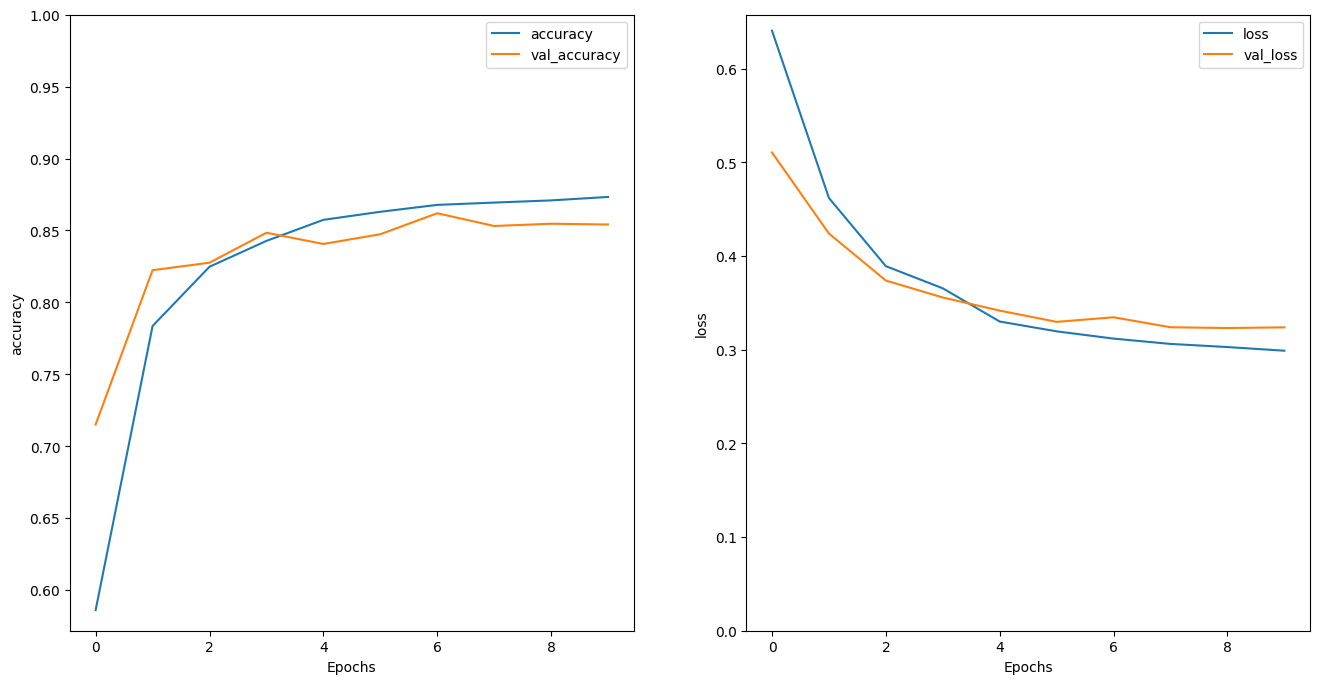

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 2s 2s/step


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 1:37:01 - loss: 0.6935 - accuracy: 0.4375

  2/391 [..............................] - ETA: 1:16 - loss: 0.6937 - accuracy: 0.5000   

  3/391 [..............................] - ETA: 1:16 - loss: 0.6938 - accuracy: 0.5312

  4/391 [..............................] - ETA: 1:17 - loss: 0.6939 - accuracy: 0.5391

  5/391 [..............................] - ETA: 1:18 - loss: 0.6936 - accuracy: 0.5281

  6/391 [..............................] - ETA: 1:18 - loss: 0.6935 - accuracy: 0.5182

  7/391 [..............................] - ETA: 1:17 - loss: 0.6935 - accuracy: 0.5223

  8/391 [..............................] - ETA: 1:16 - loss: 0.6935 - accuracy: 0.5117

  9/391 [..............................] - ETA: 1:16 - loss: 0.6934 - accuracy: 0.5174

 10/391 [..............................] - ETA: 1:17 - loss: 0.6934 - accuracy: 0.5125

 11/391 [..............................] - ETA: 1:16 - loss: 0.6933 - accuracy: 0.5170

 12/391 [..............................] - ETA: 1:16 - loss: 0.6933 - accuracy: 0.5104

 13/391 [..............................] - ETA: 1:16 - loss: 0.6933 - accuracy: 0.5108

 14/391 [>.............................] - ETA: 1:15 - loss: 0.6933 - accuracy: 0.5145

 15/391 [>.............................] - ETA: 1:15 - loss: 0.6933 - accuracy: 0.5094

 16/391 [>.............................] - ETA: 1:14 - loss: 0.6932 - accuracy: 0.5088

 17/391 [>.............................] - ETA: 1:14 - loss: 0.6932 - accuracy: 0.5055

 18/391 [>.............................] - ETA: 1:13 - loss: 0.6932 - accuracy: 0.5043

 19/391 [>.............................] - ETA: 1:14 - loss: 0.6931 - accuracy: 0.5016

 20/391 [>.............................] - ETA: 1:13 - loss: 0.6932 - accuracy: 0.5039

 21/391 [>.............................] - ETA: 1:13 - loss: 0.6931 - accuracy: 0.5060

 22/391 [>.............................] - ETA: 1:11 - loss: 0.6931 - accuracy: 0.5071

 23/391 [>.............................] - ETA: 1:11 - loss: 0.6931 - accuracy: 0.5048

 24/391 [>.............................] - ETA: 1:09 - loss: 0.6931 - accuracy: 0.5039

 25/391 [>.............................] - ETA: 1:08 - loss: 0.6931 - accuracy: 0.5038

 26/391 [>.............................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.5054

 27/391 [=>............................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.5075

 28/391 [=>............................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.5095

 29/391 [=>............................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.5086

 30/391 [=>............................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.5094

 31/391 [=>............................] - ETA: 1:06 - loss: 0.6931 - accuracy: 0.5091

 32/391 [=>............................] - ETA: 1:05 - loss: 0.6931 - accuracy: 0.5098

 33/391 [=>............................] - ETA: 1:05 - loss: 0.6931 - accuracy: 0.5104

 34/391 [=>............................] - ETA: 1:05 - loss: 0.6931 - accuracy: 0.5092

 35/391 [=>............................] - ETA: 1:05 - loss: 0.6931 - accuracy: 0.5085

 36/391 [=>............................] - ETA: 1:05 - loss: 0.6931 - accuracy: 0.5074

 37/391 [=>............................] - ETA: 1:04 - loss: 0.6931 - accuracy: 0.5063

 38/391 [=>............................] - ETA: 1:04 - loss: 0.6930 - accuracy: 0.5062

 39/391 [=>............................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.5072

 40/391 [==>...........................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.5070

 41/391 [==>...........................] - ETA: 1:01 - loss: 0.6930 - accuracy: 0.5080

 42/391 [==>...........................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5082

 43/391 [==>...........................] - ETA: 1:00 - loss: 0.6930 - accuracy: 0.5065

 44/391 [==>...........................] - ETA: 59s - loss: 0.6930 - accuracy: 0.5053 

 45/391 [==>...........................] - ETA: 59s - loss: 0.6930 - accuracy: 0.5038

 46/391 [==>...........................] - ETA: 59s - loss: 0.6930 - accuracy: 0.5010

 47/391 [==>...........................] - ETA: 58s - loss: 0.6930 - accuracy: 0.4993

 48/391 [==>...........................] - ETA: 58s - loss: 0.6930 - accuracy: 0.5000

 49/391 [==>...........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5003

 50/391 [==>...........................] - ETA: 57s - loss: 0.6930 - accuracy: 0.5013

 51/391 [==>...........................] - ETA: 57s - loss: 0.6931 - accuracy: 0.5028

 52/391 [==>...........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.5024

 53/391 [===>..........................] - ETA: 56s - loss: 0.6931 - accuracy: 0.5024

 54/391 [===>..........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.5026

 55/391 [===>..........................] - ETA: 56s - loss: 0.6930 - accuracy: 0.5034

 56/391 [===>..........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5047

 57/391 [===>..........................] - ETA: 55s - loss: 0.6930 - accuracy: 0.5038

 58/391 [===>..........................] - ETA: 55s - loss: 0.6930 - accuracy: 0.5035

 59/391 [===>..........................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5056

 60/391 [===>..........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5073

 61/391 [===>..........................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5082

 62/391 [===>..........................] - ETA: 53s - loss: 0.6930 - accuracy: 0.5083

 63/391 [===>..........................] - ETA: 53s - loss: 0.6930 - accuracy: 0.5094

 64/391 [===>..........................] - ETA: 53s - loss: 0.6930 - accuracy: 0.5098

 65/391 [===>..........................] - ETA: 53s - loss: 0.6930 - accuracy: 0.5108

 66/391 [====>.........................] - ETA: 53s - loss: 0.6930 - accuracy: 0.5109

 67/391 [====>.........................] - ETA: 52s - loss: 0.6930 - accuracy: 0.5105

 68/391 [====>.........................] - ETA: 52s - loss: 0.6930 - accuracy: 0.5099

 69/391 [====>.........................] - ETA: 52s - loss: 0.6930 - accuracy: 0.5095

 70/391 [====>.........................] - ETA: 52s - loss: 0.6930 - accuracy: 0.5083

 71/391 [====>.........................] - ETA: 51s - loss: 0.6930 - accuracy: 0.5084

 72/391 [====>.........................] - ETA: 51s - loss: 0.6930 - accuracy: 0.5095

 73/391 [====>.........................] - ETA: 51s - loss: 0.6930 - accuracy: 0.5088

 74/391 [====>.........................] - ETA: 51s - loss: 0.6929 - accuracy: 0.5070

 75/391 [====>.........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5060

 76/391 [====>.........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5076

 77/391 [====>.........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5075

 78/391 [====>.........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5084

 79/391 [=====>........................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5079

 80/391 [=====>........................] - ETA: 49s - loss: 0.6929 - accuracy: 0.5078

 81/391 [=====>........................] - ETA: 49s - loss: 0.6929 - accuracy: 0.5085

 82/391 [=====>........................] - ETA: 49s - loss: 0.6929 - accuracy: 0.5080

 83/391 [=====>........................] - ETA: 48s - loss: 0.6929 - accuracy: 0.5073

 84/391 [=====>........................] - ETA: 48s - loss: 0.6929 - accuracy: 0.5087

 85/391 [=====>........................] - ETA: 48s - loss: 0.6929 - accuracy: 0.5090

 86/391 [=====>........................] - ETA: 48s - loss: 0.6928 - accuracy: 0.5094

 87/391 [=====>........................] - ETA: 48s - loss: 0.6928 - accuracy: 0.5097

 88/391 [=====>........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.5105

 89/391 [=====>........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.5107

 90/391 [=====>........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.5109

 91/391 [=====>........................] - ETA: 47s - loss: 0.6928 - accuracy: 0.5125

 92/391 [======>.......................] - ETA: 47s - loss: 0.6928 - accuracy: 0.5122

 93/391 [======>.......................] - ETA: 47s - loss: 0.6928 - accuracy: 0.5124

 94/391 [======>.......................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5105

 95/391 [======>.......................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5095

 96/391 [======>.......................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5098

 97/391 [======>.......................] - ETA: 46s - loss: 0.6928 - accuracy: 0.5098

 98/391 [======>.......................] - ETA: 45s - loss: 0.6927 - accuracy: 0.5099

 99/391 [======>.......................] - ETA: 45s - loss: 0.6927 - accuracy: 0.5110

100/391 [======>.......................] - ETA: 45s - loss: 0.6927 - accuracy: 0.5106

101/391 [======>.......................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5110

102/391 [======>.......................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5115

103/391 [======>.......................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5111

104/391 [======>.......................] - ETA: 44s - loss: 0.6927 - accuracy: 0.5107

105/391 [=======>......................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5103

106/391 [=======>......................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5100

107/391 [=======>......................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5085

108/391 [=======>......................] - ETA: 43s - loss: 0.6927 - accuracy: 0.5078

109/391 [=======>......................] - ETA: 42s - loss: 0.6927 - accuracy: 0.5075

110/391 [=======>......................] - ETA: 42s - loss: 0.6927 - accuracy: 0.5072

111/391 [=======>......................] - ETA: 42s - loss: 0.6927 - accuracy: 0.5069

112/391 [=======>......................] - ETA: 42s - loss: 0.6927 - accuracy: 0.5067

113/391 [=======>......................] - ETA: 42s - loss: 0.6926 - accuracy: 0.5066

114/391 [=======>......................] - ETA: 42s - loss: 0.6926 - accuracy: 0.5067

115/391 [=======>......................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5064

116/391 [=======>......................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5059

117/391 [=======>......................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5052

118/391 [========>.....................] - ETA: 41s - loss: 0.6926 - accuracy: 0.5048

119/391 [========>.....................] - ETA: 40s - loss: 0.6926 - accuracy: 0.5045

120/391 [========>.....................] - ETA: 40s - loss: 0.6926 - accuracy: 0.5048

121/391 [========>.....................] - ETA: 40s - loss: 0.6926 - accuracy: 0.5048

122/391 [========>.....................] - ETA: 40s - loss: 0.6926 - accuracy: 0.5049

123/391 [========>.....................] - ETA: 39s - loss: 0.6926 - accuracy: 0.5046

124/391 [========>.....................] - ETA: 39s - loss: 0.6925 - accuracy: 0.5052

125/391 [========>.....................] - ETA: 39s - loss: 0.6926 - accuracy: 0.5058

126/391 [========>.....................] - ETA: 39s - loss: 0.6925 - accuracy: 0.5048

127/391 [========>.....................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5048

128/391 [========>.....................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5043

129/391 [========>.....................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5034

130/391 [========>.....................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5041

131/391 [=========>....................] - ETA: 38s - loss: 0.6925 - accuracy: 0.5033

132/391 [=========>....................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5028

133/391 [=========>....................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5027

134/391 [=========>....................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5031

135/391 [=========>....................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5035

136/391 [=========>....................] - ETA: 37s - loss: 0.6924 - accuracy: 0.5031

137/391 [=========>....................] - ETA: 36s - loss: 0.6923 - accuracy: 0.5031

138/391 [=========>....................] - ETA: 36s - loss: 0.6923 - accuracy: 0.5027

139/391 [=========>....................] - ETA: 36s - loss: 0.6923 - accuracy: 0.5028

140/391 [=========>....................] - ETA: 36s - loss: 0.6923 - accuracy: 0.5022

141/391 [=========>....................] - ETA: 36s - loss: 0.6923 - accuracy: 0.5017

142/391 [=========>....................] - ETA: 35s - loss: 0.6922 - accuracy: 0.5020

143/391 [=========>....................] - ETA: 35s - loss: 0.6922 - accuracy: 0.5020

144/391 [==========>...................] - ETA: 35s - loss: 0.6922 - accuracy: 0.5021

145/391 [==========>...................] - ETA: 35s - loss: 0.6922 - accuracy: 0.5030

146/391 [==========>...................] - ETA: 34s - loss: 0.6922 - accuracy: 0.5029

147/391 [==========>...................] - ETA: 34s - loss: 0.6922 - accuracy: 0.5033

148/391 [==========>...................] - ETA: 34s - loss: 0.6922 - accuracy: 0.5038

149/391 [==========>...................] - ETA: 34s - loss: 0.6922 - accuracy: 0.5033

150/391 [==========>...................] - ETA: 34s - loss: 0.6921 - accuracy: 0.5027

151/391 [==========>...................] - ETA: 34s - loss: 0.6921 - accuracy: 0.5030

152/391 [==========>...................] - ETA: 34s - loss: 0.6921 - accuracy: 0.5024

153/391 [==========>...................] - ETA: 33s - loss: 0.6921 - accuracy: 0.5022

154/391 [==========>...................] - ETA: 33s - loss: 0.6921 - accuracy: 0.5025

155/391 [==========>...................] - ETA: 33s - loss: 0.6921 - accuracy: 0.5022

156/391 [==========>...................] - ETA: 33s - loss: 0.6921 - accuracy: 0.5033

157/391 [===========>..................] - ETA: 33s - loss: 0.6921 - accuracy: 0.5036

158/391 [===========>..................] - ETA: 32s - loss: 0.6921 - accuracy: 0.5033

159/391 [===========>..................] - ETA: 32s - loss: 0.6921 - accuracy: 0.5027

160/391 [===========>..................] - ETA: 32s - loss: 0.6920 - accuracy: 0.5027

161/391 [===========>..................] - ETA: 32s - loss: 0.6920 - accuracy: 0.5025

162/391 [===========>..................] - ETA: 32s - loss: 0.6920 - accuracy: 0.5018

163/391 [===========>..................] - ETA: 32s - loss: 0.6919 - accuracy: 0.5013

164/391 [===========>..................] - ETA: 31s - loss: 0.6919 - accuracy: 0.5017

165/391 [===========>..................] - ETA: 31s - loss: 0.6919 - accuracy: 0.5012

166/391 [===========>..................] - ETA: 31s - loss: 0.6919 - accuracy: 0.5013

167/391 [===========>..................] - ETA: 31s - loss: 0.6919 - accuracy: 0.5018

168/391 [===========>..................] - ETA: 31s - loss: 0.6919 - accuracy: 0.5022

169/391 [===========>..................] - ETA: 31s - loss: 0.6919 - accuracy: 0.5021

170/391 [============>.................] - ETA: 30s - loss: 0.6919 - accuracy: 0.5024

171/391 [============>.................] - ETA: 30s - loss: 0.6919 - accuracy: 0.5020

172/391 [============>.................] - ETA: 30s - loss: 0.6919 - accuracy: 0.5020

173/391 [============>.................] - ETA: 30s - loss: 0.6919 - accuracy: 0.5026

174/391 [============>.................] - ETA: 30s - loss: 0.6918 - accuracy: 0.5030

175/391 [============>.................] - ETA: 30s - loss: 0.6918 - accuracy: 0.5029

176/391 [============>.................] - ETA: 29s - loss: 0.6918 - accuracy: 0.5033

177/391 [============>.................] - ETA: 29s - loss: 0.6917 - accuracy: 0.5031

178/391 [============>.................] - ETA: 29s - loss: 0.6917 - accuracy: 0.5038

179/391 [============>.................] - ETA: 29s - loss: 0.6917 - accuracy: 0.5040

180/391 [============>.................] - ETA: 29s - loss: 0.6917 - accuracy: 0.5040

181/391 [============>.................] - ETA: 29s - loss: 0.6917 - accuracy: 0.5036

182/391 [============>.................] - ETA: 28s - loss: 0.6917 - accuracy: 0.5037

183/391 [=============>................] - ETA: 28s - loss: 0.6916 - accuracy: 0.5039

184/391 [=============>................] - ETA: 28s - loss: 0.6916 - accuracy: 0.5038

185/391 [=============>................] - ETA: 28s - loss: 0.6916 - accuracy: 0.5039

186/391 [=============>................] - ETA: 28s - loss: 0.6916 - accuracy: 0.5039

187/391 [=============>................] - ETA: 28s - loss: 0.6916 - accuracy: 0.5040

188/391 [=============>................] - ETA: 28s - loss: 0.6916 - accuracy: 0.5040

189/391 [=============>................] - ETA: 27s - loss: 0.6916 - accuracy: 0.5038

190/391 [=============>................] - ETA: 27s - loss: 0.6915 - accuracy: 0.5041

191/391 [=============>................] - ETA: 27s - loss: 0.6915 - accuracy: 0.5045

192/391 [=============>................] - ETA: 27s - loss: 0.6915 - accuracy: 0.5043

193/391 [=============>................] - ETA: 27s - loss: 0.6914 - accuracy: 0.5042

194/391 [=============>................] - ETA: 27s - loss: 0.6914 - accuracy: 0.5038

195/391 [=============>................] - ETA: 26s - loss: 0.6914 - accuracy: 0.5034

196/391 [==============>...............] - ETA: 26s - loss: 0.6914 - accuracy: 0.5034

197/391 [==============>...............] - ETA: 26s - loss: 0.6914 - accuracy: 0.5036

198/391 [==============>...............] - ETA: 26s - loss: 0.6914 - accuracy: 0.5039

199/391 [==============>...............] - ETA: 26s - loss: 0.6913 - accuracy: 0.5038

200/391 [==============>...............] - ETA: 26s - loss: 0.6913 - accuracy: 0.5040

201/391 [==============>...............] - ETA: 26s - loss: 0.6913 - accuracy: 0.5044

202/391 [==============>...............] - ETA: 25s - loss: 0.6913 - accuracy: 0.5044

203/391 [==============>...............] - ETA: 25s - loss: 0.6912 - accuracy: 0.5045

204/391 [==============>...............] - ETA: 25s - loss: 0.6912 - accuracy: 0.5046

205/391 [==============>...............] - ETA: 25s - loss: 0.6911 - accuracy: 0.5043

206/391 [==============>...............] - ETA: 25s - loss: 0.6911 - accuracy: 0.5041

207/391 [==============>...............] - ETA: 25s - loss: 0.6911 - accuracy: 0.5036

208/391 [==============>...............] - ETA: 24s - loss: 0.6910 - accuracy: 0.5039

209/391 [===============>..............] - ETA: 24s - loss: 0.6910 - accuracy: 0.5041

210/391 [===============>..............] - ETA: 24s - loss: 0.6910 - accuracy: 0.5042

211/391 [===============>..............] - ETA: 24s - loss: 0.6909 - accuracy: 0.5041

212/391 [===============>..............] - ETA: 24s - loss: 0.6909 - accuracy: 0.5043

213/391 [===============>..............] - ETA: 24s - loss: 0.6909 - accuracy: 0.5052

214/391 [===============>..............] - ETA: 24s - loss: 0.6909 - accuracy: 0.5055

215/391 [===============>..............] - ETA: 23s - loss: 0.6908 - accuracy: 0.5052

216/391 [===============>..............] - ETA: 23s - loss: 0.6908 - accuracy: 0.5053

217/391 [===============>..............] - ETA: 23s - loss: 0.6908 - accuracy: 0.5045

218/391 [===============>..............] - ETA: 23s - loss: 0.6908 - accuracy: 0.5039

219/391 [===============>..............] - ETA: 23s - loss: 0.6907 - accuracy: 0.5037

220/391 [===============>..............] - ETA: 23s - loss: 0.6905 - accuracy: 0.5039

221/391 [===============>..............] - ETA: 22s - loss: 0.6904 - accuracy: 0.5040

222/391 [================>.............] - ETA: 22s - loss: 0.6904 - accuracy: 0.5040

223/391 [================>.............] - ETA: 22s - loss: 0.6903 - accuracy: 0.5042

224/391 [================>.............] - ETA: 22s - loss: 0.6902 - accuracy: 0.5043

225/391 [================>.............] - ETA: 22s - loss: 0.6903 - accuracy: 0.5043

226/391 [================>.............] - ETA: 22s - loss: 0.6902 - accuracy: 0.5048

227/391 [================>.............] - ETA: 22s - loss: 0.6902 - accuracy: 0.5051

228/391 [================>.............] - ETA: 22s - loss: 0.6901 - accuracy: 0.5051

229/391 [================>.............] - ETA: 21s - loss: 0.6900 - accuracy: 0.5052

230/391 [================>.............] - ETA: 21s - loss: 0.6899 - accuracy: 0.5052

231/391 [================>.............] - ETA: 21s - loss: 0.6898 - accuracy: 0.5045

232/391 [================>.............] - ETA: 21s - loss: 0.6897 - accuracy: 0.5044

233/391 [================>.............] - ETA: 21s - loss: 0.6897 - accuracy: 0.5042

234/391 [================>.............] - ETA: 21s - loss: 0.6897 - accuracy: 0.5041

235/391 [=================>............] - ETA: 20s - loss: 0.6896 - accuracy: 0.5038

236/391 [=================>............] - ETA: 20s - loss: 0.6895 - accuracy: 0.5034

237/391 [=================>............] - ETA: 20s - loss: 0.6893 - accuracy: 0.5034

238/391 [=================>............] - ETA: 20s - loss: 0.6892 - accuracy: 0.5028

239/391 [=================>............] - ETA: 20s - loss: 0.6890 - accuracy: 0.5033

240/391 [=================>............] - ETA: 20s - loss: 0.6889 - accuracy: 0.5033

241/391 [=================>............] - ETA: 20s - loss: 0.6889 - accuracy: 0.5040

242/391 [=================>............] - ETA: 19s - loss: 0.6886 - accuracy: 0.5045

243/391 [=================>............] - ETA: 19s - loss: 0.6886 - accuracy: 0.5051

244/391 [=================>............] - ETA: 19s - loss: 0.6885 - accuracy: 0.5054

245/391 [=================>............] - ETA: 19s - loss: 0.6885 - accuracy: 0.5055

246/391 [=================>............] - ETA: 19s - loss: 0.6885 - accuracy: 0.5060

247/391 [=================>............] - ETA: 19s - loss: 0.6883 - accuracy: 0.5061

248/391 [==================>...........] - ETA: 18s - loss: 0.6880 - accuracy: 0.5062

249/391 [==================>...........] - ETA: 18s - loss: 0.6878 - accuracy: 0.5063

250/391 [==================>...........] - ETA: 18s - loss: 0.6877 - accuracy: 0.5059

251/391 [==================>...........] - ETA: 18s - loss: 0.6875 - accuracy: 0.5060

252/391 [==================>...........] - ETA: 18s - loss: 0.6873 - accuracy: 0.5060

253/391 [==================>...........] - ETA: 18s - loss: 0.6873 - accuracy: 0.5059

254/391 [==================>...........] - ETA: 18s - loss: 0.6870 - accuracy: 0.5062

255/391 [==================>...........] - ETA: 17s - loss: 0.6869 - accuracy: 0.5066

256/391 [==================>...........] - ETA: 17s - loss: 0.6868 - accuracy: 0.5064

257/391 [==================>...........] - ETA: 17s - loss: 0.6866 - accuracy: 0.5066

258/391 [==================>...........] - ETA: 17s - loss: 0.6866 - accuracy: 0.5071

259/391 [==================>...........] - ETA: 17s - loss: 0.6863 - accuracy: 0.5076

260/391 [==================>...........] - ETA: 17s - loss: 0.6859 - accuracy: 0.5082

261/391 [===================>..........] - ETA: 17s - loss: 0.6858 - accuracy: 0.5089

262/391 [===================>..........] - ETA: 16s - loss: 0.6853 - accuracy: 0.5096

263/391 [===================>..........] - ETA: 16s - loss: 0.6848 - accuracy: 0.5104

264/391 [===================>..........] - ETA: 16s - loss: 0.6845 - accuracy: 0.5109

265/391 [===================>..........] - ETA: 16s - loss: 0.6844 - accuracy: 0.5110

266/391 [===================>..........] - ETA: 16s - loss: 0.6841 - accuracy: 0.5113

267/391 [===================>..........] - ETA: 16s - loss: 0.6839 - accuracy: 0.5116

268/391 [===================>..........] - ETA: 16s - loss: 0.6837 - accuracy: 0.5121

269/391 [===================>..........] - ETA: 16s - loss: 0.6834 - accuracy: 0.5128

270/391 [===================>..........] - ETA: 15s - loss: 0.6831 - accuracy: 0.5135

271/391 [===================>..........] - ETA: 15s - loss: 0.6824 - accuracy: 0.5145

272/391 [===================>..........] - ETA: 15s - loss: 0.6818 - accuracy: 0.5153

273/391 [===================>..........] - ETA: 15s - loss: 0.6815 - accuracy: 0.5158

274/391 [====================>.........] - ETA: 15s - loss: 0.6810 - accuracy: 0.5165

275/391 [====================>.........] - ETA: 15s - loss: 0.6804 - accuracy: 0.5170

276/391 [====================>.........] - ETA: 15s - loss: 0.6801 - accuracy: 0.5175

277/391 [====================>.........] - ETA: 14s - loss: 0.6797 - accuracy: 0.5181

278/391 [====================>.........] - ETA: 14s - loss: 0.6794 - accuracy: 0.5184

279/391 [====================>.........] - ETA: 14s - loss: 0.6793 - accuracy: 0.5186

280/391 [====================>.........] - ETA: 14s - loss: 0.6789 - accuracy: 0.5194

281/391 [====================>.........] - ETA: 14s - loss: 0.6785 - accuracy: 0.5201

282/391 [====================>.........] - ETA: 14s - loss: 0.6782 - accuracy: 0.5207

283/391 [====================>.........] - ETA: 14s - loss: 0.6778 - accuracy: 0.5216

284/391 [====================>.........] - ETA: 13s - loss: 0.6774 - accuracy: 0.5224

285/391 [====================>.........] - ETA: 13s - loss: 0.6768 - accuracy: 0.5234

286/391 [====================>.........] - ETA: 13s - loss: 0.6769 - accuracy: 0.5239

287/391 [=====================>........] - ETA: 13s - loss: 0.6764 - accuracy: 0.5249

288/391 [=====================>........] - ETA: 13s - loss: 0.6764 - accuracy: 0.5252

289/391 [=====================>........] - ETA: 13s - loss: 0.6768 - accuracy: 0.5255

290/391 [=====================>........] - ETA: 13s - loss: 0.6764 - accuracy: 0.5263

291/391 [=====================>........] - ETA: 12s - loss: 0.6762 - accuracy: 0.5268

292/391 [=====================>........] - ETA: 12s - loss: 0.6760 - accuracy: 0.5274

293/391 [=====================>........] - ETA: 12s - loss: 0.6758 - accuracy: 0.5278

294/391 [=====================>........] - ETA: 12s - loss: 0.6754 - accuracy: 0.5284

295/391 [=====================>........] - ETA: 12s - loss: 0.6746 - accuracy: 0.5293

296/391 [=====================>........] - ETA: 12s - loss: 0.6745 - accuracy: 0.5298

297/391 [=====================>........] - ETA: 12s - loss: 0.6742 - accuracy: 0.5305

298/391 [=====================>........] - ETA: 12s - loss: 0.6741 - accuracy: 0.5308

299/391 [=====================>........] - ETA: 11s - loss: 0.6736 - accuracy: 0.5315

300/391 [======================>.......] - ETA: 11s - loss: 0.6735 - accuracy: 0.5322

301/391 [======================>.......] - ETA: 11s - loss: 0.6733 - accuracy: 0.5328

302/391 [======================>.......] - ETA: 11s - loss: 0.6729 - accuracy: 0.5334

303/391 [======================>.......] - ETA: 11s - loss: 0.6727 - accuracy: 0.5338

304/391 [======================>.......] - ETA: 11s - loss: 0.6721 - accuracy: 0.5345

305/391 [======================>.......] - ETA: 11s - loss: 0.6716 - accuracy: 0.5353

306/391 [======================>.......] - ETA: 10s - loss: 0.6713 - accuracy: 0.5358

307/391 [======================>.......] - ETA: 10s - loss: 0.6710 - accuracy: 0.5362

308/391 [======================>.......] - ETA: 10s - loss: 0.6707 - accuracy: 0.5368

309/391 [======================>.......] - ETA: 10s - loss: 0.6701 - accuracy: 0.5374

310/391 [======================>.......] - ETA: 10s - loss: 0.6698 - accuracy: 0.5378

311/391 [======================>.......] - ETA: 10s - loss: 0.6696 - accuracy: 0.5382

312/391 [======================>.......] - ETA: 10s - loss: 0.6692 - accuracy: 0.5385

313/391 [=======================>......] - ETA: 10s - loss: 0.6688 - accuracy: 0.5388

314/391 [=======================>......] - ETA: 9s - loss: 0.6684 - accuracy: 0.5394 

315/391 [=======================>......] - ETA: 9s - loss: 0.6683 - accuracy: 0.5395

316/391 [=======================>......] - ETA: 9s - loss: 0.6679 - accuracy: 0.5397

317/391 [=======================>......] - ETA: 9s - loss: 0.6674 - accuracy: 0.5403

318/391 [=======================>......] - ETA: 9s - loss: 0.6669 - accuracy: 0.5409

319/391 [=======================>......] - ETA: 9s - loss: 0.6663 - accuracy: 0.5414

320/391 [=======================>......] - ETA: 9s - loss: 0.6661 - accuracy: 0.5418

321/391 [=======================>......] - ETA: 8s - loss: 0.6660 - accuracy: 0.5424

322/391 [=======================>......] - ETA: 8s - loss: 0.6658 - accuracy: 0.5427

323/391 [=======================>......] - ETA: 8s - loss: 0.6655 - accuracy: 0.5432

324/391 [=======================>......] - ETA: 8s - loss: 0.6651 - accuracy: 0.5437

325/391 [=======================>......] - ETA: 8s - loss: 0.6646 - accuracy: 0.5444

326/391 [========================>.....] - ETA: 8s - loss: 0.6640 - accuracy: 0.5451

327/391 [========================>.....] - ETA: 8s - loss: 0.6635 - accuracy: 0.5457

328/391 [========================>.....] - ETA: 8s - loss: 0.6631 - accuracy: 0.5462

329/391 [========================>.....] - ETA: 7s - loss: 0.6629 - accuracy: 0.5467

330/391 [========================>.....] - ETA: 7s - loss: 0.6624 - accuracy: 0.5473

331/391 [========================>.....] - ETA: 7s - loss: 0.6622 - accuracy: 0.5475

332/391 [========================>.....] - ETA: 7s - loss: 0.6614 - accuracy: 0.5482

333/391 [========================>.....] - ETA: 7s - loss: 0.6611 - accuracy: 0.5487

334/391 [========================>.....] - ETA: 7s - loss: 0.6605 - accuracy: 0.5492

335/391 [========================>.....] - ETA: 7s - loss: 0.6602 - accuracy: 0.5497

336/391 [========================>.....] - ETA: 7s - loss: 0.6596 - accuracy: 0.5505

337/391 [========================>.....] - ETA: 6s - loss: 0.6591 - accuracy: 0.5512

338/391 [========================>.....] - ETA: 6s - loss: 0.6588 - accuracy: 0.5518

339/391 [=========================>....] - ETA: 6s - loss: 0.6586 - accuracy: 0.5522

340/391 [=========================>....] - ETA: 6s - loss: 0.6580 - accuracy: 0.5529

341/391 [=========================>....] - ETA: 6s - loss: 0.6578 - accuracy: 0.5534

342/391 [=========================>....] - ETA: 6s - loss: 0.6572 - accuracy: 0.5540

343/391 [=========================>....] - ETA: 6s - loss: 0.6569 - accuracy: 0.5547

344/391 [=========================>....] - ETA: 5s - loss: 0.6563 - accuracy: 0.5553

345/391 [=========================>....] - ETA: 5s - loss: 0.6559 - accuracy: 0.5558

346/391 [=========================>....] - ETA: 5s - loss: 0.6554 - accuracy: 0.5566

347/391 [=========================>....] - ETA: 5s - loss: 0.6551 - accuracy: 0.5570

348/391 [=========================>....] - ETA: 5s - loss: 0.6545 - accuracy: 0.5576

349/391 [=========================>....] - ETA: 5s - loss: 0.6545 - accuracy: 0.5578

350/391 [=========================>....] - ETA: 5s - loss: 0.6539 - accuracy: 0.5584

351/391 [=========================>....] - ETA: 5s - loss: 0.6536 - accuracy: 0.5590

352/391 [==========================>...] - ETA: 4s - loss: 0.6532 - accuracy: 0.5596

353/391 [==========================>...] - ETA: 4s - loss: 0.6528 - accuracy: 0.5602

354/391 [==========================>...] - ETA: 4s - loss: 0.6525 - accuracy: 0.5606

355/391 [==========================>...] - ETA: 4s - loss: 0.6521 - accuracy: 0.5613

356/391 [==========================>...] - ETA: 4s - loss: 0.6520 - accuracy: 0.5616

357/391 [==========================>...] - ETA: 4s - loss: 0.6516 - accuracy: 0.5621

358/391 [==========================>...] - ETA: 4s - loss: 0.6514 - accuracy: 0.5625

359/391 [==========================>...] - ETA: 4s - loss: 0.6510 - accuracy: 0.5629

360/391 [==========================>...] - ETA: 3s - loss: 0.6505 - accuracy: 0.5634

361/391 [==========================>...] - ETA: 3s - loss: 0.6499 - accuracy: 0.5640

362/391 [==========================>...] - ETA: 3s - loss: 0.6496 - accuracy: 0.5644

363/391 [==========================>...] - ETA: 3s - loss: 0.6491 - accuracy: 0.5652

364/391 [==========================>...] - ETA: 3s - loss: 0.6488 - accuracy: 0.5655

365/391 [===========================>..] - ETA: 3s - loss: 0.6484 - accuracy: 0.5660

366/391 [===========================>..] - ETA: 3s - loss: 0.6481 - accuracy: 0.5665

367/391 [===========================>..] - ETA: 3s - loss: 0.6476 - accuracy: 0.5669

368/391 [===========================>..] - ETA: 2s - loss: 0.6473 - accuracy: 0.5675

369/391 [===========================>..] - ETA: 2s - loss: 0.6470 - accuracy: 0.5680

370/391 [===========================>..] - ETA: 2s - loss: 0.6464 - accuracy: 0.5686

371/391 [===========================>..] - ETA: 2s - loss: 0.6458 - accuracy: 0.5694

372/391 [===========================>..] - ETA: 2s - loss: 0.6452 - accuracy: 0.5700

373/391 [===========================>..] - ETA: 2s - loss: 0.6448 - accuracy: 0.5705

374/391 [===========================>..] - ETA: 2s - loss: 0.6443 - accuracy: 0.5710

375/391 [===========================>..] - ETA: 2s - loss: 0.6438 - accuracy: 0.5716

376/391 [===========================>..] - ETA: 1s - loss: 0.6434 - accuracy: 0.5721

377/391 [===========================>..] - ETA: 1s - loss: 0.6432 - accuracy: 0.5725

378/391 [============================>.] - ETA: 1s - loss: 0.6425 - accuracy: 0.5732

379/391 [============================>.] - ETA: 1s - loss: 0.6420 - accuracy: 0.5737

380/391 [============================>.] - ETA: 1s - loss: 0.6415 - accuracy: 0.5743

381/391 [============================>.] - ETA: 1s - loss: 0.6411 - accuracy: 0.5750

382/391 [============================>.] - ETA: 1s - loss: 0.6408 - accuracy: 0.5754

383/391 [============================>.] - ETA: 1s - loss: 0.6404 - accuracy: 0.5760

384/391 [============================>.] - ETA: 0s - loss: 0.6400 - accuracy: 0.5768

385/391 [============================>.] - ETA: 0s - loss: 0.6397 - accuracy: 0.5772

386/391 [============================>.] - ETA: 0s - loss: 0.6393 - accuracy: 0.5778

387/391 [============================>.] - ETA: 0s - loss: 0.6387 - accuracy: 0.5783

388/391 [============================>.] - ETA: 0s - loss: 0.6381 - accuracy: 0.5789

389/391 [============================>.] - ETA: 0s - loss: 0.6382 - accuracy: 0.5790

390/391 [============================>.] - ETA: 0s - loss: 0.6378 - accuracy: 0.5794

391/391 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.5797

391/391 [==============================] - 70s 140ms/step - loss: 0.6376 - accuracy: 0.5797 - val_loss: 0.4587 - val_accuracy: 0.7839


Epoch 2/10


  1/391 [..............................] - ETA: 3:43 - loss: 0.3702 - accuracy: 0.9219

  2/391 [..............................] - ETA: 41s - loss: 0.3872 - accuracy: 0.8594 

  3/391 [..............................] - ETA: 40s - loss: 0.4163 - accuracy: 0.8438

  4/391 [..............................] - ETA: 41s - loss: 0.4472 - accuracy: 0.8242

  5/391 [..............................] - ETA: 41s - loss: 0.4595 - accuracy: 0.8156

  6/391 [..............................] - ETA: 39s - loss: 0.4786 - accuracy: 0.7917

  7/391 [..............................] - ETA: 39s - loss: 0.4807 - accuracy: 0.7835

  8/391 [..............................] - ETA: 40s - loss: 0.4704 - accuracy: 0.7969

  9/391 [..............................] - ETA: 40s - loss: 0.4664 - accuracy: 0.7969

 10/391 [..............................] - ETA: 39s - loss: 0.4736 - accuracy: 0.7906

 11/391 [..............................] - ETA: 38s - loss: 0.4672 - accuracy: 0.7955

 12/391 [..............................] - ETA: 38s - loss: 0.4738 - accuracy: 0.7930

 13/391 [..............................] - ETA: 39s - loss: 0.4691 - accuracy: 0.7933

 14/391 [>.............................] - ETA: 38s - loss: 0.4654 - accuracy: 0.7980

 15/391 [>.............................] - ETA: 40s - loss: 0.4612 - accuracy: 0.8000

 16/391 [>.............................] - ETA: 39s - loss: 0.4597 - accuracy: 0.8018

 17/391 [>.............................] - ETA: 40s - loss: 0.4589 - accuracy: 0.7996

 18/391 [>.............................] - ETA: 39s - loss: 0.4524 - accuracy: 0.8021

 19/391 [>.............................] - ETA: 39s - loss: 0.4475 - accuracy: 0.8043

 20/391 [>.............................] - ETA: 39s - loss: 0.4445 - accuracy: 0.8047

 21/391 [>.............................] - ETA: 39s - loss: 0.4429 - accuracy: 0.8065

 22/391 [>.............................] - ETA: 39s - loss: 0.4383 - accuracy: 0.8082

 23/391 [>.............................] - ETA: 39s - loss: 0.4368 - accuracy: 0.8098

 24/391 [>.............................] - ETA: 38s - loss: 0.4451 - accuracy: 0.8047

 25/391 [>.............................] - ETA: 38s - loss: 0.4447 - accuracy: 0.8037

 26/391 [>.............................] - ETA: 38s - loss: 0.4417 - accuracy: 0.8053

 27/391 [=>............................] - ETA: 38s - loss: 0.4442 - accuracy: 0.8038

 28/391 [=>............................] - ETA: 38s - loss: 0.4440 - accuracy: 0.8047

 29/391 [=>............................] - ETA: 38s - loss: 0.4459 - accuracy: 0.8050

 30/391 [=>............................] - ETA: 38s - loss: 0.4480 - accuracy: 0.8031

 31/391 [=>............................] - ETA: 38s - loss: 0.4438 - accuracy: 0.8065

 32/391 [=>............................] - ETA: 37s - loss: 0.4457 - accuracy: 0.8042

 33/391 [=>............................] - ETA: 37s - loss: 0.4473 - accuracy: 0.8030

 34/391 [=>............................] - ETA: 37s - loss: 0.4448 - accuracy: 0.8033

 35/391 [=>............................] - ETA: 37s - loss: 0.4445 - accuracy: 0.8036

 36/391 [=>............................] - ETA: 37s - loss: 0.4432 - accuracy: 0.8051

 37/391 [=>............................] - ETA: 37s - loss: 0.4424 - accuracy: 0.8053

 38/391 [=>............................] - ETA: 37s - loss: 0.4409 - accuracy: 0.8063

 39/391 [=>............................] - ETA: 37s - loss: 0.4418 - accuracy: 0.8053

 40/391 [==>...........................] - ETA: 37s - loss: 0.4463 - accuracy: 0.8020

 41/391 [==>...........................] - ETA: 36s - loss: 0.4452 - accuracy: 0.8022

 42/391 [==>...........................] - ETA: 36s - loss: 0.4449 - accuracy: 0.8025

 43/391 [==>...........................] - ETA: 36s - loss: 0.4446 - accuracy: 0.8027

 44/391 [==>...........................] - ETA: 36s - loss: 0.4453 - accuracy: 0.8018

 45/391 [==>...........................] - ETA: 36s - loss: 0.4481 - accuracy: 0.8010

 46/391 [==>...........................] - ETA: 36s - loss: 0.4472 - accuracy: 0.8013

 47/391 [==>...........................] - ETA: 36s - loss: 0.4460 - accuracy: 0.8015

 48/391 [==>...........................] - ETA: 36s - loss: 0.4449 - accuracy: 0.8031

 49/391 [==>...........................] - ETA: 36s - loss: 0.4444 - accuracy: 0.8023

 50/391 [==>...........................] - ETA: 36s - loss: 0.4433 - accuracy: 0.8037

 51/391 [==>...........................] - ETA: 36s - loss: 0.4451 - accuracy: 0.8021

 52/391 [==>...........................] - ETA: 35s - loss: 0.4451 - accuracy: 0.8011

 53/391 [===>..........................] - ETA: 35s - loss: 0.4451 - accuracy: 0.8007

 54/391 [===>..........................] - ETA: 35s - loss: 0.4431 - accuracy: 0.8024

 55/391 [===>..........................] - ETA: 35s - loss: 0.4425 - accuracy: 0.8031

 56/391 [===>..........................] - ETA: 35s - loss: 0.4425 - accuracy: 0.8036

 57/391 [===>..........................] - ETA: 35s - loss: 0.4413 - accuracy: 0.8046

 58/391 [===>..........................] - ETA: 35s - loss: 0.4415 - accuracy: 0.8041

 59/391 [===>..........................] - ETA: 35s - loss: 0.4397 - accuracy: 0.8061

 60/391 [===>..........................] - ETA: 35s - loss: 0.4392 - accuracy: 0.8068

 61/391 [===>..........................] - ETA: 35s - loss: 0.4388 - accuracy: 0.8064

 62/391 [===>..........................] - ETA: 35s - loss: 0.4393 - accuracy: 0.8059

 63/391 [===>..........................] - ETA: 35s - loss: 0.4384 - accuracy: 0.8058

 64/391 [===>..........................] - ETA: 34s - loss: 0.4391 - accuracy: 0.8052

 65/391 [===>..........................] - ETA: 34s - loss: 0.4393 - accuracy: 0.8046

 66/391 [====>.........................] - ETA: 34s - loss: 0.4384 - accuracy: 0.8049

 67/391 [====>.........................] - ETA: 34s - loss: 0.4406 - accuracy: 0.8046

 68/391 [====>.........................] - ETA: 34s - loss: 0.4407 - accuracy: 0.8045

 69/391 [====>.........................] - ETA: 34s - loss: 0.4404 - accuracy: 0.8053

 70/391 [====>.........................] - ETA: 34s - loss: 0.4404 - accuracy: 0.8062

 71/391 [====>.........................] - ETA: 34s - loss: 0.4395 - accuracy: 0.8070

 72/391 [====>.........................] - ETA: 34s - loss: 0.4378 - accuracy: 0.8086

 73/391 [====>.........................] - ETA: 34s - loss: 0.4390 - accuracy: 0.8069

 74/391 [====>.........................] - ETA: 34s - loss: 0.4403 - accuracy: 0.8057

 75/391 [====>.........................] - ETA: 34s - loss: 0.4402 - accuracy: 0.8054

 76/391 [====>.........................] - ETA: 34s - loss: 0.4415 - accuracy: 0.8051

 77/391 [====>.........................] - ETA: 34s - loss: 0.4409 - accuracy: 0.8056

 78/391 [====>.........................] - ETA: 34s - loss: 0.4415 - accuracy: 0.8051

 79/391 [=====>........................] - ETA: 33s - loss: 0.4413 - accuracy: 0.8050

 80/391 [=====>........................] - ETA: 33s - loss: 0.4416 - accuracy: 0.8049

 81/391 [=====>........................] - ETA: 33s - loss: 0.4408 - accuracy: 0.8050

 82/391 [=====>........................] - ETA: 33s - loss: 0.4408 - accuracy: 0.8054

 83/391 [=====>........................] - ETA: 33s - loss: 0.4395 - accuracy: 0.8055

 84/391 [=====>........................] - ETA: 33s - loss: 0.4387 - accuracy: 0.8056

 85/391 [=====>........................] - ETA: 33s - loss: 0.4384 - accuracy: 0.8059

 86/391 [=====>........................] - ETA: 32s - loss: 0.4371 - accuracy: 0.8061

 87/391 [=====>........................] - ETA: 32s - loss: 0.4382 - accuracy: 0.8051

 88/391 [=====>........................] - ETA: 32s - loss: 0.4393 - accuracy: 0.8050

 89/391 [=====>........................] - ETA: 32s - loss: 0.4386 - accuracy: 0.8055

 90/391 [=====>........................] - ETA: 32s - loss: 0.4386 - accuracy: 0.8056

 91/391 [=====>........................] - ETA: 32s - loss: 0.4378 - accuracy: 0.8063

 92/391 [======>.......................] - ETA: 32s - loss: 0.4374 - accuracy: 0.8067

 93/391 [======>.......................] - ETA: 32s - loss: 0.4375 - accuracy: 0.8070

 94/391 [======>.......................] - ETA: 31s - loss: 0.4375 - accuracy: 0.8072

 95/391 [======>.......................] - ETA: 31s - loss: 0.4360 - accuracy: 0.8079

 96/391 [======>.......................] - ETA: 31s - loss: 0.4350 - accuracy: 0.8088

 97/391 [======>.......................] - ETA: 31s - loss: 0.4344 - accuracy: 0.8091

 98/391 [======>.......................] - ETA: 31s - loss: 0.4340 - accuracy: 0.8088

 99/391 [======>.......................] - ETA: 31s - loss: 0.4345 - accuracy: 0.8084

100/391 [======>.......................] - ETA: 31s - loss: 0.4350 - accuracy: 0.8078

101/391 [======>.......................] - ETA: 31s - loss: 0.4351 - accuracy: 0.8077

102/391 [======>.......................] - ETA: 31s - loss: 0.4358 - accuracy: 0.8076

103/391 [======>.......................] - ETA: 30s - loss: 0.4349 - accuracy: 0.8083

104/391 [======>.......................] - ETA: 30s - loss: 0.4344 - accuracy: 0.8087

105/391 [=======>......................] - ETA: 30s - loss: 0.4337 - accuracy: 0.8089

106/391 [=======>......................] - ETA: 30s - loss: 0.4342 - accuracy: 0.8084

107/391 [=======>......................] - ETA: 30s - loss: 0.4328 - accuracy: 0.8094

108/391 [=======>......................] - ETA: 30s - loss: 0.4332 - accuracy: 0.8087

109/391 [=======>......................] - ETA: 30s - loss: 0.4326 - accuracy: 0.8091

110/391 [=======>......................] - ETA: 30s - loss: 0.4316 - accuracy: 0.8095

111/391 [=======>......................] - ETA: 30s - loss: 0.4311 - accuracy: 0.8097

112/391 [=======>......................] - ETA: 29s - loss: 0.4313 - accuracy: 0.8097

113/391 [=======>......................] - ETA: 29s - loss: 0.4312 - accuracy: 0.8097

114/391 [=======>......................] - ETA: 29s - loss: 0.4306 - accuracy: 0.8098

115/391 [=======>......................] - ETA: 29s - loss: 0.4299 - accuracy: 0.8103

116/391 [=======>......................] - ETA: 29s - loss: 0.4304 - accuracy: 0.8099

117/391 [=======>......................] - ETA: 29s - loss: 0.4304 - accuracy: 0.8097

118/391 [========>.....................] - ETA: 29s - loss: 0.4305 - accuracy: 0.8100

119/391 [========>.....................] - ETA: 29s - loss: 0.4294 - accuracy: 0.8108

120/391 [========>.....................] - ETA: 29s - loss: 0.4295 - accuracy: 0.8109

121/391 [========>.....................] - ETA: 29s - loss: 0.4295 - accuracy: 0.8106

122/391 [========>.....................] - ETA: 28s - loss: 0.4294 - accuracy: 0.8106

123/391 [========>.....................] - ETA: 28s - loss: 0.4284 - accuracy: 0.8111

124/391 [========>.....................] - ETA: 28s - loss: 0.4274 - accuracy: 0.8114

125/391 [========>.....................] - ETA: 28s - loss: 0.4275 - accuracy: 0.8109

126/391 [========>.....................] - ETA: 28s - loss: 0.4268 - accuracy: 0.8109

127/391 [========>.....................] - ETA: 28s - loss: 0.4271 - accuracy: 0.8103

128/391 [========>.....................] - ETA: 28s - loss: 0.4267 - accuracy: 0.8105

129/391 [========>.....................] - ETA: 28s - loss: 0.4259 - accuracy: 0.8108

130/391 [========>.....................] - ETA: 28s - loss: 0.4263 - accuracy: 0.8107

131/391 [=========>....................] - ETA: 28s - loss: 0.4269 - accuracy: 0.8102

132/391 [=========>....................] - ETA: 28s - loss: 0.4264 - accuracy: 0.8107

133/391 [=========>....................] - ETA: 27s - loss: 0.4262 - accuracy: 0.8109

134/391 [=========>....................] - ETA: 27s - loss: 0.4250 - accuracy: 0.8118

135/391 [=========>....................] - ETA: 27s - loss: 0.4245 - accuracy: 0.8123

136/391 [=========>....................] - ETA: 27s - loss: 0.4233 - accuracy: 0.8130

137/391 [=========>....................] - ETA: 27s - loss: 0.4232 - accuracy: 0.8128

138/391 [=========>....................] - ETA: 27s - loss: 0.4230 - accuracy: 0.8127

139/391 [=========>....................] - ETA: 27s - loss: 0.4229 - accuracy: 0.8131

140/391 [=========>....................] - ETA: 27s - loss: 0.4228 - accuracy: 0.8132

141/391 [=========>....................] - ETA: 27s - loss: 0.4227 - accuracy: 0.8133

142/391 [=========>....................] - ETA: 27s - loss: 0.4224 - accuracy: 0.8136

143/391 [=========>....................] - ETA: 26s - loss: 0.4223 - accuracy: 0.8140

144/391 [==========>...................] - ETA: 26s - loss: 0.4219 - accuracy: 0.8141

145/391 [==========>...................] - ETA: 26s - loss: 0.4215 - accuracy: 0.8142

146/391 [==========>...................] - ETA: 26s - loss: 0.4211 - accuracy: 0.8145

147/391 [==========>...................] - ETA: 26s - loss: 0.4202 - accuracy: 0.8149

148/391 [==========>...................] - ETA: 26s - loss: 0.4205 - accuracy: 0.8149

149/391 [==========>...................] - ETA: 26s - loss: 0.4208 - accuracy: 0.8147

150/391 [==========>...................] - ETA: 26s - loss: 0.4213 - accuracy: 0.8145

151/391 [==========>...................] - ETA: 26s - loss: 0.4211 - accuracy: 0.8148

152/391 [==========>...................] - ETA: 26s - loss: 0.4211 - accuracy: 0.8146

153/391 [==========>...................] - ETA: 25s - loss: 0.4209 - accuracy: 0.8146

154/391 [==========>...................] - ETA: 25s - loss: 0.4199 - accuracy: 0.8150

155/391 [==========>...................] - ETA: 25s - loss: 0.4200 - accuracy: 0.8146

156/391 [==========>...................] - ETA: 25s - loss: 0.4189 - accuracy: 0.8151

157/391 [===========>..................] - ETA: 25s - loss: 0.4187 - accuracy: 0.8152

158/391 [===========>..................] - ETA: 25s - loss: 0.4192 - accuracy: 0.8148

159/391 [===========>..................] - ETA: 25s - loss: 0.4186 - accuracy: 0.8149

160/391 [===========>..................] - ETA: 25s - loss: 0.4183 - accuracy: 0.8149

161/391 [===========>..................] - ETA: 25s - loss: 0.4183 - accuracy: 0.8150

162/391 [===========>..................] - ETA: 24s - loss: 0.4177 - accuracy: 0.8156

163/391 [===========>..................] - ETA: 24s - loss: 0.4183 - accuracy: 0.8155

164/391 [===========>..................] - ETA: 24s - loss: 0.4179 - accuracy: 0.8158

165/391 [===========>..................] - ETA: 24s - loss: 0.4179 - accuracy: 0.8160

166/391 [===========>..................] - ETA: 24s - loss: 0.4188 - accuracy: 0.8153

167/391 [===========>..................] - ETA: 24s - loss: 0.4192 - accuracy: 0.8153

168/391 [===========>..................] - ETA: 24s - loss: 0.4186 - accuracy: 0.8155

169/391 [===========>..................] - ETA: 24s - loss: 0.4186 - accuracy: 0.8153

170/391 [============>.................] - ETA: 24s - loss: 0.4184 - accuracy: 0.8153

171/391 [============>.................] - ETA: 23s - loss: 0.4190 - accuracy: 0.8147

172/391 [============>.................] - ETA: 23s - loss: 0.4189 - accuracy: 0.8144

173/391 [============>.................] - ETA: 23s - loss: 0.4193 - accuracy: 0.8139

174/391 [============>.................] - ETA: 23s - loss: 0.4189 - accuracy: 0.8141

175/391 [============>.................] - ETA: 23s - loss: 0.4179 - accuracy: 0.8146

176/391 [============>.................] - ETA: 23s - loss: 0.4176 - accuracy: 0.8147

177/391 [============>.................] - ETA: 23s - loss: 0.4175 - accuracy: 0.8149

178/391 [============>.................] - ETA: 23s - loss: 0.4175 - accuracy: 0.8150

179/391 [============>.................] - ETA: 22s - loss: 0.4169 - accuracy: 0.8151

180/391 [============>.................] - ETA: 22s - loss: 0.4161 - accuracy: 0.8156

181/391 [============>.................] - ETA: 22s - loss: 0.4158 - accuracy: 0.8159

182/391 [============>.................] - ETA: 22s - loss: 0.4152 - accuracy: 0.8163

183/391 [=============>................] - ETA: 22s - loss: 0.4148 - accuracy: 0.8166

184/391 [=============>................] - ETA: 22s - loss: 0.4149 - accuracy: 0.8166

185/391 [=============>................] - ETA: 22s - loss: 0.4149 - accuracy: 0.8165

186/391 [=============>................] - ETA: 22s - loss: 0.4146 - accuracy: 0.8164

187/391 [=============>................] - ETA: 22s - loss: 0.4145 - accuracy: 0.8163

188/391 [=============>................] - ETA: 22s - loss: 0.4142 - accuracy: 0.8163

189/391 [=============>................] - ETA: 21s - loss: 0.4140 - accuracy: 0.8162

190/391 [=============>................] - ETA: 21s - loss: 0.4141 - accuracy: 0.8163

191/391 [=============>................] - ETA: 21s - loss: 0.4140 - accuracy: 0.8166

192/391 [=============>................] - ETA: 21s - loss: 0.4144 - accuracy: 0.8165

193/391 [=============>................] - ETA: 21s - loss: 0.4144 - accuracy: 0.8165

194/391 [=============>................] - ETA: 21s - loss: 0.4141 - accuracy: 0.8164

195/391 [=============>................] - ETA: 21s - loss: 0.4136 - accuracy: 0.8168

196/391 [==============>...............] - ETA: 21s - loss: 0.4135 - accuracy: 0.8170

197/391 [==============>...............] - ETA: 21s - loss: 0.4133 - accuracy: 0.8172

198/391 [==============>...............] - ETA: 20s - loss: 0.4132 - accuracy: 0.8171

199/391 [==============>...............] - ETA: 20s - loss: 0.4129 - accuracy: 0.8172

200/391 [==============>...............] - ETA: 20s - loss: 0.4131 - accuracy: 0.8174

201/391 [==============>...............] - ETA: 20s - loss: 0.4129 - accuracy: 0.8173

202/391 [==============>...............] - ETA: 20s - loss: 0.4125 - accuracy: 0.8175

203/391 [==============>...............] - ETA: 20s - loss: 0.4118 - accuracy: 0.8178

204/391 [==============>...............] - ETA: 20s - loss: 0.4119 - accuracy: 0.8177

205/391 [==============>...............] - ETA: 20s - loss: 0.4116 - accuracy: 0.8178

206/391 [==============>...............] - ETA: 20s - loss: 0.4114 - accuracy: 0.8180

207/391 [==============>...............] - ETA: 20s - loss: 0.4118 - accuracy: 0.8178

208/391 [==============>...............] - ETA: 19s - loss: 0.4117 - accuracy: 0.8176

209/391 [===============>..............] - ETA: 19s - loss: 0.4114 - accuracy: 0.8178

210/391 [===============>..............] - ETA: 19s - loss: 0.4114 - accuracy: 0.8179

211/391 [===============>..............] - ETA: 19s - loss: 0.4115 - accuracy: 0.8178

212/391 [===============>..............] - ETA: 19s - loss: 0.4114 - accuracy: 0.8179

213/391 [===============>..............] - ETA: 19s - loss: 0.4118 - accuracy: 0.8174

214/391 [===============>..............] - ETA: 19s - loss: 0.4115 - accuracy: 0.8177

215/391 [===============>..............] - ETA: 19s - loss: 0.4110 - accuracy: 0.8181

216/391 [===============>..............] - ETA: 19s - loss: 0.4107 - accuracy: 0.8183

217/391 [===============>..............] - ETA: 18s - loss: 0.4105 - accuracy: 0.8185

218/391 [===============>..............] - ETA: 18s - loss: 0.4103 - accuracy: 0.8188

219/391 [===============>..............] - ETA: 18s - loss: 0.4101 - accuracy: 0.8188

220/391 [===============>..............] - ETA: 18s - loss: 0.4103 - accuracy: 0.8188

221/391 [===============>..............] - ETA: 18s - loss: 0.4103 - accuracy: 0.8188

222/391 [================>.............] - ETA: 18s - loss: 0.4104 - accuracy: 0.8188

223/391 [================>.............] - ETA: 18s - loss: 0.4097 - accuracy: 0.8193

224/391 [================>.............] - ETA: 18s - loss: 0.4101 - accuracy: 0.8191

225/391 [================>.............] - ETA: 18s - loss: 0.4108 - accuracy: 0.8188

226/391 [================>.............] - ETA: 17s - loss: 0.4105 - accuracy: 0.8187

227/391 [================>.............] - ETA: 17s - loss: 0.4098 - accuracy: 0.8192

228/391 [================>.............] - ETA: 17s - loss: 0.4095 - accuracy: 0.8192

229/391 [================>.............] - ETA: 17s - loss: 0.4088 - accuracy: 0.8196

230/391 [================>.............] - ETA: 17s - loss: 0.4088 - accuracy: 0.8196

231/391 [================>.............] - ETA: 17s - loss: 0.4084 - accuracy: 0.8197

232/391 [================>.............] - ETA: 17s - loss: 0.4084 - accuracy: 0.8198

233/391 [================>.............] - ETA: 17s - loss: 0.4084 - accuracy: 0.8197

234/391 [================>.............] - ETA: 17s - loss: 0.4085 - accuracy: 0.8196

235/391 [=================>............] - ETA: 17s - loss: 0.4085 - accuracy: 0.8195

236/391 [=================>............] - ETA: 16s - loss: 0.4080 - accuracy: 0.8199

237/391 [=================>............] - ETA: 16s - loss: 0.4076 - accuracy: 0.8199

238/391 [=================>............] - ETA: 16s - loss: 0.4072 - accuracy: 0.8204

239/391 [=================>............] - ETA: 16s - loss: 0.4077 - accuracy: 0.8203

240/391 [=================>............] - ETA: 16s - loss: 0.4072 - accuracy: 0.8204

241/391 [=================>............] - ETA: 16s - loss: 0.4067 - accuracy: 0.8207

242/391 [=================>............] - ETA: 16s - loss: 0.4061 - accuracy: 0.8210

243/391 [=================>............] - ETA: 16s - loss: 0.4061 - accuracy: 0.8211

244/391 [=================>............] - ETA: 16s - loss: 0.4066 - accuracy: 0.8208

245/391 [=================>............] - ETA: 15s - loss: 0.4068 - accuracy: 0.8205

246/391 [=================>............] - ETA: 15s - loss: 0.4064 - accuracy: 0.8208

247/391 [=================>............] - ETA: 15s - loss: 0.4057 - accuracy: 0.8211

248/391 [==================>...........] - ETA: 15s - loss: 0.4054 - accuracy: 0.8211

249/391 [==================>...........] - ETA: 15s - loss: 0.4053 - accuracy: 0.8212

250/391 [==================>...........] - ETA: 15s - loss: 0.4055 - accuracy: 0.8213

251/391 [==================>...........] - ETA: 15s - loss: 0.4052 - accuracy: 0.8215

252/391 [==================>...........] - ETA: 15s - loss: 0.4054 - accuracy: 0.8214

253/391 [==================>...........] - ETA: 15s - loss: 0.4054 - accuracy: 0.8215

254/391 [==================>...........] - ETA: 15s - loss: 0.4054 - accuracy: 0.8216

255/391 [==================>...........] - ETA: 14s - loss: 0.4054 - accuracy: 0.8216

256/391 [==================>...........] - ETA: 14s - loss: 0.4061 - accuracy: 0.8215

257/391 [==================>...........] - ETA: 14s - loss: 0.4067 - accuracy: 0.8211

258/391 [==================>...........] - ETA: 14s - loss: 0.4072 - accuracy: 0.8209

259/391 [==================>...........] - ETA: 14s - loss: 0.4076 - accuracy: 0.8206

260/391 [==================>...........] - ETA: 14s - loss: 0.4073 - accuracy: 0.8207

261/391 [===================>..........] - ETA: 14s - loss: 0.4076 - accuracy: 0.8206

262/391 [===================>..........] - ETA: 14s - loss: 0.4075 - accuracy: 0.8207

263/391 [===================>..........] - ETA: 14s - loss: 0.4075 - accuracy: 0.8205

264/391 [===================>..........] - ETA: 13s - loss: 0.4075 - accuracy: 0.8204

265/391 [===================>..........] - ETA: 13s - loss: 0.4074 - accuracy: 0.8206

266/391 [===================>..........] - ETA: 13s - loss: 0.4082 - accuracy: 0.8204

267/391 [===================>..........] - ETA: 13s - loss: 0.4082 - accuracy: 0.8206

268/391 [===================>..........] - ETA: 13s - loss: 0.4077 - accuracy: 0.8208

269/391 [===================>..........] - ETA: 13s - loss: 0.4075 - accuracy: 0.8207

270/391 [===================>..........] - ETA: 13s - loss: 0.4075 - accuracy: 0.8205

271/391 [===================>..........] - ETA: 13s - loss: 0.4072 - accuracy: 0.8205

272/391 [===================>..........] - ETA: 13s - loss: 0.4073 - accuracy: 0.8203

273/391 [===================>..........] - ETA: 12s - loss: 0.4072 - accuracy: 0.8202

274/391 [====================>.........] - ETA: 12s - loss: 0.4072 - accuracy: 0.8202

275/391 [====================>.........] - ETA: 12s - loss: 0.4069 - accuracy: 0.8205

276/391 [====================>.........] - ETA: 12s - loss: 0.4071 - accuracy: 0.8203

277/391 [====================>.........] - ETA: 12s - loss: 0.4068 - accuracy: 0.8205

278/391 [====================>.........] - ETA: 12s - loss: 0.4064 - accuracy: 0.8208

279/391 [====================>.........] - ETA: 12s - loss: 0.4060 - accuracy: 0.8211

280/391 [====================>.........] - ETA: 12s - loss: 0.4060 - accuracy: 0.8210

281/391 [====================>.........] - ETA: 12s - loss: 0.4056 - accuracy: 0.8212

282/391 [====================>.........] - ETA: 11s - loss: 0.4053 - accuracy: 0.8214

283/391 [====================>.........] - ETA: 11s - loss: 0.4055 - accuracy: 0.8212

284/391 [====================>.........] - ETA: 11s - loss: 0.4058 - accuracy: 0.8212

285/391 [====================>.........] - ETA: 11s - loss: 0.4056 - accuracy: 0.8211

286/391 [====================>.........] - ETA: 11s - loss: 0.4061 - accuracy: 0.8210

287/391 [=====================>........] - ETA: 11s - loss: 0.4058 - accuracy: 0.8210

288/391 [=====================>........] - ETA: 11s - loss: 0.4055 - accuracy: 0.8212

289/391 [=====================>........] - ETA: 11s - loss: 0.4052 - accuracy: 0.8212

290/391 [=====================>........] - ETA: 11s - loss: 0.4049 - accuracy: 0.8213

291/391 [=====================>........] - ETA: 10s - loss: 0.4050 - accuracy: 0.8214

292/391 [=====================>........] - ETA: 10s - loss: 0.4050 - accuracy: 0.8214

293/391 [=====================>........] - ETA: 10s - loss: 0.4050 - accuracy: 0.8213

294/391 [=====================>........] - ETA: 10s - loss: 0.4053 - accuracy: 0.8212

295/391 [=====================>........] - ETA: 10s - loss: 0.4051 - accuracy: 0.8214

296/391 [=====================>........] - ETA: 10s - loss: 0.4046 - accuracy: 0.8216

297/391 [=====================>........] - ETA: 10s - loss: 0.4041 - accuracy: 0.8219

298/391 [=====================>........] - ETA: 10s - loss: 0.4038 - accuracy: 0.8219

299/391 [=====================>........] - ETA: 10s - loss: 0.4039 - accuracy: 0.8220

300/391 [======================>.......] - ETA: 9s - loss: 0.4043 - accuracy: 0.8217 

301/391 [======================>.......] - ETA: 9s - loss: 0.4045 - accuracy: 0.8217

302/391 [======================>.......] - ETA: 9s - loss: 0.4044 - accuracy: 0.8217

303/391 [======================>.......] - ETA: 9s - loss: 0.4044 - accuracy: 0.8218

304/391 [======================>.......] - ETA: 9s - loss: 0.4043 - accuracy: 0.8215

305/391 [======================>.......] - ETA: 9s - loss: 0.4042 - accuracy: 0.8215

306/391 [======================>.......] - ETA: 9s - loss: 0.4041 - accuracy: 0.8214

307/391 [======================>.......] - ETA: 9s - loss: 0.4041 - accuracy: 0.8214

308/391 [======================>.......] - ETA: 9s - loss: 0.4038 - accuracy: 0.8216

309/391 [======================>.......] - ETA: 8s - loss: 0.4041 - accuracy: 0.8212

310/391 [======================>.......] - ETA: 8s - loss: 0.4041 - accuracy: 0.8213

311/391 [======================>.......] - ETA: 8s - loss: 0.4043 - accuracy: 0.8212

312/391 [======================>.......] - ETA: 8s - loss: 0.4041 - accuracy: 0.8213

313/391 [=======================>......] - ETA: 8s - loss: 0.4040 - accuracy: 0.8214

314/391 [=======================>......] - ETA: 8s - loss: 0.4037 - accuracy: 0.8217

315/391 [=======================>......] - ETA: 8s - loss: 0.4036 - accuracy: 0.8219

316/391 [=======================>......] - ETA: 8s - loss: 0.4035 - accuracy: 0.8219

317/391 [=======================>......] - ETA: 8s - loss: 0.4034 - accuracy: 0.8220

318/391 [=======================>......] - ETA: 7s - loss: 0.4032 - accuracy: 0.8221

319/391 [=======================>......] - ETA: 7s - loss: 0.4031 - accuracy: 0.8221

320/391 [=======================>......] - ETA: 7s - loss: 0.4031 - accuracy: 0.8221

321/391 [=======================>......] - ETA: 7s - loss: 0.4034 - accuracy: 0.8219

322/391 [=======================>......] - ETA: 7s - loss: 0.4033 - accuracy: 0.8219

323/391 [=======================>......] - ETA: 7s - loss: 0.4033 - accuracy: 0.8218

324/391 [=======================>......] - ETA: 7s - loss: 0.4033 - accuracy: 0.8217

325/391 [=======================>......] - ETA: 7s - loss: 0.4033 - accuracy: 0.8217

326/391 [========================>.....] - ETA: 7s - loss: 0.4031 - accuracy: 0.8218

327/391 [========================>.....] - ETA: 6s - loss: 0.4030 - accuracy: 0.8219

328/391 [========================>.....] - ETA: 6s - loss: 0.4030 - accuracy: 0.8219

329/391 [========================>.....] - ETA: 6s - loss: 0.4032 - accuracy: 0.8220

330/391 [========================>.....] - ETA: 6s - loss: 0.4032 - accuracy: 0.8222

331/391 [========================>.....] - ETA: 6s - loss: 0.4034 - accuracy: 0.8222

332/391 [========================>.....] - ETA: 6s - loss: 0.4031 - accuracy: 0.8222

333/391 [========================>.....] - ETA: 6s - loss: 0.4030 - accuracy: 0.8224

334/391 [========================>.....] - ETA: 6s - loss: 0.4030 - accuracy: 0.8224

335/391 [========================>.....] - ETA: 6s - loss: 0.4030 - accuracy: 0.8222

336/391 [========================>.....] - ETA: 5s - loss: 0.4032 - accuracy: 0.8222

337/391 [========================>.....] - ETA: 5s - loss: 0.4029 - accuracy: 0.8225

338/391 [========================>.....] - ETA: 5s - loss: 0.4034 - accuracy: 0.8223

339/391 [=========================>....] - ETA: 5s - loss: 0.4035 - accuracy: 0.8220

340/391 [=========================>....] - ETA: 5s - loss: 0.4034 - accuracy: 0.8220

341/391 [=========================>....] - ETA: 5s - loss: 0.4037 - accuracy: 0.8216

342/391 [=========================>....] - ETA: 5s - loss: 0.4037 - accuracy: 0.8214

343/391 [=========================>....] - ETA: 5s - loss: 0.4040 - accuracy: 0.8212

344/391 [=========================>....] - ETA: 5s - loss: 0.4038 - accuracy: 0.8210

345/391 [=========================>....] - ETA: 5s - loss: 0.4035 - accuracy: 0.8211

346/391 [=========================>....] - ETA: 4s - loss: 0.4036 - accuracy: 0.8211

347/391 [=========================>....] - ETA: 4s - loss: 0.4037 - accuracy: 0.8211

348/391 [=========================>....] - ETA: 4s - loss: 0.4035 - accuracy: 0.8213

349/391 [=========================>....] - ETA: 4s - loss: 0.4034 - accuracy: 0.8213

350/391 [=========================>....] - ETA: 4s - loss: 0.4037 - accuracy: 0.8212

351/391 [=========================>....] - ETA: 4s - loss: 0.4039 - accuracy: 0.8211

352/391 [==========================>...] - ETA: 4s - loss: 0.4041 - accuracy: 0.8212

353/391 [==========================>...] - ETA: 4s - loss: 0.4040 - accuracy: 0.8212

354/391 [==========================>...] - ETA: 4s - loss: 0.4038 - accuracy: 0.8213

355/391 [==========================>...] - ETA: 3s - loss: 0.4037 - accuracy: 0.8213

356/391 [==========================>...] - ETA: 3s - loss: 0.4035 - accuracy: 0.8211

357/391 [==========================>...] - ETA: 3s - loss: 0.4033 - accuracy: 0.8213

358/391 [==========================>...] - ETA: 3s - loss: 0.4033 - accuracy: 0.8213

359/391 [==========================>...] - ETA: 3s - loss: 0.4031 - accuracy: 0.8212

360/391 [==========================>...] - ETA: 3s - loss: 0.4032 - accuracy: 0.8210

361/391 [==========================>...] - ETA: 3s - loss: 0.4032 - accuracy: 0.8210

362/391 [==========================>...] - ETA: 3s - loss: 0.4030 - accuracy: 0.8210

363/391 [==========================>...] - ETA: 3s - loss: 0.4029 - accuracy: 0.8209

364/391 [==========================>...] - ETA: 2s - loss: 0.4025 - accuracy: 0.8211

365/391 [===========================>..] - ETA: 2s - loss: 0.4024 - accuracy: 0.8211

366/391 [===========================>..] - ETA: 2s - loss: 0.4021 - accuracy: 0.8213

367/391 [===========================>..] - ETA: 2s - loss: 0.4023 - accuracy: 0.8214

368/391 [===========================>..] - ETA: 2s - loss: 0.4021 - accuracy: 0.8215

369/391 [===========================>..] - ETA: 2s - loss: 0.4023 - accuracy: 0.8216

370/391 [===========================>..] - ETA: 2s - loss: 0.4019 - accuracy: 0.8218

371/391 [===========================>..] - ETA: 2s - loss: 0.4019 - accuracy: 0.8218

372/391 [===========================>..] - ETA: 2s - loss: 0.4017 - accuracy: 0.8220

373/391 [===========================>..] - ETA: 1s - loss: 0.4020 - accuracy: 0.8219

374/391 [===========================>..] - ETA: 1s - loss: 0.4019 - accuracy: 0.8220

375/391 [===========================>..] - ETA: 1s - loss: 0.4019 - accuracy: 0.8220

376/391 [===========================>..] - ETA: 1s - loss: 0.4019 - accuracy: 0.8220

377/391 [===========================>..] - ETA: 1s - loss: 0.4018 - accuracy: 0.8220

378/391 [============================>.] - ETA: 1s - loss: 0.4019 - accuracy: 0.8219

379/391 [============================>.] - ETA: 1s - loss: 0.4017 - accuracy: 0.8221

380/391 [============================>.] - ETA: 1s - loss: 0.4017 - accuracy: 0.8221

381/391 [============================>.] - ETA: 1s - loss: 0.4016 - accuracy: 0.8221

382/391 [============================>.] - ETA: 0s - loss: 0.4016 - accuracy: 0.8223

383/391 [============================>.] - ETA: 0s - loss: 0.4015 - accuracy: 0.8223

384/391 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8223

385/391 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8224

386/391 [============================>.] - ETA: 0s - loss: 0.4014 - accuracy: 0.8222

387/391 [============================>.] - ETA: 0s - loss: 0.4014 - accuracy: 0.8223

388/391 [============================>.] - ETA: 0s - loss: 0.4015 - accuracy: 0.8223

389/391 [============================>.] - ETA: 0s - loss: 0.4015 - accuracy: 0.8223

390/391 [============================>.] - ETA: 0s - loss: 0.4014 - accuracy: 0.8225

391/391 [==============================] - ETA: 0s - loss: 0.4014 - accuracy: 0.8225

391/391 [==============================] - 45s 114ms/step - loss: 0.4014 - accuracy: 0.8225 - val_loss: 0.3681 - val_accuracy: 0.8490


Epoch 3/10


  1/391 [..............................] - ETA: 4:01 - loss: 0.4241 - accuracy: 0.8125

  2/391 [..............................] - ETA: 44s - loss: 0.4066 - accuracy: 0.8281 

  3/391 [..............................] - ETA: 45s - loss: 0.3831 - accuracy: 0.8385

  4/391 [..............................] - ETA: 44s - loss: 0.3667 - accuracy: 0.8555

  5/391 [..............................] - ETA: 43s - loss: 0.3762 - accuracy: 0.8438

  6/391 [..............................] - ETA: 50s - loss: 0.3688 - accuracy: 0.8385

  7/391 [..............................] - ETA: 49s - loss: 0.3701 - accuracy: 0.8281

  8/391 [..............................] - ETA: 48s - loss: 0.3817 - accuracy: 0.8223

  9/391 [..............................] - ETA: 46s - loss: 0.3842 - accuracy: 0.8142

 10/391 [..............................] - ETA: 45s - loss: 0.3751 - accuracy: 0.8234

 11/391 [..............................] - ETA: 44s - loss: 0.3792 - accuracy: 0.8239

 12/391 [..............................] - ETA: 44s - loss: 0.3793 - accuracy: 0.8229

 13/391 [..............................] - ETA: 44s - loss: 0.3758 - accuracy: 0.8257

 14/391 [>.............................] - ETA: 43s - loss: 0.3725 - accuracy: 0.8292

 15/391 [>.............................] - ETA: 42s - loss: 0.3723 - accuracy: 0.8302

 16/391 [>.............................] - ETA: 42s - loss: 0.3725 - accuracy: 0.8311

 17/391 [>.............................] - ETA: 41s - loss: 0.3724 - accuracy: 0.8309

 18/391 [>.............................] - ETA: 40s - loss: 0.3739 - accuracy: 0.8281

 19/391 [>.............................] - ETA: 40s - loss: 0.3735 - accuracy: 0.8281

 20/391 [>.............................] - ETA: 40s - loss: 0.3731 - accuracy: 0.8289

 21/391 [>.............................] - ETA: 40s - loss: 0.3757 - accuracy: 0.8266

 22/391 [>.............................] - ETA: 40s - loss: 0.3778 - accuracy: 0.8274

 23/391 [>.............................] - ETA: 40s - loss: 0.3830 - accuracy: 0.8227

 24/391 [>.............................] - ETA: 40s - loss: 0.3813 - accuracy: 0.8249

 25/391 [>.............................] - ETA: 40s - loss: 0.3803 - accuracy: 0.8244

 26/391 [>.............................] - ETA: 39s - loss: 0.3817 - accuracy: 0.8245

 27/391 [=>............................] - ETA: 39s - loss: 0.3761 - accuracy: 0.8281

 28/391 [=>............................] - ETA: 39s - loss: 0.3744 - accuracy: 0.8298

 29/391 [=>............................] - ETA: 39s - loss: 0.3739 - accuracy: 0.8297

 30/391 [=>............................] - ETA: 39s - loss: 0.3720 - accuracy: 0.8307

 31/391 [=>............................] - ETA: 39s - loss: 0.3712 - accuracy: 0.8322

 32/391 [=>............................] - ETA: 40s - loss: 0.3741 - accuracy: 0.8315

 33/391 [=>............................] - ETA: 40s - loss: 0.3717 - accuracy: 0.8324

 34/391 [=>............................] - ETA: 40s - loss: 0.3683 - accuracy: 0.8346

 35/391 [=>............................] - ETA: 40s - loss: 0.3696 - accuracy: 0.8344

 36/391 [=>............................] - ETA: 40s - loss: 0.3680 - accuracy: 0.8351

 37/391 [=>............................] - ETA: 40s - loss: 0.3699 - accuracy: 0.8340

 38/391 [=>............................] - ETA: 39s - loss: 0.3695 - accuracy: 0.8347

 39/391 [=>............................] - ETA: 39s - loss: 0.3700 - accuracy: 0.8353

 40/391 [==>...........................] - ETA: 39s - loss: 0.3699 - accuracy: 0.8348

 41/391 [==>...........................] - ETA: 39s - loss: 0.3701 - accuracy: 0.8342

 42/391 [==>...........................] - ETA: 39s - loss: 0.3696 - accuracy: 0.8344

 43/391 [==>...........................] - ETA: 38s - loss: 0.3687 - accuracy: 0.8358

 44/391 [==>...........................] - ETA: 38s - loss: 0.3683 - accuracy: 0.8363

 45/391 [==>...........................] - ETA: 38s - loss: 0.3681 - accuracy: 0.8365

 46/391 [==>...........................] - ETA: 38s - loss: 0.3659 - accuracy: 0.8380

 47/391 [==>...........................] - ETA: 37s - loss: 0.3644 - accuracy: 0.8401

 48/391 [==>...........................] - ETA: 37s - loss: 0.3639 - accuracy: 0.8408

 49/391 [==>...........................] - ETA: 37s - loss: 0.3631 - accuracy: 0.8418

 50/391 [==>...........................] - ETA: 37s - loss: 0.3632 - accuracy: 0.8409

 51/391 [==>...........................] - ETA: 37s - loss: 0.3646 - accuracy: 0.8401

 52/391 [==>...........................] - ETA: 37s - loss: 0.3625 - accuracy: 0.8398

 53/391 [===>..........................] - ETA: 37s - loss: 0.3634 - accuracy: 0.8387

 54/391 [===>..........................] - ETA: 36s - loss: 0.3620 - accuracy: 0.8388

 55/391 [===>..........................] - ETA: 36s - loss: 0.3607 - accuracy: 0.8403

 56/391 [===>..........................] - ETA: 36s - loss: 0.3599 - accuracy: 0.8407

 57/391 [===>..........................] - ETA: 36s - loss: 0.3611 - accuracy: 0.8402

 58/391 [===>..........................] - ETA: 36s - loss: 0.3581 - accuracy: 0.8419

 59/391 [===>..........................] - ETA: 36s - loss: 0.3600 - accuracy: 0.8411

 60/391 [===>..........................] - ETA: 36s - loss: 0.3607 - accuracy: 0.8406

 61/391 [===>..........................] - ETA: 36s - loss: 0.3641 - accuracy: 0.8389

 62/391 [===>..........................] - ETA: 36s - loss: 0.3637 - accuracy: 0.8395

 63/391 [===>..........................] - ETA: 35s - loss: 0.3645 - accuracy: 0.8385

 64/391 [===>..........................] - ETA: 35s - loss: 0.3656 - accuracy: 0.8379

 65/391 [===>..........................] - ETA: 35s - loss: 0.3651 - accuracy: 0.8387

 66/391 [====>.........................] - ETA: 35s - loss: 0.3640 - accuracy: 0.8393

 67/391 [====>.........................] - ETA: 35s - loss: 0.3631 - accuracy: 0.8396

 68/391 [====>.........................] - ETA: 35s - loss: 0.3647 - accuracy: 0.8385

 69/391 [====>.........................] - ETA: 35s - loss: 0.3641 - accuracy: 0.8385

 70/391 [====>.........................] - ETA: 35s - loss: 0.3645 - accuracy: 0.8384

 71/391 [====>.........................] - ETA: 35s - loss: 0.3630 - accuracy: 0.8389

 72/391 [====>.........................] - ETA: 34s - loss: 0.3634 - accuracy: 0.8392

 73/391 [====>.........................] - ETA: 34s - loss: 0.3640 - accuracy: 0.8386

 74/391 [====>.........................] - ETA: 34s - loss: 0.3640 - accuracy: 0.8387

 75/391 [====>.........................] - ETA: 34s - loss: 0.3642 - accuracy: 0.8396

 76/391 [====>.........................] - ETA: 34s - loss: 0.3647 - accuracy: 0.8400

 77/391 [====>.........................] - ETA: 34s - loss: 0.3641 - accuracy: 0.8409

 78/391 [====>.........................] - ETA: 34s - loss: 0.3645 - accuracy: 0.8403

 79/391 [=====>........................] - ETA: 34s - loss: 0.3640 - accuracy: 0.8412

 80/391 [=====>........................] - ETA: 34s - loss: 0.3644 - accuracy: 0.8408

 81/391 [=====>........................] - ETA: 33s - loss: 0.3629 - accuracy: 0.8422

 82/391 [=====>........................] - ETA: 33s - loss: 0.3637 - accuracy: 0.8418

 83/391 [=====>........................] - ETA: 33s - loss: 0.3632 - accuracy: 0.8422

 84/391 [=====>........................] - ETA: 33s - loss: 0.3615 - accuracy: 0.8434

 85/391 [=====>........................] - ETA: 33s - loss: 0.3608 - accuracy: 0.8436

 86/391 [=====>........................] - ETA: 33s - loss: 0.3596 - accuracy: 0.8438

 87/391 [=====>........................] - ETA: 33s - loss: 0.3593 - accuracy: 0.8441

 88/391 [=====>........................] - ETA: 32s - loss: 0.3601 - accuracy: 0.8436

 89/391 [=====>........................] - ETA: 32s - loss: 0.3599 - accuracy: 0.8439

 90/391 [=====>........................] - ETA: 32s - loss: 0.3591 - accuracy: 0.8443

 91/391 [=====>........................] - ETA: 32s - loss: 0.3590 - accuracy: 0.8444

 92/391 [======>.......................] - ETA: 32s - loss: 0.3581 - accuracy: 0.8451

 93/391 [======>.......................] - ETA: 32s - loss: 0.3592 - accuracy: 0.8446

 94/391 [======>.......................] - ETA: 32s - loss: 0.3602 - accuracy: 0.8441

 95/391 [======>.......................] - ETA: 32s - loss: 0.3600 - accuracy: 0.8442

 96/391 [======>.......................] - ETA: 32s - loss: 0.3595 - accuracy: 0.8447

 97/391 [======>.......................] - ETA: 31s - loss: 0.3595 - accuracy: 0.8444

 98/391 [======>.......................] - ETA: 31s - loss: 0.3598 - accuracy: 0.8445

 99/391 [======>.......................] - ETA: 31s - loss: 0.3606 - accuracy: 0.8444

100/391 [======>.......................] - ETA: 31s - loss: 0.3610 - accuracy: 0.8444

101/391 [======>.......................] - ETA: 31s - loss: 0.3613 - accuracy: 0.8436

102/391 [======>.......................] - ETA: 31s - loss: 0.3602 - accuracy: 0.8444

103/391 [======>.......................] - ETA: 31s - loss: 0.3601 - accuracy: 0.8439

104/391 [======>.......................] - ETA: 31s - loss: 0.3590 - accuracy: 0.8448

105/391 [=======>......................] - ETA: 31s - loss: 0.3580 - accuracy: 0.8452

106/391 [=======>......................] - ETA: 30s - loss: 0.3581 - accuracy: 0.8451

107/391 [=======>......................] - ETA: 30s - loss: 0.3580 - accuracy: 0.8451

108/391 [=======>......................] - ETA: 30s - loss: 0.3568 - accuracy: 0.8452

109/391 [=======>......................] - ETA: 30s - loss: 0.3570 - accuracy: 0.8449

110/391 [=======>......................] - ETA: 30s - loss: 0.3561 - accuracy: 0.8453

111/391 [=======>......................] - ETA: 30s - loss: 0.3558 - accuracy: 0.8453

112/391 [=======>......................] - ETA: 30s - loss: 0.3568 - accuracy: 0.8447

113/391 [=======>......................] - ETA: 30s - loss: 0.3585 - accuracy: 0.8447

114/391 [=======>......................] - ETA: 29s - loss: 0.3583 - accuracy: 0.8451

115/391 [=======>......................] - ETA: 29s - loss: 0.3579 - accuracy: 0.8457

116/391 [=======>......................] - ETA: 29s - loss: 0.3577 - accuracy: 0.8458

117/391 [=======>......................] - ETA: 29s - loss: 0.3590 - accuracy: 0.8451

118/391 [========>.....................] - ETA: 29s - loss: 0.3574 - accuracy: 0.8460

119/391 [========>.....................] - ETA: 29s - loss: 0.3562 - accuracy: 0.8461

120/391 [========>.....................] - ETA: 29s - loss: 0.3564 - accuracy: 0.8461

121/391 [========>.....................] - ETA: 29s - loss: 0.3566 - accuracy: 0.8459

122/391 [========>.....................] - ETA: 29s - loss: 0.3570 - accuracy: 0.8459

123/391 [========>.....................] - ETA: 29s - loss: 0.3561 - accuracy: 0.8464

124/391 [========>.....................] - ETA: 29s - loss: 0.3561 - accuracy: 0.8464

125/391 [========>.....................] - ETA: 29s - loss: 0.3553 - accuracy: 0.8466

126/391 [========>.....................] - ETA: 29s - loss: 0.3554 - accuracy: 0.8466

127/391 [========>.....................] - ETA: 28s - loss: 0.3553 - accuracy: 0.8466

128/391 [========>.....................] - ETA: 28s - loss: 0.3568 - accuracy: 0.8459

129/391 [========>.....................] - ETA: 28s - loss: 0.3567 - accuracy: 0.8464

130/391 [========>.....................] - ETA: 28s - loss: 0.3568 - accuracy: 0.8463

131/391 [=========>....................] - ETA: 28s - loss: 0.3564 - accuracy: 0.8466

132/391 [=========>....................] - ETA: 28s - loss: 0.3561 - accuracy: 0.8468

133/391 [=========>....................] - ETA: 28s - loss: 0.3561 - accuracy: 0.8468

134/391 [=========>....................] - ETA: 28s - loss: 0.3558 - accuracy: 0.8467

135/391 [=========>....................] - ETA: 28s - loss: 0.3557 - accuracy: 0.8466

136/391 [=========>....................] - ETA: 28s - loss: 0.3556 - accuracy: 0.8464

137/391 [=========>....................] - ETA: 27s - loss: 0.3564 - accuracy: 0.8457

138/391 [=========>....................] - ETA: 27s - loss: 0.3566 - accuracy: 0.8459

139/391 [=========>....................] - ETA: 27s - loss: 0.3562 - accuracy: 0.8462

140/391 [=========>....................] - ETA: 27s - loss: 0.3562 - accuracy: 0.8461

141/391 [=========>....................] - ETA: 27s - loss: 0.3570 - accuracy: 0.8454

142/391 [=========>....................] - ETA: 27s - loss: 0.3570 - accuracy: 0.8455

143/391 [=========>....................] - ETA: 27s - loss: 0.3573 - accuracy: 0.8451

144/391 [==========>...................] - ETA: 27s - loss: 0.3567 - accuracy: 0.8453

145/391 [==========>...................] - ETA: 26s - loss: 0.3560 - accuracy: 0.8457

146/391 [==========>...................] - ETA: 26s - loss: 0.3561 - accuracy: 0.8455

147/391 [==========>...................] - ETA: 26s - loss: 0.3563 - accuracy: 0.8458

148/391 [==========>...................] - ETA: 26s - loss: 0.3554 - accuracy: 0.8463

149/391 [==========>...................] - ETA: 26s - loss: 0.3560 - accuracy: 0.8467

150/391 [==========>...................] - ETA: 26s - loss: 0.3560 - accuracy: 0.8469

151/391 [==========>...................] - ETA: 26s - loss: 0.3557 - accuracy: 0.8471

152/391 [==========>...................] - ETA: 26s - loss: 0.3550 - accuracy: 0.8470

153/391 [==========>...................] - ETA: 26s - loss: 0.3547 - accuracy: 0.8471

154/391 [==========>...................] - ETA: 25s - loss: 0.3549 - accuracy: 0.8468

155/391 [==========>...................] - ETA: 25s - loss: 0.3555 - accuracy: 0.8466

156/391 [==========>...................] - ETA: 25s - loss: 0.3551 - accuracy: 0.8468

157/391 [===========>..................] - ETA: 25s - loss: 0.3554 - accuracy: 0.8466

158/391 [===========>..................] - ETA: 25s - loss: 0.3551 - accuracy: 0.8468

159/391 [===========>..................] - ETA: 25s - loss: 0.3551 - accuracy: 0.8469

160/391 [===========>..................] - ETA: 25s - loss: 0.3551 - accuracy: 0.8469

161/391 [===========>..................] - ETA: 25s - loss: 0.3551 - accuracy: 0.8466

162/391 [===========>..................] - ETA: 25s - loss: 0.3546 - accuracy: 0.8469

163/391 [===========>..................] - ETA: 24s - loss: 0.3538 - accuracy: 0.8477

164/391 [===========>..................] - ETA: 24s - loss: 0.3532 - accuracy: 0.8478

165/391 [===========>..................] - ETA: 24s - loss: 0.3524 - accuracy: 0.8483

166/391 [===========>..................] - ETA: 24s - loss: 0.3523 - accuracy: 0.8484

167/391 [===========>..................] - ETA: 24s - loss: 0.3523 - accuracy: 0.8486

168/391 [===========>..................] - ETA: 24s - loss: 0.3527 - accuracy: 0.8483

169/391 [===========>..................] - ETA: 24s - loss: 0.3524 - accuracy: 0.8485

170/391 [============>.................] - ETA: 24s - loss: 0.3518 - accuracy: 0.8488

171/391 [============>.................] - ETA: 24s - loss: 0.3526 - accuracy: 0.8487

172/391 [============>.................] - ETA: 23s - loss: 0.3523 - accuracy: 0.8488

173/391 [============>.................] - ETA: 23s - loss: 0.3514 - accuracy: 0.8495

174/391 [============>.................] - ETA: 23s - loss: 0.3522 - accuracy: 0.8493

175/391 [============>.................] - ETA: 23s - loss: 0.3519 - accuracy: 0.8496

176/391 [============>.................] - ETA: 23s - loss: 0.3516 - accuracy: 0.8496

177/391 [============>.................] - ETA: 23s - loss: 0.3523 - accuracy: 0.8489

178/391 [============>.................] - ETA: 23s - loss: 0.3523 - accuracy: 0.8488

179/391 [============>.................] - ETA: 23s - loss: 0.3522 - accuracy: 0.8489

180/391 [============>.................] - ETA: 23s - loss: 0.3515 - accuracy: 0.8491

181/391 [============>.................] - ETA: 22s - loss: 0.3514 - accuracy: 0.8493

182/391 [============>.................] - ETA: 22s - loss: 0.3518 - accuracy: 0.8492

183/391 [=============>................] - ETA: 22s - loss: 0.3515 - accuracy: 0.8492

184/391 [=============>................] - ETA: 22s - loss: 0.3515 - accuracy: 0.8495

185/391 [=============>................] - ETA: 22s - loss: 0.3512 - accuracy: 0.8497

186/391 [=============>................] - ETA: 22s - loss: 0.3505 - accuracy: 0.8502

187/391 [=============>................] - ETA: 22s - loss: 0.3505 - accuracy: 0.8503

188/391 [=============>................] - ETA: 22s - loss: 0.3508 - accuracy: 0.8499

189/391 [=============>................] - ETA: 22s - loss: 0.3507 - accuracy: 0.8498

190/391 [=============>................] - ETA: 21s - loss: 0.3506 - accuracy: 0.8498

191/391 [=============>................] - ETA: 21s - loss: 0.3502 - accuracy: 0.8499

192/391 [=============>................] - ETA: 21s - loss: 0.3505 - accuracy: 0.8499

193/391 [=============>................] - ETA: 21s - loss: 0.3497 - accuracy: 0.8501

194/391 [=============>................] - ETA: 21s - loss: 0.3493 - accuracy: 0.8504

195/391 [=============>................] - ETA: 21s - loss: 0.3489 - accuracy: 0.8506

196/391 [==============>...............] - ETA: 21s - loss: 0.3487 - accuracy: 0.8505

197/391 [==============>...............] - ETA: 21s - loss: 0.3488 - accuracy: 0.8502

198/391 [==============>...............] - ETA: 21s - loss: 0.3487 - accuracy: 0.8503

199/391 [==============>...............] - ETA: 20s - loss: 0.3484 - accuracy: 0.8503

200/391 [==============>...............] - ETA: 20s - loss: 0.3484 - accuracy: 0.8502

201/391 [==============>...............] - ETA: 20s - loss: 0.3486 - accuracy: 0.8502

202/391 [==============>...............] - ETA: 20s - loss: 0.3484 - accuracy: 0.8503

203/391 [==============>...............] - ETA: 20s - loss: 0.3481 - accuracy: 0.8502

204/391 [==============>...............] - ETA: 20s - loss: 0.3480 - accuracy: 0.8501

205/391 [==============>...............] - ETA: 20s - loss: 0.3475 - accuracy: 0.8502

206/391 [==============>...............] - ETA: 20s - loss: 0.3474 - accuracy: 0.8502

207/391 [==============>...............] - ETA: 20s - loss: 0.3473 - accuracy: 0.8500

208/391 [==============>...............] - ETA: 19s - loss: 0.3469 - accuracy: 0.8503

209/391 [===============>..............] - ETA: 19s - loss: 0.3468 - accuracy: 0.8503

210/391 [===============>..............] - ETA: 19s - loss: 0.3475 - accuracy: 0.8498

211/391 [===============>..............] - ETA: 19s - loss: 0.3476 - accuracy: 0.8499

212/391 [===============>..............] - ETA: 19s - loss: 0.3480 - accuracy: 0.8499

213/391 [===============>..............] - ETA: 19s - loss: 0.3482 - accuracy: 0.8500

214/391 [===============>..............] - ETA: 19s - loss: 0.3485 - accuracy: 0.8497

215/391 [===============>..............] - ETA: 19s - loss: 0.3486 - accuracy: 0.8499

216/391 [===============>..............] - ETA: 19s - loss: 0.3483 - accuracy: 0.8501

217/391 [===============>..............] - ETA: 18s - loss: 0.3482 - accuracy: 0.8501

218/391 [===============>..............] - ETA: 18s - loss: 0.3490 - accuracy: 0.8499

219/391 [===============>..............] - ETA: 18s - loss: 0.3493 - accuracy: 0.8497

220/391 [===============>..............] - ETA: 18s - loss: 0.3493 - accuracy: 0.8496

221/391 [===============>..............] - ETA: 18s - loss: 0.3494 - accuracy: 0.8495

222/391 [================>.............] - ETA: 18s - loss: 0.3491 - accuracy: 0.8500

223/391 [================>.............] - ETA: 18s - loss: 0.3487 - accuracy: 0.8501

224/391 [================>.............] - ETA: 18s - loss: 0.3486 - accuracy: 0.8502

225/391 [================>.............] - ETA: 18s - loss: 0.3488 - accuracy: 0.8500

226/391 [================>.............] - ETA: 18s - loss: 0.3485 - accuracy: 0.8502

227/391 [================>.............] - ETA: 17s - loss: 0.3481 - accuracy: 0.8504

228/391 [================>.............] - ETA: 17s - loss: 0.3483 - accuracy: 0.8503

229/391 [================>.............] - ETA: 17s - loss: 0.3482 - accuracy: 0.8503

230/391 [================>.............] - ETA: 17s - loss: 0.3481 - accuracy: 0.8503

231/391 [================>.............] - ETA: 17s - loss: 0.3487 - accuracy: 0.8501

232/391 [================>.............] - ETA: 17s - loss: 0.3490 - accuracy: 0.8501

233/391 [================>.............] - ETA: 17s - loss: 0.3483 - accuracy: 0.8505

234/391 [================>.............] - ETA: 17s - loss: 0.3484 - accuracy: 0.8505

235/391 [=================>............] - ETA: 17s - loss: 0.3486 - accuracy: 0.8504

236/391 [=================>............] - ETA: 16s - loss: 0.3480 - accuracy: 0.8506

237/391 [=================>............] - ETA: 16s - loss: 0.3478 - accuracy: 0.8508

238/391 [=================>............] - ETA: 16s - loss: 0.3476 - accuracy: 0.8510

239/391 [=================>............] - ETA: 16s - loss: 0.3474 - accuracy: 0.8511

240/391 [=================>............] - ETA: 16s - loss: 0.3473 - accuracy: 0.8512

241/391 [=================>............] - ETA: 16s - loss: 0.3469 - accuracy: 0.8513

242/391 [=================>............] - ETA: 16s - loss: 0.3474 - accuracy: 0.8511

243/391 [=================>............] - ETA: 16s - loss: 0.3469 - accuracy: 0.8514

244/391 [=================>............] - ETA: 16s - loss: 0.3470 - accuracy: 0.8515

245/391 [=================>............] - ETA: 15s - loss: 0.3468 - accuracy: 0.8517

246/391 [=================>............] - ETA: 15s - loss: 0.3463 - accuracy: 0.8519

247/391 [=================>............] - ETA: 15s - loss: 0.3457 - accuracy: 0.8519

248/391 [==================>...........] - ETA: 15s - loss: 0.3452 - accuracy: 0.8523

249/391 [==================>...........] - ETA: 15s - loss: 0.3446 - accuracy: 0.8525

250/391 [==================>...........] - ETA: 15s - loss: 0.3447 - accuracy: 0.8525

251/391 [==================>...........] - ETA: 15s - loss: 0.3449 - accuracy: 0.8525

252/391 [==================>...........] - ETA: 15s - loss: 0.3454 - accuracy: 0.8523

253/391 [==================>...........] - ETA: 15s - loss: 0.3457 - accuracy: 0.8523

254/391 [==================>...........] - ETA: 15s - loss: 0.3458 - accuracy: 0.8523

255/391 [==================>...........] - ETA: 14s - loss: 0.3452 - accuracy: 0.8526

256/391 [==================>...........] - ETA: 14s - loss: 0.3454 - accuracy: 0.8524

257/391 [==================>...........] - ETA: 14s - loss: 0.3453 - accuracy: 0.8526

258/391 [==================>...........] - ETA: 14s - loss: 0.3452 - accuracy: 0.8525

259/391 [==================>...........] - ETA: 14s - loss: 0.3458 - accuracy: 0.8524

260/391 [==================>...........] - ETA: 14s - loss: 0.3463 - accuracy: 0.8522

261/391 [===================>..........] - ETA: 14s - loss: 0.3459 - accuracy: 0.8523

262/391 [===================>..........] - ETA: 14s - loss: 0.3461 - accuracy: 0.8520

263/391 [===================>..........] - ETA: 13s - loss: 0.3459 - accuracy: 0.8521

264/391 [===================>..........] - ETA: 13s - loss: 0.3460 - accuracy: 0.8523

265/391 [===================>..........] - ETA: 13s - loss: 0.3460 - accuracy: 0.8524

266/391 [===================>..........] - ETA: 13s - loss: 0.3462 - accuracy: 0.8524

267/391 [===================>..........] - ETA: 13s - loss: 0.3457 - accuracy: 0.8525

268/391 [===================>..........] - ETA: 13s - loss: 0.3458 - accuracy: 0.8526

269/391 [===================>..........] - ETA: 13s - loss: 0.3459 - accuracy: 0.8525

270/391 [===================>..........] - ETA: 13s - loss: 0.3456 - accuracy: 0.8527

271/391 [===================>..........] - ETA: 13s - loss: 0.3454 - accuracy: 0.8527

272/391 [===================>..........] - ETA: 12s - loss: 0.3451 - accuracy: 0.8528

273/391 [===================>..........] - ETA: 12s - loss: 0.3451 - accuracy: 0.8527

274/391 [====================>.........] - ETA: 12s - loss: 0.3447 - accuracy: 0.8528

275/391 [====================>.........] - ETA: 12s - loss: 0.3453 - accuracy: 0.8527

276/391 [====================>.........] - ETA: 12s - loss: 0.3454 - accuracy: 0.8524

277/391 [====================>.........] - ETA: 12s - loss: 0.3454 - accuracy: 0.8524

278/391 [====================>.........] - ETA: 12s - loss: 0.3454 - accuracy: 0.8523

279/391 [====================>.........] - ETA: 12s - loss: 0.3450 - accuracy: 0.8525

280/391 [====================>.........] - ETA: 12s - loss: 0.3446 - accuracy: 0.8527

281/391 [====================>.........] - ETA: 12s - loss: 0.3442 - accuracy: 0.8529

282/391 [====================>.........] - ETA: 11s - loss: 0.3438 - accuracy: 0.8530

283/391 [====================>.........] - ETA: 11s - loss: 0.3438 - accuracy: 0.8529

284/391 [====================>.........] - ETA: 11s - loss: 0.3439 - accuracy: 0.8528

285/391 [====================>.........] - ETA: 11s - loss: 0.3443 - accuracy: 0.8525

286/391 [====================>.........] - ETA: 11s - loss: 0.3445 - accuracy: 0.8523

287/391 [=====================>........] - ETA: 11s - loss: 0.3442 - accuracy: 0.8525

288/391 [=====================>........] - ETA: 11s - loss: 0.3442 - accuracy: 0.8523

289/391 [=====================>........] - ETA: 11s - loss: 0.3443 - accuracy: 0.8522

290/391 [=====================>........] - ETA: 11s - loss: 0.3443 - accuracy: 0.8523

291/391 [=====================>........] - ETA: 10s - loss: 0.3452 - accuracy: 0.8520

292/391 [=====================>........] - ETA: 10s - loss: 0.3457 - accuracy: 0.8519

293/391 [=====================>........] - ETA: 10s - loss: 0.3460 - accuracy: 0.8517

294/391 [=====================>........] - ETA: 10s - loss: 0.3465 - accuracy: 0.8514

295/391 [=====================>........] - ETA: 10s - loss: 0.3467 - accuracy: 0.8513

296/391 [=====================>........] - ETA: 10s - loss: 0.3467 - accuracy: 0.8516

297/391 [=====================>........] - ETA: 10s - loss: 0.3472 - accuracy: 0.8515

298/391 [=====================>........] - ETA: 10s - loss: 0.3472 - accuracy: 0.8513

299/391 [=====================>........] - ETA: 10s - loss: 0.3472 - accuracy: 0.8510

300/391 [======================>.......] - ETA: 9s - loss: 0.3474 - accuracy: 0.8510 

301/391 [======================>.......] - ETA: 9s - loss: 0.3472 - accuracy: 0.8511

302/391 [======================>.......] - ETA: 9s - loss: 0.3472 - accuracy: 0.8509

303/391 [======================>.......] - ETA: 9s - loss: 0.3476 - accuracy: 0.8506

304/391 [======================>.......] - ETA: 9s - loss: 0.3475 - accuracy: 0.8506

305/391 [======================>.......] - ETA: 9s - loss: 0.3480 - accuracy: 0.8503

306/391 [======================>.......] - ETA: 9s - loss: 0.3480 - accuracy: 0.8502

307/391 [======================>.......] - ETA: 9s - loss: 0.3482 - accuracy: 0.8500

308/391 [======================>.......] - ETA: 9s - loss: 0.3481 - accuracy: 0.8501

309/391 [======================>.......] - ETA: 8s - loss: 0.3481 - accuracy: 0.8501

310/391 [======================>.......] - ETA: 8s - loss: 0.3485 - accuracy: 0.8501

311/391 [======================>.......] - ETA: 8s - loss: 0.3485 - accuracy: 0.8501

312/391 [======================>.......] - ETA: 8s - loss: 0.3484 - accuracy: 0.8502

313/391 [=======================>......] - ETA: 8s - loss: 0.3484 - accuracy: 0.8501

314/391 [=======================>......] - ETA: 8s - loss: 0.3483 - accuracy: 0.8503

315/391 [=======================>......] - ETA: 8s - loss: 0.3481 - accuracy: 0.8504

316/391 [=======================>......] - ETA: 8s - loss: 0.3482 - accuracy: 0.8505

317/391 [=======================>......] - ETA: 8s - loss: 0.3480 - accuracy: 0.8507

318/391 [=======================>......] - ETA: 7s - loss: 0.3476 - accuracy: 0.8509

319/391 [=======================>......] - ETA: 7s - loss: 0.3477 - accuracy: 0.8509

320/391 [=======================>......] - ETA: 7s - loss: 0.3477 - accuracy: 0.8509

321/391 [=======================>......] - ETA: 7s - loss: 0.3479 - accuracy: 0.8508

322/391 [=======================>......] - ETA: 7s - loss: 0.3478 - accuracy: 0.8507

323/391 [=======================>......] - ETA: 7s - loss: 0.3480 - accuracy: 0.8505

324/391 [=======================>......] - ETA: 7s - loss: 0.3482 - accuracy: 0.8503

325/391 [=======================>......] - ETA: 7s - loss: 0.3481 - accuracy: 0.8504

326/391 [========================>.....] - ETA: 7s - loss: 0.3482 - accuracy: 0.8505

327/391 [========================>.....] - ETA: 6s - loss: 0.3483 - accuracy: 0.8505

328/391 [========================>.....] - ETA: 6s - loss: 0.3484 - accuracy: 0.8506

329/391 [========================>.....] - ETA: 6s - loss: 0.3483 - accuracy: 0.8508

330/391 [========================>.....] - ETA: 6s - loss: 0.3484 - accuracy: 0.8509

331/391 [========================>.....] - ETA: 6s - loss: 0.3488 - accuracy: 0.8507

332/391 [========================>.....] - ETA: 6s - loss: 0.3487 - accuracy: 0.8508

333/391 [========================>.....] - ETA: 6s - loss: 0.3487 - accuracy: 0.8507

334/391 [========================>.....] - ETA: 6s - loss: 0.3485 - accuracy: 0.8507

335/391 [========================>.....] - ETA: 6s - loss: 0.3482 - accuracy: 0.8508

336/391 [========================>.....] - ETA: 6s - loss: 0.3482 - accuracy: 0.8510

337/391 [========================>.....] - ETA: 5s - loss: 0.3482 - accuracy: 0.8511

338/391 [========================>.....] - ETA: 5s - loss: 0.3481 - accuracy: 0.8510

339/391 [=========================>....] - ETA: 5s - loss: 0.3481 - accuracy: 0.8511

340/391 [=========================>....] - ETA: 5s - loss: 0.3477 - accuracy: 0.8514

341/391 [=========================>....] - ETA: 5s - loss: 0.3477 - accuracy: 0.8514

342/391 [=========================>....] - ETA: 5s - loss: 0.3477 - accuracy: 0.8515

343/391 [=========================>....] - ETA: 5s - loss: 0.3478 - accuracy: 0.8514

344/391 [=========================>....] - ETA: 5s - loss: 0.3478 - accuracy: 0.8514

345/391 [=========================>....] - ETA: 5s - loss: 0.3476 - accuracy: 0.8515

346/391 [=========================>....] - ETA: 4s - loss: 0.3474 - accuracy: 0.8516

347/391 [=========================>....] - ETA: 4s - loss: 0.3475 - accuracy: 0.8517

348/391 [=========================>....] - ETA: 4s - loss: 0.3474 - accuracy: 0.8516

349/391 [=========================>....] - ETA: 4s - loss: 0.3473 - accuracy: 0.8516

350/391 [=========================>....] - ETA: 4s - loss: 0.3475 - accuracy: 0.8515

351/391 [=========================>....] - ETA: 4s - loss: 0.3475 - accuracy: 0.8517

352/391 [==========================>...] - ETA: 4s - loss: 0.3474 - accuracy: 0.8517

353/391 [==========================>...] - ETA: 4s - loss: 0.3473 - accuracy: 0.8519

354/391 [==========================>...] - ETA: 4s - loss: 0.3476 - accuracy: 0.8519

355/391 [==========================>...] - ETA: 3s - loss: 0.3475 - accuracy: 0.8519

356/391 [==========================>...] - ETA: 3s - loss: 0.3473 - accuracy: 0.8520

357/391 [==========================>...] - ETA: 3s - loss: 0.3474 - accuracy: 0.8521

358/391 [==========================>...] - ETA: 3s - loss: 0.3476 - accuracy: 0.8520

359/391 [==========================>...] - ETA: 3s - loss: 0.3472 - accuracy: 0.8523

360/391 [==========================>...] - ETA: 3s - loss: 0.3474 - accuracy: 0.8522

361/391 [==========================>...] - ETA: 3s - loss: 0.3475 - accuracy: 0.8521

362/391 [==========================>...] - ETA: 3s - loss: 0.3476 - accuracy: 0.8522

363/391 [==========================>...] - ETA: 3s - loss: 0.3476 - accuracy: 0.8522

364/391 [==========================>...] - ETA: 2s - loss: 0.3474 - accuracy: 0.8523

365/391 [===========================>..] - ETA: 2s - loss: 0.3473 - accuracy: 0.8524

366/391 [===========================>..] - ETA: 2s - loss: 0.3470 - accuracy: 0.8525

367/391 [===========================>..] - ETA: 2s - loss: 0.3468 - accuracy: 0.8526

368/391 [===========================>..] - ETA: 2s - loss: 0.3470 - accuracy: 0.8525

369/391 [===========================>..] - ETA: 2s - loss: 0.3469 - accuracy: 0.8526

370/391 [===========================>..] - ETA: 2s - loss: 0.3472 - accuracy: 0.8526

371/391 [===========================>..] - ETA: 2s - loss: 0.3469 - accuracy: 0.8528

372/391 [===========================>..] - ETA: 2s - loss: 0.3469 - accuracy: 0.8527

373/391 [===========================>..] - ETA: 1s - loss: 0.3467 - accuracy: 0.8528

374/391 [===========================>..] - ETA: 1s - loss: 0.3466 - accuracy: 0.8528

375/391 [===========================>..] - ETA: 1s - loss: 0.3464 - accuracy: 0.8530

376/391 [===========================>..] - ETA: 1s - loss: 0.3462 - accuracy: 0.8531

377/391 [===========================>..] - ETA: 1s - loss: 0.3459 - accuracy: 0.8533

378/391 [============================>.] - ETA: 1s - loss: 0.3459 - accuracy: 0.8533

379/391 [============================>.] - ETA: 1s - loss: 0.3455 - accuracy: 0.8534

380/391 [============================>.] - ETA: 1s - loss: 0.3458 - accuracy: 0.8533

381/391 [============================>.] - ETA: 1s - loss: 0.3455 - accuracy: 0.8534

382/391 [============================>.] - ETA: 0s - loss: 0.3455 - accuracy: 0.8534

383/391 [============================>.] - ETA: 0s - loss: 0.3456 - accuracy: 0.8533

384/391 [============================>.] - ETA: 0s - loss: 0.3455 - accuracy: 0.8534

385/391 [============================>.] - ETA: 0s - loss: 0.3455 - accuracy: 0.8535

386/391 [============================>.] - ETA: 0s - loss: 0.3456 - accuracy: 0.8535

387/391 [============================>.] - ETA: 0s - loss: 0.3453 - accuracy: 0.8536

388/391 [============================>.] - ETA: 0s - loss: 0.3451 - accuracy: 0.8536

389/391 [============================>.] - ETA: 0s - loss: 0.3450 - accuracy: 0.8536

390/391 [============================>.] - ETA: 0s - loss: 0.3450 - accuracy: 0.8535

391/391 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.8537

391/391 [==============================] - 45s 113ms/step - loss: 0.3448 - accuracy: 0.8537 - val_loss: 0.3328 - val_accuracy: 0.8495


Epoch 4/10


  1/391 [..............................] - ETA: 3:49 - loss: 0.3603 - accuracy: 0.8125

  2/391 [..............................] - ETA: 44s - loss: 0.2998 - accuracy: 0.8516 

  3/391 [..............................] - ETA: 45s - loss: 0.2842 - accuracy: 0.8698

  4/391 [..............................] - ETA: 44s - loss: 0.2963 - accuracy: 0.8672

  5/391 [..............................] - ETA: 43s - loss: 0.2936 - accuracy: 0.8594

  6/391 [..............................] - ETA: 43s - loss: 0.2873 - accuracy: 0.8672

  7/391 [..............................] - ETA: 42s - loss: 0.2917 - accuracy: 0.8661

  8/391 [..............................] - ETA: 40s - loss: 0.3105 - accuracy: 0.8652

  9/391 [..............................] - ETA: 41s - loss: 0.3221 - accuracy: 0.8594

 10/391 [..............................] - ETA: 41s - loss: 0.3220 - accuracy: 0.8578

 11/391 [..............................] - ETA: 40s - loss: 0.3230 - accuracy: 0.8594

 12/391 [..............................] - ETA: 40s - loss: 0.3216 - accuracy: 0.8594

 13/391 [..............................] - ETA: 40s - loss: 0.3208 - accuracy: 0.8630

 14/391 [>.............................] - ETA: 40s - loss: 0.3180 - accuracy: 0.8638

 15/391 [>.............................] - ETA: 39s - loss: 0.3173 - accuracy: 0.8646

 16/391 [>.............................] - ETA: 39s - loss: 0.3151 - accuracy: 0.8662

 17/391 [>.............................] - ETA: 39s - loss: 0.3131 - accuracy: 0.8695

 18/391 [>.............................] - ETA: 39s - loss: 0.3071 - accuracy: 0.8733

 19/391 [>.............................] - ETA: 39s - loss: 0.3074 - accuracy: 0.8734

 20/391 [>.............................] - ETA: 39s - loss: 0.3051 - accuracy: 0.8742

 21/391 [>.............................] - ETA: 39s - loss: 0.3124 - accuracy: 0.8698

 22/391 [>.............................] - ETA: 39s - loss: 0.3120 - accuracy: 0.8679

 23/391 [>.............................] - ETA: 38s - loss: 0.3103 - accuracy: 0.8689

 24/391 [>.............................] - ETA: 38s - loss: 0.3111 - accuracy: 0.8704

 25/391 [>.............................] - ETA: 38s - loss: 0.3144 - accuracy: 0.8694

 26/391 [>.............................] - ETA: 38s - loss: 0.3169 - accuracy: 0.8672

 27/391 [=>............................] - ETA: 38s - loss: 0.3160 - accuracy: 0.8681

 28/391 [=>............................] - ETA: 38s - loss: 0.3109 - accuracy: 0.8711

 29/391 [=>............................] - ETA: 38s - loss: 0.3118 - accuracy: 0.8696

 30/391 [=>............................] - ETA: 37s - loss: 0.3155 - accuracy: 0.8682

 31/391 [=>............................] - ETA: 37s - loss: 0.3151 - accuracy: 0.8674

 32/391 [=>............................] - ETA: 37s - loss: 0.3151 - accuracy: 0.8677

 33/391 [=>............................] - ETA: 37s - loss: 0.3148 - accuracy: 0.8684

 34/391 [=>............................] - ETA: 36s - loss: 0.3166 - accuracy: 0.8667

 35/391 [=>............................] - ETA: 36s - loss: 0.3157 - accuracy: 0.8670

 36/391 [=>............................] - ETA: 36s - loss: 0.3177 - accuracy: 0.8668

 37/391 [=>............................] - ETA: 36s - loss: 0.3220 - accuracy: 0.8653

 38/391 [=>............................] - ETA: 36s - loss: 0.3228 - accuracy: 0.8643

 39/391 [=>............................] - ETA: 36s - loss: 0.3233 - accuracy: 0.8634

 40/391 [==>...........................] - ETA: 36s - loss: 0.3249 - accuracy: 0.8621

 41/391 [==>...........................] - ETA: 36s - loss: 0.3249 - accuracy: 0.8620

 42/391 [==>...........................] - ETA: 35s - loss: 0.3241 - accuracy: 0.8620

 43/391 [==>...........................] - ETA: 35s - loss: 0.3220 - accuracy: 0.8637

 44/391 [==>...........................] - ETA: 35s - loss: 0.3212 - accuracy: 0.8636

 45/391 [==>...........................] - ETA: 35s - loss: 0.3235 - accuracy: 0.8622

 46/391 [==>...........................] - ETA: 35s - loss: 0.3200 - accuracy: 0.8648

 47/391 [==>...........................] - ETA: 35s - loss: 0.3196 - accuracy: 0.8650

 48/391 [==>...........................] - ETA: 35s - loss: 0.3221 - accuracy: 0.8649

 49/391 [==>...........................] - ETA: 35s - loss: 0.3237 - accuracy: 0.8632

 50/391 [==>...........................] - ETA: 35s - loss: 0.3260 - accuracy: 0.8628

 51/391 [==>...........................] - ETA: 34s - loss: 0.3268 - accuracy: 0.8621

 52/391 [==>...........................] - ETA: 35s - loss: 0.3263 - accuracy: 0.8621

 53/391 [===>..........................] - ETA: 34s - loss: 0.3264 - accuracy: 0.8620

 54/391 [===>..........................] - ETA: 34s - loss: 0.3290 - accuracy: 0.8600

 55/391 [===>..........................] - ETA: 34s - loss: 0.3311 - accuracy: 0.8577

 56/391 [===>..........................] - ETA: 34s - loss: 0.3314 - accuracy: 0.8569

 57/391 [===>..........................] - ETA: 34s - loss: 0.3308 - accuracy: 0.8564

 58/391 [===>..........................] - ETA: 34s - loss: 0.3297 - accuracy: 0.8567

 59/391 [===>..........................] - ETA: 34s - loss: 0.3302 - accuracy: 0.8562

 60/391 [===>..........................] - ETA: 34s - loss: 0.3300 - accuracy: 0.8562

 61/391 [===>..........................] - ETA: 34s - loss: 0.3311 - accuracy: 0.8560

 62/391 [===>..........................] - ETA: 34s - loss: 0.3320 - accuracy: 0.8561

 63/391 [===>..........................] - ETA: 34s - loss: 0.3321 - accuracy: 0.8569

 64/391 [===>..........................] - ETA: 33s - loss: 0.3313 - accuracy: 0.8582

 65/391 [===>..........................] - ETA: 33s - loss: 0.3308 - accuracy: 0.8589

 66/391 [====>.........................] - ETA: 33s - loss: 0.3319 - accuracy: 0.8587

 67/391 [====>.........................] - ETA: 33s - loss: 0.3324 - accuracy: 0.8591

 68/391 [====>.........................] - ETA: 33s - loss: 0.3320 - accuracy: 0.8594

 69/391 [====>.........................] - ETA: 33s - loss: 0.3324 - accuracy: 0.8596

 70/391 [====>.........................] - ETA: 33s - loss: 0.3316 - accuracy: 0.8603

 71/391 [====>.........................] - ETA: 33s - loss: 0.3329 - accuracy: 0.8594

 72/391 [====>.........................] - ETA: 33s - loss: 0.3311 - accuracy: 0.8605

 73/391 [====>.........................] - ETA: 33s - loss: 0.3304 - accuracy: 0.8602

 74/391 [====>.........................] - ETA: 33s - loss: 0.3304 - accuracy: 0.8598

 75/391 [====>.........................] - ETA: 32s - loss: 0.3319 - accuracy: 0.8585

 76/391 [====>.........................] - ETA: 32s - loss: 0.3327 - accuracy: 0.8577

 77/391 [====>.........................] - ETA: 32s - loss: 0.3326 - accuracy: 0.8575

 78/391 [====>.........................] - ETA: 32s - loss: 0.3301 - accuracy: 0.8590

 79/391 [=====>........................] - ETA: 32s - loss: 0.3298 - accuracy: 0.8596

 80/391 [=====>........................] - ETA: 32s - loss: 0.3292 - accuracy: 0.8598

 81/391 [=====>........................] - ETA: 32s - loss: 0.3288 - accuracy: 0.8601

 82/391 [=====>........................] - ETA: 32s - loss: 0.3287 - accuracy: 0.8601

 83/391 [=====>........................] - ETA: 32s - loss: 0.3294 - accuracy: 0.8599

 84/391 [=====>........................] - ETA: 32s - loss: 0.3285 - accuracy: 0.8601

 85/391 [=====>........................] - ETA: 32s - loss: 0.3277 - accuracy: 0.8605

 86/391 [=====>........................] - ETA: 32s - loss: 0.3265 - accuracy: 0.8608

 87/391 [=====>........................] - ETA: 31s - loss: 0.3255 - accuracy: 0.8614

 88/391 [=====>........................] - ETA: 31s - loss: 0.3235 - accuracy: 0.8622

 89/391 [=====>........................] - ETA: 31s - loss: 0.3251 - accuracy: 0.8617

 90/391 [=====>........................] - ETA: 31s - loss: 0.3253 - accuracy: 0.8615

 91/391 [=====>........................] - ETA: 31s - loss: 0.3259 - accuracy: 0.8614

 92/391 [======>.......................] - ETA: 31s - loss: 0.3250 - accuracy: 0.8619

 93/391 [======>.......................] - ETA: 31s - loss: 0.3246 - accuracy: 0.8627

 94/391 [======>.......................] - ETA: 31s - loss: 0.3243 - accuracy: 0.8624

 95/391 [======>.......................] - ETA: 31s - loss: 0.3237 - accuracy: 0.8625

 96/391 [======>.......................] - ETA: 30s - loss: 0.3232 - accuracy: 0.8628

 97/391 [======>.......................] - ETA: 30s - loss: 0.3225 - accuracy: 0.8631

 98/391 [======>.......................] - ETA: 30s - loss: 0.3241 - accuracy: 0.8624

 99/391 [======>.......................] - ETA: 30s - loss: 0.3255 - accuracy: 0.8617

100/391 [======>.......................] - ETA: 30s - loss: 0.3250 - accuracy: 0.8622

101/391 [======>.......................] - ETA: 30s - loss: 0.3252 - accuracy: 0.8619

102/391 [======>.......................] - ETA: 30s - loss: 0.3257 - accuracy: 0.8621

103/391 [======>.......................] - ETA: 30s - loss: 0.3270 - accuracy: 0.8618

104/391 [======>.......................] - ETA: 30s - loss: 0.3267 - accuracy: 0.8619

105/391 [=======>......................] - ETA: 30s - loss: 0.3273 - accuracy: 0.8621

106/391 [=======>......................] - ETA: 30s - loss: 0.3272 - accuracy: 0.8623

107/391 [=======>......................] - ETA: 29s - loss: 0.3275 - accuracy: 0.8623

108/391 [=======>......................] - ETA: 29s - loss: 0.3287 - accuracy: 0.8621

109/391 [=======>......................] - ETA: 29s - loss: 0.3289 - accuracy: 0.8618

110/391 [=======>......................] - ETA: 29s - loss: 0.3287 - accuracy: 0.8616

111/391 [=======>......................] - ETA: 29s - loss: 0.3278 - accuracy: 0.8622

112/391 [=======>......................] - ETA: 29s - loss: 0.3276 - accuracy: 0.8622

113/391 [=======>......................] - ETA: 29s - loss: 0.3268 - accuracy: 0.8627

114/391 [=======>......................] - ETA: 29s - loss: 0.3277 - accuracy: 0.8621

115/391 [=======>......................] - ETA: 29s - loss: 0.3278 - accuracy: 0.8618

116/391 [=======>......................] - ETA: 29s - loss: 0.3274 - accuracy: 0.8625

117/391 [=======>......................] - ETA: 29s - loss: 0.3271 - accuracy: 0.8622

118/391 [========>.....................] - ETA: 29s - loss: 0.3262 - accuracy: 0.8623

119/391 [========>.....................] - ETA: 29s - loss: 0.3270 - accuracy: 0.8624

120/391 [========>.....................] - ETA: 28s - loss: 0.3277 - accuracy: 0.8620

121/391 [========>.....................] - ETA: 28s - loss: 0.3280 - accuracy: 0.8622

122/391 [========>.....................] - ETA: 28s - loss: 0.3287 - accuracy: 0.8622

123/391 [========>.....................] - ETA: 28s - loss: 0.3283 - accuracy: 0.8624

124/391 [========>.....................] - ETA: 28s - loss: 0.3285 - accuracy: 0.8627

125/391 [========>.....................] - ETA: 28s - loss: 0.3278 - accuracy: 0.8627

126/391 [========>.....................] - ETA: 28s - loss: 0.3281 - accuracy: 0.8627

127/391 [========>.....................] - ETA: 28s - loss: 0.3278 - accuracy: 0.8629

128/391 [========>.....................] - ETA: 28s - loss: 0.3273 - accuracy: 0.8633

129/391 [========>.....................] - ETA: 27s - loss: 0.3278 - accuracy: 0.8629

130/391 [========>.....................] - ETA: 27s - loss: 0.3277 - accuracy: 0.8626

131/391 [=========>....................] - ETA: 27s - loss: 0.3276 - accuracy: 0.8628

132/391 [=========>....................] - ETA: 27s - loss: 0.3267 - accuracy: 0.8634

133/391 [=========>....................] - ETA: 27s - loss: 0.3270 - accuracy: 0.8633

134/391 [=========>....................] - ETA: 27s - loss: 0.3281 - accuracy: 0.8631

135/391 [=========>....................] - ETA: 27s - loss: 0.3282 - accuracy: 0.8633

136/391 [=========>....................] - ETA: 27s - loss: 0.3288 - accuracy: 0.8633

137/391 [=========>....................] - ETA: 27s - loss: 0.3286 - accuracy: 0.8633

138/391 [=========>....................] - ETA: 26s - loss: 0.3290 - accuracy: 0.8630

139/391 [=========>....................] - ETA: 26s - loss: 0.3284 - accuracy: 0.8634

140/391 [=========>....................] - ETA: 26s - loss: 0.3284 - accuracy: 0.8633

141/391 [=========>....................] - ETA: 26s - loss: 0.3284 - accuracy: 0.8633

142/391 [=========>....................] - ETA: 26s - loss: 0.3282 - accuracy: 0.8634

143/391 [=========>....................] - ETA: 26s - loss: 0.3291 - accuracy: 0.8631

144/391 [==========>...................] - ETA: 26s - loss: 0.3293 - accuracy: 0.8630

145/391 [==========>...................] - ETA: 26s - loss: 0.3287 - accuracy: 0.8629

146/391 [==========>...................] - ETA: 26s - loss: 0.3294 - accuracy: 0.8625

147/391 [==========>...................] - ETA: 26s - loss: 0.3300 - accuracy: 0.8624

148/391 [==========>...................] - ETA: 25s - loss: 0.3291 - accuracy: 0.8629

149/391 [==========>...................] - ETA: 25s - loss: 0.3301 - accuracy: 0.8621

150/391 [==========>...................] - ETA: 25s - loss: 0.3298 - accuracy: 0.8622

151/391 [==========>...................] - ETA: 25s - loss: 0.3303 - accuracy: 0.8620

152/391 [==========>...................] - ETA: 25s - loss: 0.3296 - accuracy: 0.8626

153/391 [==========>...................] - ETA: 25s - loss: 0.3294 - accuracy: 0.8624

154/391 [==========>...................] - ETA: 25s - loss: 0.3296 - accuracy: 0.8623

155/391 [==========>...................] - ETA: 25s - loss: 0.3294 - accuracy: 0.8625

156/391 [==========>...................] - ETA: 25s - loss: 0.3292 - accuracy: 0.8627

157/391 [===========>..................] - ETA: 24s - loss: 0.3290 - accuracy: 0.8629

158/391 [===========>..................] - ETA: 24s - loss: 0.3285 - accuracy: 0.8633

159/391 [===========>..................] - ETA: 24s - loss: 0.3281 - accuracy: 0.8636

160/391 [===========>..................] - ETA: 24s - loss: 0.3284 - accuracy: 0.8635

161/391 [===========>..................] - ETA: 24s - loss: 0.3286 - accuracy: 0.8634

162/391 [===========>..................] - ETA: 24s - loss: 0.3283 - accuracy: 0.8633

163/391 [===========>..................] - ETA: 24s - loss: 0.3277 - accuracy: 0.8637

164/391 [===========>..................] - ETA: 24s - loss: 0.3278 - accuracy: 0.8638

165/391 [===========>..................] - ETA: 24s - loss: 0.3277 - accuracy: 0.8639

166/391 [===========>..................] - ETA: 23s - loss: 0.3280 - accuracy: 0.8635

167/391 [===========>..................] - ETA: 23s - loss: 0.3284 - accuracy: 0.8630

168/391 [===========>..................] - ETA: 23s - loss: 0.3283 - accuracy: 0.8630

169/391 [===========>..................] - ETA: 23s - loss: 0.3281 - accuracy: 0.8630

170/391 [============>.................] - ETA: 23s - loss: 0.3280 - accuracy: 0.8632

171/391 [============>.................] - ETA: 23s - loss: 0.3286 - accuracy: 0.8630

172/391 [============>.................] - ETA: 23s - loss: 0.3283 - accuracy: 0.8633

173/391 [============>.................] - ETA: 23s - loss: 0.3277 - accuracy: 0.8635

174/391 [============>.................] - ETA: 23s - loss: 0.3280 - accuracy: 0.8632

175/391 [============>.................] - ETA: 23s - loss: 0.3276 - accuracy: 0.8635

176/391 [============>.................] - ETA: 23s - loss: 0.3281 - accuracy: 0.8634

177/391 [============>.................] - ETA: 22s - loss: 0.3276 - accuracy: 0.8637

178/391 [============>.................] - ETA: 22s - loss: 0.3276 - accuracy: 0.8638

179/391 [============>.................] - ETA: 22s - loss: 0.3274 - accuracy: 0.8636

180/391 [============>.................] - ETA: 22s - loss: 0.3275 - accuracy: 0.8634

181/391 [============>.................] - ETA: 22s - loss: 0.3270 - accuracy: 0.8634

182/391 [============>.................] - ETA: 22s - loss: 0.3272 - accuracy: 0.8634

183/391 [=============>................] - ETA: 22s - loss: 0.3271 - accuracy: 0.8630

184/391 [=============>................] - ETA: 22s - loss: 0.3274 - accuracy: 0.8629

185/391 [=============>................] - ETA: 22s - loss: 0.3279 - accuracy: 0.8626

186/391 [=============>................] - ETA: 21s - loss: 0.3282 - accuracy: 0.8623

187/391 [=============>................] - ETA: 21s - loss: 0.3274 - accuracy: 0.8628

188/391 [=============>................] - ETA: 21s - loss: 0.3275 - accuracy: 0.8629

189/391 [=============>................] - ETA: 21s - loss: 0.3275 - accuracy: 0.8629

190/391 [=============>................] - ETA: 21s - loss: 0.3272 - accuracy: 0.8632

191/391 [=============>................] - ETA: 21s - loss: 0.3278 - accuracy: 0.8628

192/391 [=============>................] - ETA: 21s - loss: 0.3282 - accuracy: 0.8627

193/391 [=============>................] - ETA: 21s - loss: 0.3292 - accuracy: 0.8627

194/391 [=============>................] - ETA: 21s - loss: 0.3288 - accuracy: 0.8628

195/391 [=============>................] - ETA: 20s - loss: 0.3286 - accuracy: 0.8630

196/391 [==============>...............] - ETA: 20s - loss: 0.3283 - accuracy: 0.8631

197/391 [==============>...............] - ETA: 20s - loss: 0.3281 - accuracy: 0.8630

198/391 [==============>...............] - ETA: 20s - loss: 0.3288 - accuracy: 0.8624

199/391 [==============>...............] - ETA: 20s - loss: 0.3290 - accuracy: 0.8620

200/391 [==============>...............] - ETA: 20s - loss: 0.3289 - accuracy: 0.8621

201/391 [==============>...............] - ETA: 20s - loss: 0.3287 - accuracy: 0.8620

202/391 [==============>...............] - ETA: 20s - loss: 0.3286 - accuracy: 0.8622

203/391 [==============>...............] - ETA: 20s - loss: 0.3288 - accuracy: 0.8620

204/391 [==============>...............] - ETA: 19s - loss: 0.3284 - accuracy: 0.8621

205/391 [==============>...............] - ETA: 19s - loss: 0.3278 - accuracy: 0.8625

206/391 [==============>...............] - ETA: 19s - loss: 0.3283 - accuracy: 0.8623

207/391 [==============>...............] - ETA: 19s - loss: 0.3284 - accuracy: 0.8622

208/391 [==============>...............] - ETA: 19s - loss: 0.3281 - accuracy: 0.8623

209/391 [===============>..............] - ETA: 19s - loss: 0.3279 - accuracy: 0.8624

210/391 [===============>..............] - ETA: 19s - loss: 0.3273 - accuracy: 0.8626

211/391 [===============>..............] - ETA: 19s - loss: 0.3271 - accuracy: 0.8627

212/391 [===============>..............] - ETA: 19s - loss: 0.3268 - accuracy: 0.8630

213/391 [===============>..............] - ETA: 19s - loss: 0.3264 - accuracy: 0.8633

214/391 [===============>..............] - ETA: 18s - loss: 0.3263 - accuracy: 0.8632

215/391 [===============>..............] - ETA: 18s - loss: 0.3260 - accuracy: 0.8631

216/391 [===============>..............] - ETA: 18s - loss: 0.3268 - accuracy: 0.8628

217/391 [===============>..............] - ETA: 18s - loss: 0.3268 - accuracy: 0.8628

218/391 [===============>..............] - ETA: 18s - loss: 0.3269 - accuracy: 0.8625

219/391 [===============>..............] - ETA: 18s - loss: 0.3275 - accuracy: 0.8620

220/391 [===============>..............] - ETA: 18s - loss: 0.3270 - accuracy: 0.8623

221/391 [===============>..............] - ETA: 18s - loss: 0.3268 - accuracy: 0.8622

222/391 [================>.............] - ETA: 18s - loss: 0.3261 - accuracy: 0.8625

223/391 [================>.............] - ETA: 17s - loss: 0.3269 - accuracy: 0.8623

224/391 [================>.............] - ETA: 17s - loss: 0.3263 - accuracy: 0.8626

225/391 [================>.............] - ETA: 17s - loss: 0.3263 - accuracy: 0.8626

226/391 [================>.............] - ETA: 17s - loss: 0.3262 - accuracy: 0.8626

227/391 [================>.............] - ETA: 17s - loss: 0.3258 - accuracy: 0.8627

228/391 [================>.............] - ETA: 17s - loss: 0.3262 - accuracy: 0.8627

229/391 [================>.............] - ETA: 17s - loss: 0.3267 - accuracy: 0.8624

230/391 [================>.............] - ETA: 17s - loss: 0.3265 - accuracy: 0.8626

231/391 [================>.............] - ETA: 17s - loss: 0.3266 - accuracy: 0.8626

232/391 [================>.............] - ETA: 16s - loss: 0.3267 - accuracy: 0.8626

233/391 [================>.............] - ETA: 16s - loss: 0.3265 - accuracy: 0.8627

234/391 [================>.............] - ETA: 16s - loss: 0.3265 - accuracy: 0.8627

235/391 [=================>............] - ETA: 16s - loss: 0.3263 - accuracy: 0.8627

236/391 [=================>............] - ETA: 16s - loss: 0.3261 - accuracy: 0.8627

237/391 [=================>............] - ETA: 16s - loss: 0.3265 - accuracy: 0.8625

238/391 [=================>............] - ETA: 16s - loss: 0.3265 - accuracy: 0.8623

239/391 [=================>............] - ETA: 16s - loss: 0.3262 - accuracy: 0.8624

240/391 [=================>............] - ETA: 16s - loss: 0.3265 - accuracy: 0.8621

241/391 [=================>............] - ETA: 16s - loss: 0.3266 - accuracy: 0.8621

242/391 [=================>............] - ETA: 15s - loss: 0.3269 - accuracy: 0.8620

243/391 [=================>............] - ETA: 15s - loss: 0.3274 - accuracy: 0.8619

244/391 [=================>............] - ETA: 15s - loss: 0.3270 - accuracy: 0.8621

245/391 [=================>............] - ETA: 15s - loss: 0.3274 - accuracy: 0.8619

246/391 [=================>............] - ETA: 15s - loss: 0.3274 - accuracy: 0.8619

247/391 [=================>............] - ETA: 15s - loss: 0.3271 - accuracy: 0.8621

248/391 [==================>...........] - ETA: 15s - loss: 0.3275 - accuracy: 0.8619

249/391 [==================>...........] - ETA: 15s - loss: 0.3275 - accuracy: 0.8618

250/391 [==================>...........] - ETA: 15s - loss: 0.3274 - accuracy: 0.8619

251/391 [==================>...........] - ETA: 15s - loss: 0.3275 - accuracy: 0.8618

252/391 [==================>...........] - ETA: 14s - loss: 0.3278 - accuracy: 0.8617

253/391 [==================>...........] - ETA: 14s - loss: 0.3275 - accuracy: 0.8618

254/391 [==================>...........] - ETA: 14s - loss: 0.3278 - accuracy: 0.8617

255/391 [==================>...........] - ETA: 14s - loss: 0.3277 - accuracy: 0.8617

256/391 [==================>...........] - ETA: 14s - loss: 0.3278 - accuracy: 0.8615

257/391 [==================>...........] - ETA: 14s - loss: 0.3274 - accuracy: 0.8617

258/391 [==================>...........] - ETA: 14s - loss: 0.3274 - accuracy: 0.8617

259/391 [==================>...........] - ETA: 14s - loss: 0.3274 - accuracy: 0.8618

260/391 [==================>...........] - ETA: 14s - loss: 0.3274 - accuracy: 0.8618

261/391 [===================>..........] - ETA: 13s - loss: 0.3275 - accuracy: 0.8616

262/391 [===================>..........] - ETA: 13s - loss: 0.3275 - accuracy: 0.8617

263/391 [===================>..........] - ETA: 13s - loss: 0.3273 - accuracy: 0.8617

264/391 [===================>..........] - ETA: 13s - loss: 0.3273 - accuracy: 0.8619

265/391 [===================>..........] - ETA: 13s - loss: 0.3275 - accuracy: 0.8617

266/391 [===================>..........] - ETA: 13s - loss: 0.3274 - accuracy: 0.8615

267/391 [===================>..........] - ETA: 13s - loss: 0.3273 - accuracy: 0.8617

268/391 [===================>..........] - ETA: 13s - loss: 0.3276 - accuracy: 0.8615

269/391 [===================>..........] - ETA: 13s - loss: 0.3276 - accuracy: 0.8616

270/391 [===================>..........] - ETA: 12s - loss: 0.3278 - accuracy: 0.8615

271/391 [===================>..........] - ETA: 12s - loss: 0.3276 - accuracy: 0.8616

272/391 [===================>..........] - ETA: 12s - loss: 0.3271 - accuracy: 0.8620

273/391 [===================>..........] - ETA: 12s - loss: 0.3266 - accuracy: 0.8623

274/391 [====================>.........] - ETA: 12s - loss: 0.3267 - accuracy: 0.8623

275/391 [====================>.........] - ETA: 12s - loss: 0.3269 - accuracy: 0.8622

276/391 [====================>.........] - ETA: 12s - loss: 0.3269 - accuracy: 0.8620

277/391 [====================>.........] - ETA: 12s - loss: 0.3265 - accuracy: 0.8621

278/391 [====================>.........] - ETA: 12s - loss: 0.3268 - accuracy: 0.8620

279/391 [====================>.........] - ETA: 11s - loss: 0.3266 - accuracy: 0.8619

280/391 [====================>.........] - ETA: 11s - loss: 0.3270 - accuracy: 0.8616

281/391 [====================>.........] - ETA: 11s - loss: 0.3267 - accuracy: 0.8618

282/391 [====================>.........] - ETA: 11s - loss: 0.3267 - accuracy: 0.8617

283/391 [====================>.........] - ETA: 11s - loss: 0.3267 - accuracy: 0.8617

284/391 [====================>.........] - ETA: 11s - loss: 0.3268 - accuracy: 0.8616

285/391 [====================>.........] - ETA: 11s - loss: 0.3266 - accuracy: 0.8617

286/391 [====================>.........] - ETA: 11s - loss: 0.3261 - accuracy: 0.8621

287/391 [=====================>........] - ETA: 11s - loss: 0.3262 - accuracy: 0.8620

288/391 [=====================>........] - ETA: 11s - loss: 0.3259 - accuracy: 0.8621

289/391 [=====================>........] - ETA: 10s - loss: 0.3255 - accuracy: 0.8621

290/391 [=====================>........] - ETA: 10s - loss: 0.3254 - accuracy: 0.8622

291/391 [=====================>........] - ETA: 10s - loss: 0.3254 - accuracy: 0.8622

292/391 [=====================>........] - ETA: 10s - loss: 0.3255 - accuracy: 0.8623

293/391 [=====================>........] - ETA: 10s - loss: 0.3260 - accuracy: 0.8622

294/391 [=====================>........] - ETA: 10s - loss: 0.3259 - accuracy: 0.8624

295/391 [=====================>........] - ETA: 10s - loss: 0.3262 - accuracy: 0.8622

296/391 [=====================>........] - ETA: 10s - loss: 0.3262 - accuracy: 0.8621

297/391 [=====================>........] - ETA: 10s - loss: 0.3265 - accuracy: 0.8620

298/391 [=====================>........] - ETA: 9s - loss: 0.3264 - accuracy: 0.8619 

299/391 [=====================>........] - ETA: 9s - loss: 0.3264 - accuracy: 0.8620

300/391 [======================>.......] - ETA: 9s - loss: 0.3261 - accuracy: 0.8621

301/391 [======================>.......] - ETA: 9s - loss: 0.3260 - accuracy: 0.8620

302/391 [======================>.......] - ETA: 9s - loss: 0.3265 - accuracy: 0.8619

303/391 [======================>.......] - ETA: 9s - loss: 0.3266 - accuracy: 0.8618

304/391 [======================>.......] - ETA: 9s - loss: 0.3267 - accuracy: 0.8619

305/391 [======================>.......] - ETA: 9s - loss: 0.3268 - accuracy: 0.8617

306/391 [======================>.......] - ETA: 9s - loss: 0.3267 - accuracy: 0.8618

307/391 [======================>.......] - ETA: 9s - loss: 0.3265 - accuracy: 0.8618

308/391 [======================>.......] - ETA: 8s - loss: 0.3268 - accuracy: 0.8617

309/391 [======================>.......] - ETA: 8s - loss: 0.3266 - accuracy: 0.8619

310/391 [======================>.......] - ETA: 8s - loss: 0.3267 - accuracy: 0.8617

311/391 [======================>.......] - ETA: 8s - loss: 0.3266 - accuracy: 0.8615

312/391 [======================>.......] - ETA: 8s - loss: 0.3266 - accuracy: 0.8614

313/391 [=======================>......] - ETA: 8s - loss: 0.3269 - accuracy: 0.8614

314/391 [=======================>......] - ETA: 8s - loss: 0.3264 - accuracy: 0.8617

315/391 [=======================>......] - ETA: 8s - loss: 0.3265 - accuracy: 0.8615

316/391 [=======================>......] - ETA: 8s - loss: 0.3262 - accuracy: 0.8616

317/391 [=======================>......] - ETA: 7s - loss: 0.3263 - accuracy: 0.8617

318/391 [=======================>......] - ETA: 7s - loss: 0.3263 - accuracy: 0.8618

319/391 [=======================>......] - ETA: 7s - loss: 0.3266 - accuracy: 0.8617

320/391 [=======================>......] - ETA: 7s - loss: 0.3267 - accuracy: 0.8617

321/391 [=======================>......] - ETA: 7s - loss: 0.3268 - accuracy: 0.8617

322/391 [=======================>......] - ETA: 7s - loss: 0.3271 - accuracy: 0.8615

323/391 [=======================>......] - ETA: 7s - loss: 0.3271 - accuracy: 0.8616

324/391 [=======================>......] - ETA: 7s - loss: 0.3272 - accuracy: 0.8615

325/391 [=======================>......] - ETA: 7s - loss: 0.3273 - accuracy: 0.8614

326/391 [========================>.....] - ETA: 6s - loss: 0.3274 - accuracy: 0.8614

327/391 [========================>.....] - ETA: 6s - loss: 0.3279 - accuracy: 0.8610

328/391 [========================>.....] - ETA: 6s - loss: 0.3277 - accuracy: 0.8610

329/391 [========================>.....] - ETA: 6s - loss: 0.3282 - accuracy: 0.8608

330/391 [========================>.....] - ETA: 6s - loss: 0.3280 - accuracy: 0.8607

331/391 [========================>.....] - ETA: 6s - loss: 0.3276 - accuracy: 0.8609

332/391 [========================>.....] - ETA: 6s - loss: 0.3277 - accuracy: 0.8609

333/391 [========================>.....] - ETA: 6s - loss: 0.3275 - accuracy: 0.8611

334/391 [========================>.....] - ETA: 6s - loss: 0.3279 - accuracy: 0.8611

335/391 [========================>.....] - ETA: 6s - loss: 0.3277 - accuracy: 0.8611

336/391 [========================>.....] - ETA: 5s - loss: 0.3275 - accuracy: 0.8612

337/391 [========================>.....] - ETA: 5s - loss: 0.3276 - accuracy: 0.8612

338/391 [========================>.....] - ETA: 5s - loss: 0.3271 - accuracy: 0.8614

339/391 [=========================>....] - ETA: 5s - loss: 0.3268 - accuracy: 0.8616

340/391 [=========================>....] - ETA: 5s - loss: 0.3270 - accuracy: 0.8615

341/391 [=========================>....] - ETA: 5s - loss: 0.3270 - accuracy: 0.8617

342/391 [=========================>....] - ETA: 5s - loss: 0.3269 - accuracy: 0.8617

343/391 [=========================>....] - ETA: 5s - loss: 0.3268 - accuracy: 0.8617

344/391 [=========================>....] - ETA: 5s - loss: 0.3273 - accuracy: 0.8616

345/391 [=========================>....] - ETA: 4s - loss: 0.3272 - accuracy: 0.8617

346/391 [=========================>....] - ETA: 4s - loss: 0.3272 - accuracy: 0.8617

347/391 [=========================>....] - ETA: 4s - loss: 0.3272 - accuracy: 0.8616

348/391 [=========================>....] - ETA: 4s - loss: 0.3271 - accuracy: 0.8617

349/391 [=========================>....] - ETA: 4s - loss: 0.3268 - accuracy: 0.8617

350/391 [=========================>....] - ETA: 4s - loss: 0.3268 - accuracy: 0.8617

351/391 [=========================>....] - ETA: 4s - loss: 0.3271 - accuracy: 0.8616

352/391 [==========================>...] - ETA: 4s - loss: 0.3270 - accuracy: 0.8619

353/391 [==========================>...] - ETA: 4s - loss: 0.3272 - accuracy: 0.8618

354/391 [==========================>...] - ETA: 3s - loss: 0.3270 - accuracy: 0.8618

355/391 [==========================>...] - ETA: 3s - loss: 0.3271 - accuracy: 0.8619

356/391 [==========================>...] - ETA: 3s - loss: 0.3275 - accuracy: 0.8617

357/391 [==========================>...] - ETA: 3s - loss: 0.3276 - accuracy: 0.8616

358/391 [==========================>...] - ETA: 3s - loss: 0.3276 - accuracy: 0.8616

359/391 [==========================>...] - ETA: 3s - loss: 0.3274 - accuracy: 0.8617

360/391 [==========================>...] - ETA: 3s - loss: 0.3272 - accuracy: 0.8619

361/391 [==========================>...] - ETA: 3s - loss: 0.3274 - accuracy: 0.8619

362/391 [==========================>...] - ETA: 3s - loss: 0.3271 - accuracy: 0.8620

363/391 [==========================>...] - ETA: 2s - loss: 0.3270 - accuracy: 0.8620

364/391 [==========================>...] - ETA: 2s - loss: 0.3272 - accuracy: 0.8617

365/391 [===========================>..] - ETA: 2s - loss: 0.3271 - accuracy: 0.8616

366/391 [===========================>..] - ETA: 2s - loss: 0.3271 - accuracy: 0.8616

367/391 [===========================>..] - ETA: 2s - loss: 0.3271 - accuracy: 0.8615

368/391 [===========================>..] - ETA: 2s - loss: 0.3272 - accuracy: 0.8613

369/391 [===========================>..] - ETA: 2s - loss: 0.3279 - accuracy: 0.8612

370/391 [===========================>..] - ETA: 2s - loss: 0.3281 - accuracy: 0.8611

371/391 [===========================>..] - ETA: 2s - loss: 0.3280 - accuracy: 0.8612

372/391 [===========================>..] - ETA: 2s - loss: 0.3280 - accuracy: 0.8612

373/391 [===========================>..] - ETA: 1s - loss: 0.3281 - accuracy: 0.8612

374/391 [===========================>..] - ETA: 1s - loss: 0.3282 - accuracy: 0.8612

375/391 [===========================>..] - ETA: 1s - loss: 0.3281 - accuracy: 0.8614

376/391 [===========================>..] - ETA: 1s - loss: 0.3279 - accuracy: 0.8615

377/391 [===========================>..] - ETA: 1s - loss: 0.3282 - accuracy: 0.8613

378/391 [============================>.] - ETA: 1s - loss: 0.3278 - accuracy: 0.8615

379/391 [============================>.] - ETA: 1s - loss: 0.3278 - accuracy: 0.8615

380/391 [============================>.] - ETA: 1s - loss: 0.3276 - accuracy: 0.8616

381/391 [============================>.] - ETA: 1s - loss: 0.3275 - accuracy: 0.8618

382/391 [============================>.] - ETA: 0s - loss: 0.3276 - accuracy: 0.8615

383/391 [============================>.] - ETA: 0s - loss: 0.3278 - accuracy: 0.8615

384/391 [============================>.] - ETA: 0s - loss: 0.3279 - accuracy: 0.8616

385/391 [============================>.] - ETA: 0s - loss: 0.3278 - accuracy: 0.8615

386/391 [============================>.] - ETA: 0s - loss: 0.3276 - accuracy: 0.8616

387/391 [============================>.] - ETA: 0s - loss: 0.3276 - accuracy: 0.8615

388/391 [============================>.] - ETA: 0s - loss: 0.3276 - accuracy: 0.8615

389/391 [============================>.] - ETA: 0s - loss: 0.3280 - accuracy: 0.8614

390/391 [============================>.] - ETA: 0s - loss: 0.3283 - accuracy: 0.8613

391/391 [==============================] - ETA: 0s - loss: 0.3282 - accuracy: 0.8614

391/391 [==============================] - 44s 112ms/step - loss: 0.3282 - accuracy: 0.8614 - val_loss: 0.3508 - val_accuracy: 0.8552


Epoch 5/10


  1/391 [..............................] - ETA: 3:31 - loss: 0.3642 - accuracy: 0.8125

  2/391 [..............................] - ETA: 38s - loss: 0.3317 - accuracy: 0.8438 

  3/391 [..............................] - ETA: 42s - loss: 0.3332 - accuracy: 0.8490

  4/391 [..............................] - ETA: 39s - loss: 0.3366 - accuracy: 0.8555

  5/391 [..............................] - ETA: 39s - loss: 0.3175 - accuracy: 0.8625

  6/391 [..............................] - ETA: 38s - loss: 0.3141 - accuracy: 0.8620

  7/391 [..............................] - ETA: 38s - loss: 0.3236 - accuracy: 0.8549

  8/391 [..............................] - ETA: 39s - loss: 0.3220 - accuracy: 0.8594

  9/391 [..............................] - ETA: 38s - loss: 0.3251 - accuracy: 0.8542

 10/391 [..............................] - ETA: 37s - loss: 0.3167 - accuracy: 0.8547

 11/391 [..............................] - ETA: 38s - loss: 0.3134 - accuracy: 0.8551

 12/391 [..............................] - ETA: 38s - loss: 0.3190 - accuracy: 0.8529

 13/391 [..............................] - ETA: 38s - loss: 0.3169 - accuracy: 0.8522

 14/391 [>.............................] - ETA: 38s - loss: 0.3130 - accuracy: 0.8549

 15/391 [>.............................] - ETA: 38s - loss: 0.3189 - accuracy: 0.8521

 16/391 [>.............................] - ETA: 38s - loss: 0.3175 - accuracy: 0.8525

 17/391 [>.............................] - ETA: 39s - loss: 0.3116 - accuracy: 0.8566

 18/391 [>.............................] - ETA: 39s - loss: 0.3118 - accuracy: 0.8585

 19/391 [>.............................] - ETA: 38s - loss: 0.3199 - accuracy: 0.8577

 20/391 [>.............................] - ETA: 38s - loss: 0.3212 - accuracy: 0.8594

 21/391 [>.............................] - ETA: 37s - loss: 0.3168 - accuracy: 0.8631

 22/391 [>.............................] - ETA: 37s - loss: 0.3110 - accuracy: 0.8665

 23/391 [>.............................] - ETA: 37s - loss: 0.3141 - accuracy: 0.8668

 24/391 [>.............................] - ETA: 38s - loss: 0.3118 - accuracy: 0.8678

 25/391 [>.............................] - ETA: 37s - loss: 0.3173 - accuracy: 0.8637

 26/391 [>.............................] - ETA: 37s - loss: 0.3167 - accuracy: 0.8642

 27/391 [=>............................] - ETA: 37s - loss: 0.3151 - accuracy: 0.8657

 28/391 [=>............................] - ETA: 37s - loss: 0.3147 - accuracy: 0.8661

 29/391 [=>............................] - ETA: 37s - loss: 0.3143 - accuracy: 0.8664

 30/391 [=>............................] - ETA: 37s - loss: 0.3127 - accuracy: 0.8677

 31/391 [=>............................] - ETA: 37s - loss: 0.3134 - accuracy: 0.8679

 32/391 [=>............................] - ETA: 36s - loss: 0.3139 - accuracy: 0.8691

 33/391 [=>............................] - ETA: 36s - loss: 0.3140 - accuracy: 0.8707

 34/391 [=>............................] - ETA: 36s - loss: 0.3129 - accuracy: 0.8704

 35/391 [=>............................] - ETA: 36s - loss: 0.3123 - accuracy: 0.8710

 36/391 [=>............................] - ETA: 36s - loss: 0.3107 - accuracy: 0.8715

 37/391 [=>............................] - ETA: 36s - loss: 0.3110 - accuracy: 0.8695

 38/391 [=>............................] - ETA: 36s - loss: 0.3144 - accuracy: 0.8688

 39/391 [=>............................] - ETA: 36s - loss: 0.3120 - accuracy: 0.8702

 40/391 [==>...........................] - ETA: 36s - loss: 0.3091 - accuracy: 0.8715

 41/391 [==>...........................] - ETA: 36s - loss: 0.3089 - accuracy: 0.8712

 42/391 [==>...........................] - ETA: 36s - loss: 0.3083 - accuracy: 0.8709

 43/391 [==>...........................] - ETA: 35s - loss: 0.3122 - accuracy: 0.8688

 44/391 [==>...........................] - ETA: 35s - loss: 0.3118 - accuracy: 0.8693

 45/391 [==>...........................] - ETA: 35s - loss: 0.3127 - accuracy: 0.8687

 46/391 [==>...........................] - ETA: 35s - loss: 0.3103 - accuracy: 0.8692

 47/391 [==>...........................] - ETA: 35s - loss: 0.3087 - accuracy: 0.8697

 48/391 [==>...........................] - ETA: 35s - loss: 0.3093 - accuracy: 0.8695

 49/391 [==>...........................] - ETA: 35s - loss: 0.3100 - accuracy: 0.8693

 50/391 [==>...........................] - ETA: 34s - loss: 0.3104 - accuracy: 0.8684

 51/391 [==>...........................] - ETA: 34s - loss: 0.3092 - accuracy: 0.8680

 52/391 [==>...........................] - ETA: 34s - loss: 0.3110 - accuracy: 0.8678

 53/391 [===>..........................] - ETA: 35s - loss: 0.3094 - accuracy: 0.8688

 54/391 [===>..........................] - ETA: 35s - loss: 0.3085 - accuracy: 0.8689

 55/391 [===>..........................] - ETA: 35s - loss: 0.3075 - accuracy: 0.8682

 56/391 [===>..........................] - ETA: 35s - loss: 0.3093 - accuracy: 0.8680

 57/391 [===>..........................] - ETA: 35s - loss: 0.3079 - accuracy: 0.8687

 58/391 [===>..........................] - ETA: 35s - loss: 0.3087 - accuracy: 0.8683

 59/391 [===>..........................] - ETA: 35s - loss: 0.3078 - accuracy: 0.8689

 60/391 [===>..........................] - ETA: 34s - loss: 0.3055 - accuracy: 0.8703

 61/391 [===>..........................] - ETA: 34s - loss: 0.3066 - accuracy: 0.8694

 62/391 [===>..........................] - ETA: 34s - loss: 0.3087 - accuracy: 0.8690

 63/391 [===>..........................] - ETA: 34s - loss: 0.3073 - accuracy: 0.8700

 64/391 [===>..........................] - ETA: 34s - loss: 0.3070 - accuracy: 0.8706

 65/391 [===>..........................] - ETA: 34s - loss: 0.3065 - accuracy: 0.8714

 66/391 [====>.........................] - ETA: 34s - loss: 0.3069 - accuracy: 0.8714

 67/391 [====>.........................] - ETA: 34s - loss: 0.3076 - accuracy: 0.8710

 68/391 [====>.........................] - ETA: 34s - loss: 0.3068 - accuracy: 0.8716

 69/391 [====>.........................] - ETA: 34s - loss: 0.3068 - accuracy: 0.8718

 70/391 [====>.........................] - ETA: 34s - loss: 0.3083 - accuracy: 0.8710

 71/391 [====>.........................] - ETA: 34s - loss: 0.3076 - accuracy: 0.8704

 72/391 [====>.........................] - ETA: 34s - loss: 0.3090 - accuracy: 0.8687

 73/391 [====>.........................] - ETA: 34s - loss: 0.3096 - accuracy: 0.8675

 74/391 [====>.........................] - ETA: 34s - loss: 0.3092 - accuracy: 0.8680

 75/391 [====>.........................] - ETA: 34s - loss: 0.3088 - accuracy: 0.8685

 76/391 [====>.........................] - ETA: 34s - loss: 0.3096 - accuracy: 0.8684

 77/391 [====>.........................] - ETA: 33s - loss: 0.3107 - accuracy: 0.8677

 78/391 [====>.........................] - ETA: 33s - loss: 0.3134 - accuracy: 0.8670

 79/391 [=====>........................] - ETA: 33s - loss: 0.3159 - accuracy: 0.8659

 80/391 [=====>........................] - ETA: 33s - loss: 0.3148 - accuracy: 0.8670

 81/391 [=====>........................] - ETA: 33s - loss: 0.3150 - accuracy: 0.8673

 82/391 [=====>........................] - ETA: 33s - loss: 0.3149 - accuracy: 0.8674

 83/391 [=====>........................] - ETA: 33s - loss: 0.3141 - accuracy: 0.8673

 84/391 [=====>........................] - ETA: 33s - loss: 0.3153 - accuracy: 0.8668

 85/391 [=====>........................] - ETA: 32s - loss: 0.3163 - accuracy: 0.8664

 86/391 [=====>........................] - ETA: 32s - loss: 0.3173 - accuracy: 0.8663

 87/391 [=====>........................] - ETA: 32s - loss: 0.3180 - accuracy: 0.8660

 88/391 [=====>........................] - ETA: 32s - loss: 0.3182 - accuracy: 0.8659

 89/391 [=====>........................] - ETA: 32s - loss: 0.3198 - accuracy: 0.8650

 90/391 [=====>........................] - ETA: 32s - loss: 0.3196 - accuracy: 0.8649

 91/391 [=====>........................] - ETA: 32s - loss: 0.3199 - accuracy: 0.8647

 92/391 [======>.......................] - ETA: 32s - loss: 0.3205 - accuracy: 0.8641

 93/391 [======>.......................] - ETA: 32s - loss: 0.3202 - accuracy: 0.8646

 94/391 [======>.......................] - ETA: 31s - loss: 0.3197 - accuracy: 0.8650

 95/391 [======>.......................] - ETA: 31s - loss: 0.3208 - accuracy: 0.8651

 96/391 [======>.......................] - ETA: 31s - loss: 0.3216 - accuracy: 0.8651

 97/391 [======>.......................] - ETA: 31s - loss: 0.3222 - accuracy: 0.8649

 98/391 [======>.......................] - ETA: 31s - loss: 0.3226 - accuracy: 0.8650

 99/391 [======>.......................] - ETA: 31s - loss: 0.3221 - accuracy: 0.8652

100/391 [======>.......................] - ETA: 31s - loss: 0.3235 - accuracy: 0.8645

101/391 [======>.......................] - ETA: 31s - loss: 0.3240 - accuracy: 0.8643

102/391 [======>.......................] - ETA: 31s - loss: 0.3254 - accuracy: 0.8635

103/391 [======>.......................] - ETA: 31s - loss: 0.3248 - accuracy: 0.8636

104/391 [======>.......................] - ETA: 30s - loss: 0.3242 - accuracy: 0.8639

105/391 [=======>......................] - ETA: 30s - loss: 0.3247 - accuracy: 0.8629

106/391 [=======>......................] - ETA: 30s - loss: 0.3233 - accuracy: 0.8635

107/391 [=======>......................] - ETA: 30s - loss: 0.3233 - accuracy: 0.8632

108/391 [=======>......................] - ETA: 30s - loss: 0.3246 - accuracy: 0.8628

109/391 [=======>......................] - ETA: 30s - loss: 0.3238 - accuracy: 0.8631

110/391 [=======>......................] - ETA: 30s - loss: 0.3240 - accuracy: 0.8634

111/391 [=======>......................] - ETA: 30s - loss: 0.3226 - accuracy: 0.8644

112/391 [=======>......................] - ETA: 29s - loss: 0.3235 - accuracy: 0.8638

113/391 [=======>......................] - ETA: 29s - loss: 0.3227 - accuracy: 0.8642

114/391 [=======>......................] - ETA: 29s - loss: 0.3229 - accuracy: 0.8636

115/391 [=======>......................] - ETA: 29s - loss: 0.3223 - accuracy: 0.8635

116/391 [=======>......................] - ETA: 29s - loss: 0.3219 - accuracy: 0.8638

117/391 [=======>......................] - ETA: 29s - loss: 0.3217 - accuracy: 0.8644

118/391 [========>.....................] - ETA: 29s - loss: 0.3216 - accuracy: 0.8643

119/391 [========>.....................] - ETA: 29s - loss: 0.3211 - accuracy: 0.8642

120/391 [========>.....................] - ETA: 29s - loss: 0.3218 - accuracy: 0.8639

121/391 [========>.....................] - ETA: 28s - loss: 0.3208 - accuracy: 0.8643

122/391 [========>.....................] - ETA: 28s - loss: 0.3198 - accuracy: 0.8650

123/391 [========>.....................] - ETA: 28s - loss: 0.3191 - accuracy: 0.8655

124/391 [========>.....................] - ETA: 28s - loss: 0.3192 - accuracy: 0.8654

125/391 [========>.....................] - ETA: 28s - loss: 0.3193 - accuracy: 0.8654

126/391 [========>.....................] - ETA: 28s - loss: 0.3199 - accuracy: 0.8650

127/391 [========>.....................] - ETA: 28s - loss: 0.3203 - accuracy: 0.8649

128/391 [========>.....................] - ETA: 28s - loss: 0.3192 - accuracy: 0.8652

129/391 [========>.....................] - ETA: 28s - loss: 0.3188 - accuracy: 0.8656

130/391 [========>.....................] - ETA: 27s - loss: 0.3176 - accuracy: 0.8659

131/391 [=========>....................] - ETA: 27s - loss: 0.3178 - accuracy: 0.8661

132/391 [=========>....................] - ETA: 27s - loss: 0.3173 - accuracy: 0.8664

133/391 [=========>....................] - ETA: 27s - loss: 0.3177 - accuracy: 0.8660

134/391 [=========>....................] - ETA: 27s - loss: 0.3175 - accuracy: 0.8663

135/391 [=========>....................] - ETA: 27s - loss: 0.3165 - accuracy: 0.8668

136/391 [=========>....................] - ETA: 27s - loss: 0.3162 - accuracy: 0.8670

137/391 [=========>....................] - ETA: 27s - loss: 0.3153 - accuracy: 0.8675

138/391 [=========>....................] - ETA: 27s - loss: 0.3153 - accuracy: 0.8676

139/391 [=========>....................] - ETA: 26s - loss: 0.3152 - accuracy: 0.8675

140/391 [=========>....................] - ETA: 26s - loss: 0.3159 - accuracy: 0.8664

141/391 [=========>....................] - ETA: 26s - loss: 0.3158 - accuracy: 0.8664

142/391 [=========>....................] - ETA: 26s - loss: 0.3155 - accuracy: 0.8662

143/391 [=========>....................] - ETA: 26s - loss: 0.3161 - accuracy: 0.8659

144/391 [==========>...................] - ETA: 26s - loss: 0.3172 - accuracy: 0.8655

145/391 [==========>...................] - ETA: 26s - loss: 0.3169 - accuracy: 0.8653

146/391 [==========>...................] - ETA: 26s - loss: 0.3166 - accuracy: 0.8653

147/391 [==========>...................] - ETA: 26s - loss: 0.3162 - accuracy: 0.8658

148/391 [==========>...................] - ETA: 26s - loss: 0.3166 - accuracy: 0.8657

149/391 [==========>...................] - ETA: 26s - loss: 0.3165 - accuracy: 0.8656

150/391 [==========>...................] - ETA: 26s - loss: 0.3169 - accuracy: 0.8653

151/391 [==========>...................] - ETA: 25s - loss: 0.3167 - accuracy: 0.8654

152/391 [==========>...................] - ETA: 25s - loss: 0.3162 - accuracy: 0.8657

153/391 [==========>...................] - ETA: 25s - loss: 0.3163 - accuracy: 0.8656

154/391 [==========>...................] - ETA: 25s - loss: 0.3165 - accuracy: 0.8655

155/391 [==========>...................] - ETA: 25s - loss: 0.3166 - accuracy: 0.8657

156/391 [==========>...................] - ETA: 25s - loss: 0.3168 - accuracy: 0.8654

157/391 [===========>..................] - ETA: 25s - loss: 0.3167 - accuracy: 0.8654

158/391 [===========>..................] - ETA: 25s - loss: 0.3167 - accuracy: 0.8653

159/391 [===========>..................] - ETA: 25s - loss: 0.3168 - accuracy: 0.8651

160/391 [===========>..................] - ETA: 24s - loss: 0.3163 - accuracy: 0.8650

161/391 [===========>..................] - ETA: 24s - loss: 0.3166 - accuracy: 0.8647

162/391 [===========>..................] - ETA: 24s - loss: 0.3159 - accuracy: 0.8650

163/391 [===========>..................] - ETA: 24s - loss: 0.3167 - accuracy: 0.8648

164/391 [===========>..................] - ETA: 24s - loss: 0.3166 - accuracy: 0.8646

165/391 [===========>..................] - ETA: 24s - loss: 0.3165 - accuracy: 0.8647

166/391 [===========>..................] - ETA: 24s - loss: 0.3162 - accuracy: 0.8647

167/391 [===========>..................] - ETA: 24s - loss: 0.3157 - accuracy: 0.8649

168/391 [===========>..................] - ETA: 24s - loss: 0.3155 - accuracy: 0.8648

169/391 [===========>..................] - ETA: 23s - loss: 0.3152 - accuracy: 0.8647

170/391 [============>.................] - ETA: 23s - loss: 0.3150 - accuracy: 0.8651

171/391 [============>.................] - ETA: 23s - loss: 0.3147 - accuracy: 0.8653

172/391 [============>.................] - ETA: 23s - loss: 0.3151 - accuracy: 0.8654

173/391 [============>.................] - ETA: 23s - loss: 0.3159 - accuracy: 0.8654

174/391 [============>.................] - ETA: 23s - loss: 0.3163 - accuracy: 0.8656

175/391 [============>.................] - ETA: 23s - loss: 0.3158 - accuracy: 0.8659

176/391 [============>.................] - ETA: 23s - loss: 0.3156 - accuracy: 0.8659

177/391 [============>.................] - ETA: 23s - loss: 0.3172 - accuracy: 0.8652

178/391 [============>.................] - ETA: 23s - loss: 0.3171 - accuracy: 0.8653

179/391 [============>.................] - ETA: 22s - loss: 0.3175 - accuracy: 0.8652

180/391 [============>.................] - ETA: 22s - loss: 0.3173 - accuracy: 0.8655

181/391 [============>.................] - ETA: 22s - loss: 0.3175 - accuracy: 0.8653

182/391 [============>.................] - ETA: 22s - loss: 0.3175 - accuracy: 0.8656

183/391 [=============>................] - ETA: 22s - loss: 0.3172 - accuracy: 0.8658

184/391 [=============>................] - ETA: 22s - loss: 0.3164 - accuracy: 0.8662

185/391 [=============>................] - ETA: 22s - loss: 0.3165 - accuracy: 0.8659

186/391 [=============>................] - ETA: 22s - loss: 0.3162 - accuracy: 0.8661

187/391 [=============>................] - ETA: 22s - loss: 0.3156 - accuracy: 0.8662

188/391 [=============>................] - ETA: 22s - loss: 0.3164 - accuracy: 0.8659

189/391 [=============>................] - ETA: 22s - loss: 0.3167 - accuracy: 0.8656

190/391 [=============>................] - ETA: 21s - loss: 0.3164 - accuracy: 0.8657

191/391 [=============>................] - ETA: 21s - loss: 0.3161 - accuracy: 0.8659

192/391 [=============>................] - ETA: 21s - loss: 0.3167 - accuracy: 0.8657

193/391 [=============>................] - ETA: 21s - loss: 0.3166 - accuracy: 0.8659

194/391 [=============>................] - ETA: 21s - loss: 0.3164 - accuracy: 0.8661

195/391 [=============>................] - ETA: 21s - loss: 0.3168 - accuracy: 0.8658

196/391 [==============>...............] - ETA: 21s - loss: 0.3172 - accuracy: 0.8655

197/391 [==============>...............] - ETA: 21s - loss: 0.3168 - accuracy: 0.8656

198/391 [==============>...............] - ETA: 21s - loss: 0.3166 - accuracy: 0.8657

199/391 [==============>...............] - ETA: 20s - loss: 0.3169 - accuracy: 0.8655

200/391 [==============>...............] - ETA: 20s - loss: 0.3169 - accuracy: 0.8655

201/391 [==============>...............] - ETA: 20s - loss: 0.3171 - accuracy: 0.8654

202/391 [==============>...............] - ETA: 20s - loss: 0.3170 - accuracy: 0.8654

203/391 [==============>...............] - ETA: 20s - loss: 0.3163 - accuracy: 0.8657

204/391 [==============>...............] - ETA: 20s - loss: 0.3168 - accuracy: 0.8653

205/391 [==============>...............] - ETA: 20s - loss: 0.3171 - accuracy: 0.8652

206/391 [==============>...............] - ETA: 20s - loss: 0.3172 - accuracy: 0.8651

207/391 [==============>...............] - ETA: 19s - loss: 0.3175 - accuracy: 0.8649

208/391 [==============>...............] - ETA: 19s - loss: 0.3170 - accuracy: 0.8651

209/391 [===============>..............] - ETA: 19s - loss: 0.3167 - accuracy: 0.8654

210/391 [===============>..............] - ETA: 19s - loss: 0.3167 - accuracy: 0.8656

211/391 [===============>..............] - ETA: 19s - loss: 0.3177 - accuracy: 0.8653

212/391 [===============>..............] - ETA: 19s - loss: 0.3177 - accuracy: 0.8652

213/391 [===============>..............] - ETA: 19s - loss: 0.3178 - accuracy: 0.8651

214/391 [===============>..............] - ETA: 19s - loss: 0.3180 - accuracy: 0.8649

215/391 [===============>..............] - ETA: 19s - loss: 0.3182 - accuracy: 0.8649

216/391 [===============>..............] - ETA: 19s - loss: 0.3187 - accuracy: 0.8647

217/391 [===============>..............] - ETA: 18s - loss: 0.3186 - accuracy: 0.8647

218/391 [===============>..............] - ETA: 18s - loss: 0.3185 - accuracy: 0.8649

219/391 [===============>..............] - ETA: 18s - loss: 0.3190 - accuracy: 0.8646

220/391 [===============>..............] - ETA: 18s - loss: 0.3195 - accuracy: 0.8643

221/391 [===============>..............] - ETA: 18s - loss: 0.3191 - accuracy: 0.8644

222/391 [================>.............] - ETA: 18s - loss: 0.3191 - accuracy: 0.8642

223/391 [================>.............] - ETA: 18s - loss: 0.3189 - accuracy: 0.8643

224/391 [================>.............] - ETA: 18s - loss: 0.3189 - accuracy: 0.8643

225/391 [================>.............] - ETA: 18s - loss: 0.3190 - accuracy: 0.8642

226/391 [================>.............] - ETA: 17s - loss: 0.3191 - accuracy: 0.8643

227/391 [================>.............] - ETA: 17s - loss: 0.3194 - accuracy: 0.8641

228/391 [================>.............] - ETA: 17s - loss: 0.3191 - accuracy: 0.8642

229/391 [================>.............] - ETA: 17s - loss: 0.3188 - accuracy: 0.8644

230/391 [================>.............] - ETA: 17s - loss: 0.3185 - accuracy: 0.8644

231/391 [================>.............] - ETA: 17s - loss: 0.3180 - accuracy: 0.8647

232/391 [================>.............] - ETA: 17s - loss: 0.3185 - accuracy: 0.8645

233/391 [================>.............] - ETA: 17s - loss: 0.3184 - accuracy: 0.8646

234/391 [================>.............] - ETA: 16s - loss: 0.3184 - accuracy: 0.8647

235/391 [=================>............] - ETA: 16s - loss: 0.3192 - accuracy: 0.8642

236/391 [=================>............] - ETA: 16s - loss: 0.3200 - accuracy: 0.8640

237/391 [=================>............] - ETA: 16s - loss: 0.3196 - accuracy: 0.8642

238/391 [=================>............] - ETA: 16s - loss: 0.3197 - accuracy: 0.8641

239/391 [=================>............] - ETA: 16s - loss: 0.3196 - accuracy: 0.8641

240/391 [=================>............] - ETA: 16s - loss: 0.3197 - accuracy: 0.8642

241/391 [=================>............] - ETA: 16s - loss: 0.3199 - accuracy: 0.8638

242/391 [=================>............] - ETA: 16s - loss: 0.3197 - accuracy: 0.8638

243/391 [=================>............] - ETA: 16s - loss: 0.3198 - accuracy: 0.8636

244/391 [=================>............] - ETA: 15s - loss: 0.3198 - accuracy: 0.8632

245/391 [=================>............] - ETA: 15s - loss: 0.3197 - accuracy: 0.8633

246/391 [=================>............] - ETA: 15s - loss: 0.3195 - accuracy: 0.8634

247/391 [=================>............] - ETA: 15s - loss: 0.3198 - accuracy: 0.8632

248/391 [==================>...........] - ETA: 15s - loss: 0.3196 - accuracy: 0.8633

249/391 [==================>...........] - ETA: 15s - loss: 0.3192 - accuracy: 0.8636

250/391 [==================>...........] - ETA: 15s - loss: 0.3199 - accuracy: 0.8633

251/391 [==================>...........] - ETA: 15s - loss: 0.3197 - accuracy: 0.8634

252/391 [==================>...........] - ETA: 15s - loss: 0.3192 - accuracy: 0.8637

253/391 [==================>...........] - ETA: 14s - loss: 0.3192 - accuracy: 0.8638

254/391 [==================>...........] - ETA: 14s - loss: 0.3193 - accuracy: 0.8638

255/391 [==================>...........] - ETA: 14s - loss: 0.3196 - accuracy: 0.8639

256/391 [==================>...........] - ETA: 14s - loss: 0.3192 - accuracy: 0.8640

257/391 [==================>...........] - ETA: 14s - loss: 0.3196 - accuracy: 0.8639

258/391 [==================>...........] - ETA: 14s - loss: 0.3198 - accuracy: 0.8639

259/391 [==================>...........] - ETA: 14s - loss: 0.3197 - accuracy: 0.8640

260/391 [==================>...........] - ETA: 14s - loss: 0.3199 - accuracy: 0.8639

261/391 [===================>..........] - ETA: 14s - loss: 0.3204 - accuracy: 0.8637

262/391 [===================>..........] - ETA: 13s - loss: 0.3201 - accuracy: 0.8637

263/391 [===================>..........] - ETA: 13s - loss: 0.3194 - accuracy: 0.8641

264/391 [===================>..........] - ETA: 13s - loss: 0.3195 - accuracy: 0.8641

265/391 [===================>..........] - ETA: 13s - loss: 0.3203 - accuracy: 0.8637

266/391 [===================>..........] - ETA: 13s - loss: 0.3200 - accuracy: 0.8638

267/391 [===================>..........] - ETA: 13s - loss: 0.3199 - accuracy: 0.8638

268/391 [===================>..........] - ETA: 13s - loss: 0.3197 - accuracy: 0.8640

269/391 [===================>..........] - ETA: 13s - loss: 0.3195 - accuracy: 0.8638

270/391 [===================>..........] - ETA: 13s - loss: 0.3194 - accuracy: 0.8640

271/391 [===================>..........] - ETA: 12s - loss: 0.3194 - accuracy: 0.8641

272/391 [===================>..........] - ETA: 12s - loss: 0.3196 - accuracy: 0.8640

273/391 [===================>..........] - ETA: 12s - loss: 0.3198 - accuracy: 0.8638

274/391 [====================>.........] - ETA: 12s - loss: 0.3198 - accuracy: 0.8639

275/391 [====================>.........] - ETA: 12s - loss: 0.3196 - accuracy: 0.8640

276/391 [====================>.........] - ETA: 12s - loss: 0.3195 - accuracy: 0.8640

277/391 [====================>.........] - ETA: 12s - loss: 0.3198 - accuracy: 0.8638

278/391 [====================>.........] - ETA: 12s - loss: 0.3193 - accuracy: 0.8640

279/391 [====================>.........] - ETA: 12s - loss: 0.3188 - accuracy: 0.8642

280/391 [====================>.........] - ETA: 11s - loss: 0.3188 - accuracy: 0.8642

281/391 [====================>.........] - ETA: 11s - loss: 0.3186 - accuracy: 0.8643

282/391 [====================>.........] - ETA: 11s - loss: 0.3187 - accuracy: 0.8641

283/391 [====================>.........] - ETA: 11s - loss: 0.3188 - accuracy: 0.8641

284/391 [====================>.........] - ETA: 11s - loss: 0.3189 - accuracy: 0.8640

285/391 [====================>.........] - ETA: 11s - loss: 0.3192 - accuracy: 0.8638

286/391 [====================>.........] - ETA: 11s - loss: 0.3191 - accuracy: 0.8638

287/391 [=====================>........] - ETA: 11s - loss: 0.3191 - accuracy: 0.8638

288/391 [=====================>........] - ETA: 11s - loss: 0.3192 - accuracy: 0.8639

289/391 [=====================>........] - ETA: 10s - loss: 0.3192 - accuracy: 0.8638

290/391 [=====================>........] - ETA: 10s - loss: 0.3195 - accuracy: 0.8634

291/391 [=====================>........] - ETA: 10s - loss: 0.3198 - accuracy: 0.8633

292/391 [=====================>........] - ETA: 10s - loss: 0.3201 - accuracy: 0.8630

293/391 [=====================>........] - ETA: 10s - loss: 0.3200 - accuracy: 0.8630

294/391 [=====================>........] - ETA: 10s - loss: 0.3201 - accuracy: 0.8630

295/391 [=====================>........] - ETA: 10s - loss: 0.3201 - accuracy: 0.8631

296/391 [=====================>........] - ETA: 10s - loss: 0.3200 - accuracy: 0.8632

297/391 [=====================>........] - ETA: 10s - loss: 0.3201 - accuracy: 0.8630

298/391 [=====================>........] - ETA: 9s - loss: 0.3199 - accuracy: 0.8630 

299/391 [=====================>........] - ETA: 9s - loss: 0.3200 - accuracy: 0.8629

300/391 [======================>.......] - ETA: 9s - loss: 0.3201 - accuracy: 0.8626

301/391 [======================>.......] - ETA: 9s - loss: 0.3199 - accuracy: 0.8625

302/391 [======================>.......] - ETA: 9s - loss: 0.3203 - accuracy: 0.8622

303/391 [======================>.......] - ETA: 9s - loss: 0.3202 - accuracy: 0.8623

304/391 [======================>.......] - ETA: 9s - loss: 0.3200 - accuracy: 0.8626

305/391 [======================>.......] - ETA: 9s - loss: 0.3197 - accuracy: 0.8628

306/391 [======================>.......] - ETA: 9s - loss: 0.3195 - accuracy: 0.8627

307/391 [======================>.......] - ETA: 9s - loss: 0.3196 - accuracy: 0.8626

308/391 [======================>.......] - ETA: 8s - loss: 0.3193 - accuracy: 0.8629

309/391 [======================>.......] - ETA: 8s - loss: 0.3192 - accuracy: 0.8630

310/391 [======================>.......] - ETA: 8s - loss: 0.3194 - accuracy: 0.8628

311/391 [======================>.......] - ETA: 8s - loss: 0.3192 - accuracy: 0.8627

312/391 [======================>.......] - ETA: 8s - loss: 0.3192 - accuracy: 0.8627

313/391 [=======================>......] - ETA: 8s - loss: 0.3192 - accuracy: 0.8627

314/391 [=======================>......] - ETA: 8s - loss: 0.3191 - accuracy: 0.8627

315/391 [=======================>......] - ETA: 8s - loss: 0.3189 - accuracy: 0.8628

316/391 [=======================>......] - ETA: 8s - loss: 0.3188 - accuracy: 0.8627

317/391 [=======================>......] - ETA: 7s - loss: 0.3187 - accuracy: 0.8628

318/391 [=======================>......] - ETA: 7s - loss: 0.3189 - accuracy: 0.8629

319/391 [=======================>......] - ETA: 7s - loss: 0.3196 - accuracy: 0.8629

320/391 [=======================>......] - ETA: 7s - loss: 0.3196 - accuracy: 0.8630

321/391 [=======================>......] - ETA: 7s - loss: 0.3199 - accuracy: 0.8627

322/391 [=======================>......] - ETA: 7s - loss: 0.3204 - accuracy: 0.8624

323/391 [=======================>......] - ETA: 7s - loss: 0.3202 - accuracy: 0.8623

324/391 [=======================>......] - ETA: 7s - loss: 0.3200 - accuracy: 0.8624

325/391 [=======================>......] - ETA: 7s - loss: 0.3201 - accuracy: 0.8622

326/391 [========================>.....] - ETA: 6s - loss: 0.3202 - accuracy: 0.8621

327/391 [========================>.....] - ETA: 6s - loss: 0.3202 - accuracy: 0.8621

328/391 [========================>.....] - ETA: 6s - loss: 0.3202 - accuracy: 0.8621

329/391 [========================>.....] - ETA: 6s - loss: 0.3199 - accuracy: 0.8622

330/391 [========================>.....] - ETA: 6s - loss: 0.3197 - accuracy: 0.8623

331/391 [========================>.....] - ETA: 6s - loss: 0.3196 - accuracy: 0.8624

332/391 [========================>.....] - ETA: 6s - loss: 0.3196 - accuracy: 0.8624

333/391 [========================>.....] - ETA: 6s - loss: 0.3199 - accuracy: 0.8622

334/391 [========================>.....] - ETA: 6s - loss: 0.3202 - accuracy: 0.8620

335/391 [========================>.....] - ETA: 6s - loss: 0.3200 - accuracy: 0.8621

336/391 [========================>.....] - ETA: 5s - loss: 0.3198 - accuracy: 0.8622

337/391 [========================>.....] - ETA: 5s - loss: 0.3199 - accuracy: 0.8620

338/391 [========================>.....] - ETA: 5s - loss: 0.3201 - accuracy: 0.8620

339/391 [=========================>....] - ETA: 5s - loss: 0.3203 - accuracy: 0.8620

340/391 [=========================>....] - ETA: 5s - loss: 0.3203 - accuracy: 0.8620

341/391 [=========================>....] - ETA: 5s - loss: 0.3204 - accuracy: 0.8620

342/391 [=========================>....] - ETA: 5s - loss: 0.3203 - accuracy: 0.8620

343/391 [=========================>....] - ETA: 5s - loss: 0.3206 - accuracy: 0.8619

344/391 [=========================>....] - ETA: 5s - loss: 0.3206 - accuracy: 0.8618

345/391 [=========================>....] - ETA: 4s - loss: 0.3206 - accuracy: 0.8618

346/391 [=========================>....] - ETA: 4s - loss: 0.3206 - accuracy: 0.8618

347/391 [=========================>....] - ETA: 4s - loss: 0.3206 - accuracy: 0.8617

348/391 [=========================>....] - ETA: 4s - loss: 0.3204 - accuracy: 0.8617

349/391 [=========================>....] - ETA: 4s - loss: 0.3203 - accuracy: 0.8618

350/391 [=========================>....] - ETA: 4s - loss: 0.3200 - accuracy: 0.8619

351/391 [=========================>....] - ETA: 4s - loss: 0.3201 - accuracy: 0.8619

352/391 [==========================>...] - ETA: 4s - loss: 0.3203 - accuracy: 0.8619

353/391 [==========================>...] - ETA: 4s - loss: 0.3205 - accuracy: 0.8619

354/391 [==========================>...] - ETA: 3s - loss: 0.3204 - accuracy: 0.8620

355/391 [==========================>...] - ETA: 3s - loss: 0.3204 - accuracy: 0.8620

356/391 [==========================>...] - ETA: 3s - loss: 0.3202 - accuracy: 0.8620

357/391 [==========================>...] - ETA: 3s - loss: 0.3198 - accuracy: 0.8622

358/391 [==========================>...] - ETA: 3s - loss: 0.3197 - accuracy: 0.8624

359/391 [==========================>...] - ETA: 3s - loss: 0.3198 - accuracy: 0.8625

360/391 [==========================>...] - ETA: 3s - loss: 0.3197 - accuracy: 0.8625

361/391 [==========================>...] - ETA: 3s - loss: 0.3198 - accuracy: 0.8625

362/391 [==========================>...] - ETA: 3s - loss: 0.3197 - accuracy: 0.8627

363/391 [==========================>...] - ETA: 3s - loss: 0.3196 - accuracy: 0.8628

364/391 [==========================>...] - ETA: 2s - loss: 0.3193 - accuracy: 0.8629

365/391 [===========================>..] - ETA: 2s - loss: 0.3192 - accuracy: 0.8630

366/391 [===========================>..] - ETA: 2s - loss: 0.3192 - accuracy: 0.8629

367/391 [===========================>..] - ETA: 2s - loss: 0.3194 - accuracy: 0.8628

368/391 [===========================>..] - ETA: 2s - loss: 0.3192 - accuracy: 0.8628

369/391 [===========================>..] - ETA: 2s - loss: 0.3194 - accuracy: 0.8628

370/391 [===========================>..] - ETA: 2s - loss: 0.3191 - accuracy: 0.8629

371/391 [===========================>..] - ETA: 2s - loss: 0.3189 - accuracy: 0.8630

372/391 [===========================>..] - ETA: 2s - loss: 0.3187 - accuracy: 0.8629

373/391 [===========================>..] - ETA: 1s - loss: 0.3191 - accuracy: 0.8629

374/391 [===========================>..] - ETA: 1s - loss: 0.3190 - accuracy: 0.8629

375/391 [===========================>..] - ETA: 1s - loss: 0.3190 - accuracy: 0.8629

376/391 [===========================>..] - ETA: 1s - loss: 0.3192 - accuracy: 0.8628

377/391 [===========================>..] - ETA: 1s - loss: 0.3195 - accuracy: 0.8627

378/391 [============================>.] - ETA: 1s - loss: 0.3192 - accuracy: 0.8628

379/391 [============================>.] - ETA: 1s - loss: 0.3193 - accuracy: 0.8628

380/391 [============================>.] - ETA: 1s - loss: 0.3189 - accuracy: 0.8631

381/391 [============================>.] - ETA: 1s - loss: 0.3190 - accuracy: 0.8632

382/391 [============================>.] - ETA: 0s - loss: 0.3190 - accuracy: 0.8633

383/391 [============================>.] - ETA: 0s - loss: 0.3187 - accuracy: 0.8635

384/391 [============================>.] - ETA: 0s - loss: 0.3187 - accuracy: 0.8635

385/391 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.8634

386/391 [============================>.] - ETA: 0s - loss: 0.3187 - accuracy: 0.8634

387/391 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.8633

388/391 [============================>.] - ETA: 0s - loss: 0.3188 - accuracy: 0.8632

389/391 [============================>.] - ETA: 0s - loss: 0.3189 - accuracy: 0.8630

390/391 [============================>.] - ETA: 0s - loss: 0.3187 - accuracy: 0.8631

391/391 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.8631

391/391 [==============================] - 44s 112ms/step - loss: 0.3187 - accuracy: 0.8631 - val_loss: 0.3302 - val_accuracy: 0.8536


Epoch 6/10


  1/391 [..............................] - ETA: 3:56 - loss: 0.2394 - accuracy: 0.9062

  2/391 [..............................] - ETA: 46s - loss: 0.2936 - accuracy: 0.8906 

  3/391 [..............................] - ETA: 45s - loss: 0.3635 - accuracy: 0.8594

  4/391 [..............................] - ETA: 43s - loss: 0.3656 - accuracy: 0.8477

  5/391 [..............................] - ETA: 44s - loss: 0.3457 - accuracy: 0.8531

  6/391 [..............................] - ETA: 43s - loss: 0.3488 - accuracy: 0.8542

  7/391 [..............................] - ETA: 43s - loss: 0.3551 - accuracy: 0.8527

  8/391 [..............................] - ETA: 44s - loss: 0.3461 - accuracy: 0.8516

  9/391 [..............................] - ETA: 43s - loss: 0.3426 - accuracy: 0.8542

 10/391 [..............................] - ETA: 43s - loss: 0.3411 - accuracy: 0.8531

 11/391 [..............................] - ETA: 42s - loss: 0.3376 - accuracy: 0.8523

 12/391 [..............................] - ETA: 41s - loss: 0.3441 - accuracy: 0.8464

 13/391 [..............................] - ETA: 42s - loss: 0.3372 - accuracy: 0.8474

 14/391 [>.............................] - ETA: 41s - loss: 0.3291 - accuracy: 0.8516

 15/391 [>.............................] - ETA: 41s - loss: 0.3245 - accuracy: 0.8542

 16/391 [>.............................] - ETA: 42s - loss: 0.3212 - accuracy: 0.8574

 17/391 [>.............................] - ETA: 42s - loss: 0.3171 - accuracy: 0.8612

 18/391 [>.............................] - ETA: 41s - loss: 0.3124 - accuracy: 0.8663

 19/391 [>.............................] - ETA: 41s - loss: 0.3118 - accuracy: 0.8676

 20/391 [>.............................] - ETA: 41s - loss: 0.3071 - accuracy: 0.8695

 21/391 [>.............................] - ETA: 40s - loss: 0.3053 - accuracy: 0.8676

 22/391 [>.............................] - ETA: 40s - loss: 0.3106 - accuracy: 0.8629

 23/391 [>.............................] - ETA: 40s - loss: 0.3083 - accuracy: 0.8635

 24/391 [>.............................] - ETA: 40s - loss: 0.3034 - accuracy: 0.8665

 25/391 [>.............................] - ETA: 40s - loss: 0.2991 - accuracy: 0.8669

 26/391 [>.............................] - ETA: 39s - loss: 0.2959 - accuracy: 0.8696

 27/391 [=>............................] - ETA: 39s - loss: 0.2983 - accuracy: 0.8686

 28/391 [=>............................] - ETA: 39s - loss: 0.3001 - accuracy: 0.8689

 29/391 [=>............................] - ETA: 39s - loss: 0.3048 - accuracy: 0.8680

 30/391 [=>............................] - ETA: 38s - loss: 0.3033 - accuracy: 0.8698

 31/391 [=>............................] - ETA: 38s - loss: 0.3053 - accuracy: 0.8695

 32/391 [=>............................] - ETA: 38s - loss: 0.3083 - accuracy: 0.8687

 33/391 [=>............................] - ETA: 38s - loss: 0.3071 - accuracy: 0.8693

 34/391 [=>............................] - ETA: 37s - loss: 0.3040 - accuracy: 0.8718

 35/391 [=>............................] - ETA: 37s - loss: 0.3036 - accuracy: 0.8714

 36/391 [=>............................] - ETA: 37s - loss: 0.3001 - accuracy: 0.8728

 37/391 [=>............................] - ETA: 37s - loss: 0.3013 - accuracy: 0.8725

 38/391 [=>............................] - ETA: 37s - loss: 0.3011 - accuracy: 0.8725

 39/391 [=>............................] - ETA: 37s - loss: 0.2976 - accuracy: 0.8738

 40/391 [==>...........................] - ETA: 37s - loss: 0.2955 - accuracy: 0.8750

 41/391 [==>...........................] - ETA: 37s - loss: 0.2963 - accuracy: 0.8723

 42/391 [==>...........................] - ETA: 36s - loss: 0.2957 - accuracy: 0.8728

 43/391 [==>...........................] - ETA: 36s - loss: 0.2938 - accuracy: 0.8739

 44/391 [==>...........................] - ETA: 37s - loss: 0.2965 - accuracy: 0.8722

 45/391 [==>...........................] - ETA: 37s - loss: 0.2976 - accuracy: 0.8719

 46/391 [==>...........................] - ETA: 37s - loss: 0.2965 - accuracy: 0.8723

 47/391 [==>...........................] - ETA: 36s - loss: 0.3025 - accuracy: 0.8707

 48/391 [==>...........................] - ETA: 36s - loss: 0.3061 - accuracy: 0.8682

 49/391 [==>...........................] - ETA: 36s - loss: 0.3040 - accuracy: 0.8689

 50/391 [==>...........................] - ETA: 36s - loss: 0.3077 - accuracy: 0.8684

 51/391 [==>...........................] - ETA: 36s - loss: 0.3067 - accuracy: 0.8692

 52/391 [==>...........................] - ETA: 36s - loss: 0.3051 - accuracy: 0.8705

 53/391 [===>..........................] - ETA: 36s - loss: 0.3065 - accuracy: 0.8691

 54/391 [===>..........................] - ETA: 36s - loss: 0.3046 - accuracy: 0.8704

 55/391 [===>..........................] - ETA: 36s - loss: 0.3029 - accuracy: 0.8707

 56/391 [===>..........................] - ETA: 35s - loss: 0.3021 - accuracy: 0.8714

 57/391 [===>..........................] - ETA: 35s - loss: 0.3030 - accuracy: 0.8717

 58/391 [===>..........................] - ETA: 35s - loss: 0.3011 - accuracy: 0.8726

 59/391 [===>..........................] - ETA: 35s - loss: 0.2999 - accuracy: 0.8726

 60/391 [===>..........................] - ETA: 35s - loss: 0.2982 - accuracy: 0.8729

 61/391 [===>..........................] - ETA: 35s - loss: 0.2986 - accuracy: 0.8730

 62/391 [===>..........................] - ETA: 35s - loss: 0.2968 - accuracy: 0.8732

 63/391 [===>..........................] - ETA: 35s - loss: 0.2981 - accuracy: 0.8733

 64/391 [===>..........................] - ETA: 35s - loss: 0.2992 - accuracy: 0.8726

 65/391 [===>..........................] - ETA: 34s - loss: 0.2976 - accuracy: 0.8733

 66/391 [====>.........................] - ETA: 34s - loss: 0.2971 - accuracy: 0.8736

 67/391 [====>.........................] - ETA: 34s - loss: 0.2982 - accuracy: 0.8736

 68/391 [====>.........................] - ETA: 34s - loss: 0.2975 - accuracy: 0.8739

 69/391 [====>.........................] - ETA: 34s - loss: 0.2993 - accuracy: 0.8736

 70/391 [====>.........................] - ETA: 34s - loss: 0.2986 - accuracy: 0.8734

 71/391 [====>.........................] - ETA: 34s - loss: 0.2980 - accuracy: 0.8739

 72/391 [====>.........................] - ETA: 34s - loss: 0.2970 - accuracy: 0.8741

 73/391 [====>.........................] - ETA: 34s - loss: 0.2970 - accuracy: 0.8741

 74/391 [====>.........................] - ETA: 34s - loss: 0.2972 - accuracy: 0.8737

 75/391 [====>.........................] - ETA: 33s - loss: 0.2968 - accuracy: 0.8740

 76/391 [====>.........................] - ETA: 33s - loss: 0.2977 - accuracy: 0.8734

 77/391 [====>.........................] - ETA: 33s - loss: 0.2971 - accuracy: 0.8734

 78/391 [====>.........................] - ETA: 33s - loss: 0.2962 - accuracy: 0.8742

 79/391 [=====>........................] - ETA: 33s - loss: 0.2955 - accuracy: 0.8748

 80/391 [=====>........................] - ETA: 33s - loss: 0.2971 - accuracy: 0.8742

 81/391 [=====>........................] - ETA: 33s - loss: 0.2980 - accuracy: 0.8736

 82/391 [=====>........................] - ETA: 33s - loss: 0.2972 - accuracy: 0.8737

 83/391 [=====>........................] - ETA: 33s - loss: 0.2988 - accuracy: 0.8726

 84/391 [=====>........................] - ETA: 32s - loss: 0.2981 - accuracy: 0.8730

 85/391 [=====>........................] - ETA: 32s - loss: 0.2968 - accuracy: 0.8735

 86/391 [=====>........................] - ETA: 32s - loss: 0.2962 - accuracy: 0.8741

 87/391 [=====>........................] - ETA: 32s - loss: 0.2969 - accuracy: 0.8736

 88/391 [=====>........................] - ETA: 32s - loss: 0.2961 - accuracy: 0.8743

 89/391 [=====>........................] - ETA: 32s - loss: 0.2961 - accuracy: 0.8743

 90/391 [=====>........................] - ETA: 32s - loss: 0.2957 - accuracy: 0.8743

 91/391 [=====>........................] - ETA: 32s - loss: 0.2959 - accuracy: 0.8738

 92/391 [======>.......................] - ETA: 32s - loss: 0.2982 - accuracy: 0.8719

 93/391 [======>.......................] - ETA: 31s - loss: 0.2978 - accuracy: 0.8721

 94/391 [======>.......................] - ETA: 31s - loss: 0.2971 - accuracy: 0.8718

 95/391 [======>.......................] - ETA: 31s - loss: 0.2981 - accuracy: 0.8719

 96/391 [======>.......................] - ETA: 31s - loss: 0.2995 - accuracy: 0.8719

 97/391 [======>.......................] - ETA: 31s - loss: 0.2992 - accuracy: 0.8719

 98/391 [======>.......................] - ETA: 31s - loss: 0.3000 - accuracy: 0.8715

 99/391 [======>.......................] - ETA: 31s - loss: 0.3007 - accuracy: 0.8712

100/391 [======>.......................] - ETA: 31s - loss: 0.3007 - accuracy: 0.8714

101/391 [======>.......................] - ETA: 31s - loss: 0.3001 - accuracy: 0.8713

102/391 [======>.......................] - ETA: 31s - loss: 0.3001 - accuracy: 0.8707

103/391 [======>.......................] - ETA: 30s - loss: 0.2998 - accuracy: 0.8709

104/391 [======>.......................] - ETA: 30s - loss: 0.3005 - accuracy: 0.8705

105/391 [=======>......................] - ETA: 30s - loss: 0.3000 - accuracy: 0.8711

106/391 [=======>......................] - ETA: 30s - loss: 0.2995 - accuracy: 0.8715

107/391 [=======>......................] - ETA: 30s - loss: 0.2993 - accuracy: 0.8719

108/391 [=======>......................] - ETA: 30s - loss: 0.3010 - accuracy: 0.8712

109/391 [=======>......................] - ETA: 30s - loss: 0.3013 - accuracy: 0.8708

110/391 [=======>......................] - ETA: 29s - loss: 0.3017 - accuracy: 0.8707

111/391 [=======>......................] - ETA: 29s - loss: 0.3024 - accuracy: 0.8702

112/391 [=======>......................] - ETA: 29s - loss: 0.3028 - accuracy: 0.8700

113/391 [=======>......................] - ETA: 29s - loss: 0.3025 - accuracy: 0.8702

114/391 [=======>......................] - ETA: 29s - loss: 0.3022 - accuracy: 0.8705

115/391 [=======>......................] - ETA: 29s - loss: 0.3022 - accuracy: 0.8707

116/391 [=======>......................] - ETA: 29s - loss: 0.3019 - accuracy: 0.8707

117/391 [=======>......................] - ETA: 29s - loss: 0.3010 - accuracy: 0.8711

118/391 [========>.....................] - ETA: 28s - loss: 0.3007 - accuracy: 0.8713

119/391 [========>.....................] - ETA: 28s - loss: 0.3004 - accuracy: 0.8713

120/391 [========>.....................] - ETA: 28s - loss: 0.3001 - accuracy: 0.8716

121/391 [========>.....................] - ETA: 28s - loss: 0.3009 - accuracy: 0.8711

122/391 [========>.....................] - ETA: 28s - loss: 0.3005 - accuracy: 0.8710

123/391 [========>.....................] - ETA: 28s - loss: 0.3010 - accuracy: 0.8707

124/391 [========>.....................] - ETA: 28s - loss: 0.3021 - accuracy: 0.8702

125/391 [========>.....................] - ETA: 28s - loss: 0.3026 - accuracy: 0.8702

126/391 [========>.....................] - ETA: 28s - loss: 0.3023 - accuracy: 0.8705

127/391 [========>.....................] - ETA: 28s - loss: 0.3036 - accuracy: 0.8700

128/391 [========>.....................] - ETA: 28s - loss: 0.3039 - accuracy: 0.8698

129/391 [========>.....................] - ETA: 27s - loss: 0.3028 - accuracy: 0.8703

130/391 [========>.....................] - ETA: 27s - loss: 0.3026 - accuracy: 0.8703

131/391 [=========>....................] - ETA: 27s - loss: 0.3027 - accuracy: 0.8702

132/391 [=========>....................] - ETA: 27s - loss: 0.3027 - accuracy: 0.8704

133/391 [=========>....................] - ETA: 27s - loss: 0.3028 - accuracy: 0.8704

134/391 [=========>....................] - ETA: 27s - loss: 0.3042 - accuracy: 0.8701

135/391 [=========>....................] - ETA: 27s - loss: 0.3049 - accuracy: 0.8699

136/391 [=========>....................] - ETA: 27s - loss: 0.3053 - accuracy: 0.8693

137/391 [=========>....................] - ETA: 27s - loss: 0.3050 - accuracy: 0.8695

138/391 [=========>....................] - ETA: 27s - loss: 0.3052 - accuracy: 0.8696

139/391 [=========>....................] - ETA: 26s - loss: 0.3059 - accuracy: 0.8688

140/391 [=========>....................] - ETA: 26s - loss: 0.3061 - accuracy: 0.8689

141/391 [=========>....................] - ETA: 26s - loss: 0.3063 - accuracy: 0.8684

142/391 [=========>....................] - ETA: 26s - loss: 0.3059 - accuracy: 0.8686

143/391 [=========>....................] - ETA: 26s - loss: 0.3058 - accuracy: 0.8688

144/391 [==========>...................] - ETA: 26s - loss: 0.3063 - accuracy: 0.8684

145/391 [==========>...................] - ETA: 26s - loss: 0.3063 - accuracy: 0.8684

146/391 [==========>...................] - ETA: 26s - loss: 0.3054 - accuracy: 0.8691

147/391 [==========>...................] - ETA: 26s - loss: 0.3056 - accuracy: 0.8688

148/391 [==========>...................] - ETA: 25s - loss: 0.3060 - accuracy: 0.8688

149/391 [==========>...................] - ETA: 25s - loss: 0.3056 - accuracy: 0.8690

150/391 [==========>...................] - ETA: 25s - loss: 0.3057 - accuracy: 0.8691

151/391 [==========>...................] - ETA: 25s - loss: 0.3058 - accuracy: 0.8694

152/391 [==========>...................] - ETA: 25s - loss: 0.3062 - accuracy: 0.8692

153/391 [==========>...................] - ETA: 25s - loss: 0.3061 - accuracy: 0.8692

154/391 [==========>...................] - ETA: 25s - loss: 0.3065 - accuracy: 0.8690

155/391 [==========>...................] - ETA: 25s - loss: 0.3070 - accuracy: 0.8685

156/391 [==========>...................] - ETA: 25s - loss: 0.3075 - accuracy: 0.8685

157/391 [===========>..................] - ETA: 24s - loss: 0.3086 - accuracy: 0.8676

158/391 [===========>..................] - ETA: 24s - loss: 0.3080 - accuracy: 0.8677

159/391 [===========>..................] - ETA: 24s - loss: 0.3086 - accuracy: 0.8675

160/391 [===========>..................] - ETA: 24s - loss: 0.3080 - accuracy: 0.8678

161/391 [===========>..................] - ETA: 24s - loss: 0.3086 - accuracy: 0.8678

162/391 [===========>..................] - ETA: 24s - loss: 0.3083 - accuracy: 0.8679

163/391 [===========>..................] - ETA: 24s - loss: 0.3076 - accuracy: 0.8680

164/391 [===========>..................] - ETA: 24s - loss: 0.3074 - accuracy: 0.8681

165/391 [===========>..................] - ETA: 24s - loss: 0.3071 - accuracy: 0.8682

166/391 [===========>..................] - ETA: 24s - loss: 0.3074 - accuracy: 0.8678

167/391 [===========>..................] - ETA: 23s - loss: 0.3074 - accuracy: 0.8680

168/391 [===========>..................] - ETA: 23s - loss: 0.3076 - accuracy: 0.8682

169/391 [===========>..................] - ETA: 23s - loss: 0.3075 - accuracy: 0.8683

170/391 [============>.................] - ETA: 23s - loss: 0.3072 - accuracy: 0.8684

171/391 [============>.................] - ETA: 23s - loss: 0.3069 - accuracy: 0.8685

172/391 [============>.................] - ETA: 23s - loss: 0.3073 - accuracy: 0.8685

173/391 [============>.................] - ETA: 23s - loss: 0.3070 - accuracy: 0.8686

174/391 [============>.................] - ETA: 23s - loss: 0.3066 - accuracy: 0.8687

175/391 [============>.................] - ETA: 23s - loss: 0.3066 - accuracy: 0.8686

176/391 [============>.................] - ETA: 22s - loss: 0.3066 - accuracy: 0.8685

177/391 [============>.................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8687

178/391 [============>.................] - ETA: 22s - loss: 0.3062 - accuracy: 0.8689

179/391 [============>.................] - ETA: 22s - loss: 0.3063 - accuracy: 0.8690

180/391 [============>.................] - ETA: 22s - loss: 0.3068 - accuracy: 0.8688

181/391 [============>.................] - ETA: 22s - loss: 0.3069 - accuracy: 0.8687

182/391 [============>.................] - ETA: 22s - loss: 0.3072 - accuracy: 0.8686

183/391 [=============>................] - ETA: 22s - loss: 0.3082 - accuracy: 0.8683

184/391 [=============>................] - ETA: 22s - loss: 0.3091 - accuracy: 0.8680

185/391 [=============>................] - ETA: 22s - loss: 0.3083 - accuracy: 0.8683

186/391 [=============>................] - ETA: 21s - loss: 0.3080 - accuracy: 0.8683

187/391 [=============>................] - ETA: 21s - loss: 0.3078 - accuracy: 0.8684

188/391 [=============>................] - ETA: 21s - loss: 0.3083 - accuracy: 0.8684

189/391 [=============>................] - ETA: 21s - loss: 0.3087 - accuracy: 0.8682

190/391 [=============>................] - ETA: 21s - loss: 0.3086 - accuracy: 0.8684

191/391 [=============>................] - ETA: 21s - loss: 0.3081 - accuracy: 0.8687

192/391 [=============>................] - ETA: 21s - loss: 0.3082 - accuracy: 0.8686

193/391 [=============>................] - ETA: 21s - loss: 0.3082 - accuracy: 0.8687

194/391 [=============>................] - ETA: 21s - loss: 0.3077 - accuracy: 0.8688

195/391 [=============>................] - ETA: 20s - loss: 0.3076 - accuracy: 0.8687

196/391 [==============>...............] - ETA: 20s - loss: 0.3081 - accuracy: 0.8685

197/391 [==============>...............] - ETA: 20s - loss: 0.3075 - accuracy: 0.8687

198/391 [==============>...............] - ETA: 20s - loss: 0.3081 - accuracy: 0.8684

199/391 [==============>...............] - ETA: 20s - loss: 0.3090 - accuracy: 0.8680

200/391 [==============>...............] - ETA: 20s - loss: 0.3089 - accuracy: 0.8680

201/391 [==============>...............] - ETA: 20s - loss: 0.3085 - accuracy: 0.8682

202/391 [==============>...............] - ETA: 20s - loss: 0.3084 - accuracy: 0.8681

203/391 [==============>...............] - ETA: 20s - loss: 0.3092 - accuracy: 0.8678

204/391 [==============>...............] - ETA: 20s - loss: 0.3088 - accuracy: 0.8680

205/391 [==============>...............] - ETA: 20s - loss: 0.3088 - accuracy: 0.8681

206/391 [==============>...............] - ETA: 19s - loss: 0.3087 - accuracy: 0.8682

207/391 [==============>...............] - ETA: 19s - loss: 0.3091 - accuracy: 0.8681

208/391 [==============>...............] - ETA: 19s - loss: 0.3092 - accuracy: 0.8682

209/391 [===============>..............] - ETA: 19s - loss: 0.3089 - accuracy: 0.8682

210/391 [===============>..............] - ETA: 19s - loss: 0.3089 - accuracy: 0.8682

211/391 [===============>..............] - ETA: 19s - loss: 0.3091 - accuracy: 0.8680

212/391 [===============>..............] - ETA: 19s - loss: 0.3090 - accuracy: 0.8680

213/391 [===============>..............] - ETA: 19s - loss: 0.3094 - accuracy: 0.8677

214/391 [===============>..............] - ETA: 19s - loss: 0.3090 - accuracy: 0.8680

215/391 [===============>..............] - ETA: 18s - loss: 0.3091 - accuracy: 0.8679

216/391 [===============>..............] - ETA: 18s - loss: 0.3089 - accuracy: 0.8679

217/391 [===============>..............] - ETA: 18s - loss: 0.3090 - accuracy: 0.8678

218/391 [===============>..............] - ETA: 18s - loss: 0.3090 - accuracy: 0.8678

219/391 [===============>..............] - ETA: 18s - loss: 0.3093 - accuracy: 0.8679

220/391 [===============>..............] - ETA: 18s - loss: 0.3096 - accuracy: 0.8679

221/391 [===============>..............] - ETA: 18s - loss: 0.3097 - accuracy: 0.8680

222/391 [================>.............] - ETA: 18s - loss: 0.3095 - accuracy: 0.8682

223/391 [================>.............] - ETA: 18s - loss: 0.3098 - accuracy: 0.8681

224/391 [================>.............] - ETA: 17s - loss: 0.3093 - accuracy: 0.8684

225/391 [================>.............] - ETA: 17s - loss: 0.3090 - accuracy: 0.8684

226/391 [================>.............] - ETA: 17s - loss: 0.3088 - accuracy: 0.8684

227/391 [================>.............] - ETA: 17s - loss: 0.3086 - accuracy: 0.8685

228/391 [================>.............] - ETA: 17s - loss: 0.3083 - accuracy: 0.8688

229/391 [================>.............] - ETA: 17s - loss: 0.3084 - accuracy: 0.8689

230/391 [================>.............] - ETA: 17s - loss: 0.3083 - accuracy: 0.8690

231/391 [================>.............] - ETA: 17s - loss: 0.3084 - accuracy: 0.8687

232/391 [================>.............] - ETA: 17s - loss: 0.3081 - accuracy: 0.8689

233/391 [================>.............] - ETA: 17s - loss: 0.3083 - accuracy: 0.8687

234/391 [================>.............] - ETA: 16s - loss: 0.3082 - accuracy: 0.8689

235/391 [=================>............] - ETA: 16s - loss: 0.3085 - accuracy: 0.8687

236/391 [=================>............] - ETA: 16s - loss: 0.3083 - accuracy: 0.8690

237/391 [=================>............] - ETA: 16s - loss: 0.3087 - accuracy: 0.8688

238/391 [=================>............] - ETA: 16s - loss: 0.3086 - accuracy: 0.8689

239/391 [=================>............] - ETA: 16s - loss: 0.3088 - accuracy: 0.8687

240/391 [=================>............] - ETA: 16s - loss: 0.3085 - accuracy: 0.8689

241/391 [=================>............] - ETA: 16s - loss: 0.3085 - accuracy: 0.8688

242/391 [=================>............] - ETA: 16s - loss: 0.3083 - accuracy: 0.8690

243/391 [=================>............] - ETA: 15s - loss: 0.3083 - accuracy: 0.8693

244/391 [=================>............] - ETA: 15s - loss: 0.3087 - accuracy: 0.8692

245/391 [=================>............] - ETA: 15s - loss: 0.3089 - accuracy: 0.8691

246/391 [=================>............] - ETA: 15s - loss: 0.3090 - accuracy: 0.8690

247/391 [=================>............] - ETA: 15s - loss: 0.3092 - accuracy: 0.8687

248/391 [==================>...........] - ETA: 15s - loss: 0.3094 - accuracy: 0.8685

249/391 [==================>...........] - ETA: 15s - loss: 0.3094 - accuracy: 0.8683

250/391 [==================>...........] - ETA: 15s - loss: 0.3092 - accuracy: 0.8683

251/391 [==================>...........] - ETA: 15s - loss: 0.3087 - accuracy: 0.8685

252/391 [==================>...........] - ETA: 14s - loss: 0.3088 - accuracy: 0.8684

253/391 [==================>...........] - ETA: 14s - loss: 0.3085 - accuracy: 0.8686

254/391 [==================>...........] - ETA: 14s - loss: 0.3085 - accuracy: 0.8687

255/391 [==================>...........] - ETA: 14s - loss: 0.3082 - accuracy: 0.8688

256/391 [==================>...........] - ETA: 14s - loss: 0.3085 - accuracy: 0.8687

257/391 [==================>...........] - ETA: 14s - loss: 0.3086 - accuracy: 0.8687

258/391 [==================>...........] - ETA: 14s - loss: 0.3086 - accuracy: 0.8688

259/391 [==================>...........] - ETA: 14s - loss: 0.3085 - accuracy: 0.8689

260/391 [==================>...........] - ETA: 14s - loss: 0.3084 - accuracy: 0.8691

261/391 [===================>..........] - ETA: 13s - loss: 0.3085 - accuracy: 0.8691

262/391 [===================>..........] - ETA: 13s - loss: 0.3086 - accuracy: 0.8692

263/391 [===================>..........] - ETA: 13s - loss: 0.3085 - accuracy: 0.8693

264/391 [===================>..........] - ETA: 13s - loss: 0.3088 - accuracy: 0.8691

265/391 [===================>..........] - ETA: 13s - loss: 0.3088 - accuracy: 0.8692

266/391 [===================>..........] - ETA: 13s - loss: 0.3086 - accuracy: 0.8694

267/391 [===================>..........] - ETA: 13s - loss: 0.3086 - accuracy: 0.8691

268/391 [===================>..........] - ETA: 13s - loss: 0.3087 - accuracy: 0.8691

269/391 [===================>..........] - ETA: 13s - loss: 0.3087 - accuracy: 0.8691

270/391 [===================>..........] - ETA: 13s - loss: 0.3090 - accuracy: 0.8689

271/391 [===================>..........] - ETA: 12s - loss: 0.3087 - accuracy: 0.8690

272/391 [===================>..........] - ETA: 12s - loss: 0.3090 - accuracy: 0.8689

273/391 [===================>..........] - ETA: 12s - loss: 0.3087 - accuracy: 0.8688

274/391 [====================>.........] - ETA: 12s - loss: 0.3087 - accuracy: 0.8689

275/391 [====================>.........] - ETA: 12s - loss: 0.3086 - accuracy: 0.8689

276/391 [====================>.........] - ETA: 12s - loss: 0.3095 - accuracy: 0.8685

277/391 [====================>.........] - ETA: 12s - loss: 0.3097 - accuracy: 0.8686

278/391 [====================>.........] - ETA: 12s - loss: 0.3095 - accuracy: 0.8688

279/391 [====================>.........] - ETA: 12s - loss: 0.3092 - accuracy: 0.8688

280/391 [====================>.........] - ETA: 11s - loss: 0.3091 - accuracy: 0.8690

281/391 [====================>.........] - ETA: 11s - loss: 0.3089 - accuracy: 0.8690

282/391 [====================>.........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8692

283/391 [====================>.........] - ETA: 11s - loss: 0.3083 - accuracy: 0.8693

284/391 [====================>.........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8693

285/391 [====================>.........] - ETA: 11s - loss: 0.3085 - accuracy: 0.8692

286/391 [====================>.........] - ETA: 11s - loss: 0.3088 - accuracy: 0.8691

287/391 [=====================>........] - ETA: 11s - loss: 0.3086 - accuracy: 0.8691

288/391 [=====================>........] - ETA: 11s - loss: 0.3083 - accuracy: 0.8692

289/391 [=====================>........] - ETA: 10s - loss: 0.3086 - accuracy: 0.8689

290/391 [=====================>........] - ETA: 10s - loss: 0.3087 - accuracy: 0.8689

291/391 [=====================>........] - ETA: 10s - loss: 0.3088 - accuracy: 0.8689

292/391 [=====================>........] - ETA: 10s - loss: 0.3093 - accuracy: 0.8687

293/391 [=====================>........] - ETA: 10s - loss: 0.3093 - accuracy: 0.8687

294/391 [=====================>........] - ETA: 10s - loss: 0.3094 - accuracy: 0.8687

295/391 [=====================>........] - ETA: 10s - loss: 0.3096 - accuracy: 0.8687

296/391 [=====================>........] - ETA: 10s - loss: 0.3095 - accuracy: 0.8688

297/391 [=====================>........] - ETA: 10s - loss: 0.3097 - accuracy: 0.8689

298/391 [=====================>........] - ETA: 10s - loss: 0.3097 - accuracy: 0.8691

299/391 [=====================>........] - ETA: 9s - loss: 0.3095 - accuracy: 0.8692 

300/391 [======================>.......] - ETA: 9s - loss: 0.3093 - accuracy: 0.8692

301/391 [======================>.......] - ETA: 9s - loss: 0.3097 - accuracy: 0.8689

302/391 [======================>.......] - ETA: 9s - loss: 0.3097 - accuracy: 0.8690

303/391 [======================>.......] - ETA: 9s - loss: 0.3095 - accuracy: 0.8692

304/391 [======================>.......] - ETA: 9s - loss: 0.3095 - accuracy: 0.8692

305/391 [======================>.......] - ETA: 9s - loss: 0.3092 - accuracy: 0.8694

306/391 [======================>.......] - ETA: 9s - loss: 0.3091 - accuracy: 0.8695

307/391 [======================>.......] - ETA: 9s - loss: 0.3092 - accuracy: 0.8695

308/391 [======================>.......] - ETA: 8s - loss: 0.3093 - accuracy: 0.8692

309/391 [======================>.......] - ETA: 8s - loss: 0.3094 - accuracy: 0.8691

310/391 [======================>.......] - ETA: 8s - loss: 0.3093 - accuracy: 0.8692

311/391 [======================>.......] - ETA: 8s - loss: 0.3091 - accuracy: 0.8692

312/391 [======================>.......] - ETA: 8s - loss: 0.3091 - accuracy: 0.8692

313/391 [=======================>......] - ETA: 8s - loss: 0.3096 - accuracy: 0.8689

314/391 [=======================>......] - ETA: 8s - loss: 0.3098 - accuracy: 0.8689

315/391 [=======================>......] - ETA: 8s - loss: 0.3102 - accuracy: 0.8687

316/391 [=======================>......] - ETA: 8s - loss: 0.3101 - accuracy: 0.8689

317/391 [=======================>......] - ETA: 7s - loss: 0.3097 - accuracy: 0.8691

318/391 [=======================>......] - ETA: 7s - loss: 0.3096 - accuracy: 0.8692

319/391 [=======================>......] - ETA: 7s - loss: 0.3095 - accuracy: 0.8692

320/391 [=======================>......] - ETA: 7s - loss: 0.3101 - accuracy: 0.8689

321/391 [=======================>......] - ETA: 7s - loss: 0.3102 - accuracy: 0.8689

322/391 [=======================>......] - ETA: 7s - loss: 0.3102 - accuracy: 0.8689

323/391 [=======================>......] - ETA: 7s - loss: 0.3103 - accuracy: 0.8688

324/391 [=======================>......] - ETA: 7s - loss: 0.3104 - accuracy: 0.8687

325/391 [=======================>......] - ETA: 7s - loss: 0.3107 - accuracy: 0.8687

326/391 [========================>.....] - ETA: 6s - loss: 0.3104 - accuracy: 0.8688

327/391 [========================>.....] - ETA: 6s - loss: 0.3103 - accuracy: 0.8688

328/391 [========================>.....] - ETA: 6s - loss: 0.3104 - accuracy: 0.8686

329/391 [========================>.....] - ETA: 6s - loss: 0.3104 - accuracy: 0.8686

330/391 [========================>.....] - ETA: 6s - loss: 0.3109 - accuracy: 0.8683

331/391 [========================>.....] - ETA: 6s - loss: 0.3104 - accuracy: 0.8684

332/391 [========================>.....] - ETA: 6s - loss: 0.3104 - accuracy: 0.8685

333/391 [========================>.....] - ETA: 6s - loss: 0.3106 - accuracy: 0.8683

334/391 [========================>.....] - ETA: 6s - loss: 0.3103 - accuracy: 0.8685

335/391 [========================>.....] - ETA: 6s - loss: 0.3104 - accuracy: 0.8684

336/391 [========================>.....] - ETA: 5s - loss: 0.3106 - accuracy: 0.8684

337/391 [========================>.....] - ETA: 5s - loss: 0.3102 - accuracy: 0.8686

338/391 [========================>.....] - ETA: 5s - loss: 0.3100 - accuracy: 0.8688

339/391 [=========================>....] - ETA: 5s - loss: 0.3099 - accuracy: 0.8689

340/391 [=========================>....] - ETA: 5s - loss: 0.3102 - accuracy: 0.8687

341/391 [=========================>....] - ETA: 5s - loss: 0.3104 - accuracy: 0.8686

342/391 [=========================>....] - ETA: 5s - loss: 0.3103 - accuracy: 0.8687

343/391 [=========================>....] - ETA: 5s - loss: 0.3102 - accuracy: 0.8686

344/391 [=========================>....] - ETA: 5s - loss: 0.3101 - accuracy: 0.8686

345/391 [=========================>....] - ETA: 4s - loss: 0.3100 - accuracy: 0.8686

346/391 [=========================>....] - ETA: 4s - loss: 0.3099 - accuracy: 0.8686

347/391 [=========================>....] - ETA: 4s - loss: 0.3104 - accuracy: 0.8684

348/391 [=========================>....] - ETA: 4s - loss: 0.3106 - accuracy: 0.8684

349/391 [=========================>....] - ETA: 4s - loss: 0.3108 - accuracy: 0.8683

350/391 [=========================>....] - ETA: 4s - loss: 0.3108 - accuracy: 0.8683

351/391 [=========================>....] - ETA: 4s - loss: 0.3109 - accuracy: 0.8681

352/391 [==========================>...] - ETA: 4s - loss: 0.3109 - accuracy: 0.8681

353/391 [==========================>...] - ETA: 4s - loss: 0.3111 - accuracy: 0.8681

354/391 [==========================>...] - ETA: 3s - loss: 0.3111 - accuracy: 0.8681

355/391 [==========================>...] - ETA: 3s - loss: 0.3114 - accuracy: 0.8680

356/391 [==========================>...] - ETA: 3s - loss: 0.3113 - accuracy: 0.8682

357/391 [==========================>...] - ETA: 3s - loss: 0.3114 - accuracy: 0.8682

358/391 [==========================>...] - ETA: 3s - loss: 0.3115 - accuracy: 0.8681

359/391 [==========================>...] - ETA: 3s - loss: 0.3113 - accuracy: 0.8681

360/391 [==========================>...] - ETA: 3s - loss: 0.3111 - accuracy: 0.8682

361/391 [==========================>...] - ETA: 3s - loss: 0.3112 - accuracy: 0.8682

362/391 [==========================>...] - ETA: 3s - loss: 0.3108 - accuracy: 0.8684

363/391 [==========================>...] - ETA: 2s - loss: 0.3106 - accuracy: 0.8685

364/391 [==========================>...] - ETA: 2s - loss: 0.3105 - accuracy: 0.8684

365/391 [===========================>..] - ETA: 2s - loss: 0.3103 - accuracy: 0.8684

366/391 [===========================>..] - ETA: 2s - loss: 0.3104 - accuracy: 0.8685

367/391 [===========================>..] - ETA: 2s - loss: 0.3105 - accuracy: 0.8684

368/391 [===========================>..] - ETA: 2s - loss: 0.3106 - accuracy: 0.8683

369/391 [===========================>..] - ETA: 2s - loss: 0.3106 - accuracy: 0.8684

370/391 [===========================>..] - ETA: 2s - loss: 0.3111 - accuracy: 0.8682

371/391 [===========================>..] - ETA: 2s - loss: 0.3109 - accuracy: 0.8683

372/391 [===========================>..] - ETA: 2s - loss: 0.3110 - accuracy: 0.8683

373/391 [===========================>..] - ETA: 1s - loss: 0.3110 - accuracy: 0.8682

374/391 [===========================>..] - ETA: 1s - loss: 0.3107 - accuracy: 0.8683

375/391 [===========================>..] - ETA: 1s - loss: 0.3107 - accuracy: 0.8683

376/391 [===========================>..] - ETA: 1s - loss: 0.3110 - accuracy: 0.8683

377/391 [===========================>..] - ETA: 1s - loss: 0.3110 - accuracy: 0.8683

378/391 [============================>.] - ETA: 1s - loss: 0.3113 - accuracy: 0.8680

379/391 [============================>.] - ETA: 1s - loss: 0.3114 - accuracy: 0.8679

380/391 [============================>.] - ETA: 1s - loss: 0.3114 - accuracy: 0.8678

381/391 [============================>.] - ETA: 1s - loss: 0.3113 - accuracy: 0.8678

382/391 [============================>.] - ETA: 0s - loss: 0.3116 - accuracy: 0.8678

383/391 [============================>.] - ETA: 0s - loss: 0.3113 - accuracy: 0.8679

384/391 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.8678

385/391 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8679

386/391 [============================>.] - ETA: 0s - loss: 0.3111 - accuracy: 0.8680

387/391 [============================>.] - ETA: 0s - loss: 0.3112 - accuracy: 0.8679

388/391 [============================>.] - ETA: 0s - loss: 0.3109 - accuracy: 0.8681

389/391 [============================>.] - ETA: 0s - loss: 0.3110 - accuracy: 0.8681

390/391 [============================>.] - ETA: 0s - loss: 0.3108 - accuracy: 0.8682

391/391 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.8683

391/391 [==============================] - 44s 112ms/step - loss: 0.3105 - accuracy: 0.8683 - val_loss: 0.3199 - val_accuracy: 0.8562


Epoch 7/10


  1/391 [..............................] - ETA: 3:55 - loss: 0.1813 - accuracy: 0.9375

  2/391 [..............................] - ETA: 50s - loss: 0.3243 - accuracy: 0.8438 

  3/391 [..............................] - ETA: 47s - loss: 0.2865 - accuracy: 0.8698

  4/391 [..............................] - ETA: 46s - loss: 0.2780 - accuracy: 0.8711

  5/391 [..............................] - ETA: 43s - loss: 0.2606 - accuracy: 0.8781

  6/391 [..............................] - ETA: 43s - loss: 0.2573 - accuracy: 0.8828

  7/391 [..............................] - ETA: 42s - loss: 0.2518 - accuracy: 0.8862

  8/391 [..............................] - ETA: 49s - loss: 0.2478 - accuracy: 0.8887

  9/391 [..............................] - ETA: 48s - loss: 0.2518 - accuracy: 0.8872

 10/391 [..............................] - ETA: 46s - loss: 0.2459 - accuracy: 0.8938

 11/391 [..............................] - ETA: 46s - loss: 0.2385 - accuracy: 0.9006

 12/391 [..............................] - ETA: 44s - loss: 0.2612 - accuracy: 0.8932

 13/391 [..............................] - ETA: 44s - loss: 0.2635 - accuracy: 0.8954

 14/391 [>.............................] - ETA: 44s - loss: 0.2725 - accuracy: 0.8906

 15/391 [>.............................] - ETA: 44s - loss: 0.2734 - accuracy: 0.8917

 16/391 [>.............................] - ETA: 43s - loss: 0.2771 - accuracy: 0.8877

 17/391 [>.............................] - ETA: 42s - loss: 0.2827 - accuracy: 0.8860

 18/391 [>.............................] - ETA: 42s - loss: 0.2807 - accuracy: 0.8872

 19/391 [>.............................] - ETA: 41s - loss: 0.2805 - accuracy: 0.8865

 20/391 [>.............................] - ETA: 41s - loss: 0.2758 - accuracy: 0.8906

 21/391 [>.............................] - ETA: 41s - loss: 0.2758 - accuracy: 0.8884

 22/391 [>.............................] - ETA: 41s - loss: 0.2766 - accuracy: 0.8849

 23/391 [>.............................] - ETA: 41s - loss: 0.2765 - accuracy: 0.8838

 24/391 [>.............................] - ETA: 40s - loss: 0.2863 - accuracy: 0.8796

 25/391 [>.............................] - ETA: 40s - loss: 0.2875 - accuracy: 0.8775

 26/391 [>.............................] - ETA: 40s - loss: 0.2884 - accuracy: 0.8768

 27/391 [=>............................] - ETA: 40s - loss: 0.2942 - accuracy: 0.8733

 28/391 [=>............................] - ETA: 40s - loss: 0.2974 - accuracy: 0.8711

 29/391 [=>............................] - ETA: 40s - loss: 0.2968 - accuracy: 0.8718

 30/391 [=>............................] - ETA: 40s - loss: 0.2937 - accuracy: 0.8734

 31/391 [=>............................] - ETA: 39s - loss: 0.2989 - accuracy: 0.8735

 32/391 [=>............................] - ETA: 39s - loss: 0.2975 - accuracy: 0.8740

 33/391 [=>............................] - ETA: 39s - loss: 0.2955 - accuracy: 0.8759

 34/391 [=>............................] - ETA: 39s - loss: 0.2944 - accuracy: 0.8764

 35/391 [=>............................] - ETA: 39s - loss: 0.2961 - accuracy: 0.8754

 36/391 [=>............................] - ETA: 39s - loss: 0.2939 - accuracy: 0.8767

 37/391 [=>............................] - ETA: 38s - loss: 0.2943 - accuracy: 0.8767

 38/391 [=>............................] - ETA: 38s - loss: 0.2959 - accuracy: 0.8738

 39/391 [=>............................] - ETA: 38s - loss: 0.2967 - accuracy: 0.8730

 40/391 [==>...........................] - ETA: 38s - loss: 0.2942 - accuracy: 0.8738

 41/391 [==>...........................] - ETA: 38s - loss: 0.2934 - accuracy: 0.8742

 42/391 [==>...........................] - ETA: 37s - loss: 0.2920 - accuracy: 0.8739

 43/391 [==>...........................] - ETA: 37s - loss: 0.2912 - accuracy: 0.8743

 44/391 [==>...........................] - ETA: 38s - loss: 0.2892 - accuracy: 0.8743

 45/391 [==>...........................] - ETA: 38s - loss: 0.2897 - accuracy: 0.8743

 46/391 [==>...........................] - ETA: 38s - loss: 0.2917 - accuracy: 0.8726

 47/391 [==>...........................] - ETA: 37s - loss: 0.2924 - accuracy: 0.8727

 48/391 [==>...........................] - ETA: 37s - loss: 0.2925 - accuracy: 0.8730

 49/391 [==>...........................] - ETA: 37s - loss: 0.2938 - accuracy: 0.8724

 50/391 [==>...........................] - ETA: 37s - loss: 0.2973 - accuracy: 0.8709

 51/391 [==>...........................] - ETA: 37s - loss: 0.2980 - accuracy: 0.8713

 52/391 [==>...........................] - ETA: 37s - loss: 0.2986 - accuracy: 0.8708

 53/391 [===>..........................] - ETA: 37s - loss: 0.2962 - accuracy: 0.8723

 54/391 [===>..........................] - ETA: 37s - loss: 0.2967 - accuracy: 0.8724

 55/391 [===>..........................] - ETA: 37s - loss: 0.2958 - accuracy: 0.8727

 56/391 [===>..........................] - ETA: 37s - loss: 0.2984 - accuracy: 0.8711

 57/391 [===>..........................] - ETA: 36s - loss: 0.2969 - accuracy: 0.8720

 58/391 [===>..........................] - ETA: 36s - loss: 0.2971 - accuracy: 0.8718

 59/391 [===>..........................] - ETA: 36s - loss: 0.2971 - accuracy: 0.8716

 60/391 [===>..........................] - ETA: 36s - loss: 0.3005 - accuracy: 0.8703

 61/391 [===>..........................] - ETA: 36s - loss: 0.3013 - accuracy: 0.8704

 62/391 [===>..........................] - ETA: 36s - loss: 0.3011 - accuracy: 0.8700

 63/391 [===>..........................] - ETA: 35s - loss: 0.3011 - accuracy: 0.8688

 64/391 [===>..........................] - ETA: 35s - loss: 0.3012 - accuracy: 0.8689

 65/391 [===>..........................] - ETA: 35s - loss: 0.3018 - accuracy: 0.8680

 66/391 [====>.........................] - ETA: 35s - loss: 0.3032 - accuracy: 0.8679

 67/391 [====>.........................] - ETA: 35s - loss: 0.3030 - accuracy: 0.8685

 68/391 [====>.........................] - ETA: 35s - loss: 0.3027 - accuracy: 0.8690

 69/391 [====>.........................] - ETA: 35s - loss: 0.3025 - accuracy: 0.8698

 70/391 [====>.........................] - ETA: 35s - loss: 0.3010 - accuracy: 0.8708

 71/391 [====>.........................] - ETA: 34s - loss: 0.3006 - accuracy: 0.8715

 72/391 [====>.........................] - ETA: 34s - loss: 0.3002 - accuracy: 0.8715

 73/391 [====>.........................] - ETA: 34s - loss: 0.2993 - accuracy: 0.8720

 74/391 [====>.........................] - ETA: 34s - loss: 0.3010 - accuracy: 0.8718

 75/391 [====>.........................] - ETA: 34s - loss: 0.3031 - accuracy: 0.8719

 76/391 [====>.........................] - ETA: 34s - loss: 0.3034 - accuracy: 0.8729

 77/391 [====>.........................] - ETA: 34s - loss: 0.3025 - accuracy: 0.8732

 78/391 [====>.........................] - ETA: 34s - loss: 0.3024 - accuracy: 0.8730

 79/391 [=====>........................] - ETA: 34s - loss: 0.3050 - accuracy: 0.8720

 80/391 [=====>........................] - ETA: 33s - loss: 0.3042 - accuracy: 0.8725

 81/391 [=====>........................] - ETA: 33s - loss: 0.3045 - accuracy: 0.8721

 82/391 [=====>........................] - ETA: 33s - loss: 0.3053 - accuracy: 0.8714

 83/391 [=====>........................] - ETA: 33s - loss: 0.3045 - accuracy: 0.8718

 84/391 [=====>........................] - ETA: 33s - loss: 0.3045 - accuracy: 0.8720

 85/391 [=====>........................] - ETA: 33s - loss: 0.3046 - accuracy: 0.8719

 86/391 [=====>........................] - ETA: 32s - loss: 0.3050 - accuracy: 0.8714

 87/391 [=====>........................] - ETA: 32s - loss: 0.3044 - accuracy: 0.8714

 88/391 [=====>........................] - ETA: 32s - loss: 0.3032 - accuracy: 0.8720

 89/391 [=====>........................] - ETA: 32s - loss: 0.3026 - accuracy: 0.8724

 90/391 [=====>........................] - ETA: 32s - loss: 0.3039 - accuracy: 0.8722

 91/391 [=====>........................] - ETA: 32s - loss: 0.3055 - accuracy: 0.8717

 92/391 [======>.......................] - ETA: 32s - loss: 0.3053 - accuracy: 0.8714

 93/391 [======>.......................] - ETA: 32s - loss: 0.3048 - accuracy: 0.8715

 94/391 [======>.......................] - ETA: 32s - loss: 0.3044 - accuracy: 0.8720

 95/391 [======>.......................] - ETA: 31s - loss: 0.3054 - accuracy: 0.8712

 96/391 [======>.......................] - ETA: 31s - loss: 0.3049 - accuracy: 0.8713

 97/391 [======>.......................] - ETA: 31s - loss: 0.3047 - accuracy: 0.8710

 98/391 [======>.......................] - ETA: 31s - loss: 0.3049 - accuracy: 0.8704

 99/391 [======>.......................] - ETA: 31s - loss: 0.3054 - accuracy: 0.8703

100/391 [======>.......................] - ETA: 31s - loss: 0.3053 - accuracy: 0.8703

101/391 [======>.......................] - ETA: 31s - loss: 0.3046 - accuracy: 0.8708

102/391 [======>.......................] - ETA: 31s - loss: 0.3050 - accuracy: 0.8709

103/391 [======>.......................] - ETA: 31s - loss: 0.3045 - accuracy: 0.8711

104/391 [======>.......................] - ETA: 31s - loss: 0.3065 - accuracy: 0.8703

105/391 [=======>......................] - ETA: 31s - loss: 0.3074 - accuracy: 0.8698

106/391 [=======>......................] - ETA: 30s - loss: 0.3077 - accuracy: 0.8698

107/391 [=======>......................] - ETA: 30s - loss: 0.3077 - accuracy: 0.8699

108/391 [=======>......................] - ETA: 30s - loss: 0.3079 - accuracy: 0.8701

109/391 [=======>......................] - ETA: 30s - loss: 0.3074 - accuracy: 0.8706

110/391 [=======>......................] - ETA: 30s - loss: 0.3074 - accuracy: 0.8710

111/391 [=======>......................] - ETA: 30s - loss: 0.3074 - accuracy: 0.8712

112/391 [=======>......................] - ETA: 30s - loss: 0.3070 - accuracy: 0.8714

113/391 [=======>......................] - ETA: 30s - loss: 0.3062 - accuracy: 0.8718

114/391 [=======>......................] - ETA: 30s - loss: 0.3060 - accuracy: 0.8720

115/391 [=======>......................] - ETA: 30s - loss: 0.3063 - accuracy: 0.8717

116/391 [=======>......................] - ETA: 29s - loss: 0.3061 - accuracy: 0.8718

117/391 [=======>......................] - ETA: 29s - loss: 0.3054 - accuracy: 0.8722

118/391 [========>.....................] - ETA: 29s - loss: 0.3059 - accuracy: 0.8718

119/391 [========>.....................] - ETA: 29s - loss: 0.3054 - accuracy: 0.8717

120/391 [========>.....................] - ETA: 29s - loss: 0.3053 - accuracy: 0.8719

121/391 [========>.....................] - ETA: 29s - loss: 0.3054 - accuracy: 0.8719

122/391 [========>.....................] - ETA: 29s - loss: 0.3054 - accuracy: 0.8722

123/391 [========>.....................] - ETA: 29s - loss: 0.3048 - accuracy: 0.8723

124/391 [========>.....................] - ETA: 28s - loss: 0.3042 - accuracy: 0.8726

125/391 [========>.....................] - ETA: 28s - loss: 0.3052 - accuracy: 0.8724

126/391 [========>.....................] - ETA: 28s - loss: 0.3054 - accuracy: 0.8726

127/391 [========>.....................] - ETA: 28s - loss: 0.3052 - accuracy: 0.8725

128/391 [========>.....................] - ETA: 28s - loss: 0.3047 - accuracy: 0.8726

129/391 [========>.....................] - ETA: 28s - loss: 0.3051 - accuracy: 0.8723

130/391 [========>.....................] - ETA: 28s - loss: 0.3041 - accuracy: 0.8728

131/391 [=========>....................] - ETA: 28s - loss: 0.3036 - accuracy: 0.8731

132/391 [=========>....................] - ETA: 28s - loss: 0.3039 - accuracy: 0.8730

133/391 [=========>....................] - ETA: 27s - loss: 0.3043 - accuracy: 0.8731

134/391 [=========>....................] - ETA: 27s - loss: 0.3036 - accuracy: 0.8734

135/391 [=========>....................] - ETA: 27s - loss: 0.3035 - accuracy: 0.8733

136/391 [=========>....................] - ETA: 27s - loss: 0.3024 - accuracy: 0.8736

137/391 [=========>....................] - ETA: 27s - loss: 0.3026 - accuracy: 0.8739

138/391 [=========>....................] - ETA: 27s - loss: 0.3026 - accuracy: 0.8740

139/391 [=========>....................] - ETA: 27s - loss: 0.3025 - accuracy: 0.8742

140/391 [=========>....................] - ETA: 27s - loss: 0.3021 - accuracy: 0.8746

141/391 [=========>....................] - ETA: 27s - loss: 0.3018 - accuracy: 0.8748

142/391 [=========>....................] - ETA: 26s - loss: 0.3021 - accuracy: 0.8743

143/391 [=========>....................] - ETA: 26s - loss: 0.3019 - accuracy: 0.8743

144/391 [==========>...................] - ETA: 26s - loss: 0.3018 - accuracy: 0.8742

145/391 [==========>...................] - ETA: 26s - loss: 0.3011 - accuracy: 0.8746

146/391 [==========>...................] - ETA: 26s - loss: 0.3009 - accuracy: 0.8747

147/391 [==========>...................] - ETA: 26s - loss: 0.3001 - accuracy: 0.8748

148/391 [==========>...................] - ETA: 26s - loss: 0.3010 - accuracy: 0.8745

149/391 [==========>...................] - ETA: 26s - loss: 0.3012 - accuracy: 0.8743

150/391 [==========>...................] - ETA: 26s - loss: 0.3007 - accuracy: 0.8746

151/391 [==========>...................] - ETA: 26s - loss: 0.3007 - accuracy: 0.8745

152/391 [==========>...................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8742

153/391 [==========>...................] - ETA: 25s - loss: 0.3014 - accuracy: 0.8740

154/391 [==========>...................] - ETA: 25s - loss: 0.3016 - accuracy: 0.8738

155/391 [==========>...................] - ETA: 25s - loss: 0.3013 - accuracy: 0.8739

156/391 [==========>...................] - ETA: 25s - loss: 0.3014 - accuracy: 0.8736

157/391 [===========>..................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8737

158/391 [===========>..................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8739

159/391 [===========>..................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8741

160/391 [===========>..................] - ETA: 25s - loss: 0.2998 - accuracy: 0.8744

161/391 [===========>..................] - ETA: 24s - loss: 0.2999 - accuracy: 0.8745

162/391 [===========>..................] - ETA: 24s - loss: 0.2996 - accuracy: 0.8742

163/391 [===========>..................] - ETA: 24s - loss: 0.2996 - accuracy: 0.8743

164/391 [===========>..................] - ETA: 24s - loss: 0.2999 - accuracy: 0.8740

165/391 [===========>..................] - ETA: 24s - loss: 0.3002 - accuracy: 0.8737

166/391 [===========>..................] - ETA: 24s - loss: 0.3009 - accuracy: 0.8736

167/391 [===========>..................] - ETA: 24s - loss: 0.3016 - accuracy: 0.8732

168/391 [===========>..................] - ETA: 24s - loss: 0.3015 - accuracy: 0.8732

169/391 [===========>..................] - ETA: 23s - loss: 0.3013 - accuracy: 0.8731

170/391 [============>.................] - ETA: 23s - loss: 0.3009 - accuracy: 0.8732

171/391 [============>.................] - ETA: 23s - loss: 0.3012 - accuracy: 0.8732

172/391 [============>.................] - ETA: 23s - loss: 0.3015 - accuracy: 0.8730

173/391 [============>.................] - ETA: 23s - loss: 0.3014 - accuracy: 0.8731

174/391 [============>.................] - ETA: 23s - loss: 0.3017 - accuracy: 0.8728

175/391 [============>.................] - ETA: 23s - loss: 0.3018 - accuracy: 0.8728

176/391 [============>.................] - ETA: 23s - loss: 0.3017 - accuracy: 0.8727

177/391 [============>.................] - ETA: 23s - loss: 0.3020 - accuracy: 0.8724

178/391 [============>.................] - ETA: 22s - loss: 0.3016 - accuracy: 0.8727

179/391 [============>.................] - ETA: 22s - loss: 0.3017 - accuracy: 0.8727

180/391 [============>.................] - ETA: 22s - loss: 0.3015 - accuracy: 0.8729

181/391 [============>.................] - ETA: 22s - loss: 0.3013 - accuracy: 0.8730

182/391 [============>.................] - ETA: 22s - loss: 0.3012 - accuracy: 0.8730

183/391 [=============>................] - ETA: 22s - loss: 0.3011 - accuracy: 0.8730

184/391 [=============>................] - ETA: 22s - loss: 0.3014 - accuracy: 0.8730

185/391 [=============>................] - ETA: 22s - loss: 0.3014 - accuracy: 0.8730

186/391 [=============>................] - ETA: 22s - loss: 0.3016 - accuracy: 0.8729

187/391 [=============>................] - ETA: 21s - loss: 0.3030 - accuracy: 0.8722

188/391 [=============>................] - ETA: 21s - loss: 0.3029 - accuracy: 0.8721

189/391 [=============>................] - ETA: 21s - loss: 0.3029 - accuracy: 0.8722

190/391 [=============>................] - ETA: 21s - loss: 0.3027 - accuracy: 0.8723

191/391 [=============>................] - ETA: 21s - loss: 0.3030 - accuracy: 0.8721

192/391 [=============>................] - ETA: 21s - loss: 0.3034 - accuracy: 0.8721

193/391 [=============>................] - ETA: 21s - loss: 0.3036 - accuracy: 0.8722

194/391 [=============>................] - ETA: 21s - loss: 0.3034 - accuracy: 0.8723

195/391 [=============>................] - ETA: 21s - loss: 0.3037 - accuracy: 0.8724

196/391 [==============>...............] - ETA: 20s - loss: 0.3033 - accuracy: 0.8726

197/391 [==============>...............] - ETA: 20s - loss: 0.3034 - accuracy: 0.8727

198/391 [==============>...............] - ETA: 20s - loss: 0.3031 - accuracy: 0.8729

199/391 [==============>...............] - ETA: 20s - loss: 0.3029 - accuracy: 0.8730

200/391 [==============>...............] - ETA: 20s - loss: 0.3025 - accuracy: 0.8731

201/391 [==============>...............] - ETA: 20s - loss: 0.3025 - accuracy: 0.8731

202/391 [==============>...............] - ETA: 20s - loss: 0.3022 - accuracy: 0.8734

203/391 [==============>...............] - ETA: 20s - loss: 0.3018 - accuracy: 0.8736

204/391 [==============>...............] - ETA: 19s - loss: 0.3019 - accuracy: 0.8739

205/391 [==============>...............] - ETA: 19s - loss: 0.3019 - accuracy: 0.8736

206/391 [==============>...............] - ETA: 19s - loss: 0.3022 - accuracy: 0.8732

207/391 [==============>...............] - ETA: 19s - loss: 0.3024 - accuracy: 0.8732

208/391 [==============>...............] - ETA: 19s - loss: 0.3022 - accuracy: 0.8733

209/391 [===============>..............] - ETA: 19s - loss: 0.3022 - accuracy: 0.8733

210/391 [===============>..............] - ETA: 19s - loss: 0.3024 - accuracy: 0.8731

211/391 [===============>..............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8730

212/391 [===============>..............] - ETA: 19s - loss: 0.3023 - accuracy: 0.8732

213/391 [===============>..............] - ETA: 18s - loss: 0.3026 - accuracy: 0.8731

214/391 [===============>..............] - ETA: 18s - loss: 0.3028 - accuracy: 0.8730

215/391 [===============>..............] - ETA: 18s - loss: 0.3028 - accuracy: 0.8731

216/391 [===============>..............] - ETA: 18s - loss: 0.3025 - accuracy: 0.8733

217/391 [===============>..............] - ETA: 18s - loss: 0.3024 - accuracy: 0.8731

218/391 [===============>..............] - ETA: 18s - loss: 0.3027 - accuracy: 0.8728

219/391 [===============>..............] - ETA: 18s - loss: 0.3030 - accuracy: 0.8727

220/391 [===============>..............] - ETA: 18s - loss: 0.3025 - accuracy: 0.8730

221/391 [===============>..............] - ETA: 18s - loss: 0.3026 - accuracy: 0.8732

222/391 [================>.............] - ETA: 18s - loss: 0.3028 - accuracy: 0.8731

223/391 [================>.............] - ETA: 17s - loss: 0.3026 - accuracy: 0.8731

224/391 [================>.............] - ETA: 17s - loss: 0.3026 - accuracy: 0.8731

225/391 [================>.............] - ETA: 17s - loss: 0.3025 - accuracy: 0.8734

226/391 [================>.............] - ETA: 17s - loss: 0.3023 - accuracy: 0.8738

227/391 [================>.............] - ETA: 17s - loss: 0.3026 - accuracy: 0.8736

228/391 [================>.............] - ETA: 17s - loss: 0.3026 - accuracy: 0.8738

229/391 [================>.............] - ETA: 17s - loss: 0.3030 - accuracy: 0.8738

230/391 [================>.............] - ETA: 17s - loss: 0.3028 - accuracy: 0.8738

231/391 [================>.............] - ETA: 17s - loss: 0.3025 - accuracy: 0.8737

232/391 [================>.............] - ETA: 16s - loss: 0.3024 - accuracy: 0.8736

233/391 [================>.............] - ETA: 16s - loss: 0.3025 - accuracy: 0.8735

234/391 [================>.............] - ETA: 16s - loss: 0.3027 - accuracy: 0.8732

235/391 [=================>............] - ETA: 16s - loss: 0.3024 - accuracy: 0.8732

236/391 [=================>............] - ETA: 16s - loss: 0.3021 - accuracy: 0.8734

237/391 [=================>............] - ETA: 16s - loss: 0.3018 - accuracy: 0.8735

238/391 [=================>............] - ETA: 16s - loss: 0.3017 - accuracy: 0.8736

239/391 [=================>............] - ETA: 16s - loss: 0.3015 - accuracy: 0.8737

240/391 [=================>............] - ETA: 16s - loss: 0.3018 - accuracy: 0.8736

241/391 [=================>............] - ETA: 16s - loss: 0.3023 - accuracy: 0.8734

242/391 [=================>............] - ETA: 15s - loss: 0.3023 - accuracy: 0.8734

243/391 [=================>............] - ETA: 15s - loss: 0.3024 - accuracy: 0.8733

244/391 [=================>............] - ETA: 15s - loss: 0.3033 - accuracy: 0.8729

245/391 [=================>............] - ETA: 15s - loss: 0.3030 - accuracy: 0.8730

246/391 [=================>............] - ETA: 15s - loss: 0.3028 - accuracy: 0.8731

247/391 [=================>............] - ETA: 15s - loss: 0.3031 - accuracy: 0.8730

248/391 [==================>...........] - ETA: 15s - loss: 0.3029 - accuracy: 0.8729

249/391 [==================>...........] - ETA: 15s - loss: 0.3030 - accuracy: 0.8726

250/391 [==================>...........] - ETA: 15s - loss: 0.3029 - accuracy: 0.8726

251/391 [==================>...........] - ETA: 14s - loss: 0.3029 - accuracy: 0.8724

252/391 [==================>...........] - ETA: 14s - loss: 0.3032 - accuracy: 0.8723

253/391 [==================>...........] - ETA: 14s - loss: 0.3033 - accuracy: 0.8723

254/391 [==================>...........] - ETA: 14s - loss: 0.3035 - accuracy: 0.8722

255/391 [==================>...........] - ETA: 14s - loss: 0.3038 - accuracy: 0.8724

256/391 [==================>...........] - ETA: 14s - loss: 0.3035 - accuracy: 0.8724

257/391 [==================>...........] - ETA: 14s - loss: 0.3037 - accuracy: 0.8723

258/391 [==================>...........] - ETA: 14s - loss: 0.3038 - accuracy: 0.8722

259/391 [==================>...........] - ETA: 14s - loss: 0.3036 - accuracy: 0.8724

260/391 [==================>...........] - ETA: 13s - loss: 0.3038 - accuracy: 0.8722

261/391 [===================>..........] - ETA: 13s - loss: 0.3039 - accuracy: 0.8722

262/391 [===================>..........] - ETA: 13s - loss: 0.3036 - accuracy: 0.8724

263/391 [===================>..........] - ETA: 13s - loss: 0.3041 - accuracy: 0.8723

264/391 [===================>..........] - ETA: 13s - loss: 0.3040 - accuracy: 0.8723

265/391 [===================>..........] - ETA: 13s - loss: 0.3037 - accuracy: 0.8725

266/391 [===================>..........] - ETA: 13s - loss: 0.3036 - accuracy: 0.8724

267/391 [===================>..........] - ETA: 13s - loss: 0.3039 - accuracy: 0.8720

268/391 [===================>..........] - ETA: 13s - loss: 0.3041 - accuracy: 0.8719

269/391 [===================>..........] - ETA: 13s - loss: 0.3042 - accuracy: 0.8717

270/391 [===================>..........] - ETA: 12s - loss: 0.3042 - accuracy: 0.8715

271/391 [===================>..........] - ETA: 12s - loss: 0.3045 - accuracy: 0.8714

272/391 [===================>..........] - ETA: 12s - loss: 0.3043 - accuracy: 0.8714

273/391 [===================>..........] - ETA: 12s - loss: 0.3041 - accuracy: 0.8716

274/391 [====================>.........] - ETA: 12s - loss: 0.3037 - accuracy: 0.8718

275/391 [====================>.........] - ETA: 12s - loss: 0.3038 - accuracy: 0.8719

276/391 [====================>.........] - ETA: 12s - loss: 0.3039 - accuracy: 0.8720

277/391 [====================>.........] - ETA: 12s - loss: 0.3039 - accuracy: 0.8718

278/391 [====================>.........] - ETA: 12s - loss: 0.3036 - accuracy: 0.8720

279/391 [====================>.........] - ETA: 11s - loss: 0.3042 - accuracy: 0.8718

280/391 [====================>.........] - ETA: 11s - loss: 0.3042 - accuracy: 0.8719

281/391 [====================>.........] - ETA: 11s - loss: 0.3042 - accuracy: 0.8719

282/391 [====================>.........] - ETA: 11s - loss: 0.3038 - accuracy: 0.8721

283/391 [====================>.........] - ETA: 11s - loss: 0.3036 - accuracy: 0.8722

284/391 [====================>.........] - ETA: 11s - loss: 0.3037 - accuracy: 0.8722

285/391 [====================>.........] - ETA: 11s - loss: 0.3036 - accuracy: 0.8723

286/391 [====================>.........] - ETA: 11s - loss: 0.3033 - accuracy: 0.8723

287/391 [=====================>........] - ETA: 11s - loss: 0.3035 - accuracy: 0.8722

288/391 [=====================>........] - ETA: 11s - loss: 0.3035 - accuracy: 0.8721

289/391 [=====================>........] - ETA: 10s - loss: 0.3033 - accuracy: 0.8721

290/391 [=====================>........] - ETA: 10s - loss: 0.3031 - accuracy: 0.8720

291/391 [=====================>........] - ETA: 10s - loss: 0.3035 - accuracy: 0.8717

292/391 [=====================>........] - ETA: 10s - loss: 0.3035 - accuracy: 0.8717

293/391 [=====================>........] - ETA: 10s - loss: 0.3037 - accuracy: 0.8717

294/391 [=====================>........] - ETA: 10s - loss: 0.3041 - accuracy: 0.8715

295/391 [=====================>........] - ETA: 10s - loss: 0.3041 - accuracy: 0.8715

296/391 [=====================>........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8713

297/391 [=====================>........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8713

298/391 [=====================>........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8712 

299/391 [=====================>........] - ETA: 9s - loss: 0.3046 - accuracy: 0.8711

300/391 [======================>.......] - ETA: 9s - loss: 0.3046 - accuracy: 0.8710

301/391 [======================>.......] - ETA: 9s - loss: 0.3046 - accuracy: 0.8712

302/391 [======================>.......] - ETA: 9s - loss: 0.3046 - accuracy: 0.8712

303/391 [======================>.......] - ETA: 9s - loss: 0.3044 - accuracy: 0.8713

304/391 [======================>.......] - ETA: 9s - loss: 0.3045 - accuracy: 0.8711

305/391 [======================>.......] - ETA: 9s - loss: 0.3040 - accuracy: 0.8714

306/391 [======================>.......] - ETA: 9s - loss: 0.3042 - accuracy: 0.8714

307/391 [======================>.......] - ETA: 8s - loss: 0.3042 - accuracy: 0.8715

308/391 [======================>.......] - ETA: 8s - loss: 0.3044 - accuracy: 0.8714

309/391 [======================>.......] - ETA: 8s - loss: 0.3045 - accuracy: 0.8713

310/391 [======================>.......] - ETA: 8s - loss: 0.3042 - accuracy: 0.8713

311/391 [======================>.......] - ETA: 8s - loss: 0.3040 - accuracy: 0.8714

312/391 [======================>.......] - ETA: 8s - loss: 0.3040 - accuracy: 0.8715

313/391 [=======================>......] - ETA: 8s - loss: 0.3039 - accuracy: 0.8716

314/391 [=======================>......] - ETA: 8s - loss: 0.3036 - accuracy: 0.8717

315/391 [=======================>......] - ETA: 8s - loss: 0.3037 - accuracy: 0.8716

316/391 [=======================>......] - ETA: 8s - loss: 0.3037 - accuracy: 0.8716

317/391 [=======================>......] - ETA: 7s - loss: 0.3037 - accuracy: 0.8715

318/391 [=======================>......] - ETA: 7s - loss: 0.3035 - accuracy: 0.8717

319/391 [=======================>......] - ETA: 7s - loss: 0.3035 - accuracy: 0.8717

320/391 [=======================>......] - ETA: 7s - loss: 0.3034 - accuracy: 0.8719

321/391 [=======================>......] - ETA: 7s - loss: 0.3031 - accuracy: 0.8720

322/391 [=======================>......] - ETA: 7s - loss: 0.3032 - accuracy: 0.8720

323/391 [=======================>......] - ETA: 7s - loss: 0.3032 - accuracy: 0.8720

324/391 [=======================>......] - ETA: 7s - loss: 0.3029 - accuracy: 0.8722

325/391 [=======================>......] - ETA: 7s - loss: 0.3026 - accuracy: 0.8722

326/391 [========================>.....] - ETA: 6s - loss: 0.3026 - accuracy: 0.8722

327/391 [========================>.....] - ETA: 6s - loss: 0.3028 - accuracy: 0.8721

328/391 [========================>.....] - ETA: 6s - loss: 0.3029 - accuracy: 0.8720

329/391 [========================>.....] - ETA: 6s - loss: 0.3029 - accuracy: 0.8721

330/391 [========================>.....] - ETA: 6s - loss: 0.3028 - accuracy: 0.8722

331/391 [========================>.....] - ETA: 6s - loss: 0.3028 - accuracy: 0.8721

332/391 [========================>.....] - ETA: 6s - loss: 0.3033 - accuracy: 0.8721

333/391 [========================>.....] - ETA: 6s - loss: 0.3038 - accuracy: 0.8720

334/391 [========================>.....] - ETA: 6s - loss: 0.3038 - accuracy: 0.8721

335/391 [========================>.....] - ETA: 5s - loss: 0.3036 - accuracy: 0.8722

336/391 [========================>.....] - ETA: 5s - loss: 0.3033 - accuracy: 0.8725

337/391 [========================>.....] - ETA: 5s - loss: 0.3035 - accuracy: 0.8723

338/391 [========================>.....] - ETA: 5s - loss: 0.3036 - accuracy: 0.8723

339/391 [=========================>....] - ETA: 5s - loss: 0.3033 - accuracy: 0.8726

340/391 [=========================>....] - ETA: 5s - loss: 0.3034 - accuracy: 0.8726

341/391 [=========================>....] - ETA: 5s - loss: 0.3035 - accuracy: 0.8724

342/391 [=========================>....] - ETA: 5s - loss: 0.3035 - accuracy: 0.8724

343/391 [=========================>....] - ETA: 5s - loss: 0.3034 - accuracy: 0.8724

344/391 [=========================>....] - ETA: 5s - loss: 0.3036 - accuracy: 0.8723

345/391 [=========================>....] - ETA: 4s - loss: 0.3037 - accuracy: 0.8721

346/391 [=========================>....] - ETA: 4s - loss: 0.3042 - accuracy: 0.8719

347/391 [=========================>....] - ETA: 4s - loss: 0.3045 - accuracy: 0.8719

348/391 [=========================>....] - ETA: 4s - loss: 0.3045 - accuracy: 0.8720

349/391 [=========================>....] - ETA: 4s - loss: 0.3045 - accuracy: 0.8722

350/391 [=========================>....] - ETA: 4s - loss: 0.3045 - accuracy: 0.8721

351/391 [=========================>....] - ETA: 4s - loss: 0.3046 - accuracy: 0.8722

352/391 [==========================>...] - ETA: 4s - loss: 0.3046 - accuracy: 0.8722

353/391 [==========================>...] - ETA: 4s - loss: 0.3046 - accuracy: 0.8721

354/391 [==========================>...] - ETA: 3s - loss: 0.3044 - accuracy: 0.8722

355/391 [==========================>...] - ETA: 3s - loss: 0.3046 - accuracy: 0.8721

356/391 [==========================>...] - ETA: 3s - loss: 0.3055 - accuracy: 0.8717

357/391 [==========================>...] - ETA: 3s - loss: 0.3056 - accuracy: 0.8717

358/391 [==========================>...] - ETA: 3s - loss: 0.3056 - accuracy: 0.8717

359/391 [==========================>...] - ETA: 3s - loss: 0.3056 - accuracy: 0.8717

360/391 [==========================>...] - ETA: 3s - loss: 0.3056 - accuracy: 0.8717

361/391 [==========================>...] - ETA: 3s - loss: 0.3058 - accuracy: 0.8716

362/391 [==========================>...] - ETA: 3s - loss: 0.3056 - accuracy: 0.8717

363/391 [==========================>...] - ETA: 2s - loss: 0.3056 - accuracy: 0.8717

364/391 [==========================>...] - ETA: 2s - loss: 0.3051 - accuracy: 0.8720

365/391 [===========================>..] - ETA: 2s - loss: 0.3050 - accuracy: 0.8720

366/391 [===========================>..] - ETA: 2s - loss: 0.3048 - accuracy: 0.8720

367/391 [===========================>..] - ETA: 2s - loss: 0.3052 - accuracy: 0.8718

368/391 [===========================>..] - ETA: 2s - loss: 0.3051 - accuracy: 0.8718

369/391 [===========================>..] - ETA: 2s - loss: 0.3049 - accuracy: 0.8720

370/391 [===========================>..] - ETA: 2s - loss: 0.3049 - accuracy: 0.8719

371/391 [===========================>..] - ETA: 2s - loss: 0.3049 - accuracy: 0.8719

372/391 [===========================>..] - ETA: 2s - loss: 0.3054 - accuracy: 0.8719

373/391 [===========================>..] - ETA: 1s - loss: 0.3053 - accuracy: 0.8719

374/391 [===========================>..] - ETA: 1s - loss: 0.3055 - accuracy: 0.8720

375/391 [===========================>..] - ETA: 1s - loss: 0.3056 - accuracy: 0.8719

376/391 [===========================>..] - ETA: 1s - loss: 0.3054 - accuracy: 0.8720

377/391 [===========================>..] - ETA: 1s - loss: 0.3054 - accuracy: 0.8720

378/391 [============================>.] - ETA: 1s - loss: 0.3056 - accuracy: 0.8719

379/391 [============================>.] - ETA: 1s - loss: 0.3057 - accuracy: 0.8717

380/391 [============================>.] - ETA: 1s - loss: 0.3059 - accuracy: 0.8715

381/391 [============================>.] - ETA: 1s - loss: 0.3061 - accuracy: 0.8715

382/391 [============================>.] - ETA: 0s - loss: 0.3061 - accuracy: 0.8715

383/391 [============================>.] - ETA: 0s - loss: 0.3059 - accuracy: 0.8715

384/391 [============================>.] - ETA: 0s - loss: 0.3060 - accuracy: 0.8716

385/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8712

386/391 [============================>.] - ETA: 0s - loss: 0.3065 - accuracy: 0.8714

387/391 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8714

388/391 [============================>.] - ETA: 0s - loss: 0.3067 - accuracy: 0.8713

389/391 [============================>.] - ETA: 0s - loss: 0.3068 - accuracy: 0.8712

390/391 [============================>.] - ETA: 0s - loss: 0.3066 - accuracy: 0.8714

391/391 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.8712

391/391 [==============================] - 44s 111ms/step - loss: 0.3069 - accuracy: 0.8712 - val_loss: 0.3272 - val_accuracy: 0.8438


Epoch 8/10


  1/391 [..............................] - ETA: 4:58 - loss: 0.2264 - accuracy: 0.9219

  2/391 [..............................] - ETA: 45s - loss: 0.2835 - accuracy: 0.8672 

  3/391 [..............................] - ETA: 1:08 - loss: 0.2784 - accuracy: 0.8854

  4/391 [..............................] - ETA: 59s - loss: 0.2711 - accuracy: 0.8828 

  5/391 [..............................] - ETA: 54s - loss: 0.2679 - accuracy: 0.8875

  6/391 [..............................] - ETA: 51s - loss: 0.2785 - accuracy: 0.8802

  7/391 [..............................] - ETA: 49s - loss: 0.2741 - accuracy: 0.8862

  8/391 [..............................] - ETA: 48s - loss: 0.2704 - accuracy: 0.8906

  9/391 [..............................] - ETA: 47s - loss: 0.2700 - accuracy: 0.8889

 10/391 [..............................] - ETA: 45s - loss: 0.2685 - accuracy: 0.8922

 11/391 [..............................] - ETA: 45s - loss: 0.2638 - accuracy: 0.8963

 12/391 [..............................] - ETA: 45s - loss: 0.2694 - accuracy: 0.8906

 13/391 [..............................] - ETA: 44s - loss: 0.2723 - accuracy: 0.8918

 14/391 [>.............................] - ETA: 43s - loss: 0.2757 - accuracy: 0.8917

 15/391 [>.............................] - ETA: 43s - loss: 0.2729 - accuracy: 0.8917

 16/391 [>.............................] - ETA: 42s - loss: 0.2694 - accuracy: 0.8955

 17/391 [>.............................] - ETA: 42s - loss: 0.2688 - accuracy: 0.8934

 18/391 [>.............................] - ETA: 42s - loss: 0.2655 - accuracy: 0.8941

 19/391 [>.............................] - ETA: 42s - loss: 0.2618 - accuracy: 0.8956

 20/391 [>.............................] - ETA: 42s - loss: 0.2636 - accuracy: 0.8938

 21/391 [>.............................] - ETA: 41s - loss: 0.2592 - accuracy: 0.8951

 22/391 [>.............................] - ETA: 41s - loss: 0.2673 - accuracy: 0.8935

 23/391 [>.............................] - ETA: 41s - loss: 0.2681 - accuracy: 0.8920

 24/391 [>.............................] - ETA: 41s - loss: 0.2810 - accuracy: 0.8867

 25/391 [>.............................] - ETA: 41s - loss: 0.2771 - accuracy: 0.8875

 26/391 [>.............................] - ETA: 40s - loss: 0.2752 - accuracy: 0.8888

 27/391 [=>............................] - ETA: 40s - loss: 0.2735 - accuracy: 0.8906

 28/391 [=>............................] - ETA: 39s - loss: 0.2733 - accuracy: 0.8906

 29/391 [=>............................] - ETA: 39s - loss: 0.2725 - accuracy: 0.8917

 30/391 [=>............................] - ETA: 39s - loss: 0.2701 - accuracy: 0.8927

 31/391 [=>............................] - ETA: 39s - loss: 0.2722 - accuracy: 0.8916

 32/391 [=>............................] - ETA: 38s - loss: 0.2751 - accuracy: 0.8911

 33/391 [=>............................] - ETA: 38s - loss: 0.2787 - accuracy: 0.8883

 34/391 [=>............................] - ETA: 38s - loss: 0.2801 - accuracy: 0.8879

 35/391 [=>............................] - ETA: 38s - loss: 0.2762 - accuracy: 0.8893

 36/391 [=>............................] - ETA: 38s - loss: 0.2765 - accuracy: 0.8893

 37/391 [=>............................] - ETA: 38s - loss: 0.2751 - accuracy: 0.8902

 38/391 [=>............................] - ETA: 38s - loss: 0.2787 - accuracy: 0.8894

 39/391 [=>............................] - ETA: 38s - loss: 0.2777 - accuracy: 0.8906

 40/391 [==>...........................] - ETA: 37s - loss: 0.2789 - accuracy: 0.8891

 41/391 [==>...........................] - ETA: 37s - loss: 0.2773 - accuracy: 0.8906

 42/391 [==>...........................] - ETA: 37s - loss: 0.2769 - accuracy: 0.8906

 43/391 [==>...........................] - ETA: 37s - loss: 0.2778 - accuracy: 0.8903

 44/391 [==>...........................] - ETA: 37s - loss: 0.2813 - accuracy: 0.8892

 45/391 [==>...........................] - ETA: 37s - loss: 0.2813 - accuracy: 0.8892

 46/391 [==>...........................] - ETA: 37s - loss: 0.2824 - accuracy: 0.8882

 47/391 [==>...........................] - ETA: 37s - loss: 0.2808 - accuracy: 0.8886

 48/391 [==>...........................] - ETA: 37s - loss: 0.2793 - accuracy: 0.8900

 49/391 [==>...........................] - ETA: 37s - loss: 0.2800 - accuracy: 0.8887

 50/391 [==>...........................] - ETA: 37s - loss: 0.2784 - accuracy: 0.8894

 51/391 [==>...........................] - ETA: 36s - loss: 0.2800 - accuracy: 0.8885

 52/391 [==>...........................] - ETA: 36s - loss: 0.2790 - accuracy: 0.8885

 53/391 [===>..........................] - ETA: 36s - loss: 0.2826 - accuracy: 0.8874

 54/391 [===>..........................] - ETA: 36s - loss: 0.2811 - accuracy: 0.8877

 55/391 [===>..........................] - ETA: 36s - loss: 0.2813 - accuracy: 0.8875

 56/391 [===>..........................] - ETA: 36s - loss: 0.2832 - accuracy: 0.8873

 57/391 [===>..........................] - ETA: 35s - loss: 0.2833 - accuracy: 0.8868

 58/391 [===>..........................] - ETA: 35s - loss: 0.2826 - accuracy: 0.8871

 59/391 [===>..........................] - ETA: 35s - loss: 0.2826 - accuracy: 0.8867

 60/391 [===>..........................] - ETA: 35s - loss: 0.2809 - accuracy: 0.8875

 61/391 [===>..........................] - ETA: 35s - loss: 0.2820 - accuracy: 0.8865

 62/391 [===>..........................] - ETA: 35s - loss: 0.2833 - accuracy: 0.8861

 63/391 [===>..........................] - ETA: 35s - loss: 0.2835 - accuracy: 0.8857

 64/391 [===>..........................] - ETA: 35s - loss: 0.2847 - accuracy: 0.8843

 65/391 [===>..........................] - ETA: 35s - loss: 0.2846 - accuracy: 0.8837

 66/391 [====>.........................] - ETA: 34s - loss: 0.2837 - accuracy: 0.8838

 67/391 [====>.........................] - ETA: 34s - loss: 0.2845 - accuracy: 0.8834

 68/391 [====>.........................] - ETA: 34s - loss: 0.2833 - accuracy: 0.8840

 69/391 [====>.........................] - ETA: 34s - loss: 0.2827 - accuracy: 0.8843

 70/391 [====>.........................] - ETA: 34s - loss: 0.2844 - accuracy: 0.8837

 71/391 [====>.........................] - ETA: 34s - loss: 0.2855 - accuracy: 0.8834

 72/391 [====>.........................] - ETA: 34s - loss: 0.2854 - accuracy: 0.8835

 73/391 [====>.........................] - ETA: 34s - loss: 0.2843 - accuracy: 0.8840

 74/391 [====>.........................] - ETA: 33s - loss: 0.2857 - accuracy: 0.8837

 75/391 [====>.........................] - ETA: 33s - loss: 0.2867 - accuracy: 0.8833

 76/391 [====>.........................] - ETA: 33s - loss: 0.2861 - accuracy: 0.8838

 77/391 [====>.........................] - ETA: 33s - loss: 0.2845 - accuracy: 0.8845

 78/391 [====>.........................] - ETA: 33s - loss: 0.2833 - accuracy: 0.8850

 79/391 [=====>........................] - ETA: 33s - loss: 0.2836 - accuracy: 0.8849

 80/391 [=====>........................] - ETA: 33s - loss: 0.2850 - accuracy: 0.8846

 81/391 [=====>........................] - ETA: 33s - loss: 0.2850 - accuracy: 0.8846

 82/391 [=====>........................] - ETA: 32s - loss: 0.2858 - accuracy: 0.8834

 83/391 [=====>........................] - ETA: 32s - loss: 0.2860 - accuracy: 0.8833

 84/391 [=====>........................] - ETA: 32s - loss: 0.2854 - accuracy: 0.8834

 85/391 [=====>........................] - ETA: 32s - loss: 0.2847 - accuracy: 0.8836

 86/391 [=====>........................] - ETA: 32s - loss: 0.2857 - accuracy: 0.8837

 87/391 [=====>........................] - ETA: 32s - loss: 0.2872 - accuracy: 0.8838

 88/391 [=====>........................] - ETA: 32s - loss: 0.2878 - accuracy: 0.8835

 89/391 [=====>........................] - ETA: 31s - loss: 0.2882 - accuracy: 0.8831

 90/391 [=====>........................] - ETA: 31s - loss: 0.2892 - accuracy: 0.8823

 91/391 [=====>........................] - ETA: 31s - loss: 0.2892 - accuracy: 0.8819

 92/391 [======>.......................] - ETA: 31s - loss: 0.2893 - accuracy: 0.8811

 93/391 [======>.......................] - ETA: 31s - loss: 0.2892 - accuracy: 0.8809

 94/391 [======>.......................] - ETA: 31s - loss: 0.2885 - accuracy: 0.8815

 95/391 [======>.......................] - ETA: 31s - loss: 0.2905 - accuracy: 0.8803

 96/391 [======>.......................] - ETA: 31s - loss: 0.2914 - accuracy: 0.8797

 97/391 [======>.......................] - ETA: 31s - loss: 0.2931 - accuracy: 0.8787

 98/391 [======>.......................] - ETA: 31s - loss: 0.2933 - accuracy: 0.8788

 99/391 [======>.......................] - ETA: 30s - loss: 0.2927 - accuracy: 0.8789

100/391 [======>.......................] - ETA: 30s - loss: 0.2945 - accuracy: 0.8781

101/391 [======>.......................] - ETA: 30s - loss: 0.2946 - accuracy: 0.8782

102/391 [======>.......................] - ETA: 30s - loss: 0.2935 - accuracy: 0.8788

103/391 [======>.......................] - ETA: 30s - loss: 0.2932 - accuracy: 0.8788

104/391 [======>.......................] - ETA: 30s - loss: 0.2931 - accuracy: 0.8789

105/391 [=======>......................] - ETA: 30s - loss: 0.2925 - accuracy: 0.8790

106/391 [=======>......................] - ETA: 30s - loss: 0.2924 - accuracy: 0.8790

107/391 [=======>......................] - ETA: 30s - loss: 0.2927 - accuracy: 0.8789

108/391 [=======>......................] - ETA: 30s - loss: 0.2939 - accuracy: 0.8785

109/391 [=======>......................] - ETA: 30s - loss: 0.2943 - accuracy: 0.8780

110/391 [=======>......................] - ETA: 30s - loss: 0.2935 - accuracy: 0.8786

111/391 [=======>......................] - ETA: 29s - loss: 0.2925 - accuracy: 0.8791

112/391 [=======>......................] - ETA: 29s - loss: 0.2919 - accuracy: 0.8795

113/391 [=======>......................] - ETA: 29s - loss: 0.2921 - accuracy: 0.8794

114/391 [=======>......................] - ETA: 29s - loss: 0.2917 - accuracy: 0.8794

115/391 [=======>......................] - ETA: 29s - loss: 0.2934 - accuracy: 0.8792

116/391 [=======>......................] - ETA: 29s - loss: 0.2952 - accuracy: 0.8784

117/391 [=======>......................] - ETA: 29s - loss: 0.2953 - accuracy: 0.8785

118/391 [========>.....................] - ETA: 29s - loss: 0.2950 - accuracy: 0.8786

119/391 [========>.....................] - ETA: 29s - loss: 0.2947 - accuracy: 0.8783

120/391 [========>.....................] - ETA: 28s - loss: 0.2946 - accuracy: 0.8781

121/391 [========>.....................] - ETA: 28s - loss: 0.2940 - accuracy: 0.8785

122/391 [========>.....................] - ETA: 28s - loss: 0.2945 - accuracy: 0.8783

123/391 [========>.....................] - ETA: 28s - loss: 0.2945 - accuracy: 0.8784

124/391 [========>.....................] - ETA: 28s - loss: 0.2936 - accuracy: 0.8790

125/391 [========>.....................] - ETA: 28s - loss: 0.2935 - accuracy: 0.8794

126/391 [========>.....................] - ETA: 28s - loss: 0.2936 - accuracy: 0.8796

127/391 [========>.....................] - ETA: 28s - loss: 0.2939 - accuracy: 0.8794

128/391 [========>.....................] - ETA: 28s - loss: 0.2943 - accuracy: 0.8788

129/391 [========>.....................] - ETA: 27s - loss: 0.2949 - accuracy: 0.8783

130/391 [========>.....................] - ETA: 27s - loss: 0.2954 - accuracy: 0.8778

131/391 [=========>....................] - ETA: 27s - loss: 0.2959 - accuracy: 0.8777

132/391 [=========>....................] - ETA: 27s - loss: 0.2961 - accuracy: 0.8776

133/391 [=========>....................] - ETA: 27s - loss: 0.2972 - accuracy: 0.8775

134/391 [=========>....................] - ETA: 27s - loss: 0.2973 - accuracy: 0.8777

135/391 [=========>....................] - ETA: 27s - loss: 0.2974 - accuracy: 0.8780

136/391 [=========>....................] - ETA: 27s - loss: 0.2975 - accuracy: 0.8781

137/391 [=========>....................] - ETA: 27s - loss: 0.2969 - accuracy: 0.8783

138/391 [=========>....................] - ETA: 27s - loss: 0.2969 - accuracy: 0.8783

139/391 [=========>....................] - ETA: 26s - loss: 0.2966 - accuracy: 0.8783

140/391 [=========>....................] - ETA: 26s - loss: 0.2963 - accuracy: 0.8785

141/391 [=========>....................] - ETA: 26s - loss: 0.2961 - accuracy: 0.8785

142/391 [=========>....................] - ETA: 26s - loss: 0.2967 - accuracy: 0.8783

143/391 [=========>....................] - ETA: 26s - loss: 0.2974 - accuracy: 0.8781

144/391 [==========>...................] - ETA: 26s - loss: 0.2974 - accuracy: 0.8778

145/391 [==========>...................] - ETA: 26s - loss: 0.2973 - accuracy: 0.8780

146/391 [==========>...................] - ETA: 26s - loss: 0.2973 - accuracy: 0.8778

147/391 [==========>...................] - ETA: 26s - loss: 0.2983 - accuracy: 0.8773

148/391 [==========>...................] - ETA: 25s - loss: 0.2978 - accuracy: 0.8776

149/391 [==========>...................] - ETA: 25s - loss: 0.2987 - accuracy: 0.8775

150/391 [==========>...................] - ETA: 25s - loss: 0.2986 - accuracy: 0.8775

151/391 [==========>...................] - ETA: 25s - loss: 0.2995 - accuracy: 0.8768

152/391 [==========>...................] - ETA: 25s - loss: 0.2993 - accuracy: 0.8766

153/391 [==========>...................] - ETA: 25s - loss: 0.2998 - accuracy: 0.8761

154/391 [==========>...................] - ETA: 25s - loss: 0.2995 - accuracy: 0.8763

155/391 [==========>...................] - ETA: 25s - loss: 0.3001 - accuracy: 0.8761

156/391 [==========>...................] - ETA: 25s - loss: 0.2996 - accuracy: 0.8766

157/391 [===========>..................] - ETA: 25s - loss: 0.2987 - accuracy: 0.8770

158/391 [===========>..................] - ETA: 24s - loss: 0.2982 - accuracy: 0.8771

159/391 [===========>..................] - ETA: 24s - loss: 0.2985 - accuracy: 0.8772

160/391 [===========>..................] - ETA: 24s - loss: 0.2980 - accuracy: 0.8772

161/391 [===========>..................] - ETA: 24s - loss: 0.2982 - accuracy: 0.8770

162/391 [===========>..................] - ETA: 24s - loss: 0.2983 - accuracy: 0.8770

163/391 [===========>..................] - ETA: 24s - loss: 0.2980 - accuracy: 0.8771

164/391 [===========>..................] - ETA: 24s - loss: 0.2983 - accuracy: 0.8772

165/391 [===========>..................] - ETA: 24s - loss: 0.2984 - accuracy: 0.8770

166/391 [===========>..................] - ETA: 24s - loss: 0.2976 - accuracy: 0.8774

167/391 [===========>..................] - ETA: 23s - loss: 0.2977 - accuracy: 0.8774

168/391 [===========>..................] - ETA: 23s - loss: 0.2980 - accuracy: 0.8773

169/391 [===========>..................] - ETA: 23s - loss: 0.2985 - accuracy: 0.8771

170/391 [============>.................] - ETA: 23s - loss: 0.2997 - accuracy: 0.8766

171/391 [============>.................] - ETA: 23s - loss: 0.2998 - accuracy: 0.8765

172/391 [============>.................] - ETA: 23s - loss: 0.2992 - accuracy: 0.8768

173/391 [============>.................] - ETA: 23s - loss: 0.2988 - accuracy: 0.8770

174/391 [============>.................] - ETA: 23s - loss: 0.2993 - accuracy: 0.8768

175/391 [============>.................] - ETA: 23s - loss: 0.2993 - accuracy: 0.8770

176/391 [============>.................] - ETA: 23s - loss: 0.2989 - accuracy: 0.8772

177/391 [============>.................] - ETA: 22s - loss: 0.2993 - accuracy: 0.8768

178/391 [============>.................] - ETA: 22s - loss: 0.2992 - accuracy: 0.8766

179/391 [============>.................] - ETA: 22s - loss: 0.2993 - accuracy: 0.8766

180/391 [============>.................] - ETA: 22s - loss: 0.2992 - accuracy: 0.8768

181/391 [============>.................] - ETA: 22s - loss: 0.2987 - accuracy: 0.8767

182/391 [============>.................] - ETA: 22s - loss: 0.2982 - accuracy: 0.8770

183/391 [=============>................] - ETA: 22s - loss: 0.2977 - accuracy: 0.8771

184/391 [=============>................] - ETA: 22s - loss: 0.2974 - accuracy: 0.8774

185/391 [=============>................] - ETA: 22s - loss: 0.2974 - accuracy: 0.8771

186/391 [=============>................] - ETA: 21s - loss: 0.2982 - accuracy: 0.8770

187/391 [=============>................] - ETA: 21s - loss: 0.2981 - accuracy: 0.8769

188/391 [=============>................] - ETA: 21s - loss: 0.2983 - accuracy: 0.8769

189/391 [=============>................] - ETA: 21s - loss: 0.2980 - accuracy: 0.8772

190/391 [=============>................] - ETA: 21s - loss: 0.2980 - accuracy: 0.8772

191/391 [=============>................] - ETA: 21s - loss: 0.2983 - accuracy: 0.8770

192/391 [=============>................] - ETA: 21s - loss: 0.2985 - accuracy: 0.8771

193/391 [=============>................] - ETA: 21s - loss: 0.2983 - accuracy: 0.8770

194/391 [=============>................] - ETA: 21s - loss: 0.2986 - accuracy: 0.8767

195/391 [=============>................] - ETA: 20s - loss: 0.2991 - accuracy: 0.8764

196/391 [==============>...............] - ETA: 20s - loss: 0.2991 - accuracy: 0.8763

197/391 [==============>...............] - ETA: 20s - loss: 0.2990 - accuracy: 0.8762

198/391 [==============>...............] - ETA: 20s - loss: 0.2990 - accuracy: 0.8762

199/391 [==============>...............] - ETA: 20s - loss: 0.2989 - accuracy: 0.8763

200/391 [==============>...............] - ETA: 20s - loss: 0.2991 - accuracy: 0.8761

201/391 [==============>...............] - ETA: 20s - loss: 0.2992 - accuracy: 0.8761

202/391 [==============>...............] - ETA: 20s - loss: 0.2994 - accuracy: 0.8761

203/391 [==============>...............] - ETA: 20s - loss: 0.3001 - accuracy: 0.8758

204/391 [==============>...............] - ETA: 20s - loss: 0.3003 - accuracy: 0.8757

205/391 [==============>...............] - ETA: 19s - loss: 0.3009 - accuracy: 0.8755

206/391 [==============>...............] - ETA: 19s - loss: 0.3004 - accuracy: 0.8758

207/391 [==============>...............] - ETA: 19s - loss: 0.3006 - accuracy: 0.8758

208/391 [==============>...............] - ETA: 19s - loss: 0.3004 - accuracy: 0.8759

209/391 [===============>..............] - ETA: 19s - loss: 0.3005 - accuracy: 0.8756

210/391 [===============>..............] - ETA: 19s - loss: 0.3011 - accuracy: 0.8750

211/391 [===============>..............] - ETA: 19s - loss: 0.3007 - accuracy: 0.8751

212/391 [===============>..............] - ETA: 19s - loss: 0.3004 - accuracy: 0.8754

213/391 [===============>..............] - ETA: 19s - loss: 0.3006 - accuracy: 0.8754

214/391 [===============>..............] - ETA: 18s - loss: 0.3003 - accuracy: 0.8757

215/391 [===============>..............] - ETA: 18s - loss: 0.3004 - accuracy: 0.8756

216/391 [===============>..............] - ETA: 18s - loss: 0.3005 - accuracy: 0.8754

217/391 [===============>..............] - ETA: 18s - loss: 0.3012 - accuracy: 0.8751

218/391 [===============>..............] - ETA: 18s - loss: 0.3013 - accuracy: 0.8749

219/391 [===============>..............] - ETA: 18s - loss: 0.3011 - accuracy: 0.8751

220/391 [===============>..............] - ETA: 18s - loss: 0.3012 - accuracy: 0.8749

221/391 [===============>..............] - ETA: 18s - loss: 0.3007 - accuracy: 0.8751

222/391 [================>.............] - ETA: 18s - loss: 0.3005 - accuracy: 0.8752

223/391 [================>.............] - ETA: 17s - loss: 0.3004 - accuracy: 0.8753

224/391 [================>.............] - ETA: 17s - loss: 0.3008 - accuracy: 0.8752

225/391 [================>.............] - ETA: 17s - loss: 0.3003 - accuracy: 0.8755

226/391 [================>.............] - ETA: 17s - loss: 0.3005 - accuracy: 0.8753

227/391 [================>.............] - ETA: 17s - loss: 0.3016 - accuracy: 0.8749

228/391 [================>.............] - ETA: 17s - loss: 0.3016 - accuracy: 0.8748

229/391 [================>.............] - ETA: 17s - loss: 0.3012 - accuracy: 0.8749

230/391 [================>.............] - ETA: 17s - loss: 0.3017 - accuracy: 0.8747

231/391 [================>.............] - ETA: 17s - loss: 0.3022 - accuracy: 0.8747

232/391 [================>.............] - ETA: 17s - loss: 0.3028 - accuracy: 0.8743

233/391 [================>.............] - ETA: 16s - loss: 0.3023 - accuracy: 0.8745

234/391 [================>.............] - ETA: 16s - loss: 0.3019 - accuracy: 0.8748

235/391 [=================>............] - ETA: 16s - loss: 0.3019 - accuracy: 0.8750

236/391 [=================>............] - ETA: 16s - loss: 0.3016 - accuracy: 0.8753

237/391 [=================>............] - ETA: 16s - loss: 0.3014 - accuracy: 0.8753

238/391 [=================>............] - ETA: 16s - loss: 0.3016 - accuracy: 0.8753

239/391 [=================>............] - ETA: 16s - loss: 0.3016 - accuracy: 0.8754

240/391 [=================>............] - ETA: 16s - loss: 0.3017 - accuracy: 0.8751

241/391 [=================>............] - ETA: 16s - loss: 0.3014 - accuracy: 0.8750

242/391 [=================>............] - ETA: 15s - loss: 0.3014 - accuracy: 0.8751

243/391 [=================>............] - ETA: 15s - loss: 0.3015 - accuracy: 0.8749

244/391 [=================>............] - ETA: 15s - loss: 0.3013 - accuracy: 0.8749

245/391 [=================>............] - ETA: 15s - loss: 0.3014 - accuracy: 0.8751

246/391 [=================>............] - ETA: 15s - loss: 0.3014 - accuracy: 0.8749

247/391 [=================>............] - ETA: 15s - loss: 0.3018 - accuracy: 0.8750

248/391 [==================>...........] - ETA: 15s - loss: 0.3020 - accuracy: 0.8750

249/391 [==================>...........] - ETA: 15s - loss: 0.3021 - accuracy: 0.8748

250/391 [==================>...........] - ETA: 15s - loss: 0.3023 - accuracy: 0.8746

251/391 [==================>...........] - ETA: 14s - loss: 0.3028 - accuracy: 0.8744

252/391 [==================>...........] - ETA: 14s - loss: 0.3029 - accuracy: 0.8744

253/391 [==================>...........] - ETA: 14s - loss: 0.3031 - accuracy: 0.8744

254/391 [==================>...........] - ETA: 14s - loss: 0.3030 - accuracy: 0.8743

255/391 [==================>...........] - ETA: 14s - loss: 0.3026 - accuracy: 0.8745

256/391 [==================>...........] - ETA: 14s - loss: 0.3024 - accuracy: 0.8748

257/391 [==================>...........] - ETA: 14s - loss: 0.3022 - accuracy: 0.8746

258/391 [==================>...........] - ETA: 14s - loss: 0.3025 - accuracy: 0.8743

259/391 [==================>...........] - ETA: 14s - loss: 0.3025 - accuracy: 0.8740

260/391 [==================>...........] - ETA: 14s - loss: 0.3020 - accuracy: 0.8743

261/391 [===================>..........] - ETA: 13s - loss: 0.3024 - accuracy: 0.8741

262/391 [===================>..........] - ETA: 13s - loss: 0.3026 - accuracy: 0.8742

263/391 [===================>..........] - ETA: 13s - loss: 0.3023 - accuracy: 0.8742

264/391 [===================>..........] - ETA: 13s - loss: 0.3022 - accuracy: 0.8741

265/391 [===================>..........] - ETA: 13s - loss: 0.3020 - accuracy: 0.8741

266/391 [===================>..........] - ETA: 13s - loss: 0.3015 - accuracy: 0.8744

267/391 [===================>..........] - ETA: 13s - loss: 0.3020 - accuracy: 0.8742

268/391 [===================>..........] - ETA: 13s - loss: 0.3027 - accuracy: 0.8738

269/391 [===================>..........] - ETA: 13s - loss: 0.3028 - accuracy: 0.8740

270/391 [===================>..........] - ETA: 12s - loss: 0.3025 - accuracy: 0.8741

271/391 [===================>..........] - ETA: 12s - loss: 0.3024 - accuracy: 0.8742

272/391 [===================>..........] - ETA: 12s - loss: 0.3022 - accuracy: 0.8744

273/391 [===================>..........] - ETA: 12s - loss: 0.3023 - accuracy: 0.8742

274/391 [====================>.........] - ETA: 12s - loss: 0.3025 - accuracy: 0.8740

275/391 [====================>.........] - ETA: 12s - loss: 0.3026 - accuracy: 0.8741

276/391 [====================>.........] - ETA: 12s - loss: 0.3026 - accuracy: 0.8742

277/391 [====================>.........] - ETA: 12s - loss: 0.3027 - accuracy: 0.8742

278/391 [====================>.........] - ETA: 12s - loss: 0.3026 - accuracy: 0.8742

279/391 [====================>.........] - ETA: 11s - loss: 0.3024 - accuracy: 0.8743

280/391 [====================>.........] - ETA: 11s - loss: 0.3022 - accuracy: 0.8745

281/391 [====================>.........] - ETA: 11s - loss: 0.3020 - accuracy: 0.8745

282/391 [====================>.........] - ETA: 11s - loss: 0.3018 - accuracy: 0.8744

283/391 [====================>.........] - ETA: 11s - loss: 0.3019 - accuracy: 0.8744

284/391 [====================>.........] - ETA: 11s - loss: 0.3018 - accuracy: 0.8743

285/391 [====================>.........] - ETA: 11s - loss: 0.3016 - accuracy: 0.8744

286/391 [====================>.........] - ETA: 11s - loss: 0.3014 - accuracy: 0.8745

287/391 [=====================>........] - ETA: 11s - loss: 0.3017 - accuracy: 0.8742

288/391 [=====================>........] - ETA: 11s - loss: 0.3018 - accuracy: 0.8738

289/391 [=====================>........] - ETA: 10s - loss: 0.3017 - accuracy: 0.8739

290/391 [=====================>........] - ETA: 10s - loss: 0.3018 - accuracy: 0.8738

291/391 [=====================>........] - ETA: 10s - loss: 0.3020 - accuracy: 0.8738

292/391 [=====================>........] - ETA: 10s - loss: 0.3020 - accuracy: 0.8736

293/391 [=====================>........] - ETA: 10s - loss: 0.3018 - accuracy: 0.8736

294/391 [=====================>........] - ETA: 10s - loss: 0.3016 - accuracy: 0.8736

295/391 [=====================>........] - ETA: 10s - loss: 0.3021 - accuracy: 0.8733

296/391 [=====================>........] - ETA: 10s - loss: 0.3022 - accuracy: 0.8732

297/391 [=====================>........] - ETA: 10s - loss: 0.3023 - accuracy: 0.8733

298/391 [=====================>........] - ETA: 10s - loss: 0.3031 - accuracy: 0.8731

299/391 [=====================>........] - ETA: 9s - loss: 0.3037 - accuracy: 0.8728 

300/391 [======================>.......] - ETA: 9s - loss: 0.3044 - accuracy: 0.8725

301/391 [======================>.......] - ETA: 9s - loss: 0.3046 - accuracy: 0.8725

302/391 [======================>.......] - ETA: 9s - loss: 0.3046 - accuracy: 0.8724

303/391 [======================>.......] - ETA: 9s - loss: 0.3044 - accuracy: 0.8724

304/391 [======================>.......] - ETA: 9s - loss: 0.3048 - accuracy: 0.8722

305/391 [======================>.......] - ETA: 9s - loss: 0.3046 - accuracy: 0.8721

306/391 [======================>.......] - ETA: 9s - loss: 0.3049 - accuracy: 0.8719

307/391 [======================>.......] - ETA: 9s - loss: 0.3050 - accuracy: 0.8718

308/391 [======================>.......] - ETA: 8s - loss: 0.3049 - accuracy: 0.8718

309/391 [======================>.......] - ETA: 8s - loss: 0.3049 - accuracy: 0.8716

310/391 [======================>.......] - ETA: 8s - loss: 0.3050 - accuracy: 0.8714

311/391 [======================>.......] - ETA: 8s - loss: 0.3051 - accuracy: 0.8714

312/391 [======================>.......] - ETA: 8s - loss: 0.3053 - accuracy: 0.8713

313/391 [=======================>......] - ETA: 8s - loss: 0.3057 - accuracy: 0.8711

314/391 [=======================>......] - ETA: 8s - loss: 0.3059 - accuracy: 0.8710

315/391 [=======================>......] - ETA: 8s - loss: 0.3058 - accuracy: 0.8711

316/391 [=======================>......] - ETA: 8s - loss: 0.3058 - accuracy: 0.8712

317/391 [=======================>......] - ETA: 7s - loss: 0.3059 - accuracy: 0.8712

318/391 [=======================>......] - ETA: 7s - loss: 0.3055 - accuracy: 0.8714

319/391 [=======================>......] - ETA: 7s - loss: 0.3055 - accuracy: 0.8713

320/391 [=======================>......] - ETA: 7s - loss: 0.3055 - accuracy: 0.8714

321/391 [=======================>......] - ETA: 7s - loss: 0.3054 - accuracy: 0.8714

322/391 [=======================>......] - ETA: 7s - loss: 0.3053 - accuracy: 0.8714

323/391 [=======================>......] - ETA: 7s - loss: 0.3055 - accuracy: 0.8713

324/391 [=======================>......] - ETA: 7s - loss: 0.3057 - accuracy: 0.8711

325/391 [=======================>......] - ETA: 7s - loss: 0.3056 - accuracy: 0.8712

326/391 [========================>.....] - ETA: 6s - loss: 0.3057 - accuracy: 0.8709

327/391 [========================>.....] - ETA: 6s - loss: 0.3055 - accuracy: 0.8712

328/391 [========================>.....] - ETA: 6s - loss: 0.3054 - accuracy: 0.8712

329/391 [========================>.....] - ETA: 6s - loss: 0.3055 - accuracy: 0.8713

330/391 [========================>.....] - ETA: 6s - loss: 0.3056 - accuracy: 0.8713

331/391 [========================>.....] - ETA: 6s - loss: 0.3060 - accuracy: 0.8711

332/391 [========================>.....] - ETA: 6s - loss: 0.3061 - accuracy: 0.8710

333/391 [========================>.....] - ETA: 6s - loss: 0.3065 - accuracy: 0.8710

334/391 [========================>.....] - ETA: 6s - loss: 0.3066 - accuracy: 0.8710

335/391 [========================>.....] - ETA: 6s - loss: 0.3064 - accuracy: 0.8711

336/391 [========================>.....] - ETA: 5s - loss: 0.3063 - accuracy: 0.8711

337/391 [========================>.....] - ETA: 5s - loss: 0.3065 - accuracy: 0.8709

338/391 [========================>.....] - ETA: 5s - loss: 0.3067 - accuracy: 0.8708

339/391 [=========================>....] - ETA: 5s - loss: 0.3067 - accuracy: 0.8707

340/391 [=========================>....] - ETA: 5s - loss: 0.3069 - accuracy: 0.8705

341/391 [=========================>....] - ETA: 5s - loss: 0.3068 - accuracy: 0.8705

342/391 [=========================>....] - ETA: 5s - loss: 0.3065 - accuracy: 0.8706

343/391 [=========================>....] - ETA: 5s - loss: 0.3065 - accuracy: 0.8706

344/391 [=========================>....] - ETA: 5s - loss: 0.3064 - accuracy: 0.8707

345/391 [=========================>....] - ETA: 4s - loss: 0.3063 - accuracy: 0.8707

346/391 [=========================>....] - ETA: 4s - loss: 0.3065 - accuracy: 0.8706

347/391 [=========================>....] - ETA: 4s - loss: 0.3066 - accuracy: 0.8704

348/391 [=========================>....] - ETA: 4s - loss: 0.3065 - accuracy: 0.8706

349/391 [=========================>....] - ETA: 4s - loss: 0.3061 - accuracy: 0.8708

350/391 [=========================>....] - ETA: 4s - loss: 0.3059 - accuracy: 0.8709

351/391 [=========================>....] - ETA: 4s - loss: 0.3057 - accuracy: 0.8709

352/391 [==========================>...] - ETA: 4s - loss: 0.3056 - accuracy: 0.8709

353/391 [==========================>...] - ETA: 4s - loss: 0.3056 - accuracy: 0.8710

354/391 [==========================>...] - ETA: 3s - loss: 0.3057 - accuracy: 0.8709

355/391 [==========================>...] - ETA: 3s - loss: 0.3057 - accuracy: 0.8708

356/391 [==========================>...] - ETA: 3s - loss: 0.3057 - accuracy: 0.8709

357/391 [==========================>...] - ETA: 3s - loss: 0.3060 - accuracy: 0.8707

358/391 [==========================>...] - ETA: 3s - loss: 0.3059 - accuracy: 0.8707

359/391 [==========================>...] - ETA: 3s - loss: 0.3061 - accuracy: 0.8705

360/391 [==========================>...] - ETA: 3s - loss: 0.3060 - accuracy: 0.8706

361/391 [==========================>...] - ETA: 3s - loss: 0.3061 - accuracy: 0.8706

362/391 [==========================>...] - ETA: 3s - loss: 0.3064 - accuracy: 0.8704

363/391 [==========================>...] - ETA: 3s - loss: 0.3064 - accuracy: 0.8705

364/391 [==========================>...] - ETA: 2s - loss: 0.3063 - accuracy: 0.8705

365/391 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8705

366/391 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8705

367/391 [===========================>..] - ETA: 2s - loss: 0.3063 - accuracy: 0.8705

368/391 [===========================>..] - ETA: 2s - loss: 0.3068 - accuracy: 0.8704

369/391 [===========================>..] - ETA: 2s - loss: 0.3065 - accuracy: 0.8706

370/391 [===========================>..] - ETA: 2s - loss: 0.3066 - accuracy: 0.8706

371/391 [===========================>..] - ETA: 2s - loss: 0.3067 - accuracy: 0.8706

372/391 [===========================>..] - ETA: 2s - loss: 0.3064 - accuracy: 0.8707

373/391 [===========================>..] - ETA: 1s - loss: 0.3065 - accuracy: 0.8704

374/391 [===========================>..] - ETA: 1s - loss: 0.3063 - accuracy: 0.8705

375/391 [===========================>..] - ETA: 1s - loss: 0.3062 - accuracy: 0.8706

376/391 [===========================>..] - ETA: 1s - loss: 0.3061 - accuracy: 0.8706

377/391 [===========================>..] - ETA: 1s - loss: 0.3061 - accuracy: 0.8707

378/391 [============================>.] - ETA: 1s - loss: 0.3065 - accuracy: 0.8705

379/391 [============================>.] - ETA: 1s - loss: 0.3065 - accuracy: 0.8705

380/391 [============================>.] - ETA: 1s - loss: 0.3064 - accuracy: 0.8706

381/391 [============================>.] - ETA: 1s - loss: 0.3063 - accuracy: 0.8705

382/391 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.8703

383/391 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8704

384/391 [============================>.] - ETA: 0s - loss: 0.3058 - accuracy: 0.8707

385/391 [============================>.] - ETA: 0s - loss: 0.3058 - accuracy: 0.8708

386/391 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8707

387/391 [============================>.] - ETA: 0s - loss: 0.3055 - accuracy: 0.8707

388/391 [============================>.] - ETA: 0s - loss: 0.3056 - accuracy: 0.8708

389/391 [============================>.] - ETA: 0s - loss: 0.3057 - accuracy: 0.8708

390/391 [============================>.] - ETA: 0s - loss: 0.3062 - accuracy: 0.8708

391/391 [==============================] - ETA: 0s - loss: 0.3063 - accuracy: 0.8707

391/391 [==============================] - 44s 112ms/step - loss: 0.3063 - accuracy: 0.8707 - val_loss: 0.3232 - val_accuracy: 0.8583


Epoch 9/10


  1/391 [..............................] - ETA: 3:50 - loss: 0.5173 - accuracy: 0.8906

  2/391 [..............................] - ETA: 41s - loss: 0.3344 - accuracy: 0.9297 

  3/391 [..............................] - ETA: 35s - loss: 0.2986 - accuracy: 0.9219

  4/391 [..............................] - ETA: 36s - loss: 0.2976 - accuracy: 0.9023

  5/391 [..............................] - ETA: 37s - loss: 0.2981 - accuracy: 0.9000

  6/391 [..............................] - ETA: 36s - loss: 0.3006 - accuracy: 0.8984

  7/391 [..............................] - ETA: 36s - loss: 0.3051 - accuracy: 0.8884

  8/391 [..............................] - ETA: 37s - loss: 0.3134 - accuracy: 0.8809

  9/391 [..............................] - ETA: 37s - loss: 0.3161 - accuracy: 0.8750

 10/391 [..............................] - ETA: 37s - loss: 0.3098 - accuracy: 0.8781

 11/391 [..............................] - ETA: 37s - loss: 0.2988 - accuracy: 0.8821

 12/391 [..............................] - ETA: 38s - loss: 0.3015 - accuracy: 0.8841

 13/391 [..............................] - ETA: 38s - loss: 0.2916 - accuracy: 0.8918

 14/391 [>.............................] - ETA: 38s - loss: 0.2865 - accuracy: 0.8929

 15/391 [>.............................] - ETA: 38s - loss: 0.2855 - accuracy: 0.8917

 16/391 [>.............................] - ETA: 38s - loss: 0.2827 - accuracy: 0.8926

 17/391 [>.............................] - ETA: 39s - loss: 0.2827 - accuracy: 0.8915

 18/391 [>.............................] - ETA: 39s - loss: 0.2854 - accuracy: 0.8915

 19/391 [>.............................] - ETA: 39s - loss: 0.2814 - accuracy: 0.8923

 20/391 [>.............................] - ETA: 39s - loss: 0.2797 - accuracy: 0.8922

 21/391 [>.............................] - ETA: 39s - loss: 0.2827 - accuracy: 0.8891

 22/391 [>.............................] - ETA: 39s - loss: 0.2849 - accuracy: 0.8885

 23/391 [>.............................] - ETA: 39s - loss: 0.2823 - accuracy: 0.8906

 24/391 [>.............................] - ETA: 39s - loss: 0.2801 - accuracy: 0.8932

 25/391 [>.............................] - ETA: 39s - loss: 0.2780 - accuracy: 0.8931

 26/391 [>.............................] - ETA: 38s - loss: 0.2812 - accuracy: 0.8912

 27/391 [=>............................] - ETA: 38s - loss: 0.2837 - accuracy: 0.8895

 28/391 [=>............................] - ETA: 38s - loss: 0.2837 - accuracy: 0.8895

 29/391 [=>............................] - ETA: 38s - loss: 0.2787 - accuracy: 0.8912

 30/391 [=>............................] - ETA: 38s - loss: 0.2777 - accuracy: 0.8911

 31/391 [=>............................] - ETA: 37s - loss: 0.2754 - accuracy: 0.8921

 32/391 [=>............................] - ETA: 37s - loss: 0.2763 - accuracy: 0.8926

 33/391 [=>............................] - ETA: 37s - loss: 0.2795 - accuracy: 0.8920

 34/391 [=>............................] - ETA: 37s - loss: 0.2845 - accuracy: 0.8920

 35/391 [=>............................] - ETA: 37s - loss: 0.2851 - accuracy: 0.8911

 36/391 [=>............................] - ETA: 37s - loss: 0.2843 - accuracy: 0.8906

 37/391 [=>............................] - ETA: 37s - loss: 0.2885 - accuracy: 0.8881

 38/391 [=>............................] - ETA: 37s - loss: 0.2906 - accuracy: 0.8857

 39/391 [=>............................] - ETA: 37s - loss: 0.2894 - accuracy: 0.8858

 40/391 [==>...........................] - ETA: 36s - loss: 0.2897 - accuracy: 0.8863

 41/391 [==>...........................] - ETA: 36s - loss: 0.2879 - accuracy: 0.8880

 42/391 [==>...........................] - ETA: 36s - loss: 0.2878 - accuracy: 0.8873

 43/391 [==>...........................] - ETA: 36s - loss: 0.2881 - accuracy: 0.8881

 44/391 [==>...........................] - ETA: 36s - loss: 0.2857 - accuracy: 0.8881

 45/391 [==>...........................] - ETA: 36s - loss: 0.2859 - accuracy: 0.8878

 46/391 [==>...........................] - ETA: 36s - loss: 0.2856 - accuracy: 0.8882

 47/391 [==>...........................] - ETA: 36s - loss: 0.2900 - accuracy: 0.8860

 48/391 [==>...........................] - ETA: 36s - loss: 0.2893 - accuracy: 0.8861

 49/391 [==>...........................] - ETA: 36s - loss: 0.2912 - accuracy: 0.8849

 50/391 [==>...........................] - ETA: 36s - loss: 0.2883 - accuracy: 0.8863

 51/391 [==>...........................] - ETA: 36s - loss: 0.2874 - accuracy: 0.8863

 52/391 [==>...........................] - ETA: 36s - loss: 0.2851 - accuracy: 0.8876

 53/391 [===>..........................] - ETA: 35s - loss: 0.2838 - accuracy: 0.8883

 54/391 [===>..........................] - ETA: 35s - loss: 0.2838 - accuracy: 0.8880

 55/391 [===>..........................] - ETA: 35s - loss: 0.2847 - accuracy: 0.8866

 56/391 [===>..........................] - ETA: 35s - loss: 0.2854 - accuracy: 0.8856

 57/391 [===>..........................] - ETA: 35s - loss: 0.2859 - accuracy: 0.8854

 58/391 [===>..........................] - ETA: 35s - loss: 0.2871 - accuracy: 0.8847

 59/391 [===>..........................] - ETA: 35s - loss: 0.2880 - accuracy: 0.8837

 60/391 [===>..........................] - ETA: 35s - loss: 0.2890 - accuracy: 0.8836

 61/391 [===>..........................] - ETA: 35s - loss: 0.2884 - accuracy: 0.8837

 62/391 [===>..........................] - ETA: 35s - loss: 0.2872 - accuracy: 0.8846

 63/391 [===>..........................] - ETA: 35s - loss: 0.2851 - accuracy: 0.8854

 64/391 [===>..........................] - ETA: 34s - loss: 0.2881 - accuracy: 0.8840

 65/391 [===>..........................] - ETA: 34s - loss: 0.2884 - accuracy: 0.8832

 66/391 [====>.........................] - ETA: 34s - loss: 0.2884 - accuracy: 0.8830

 67/391 [====>.........................] - ETA: 34s - loss: 0.2891 - accuracy: 0.8825

 68/391 [====>.........................] - ETA: 34s - loss: 0.2899 - accuracy: 0.8824

 69/391 [====>.........................] - ETA: 34s - loss: 0.2894 - accuracy: 0.8825

 70/391 [====>.........................] - ETA: 34s - loss: 0.2913 - accuracy: 0.8808

 71/391 [====>.........................] - ETA: 34s - loss: 0.2916 - accuracy: 0.8807

 72/391 [====>.........................] - ETA: 34s - loss: 0.2904 - accuracy: 0.8809

 73/391 [====>.........................] - ETA: 33s - loss: 0.2910 - accuracy: 0.8810

 74/391 [====>.........................] - ETA: 33s - loss: 0.2923 - accuracy: 0.8796

 75/391 [====>.........................] - ETA: 33s - loss: 0.2923 - accuracy: 0.8798

 76/391 [====>.........................] - ETA: 33s - loss: 0.2928 - accuracy: 0.8791

 77/391 [====>.........................] - ETA: 33s - loss: 0.2921 - accuracy: 0.8791

 78/391 [====>.........................] - ETA: 33s - loss: 0.2924 - accuracy: 0.8790

 79/391 [=====>........................] - ETA: 33s - loss: 0.2944 - accuracy: 0.8788

 80/391 [=====>........................] - ETA: 32s - loss: 0.2957 - accuracy: 0.8783

 81/391 [=====>........................] - ETA: 32s - loss: 0.2964 - accuracy: 0.8783

 82/391 [=====>........................] - ETA: 32s - loss: 0.2958 - accuracy: 0.8786

 83/391 [=====>........................] - ETA: 32s - loss: 0.2961 - accuracy: 0.8786

 84/391 [=====>........................] - ETA: 32s - loss: 0.2956 - accuracy: 0.8787

 85/391 [=====>........................] - ETA: 32s - loss: 0.2959 - accuracy: 0.8787

 86/391 [=====>........................] - ETA: 32s - loss: 0.2958 - accuracy: 0.8792

 87/391 [=====>........................] - ETA: 32s - loss: 0.2959 - accuracy: 0.8784

 88/391 [=====>........................] - ETA: 31s - loss: 0.2951 - accuracy: 0.8787

 89/391 [=====>........................] - ETA: 32s - loss: 0.2966 - accuracy: 0.8785

 90/391 [=====>........................] - ETA: 32s - loss: 0.2965 - accuracy: 0.8785

 91/391 [=====>........................] - ETA: 31s - loss: 0.2974 - accuracy: 0.8781

 92/391 [======>.......................] - ETA: 31s - loss: 0.2971 - accuracy: 0.8777

 93/391 [======>.......................] - ETA: 31s - loss: 0.2961 - accuracy: 0.8780

 94/391 [======>.......................] - ETA: 31s - loss: 0.2960 - accuracy: 0.8778

 95/391 [======>.......................] - ETA: 31s - loss: 0.2960 - accuracy: 0.8778

 96/391 [======>.......................] - ETA: 31s - loss: 0.2951 - accuracy: 0.8783

 97/391 [======>.......................] - ETA: 31s - loss: 0.2958 - accuracy: 0.8779

 98/391 [======>.......................] - ETA: 31s - loss: 0.2946 - accuracy: 0.8787

 99/391 [======>.......................] - ETA: 31s - loss: 0.2950 - accuracy: 0.8788

100/391 [======>.......................] - ETA: 31s - loss: 0.2956 - accuracy: 0.8786

101/391 [======>.......................] - ETA: 30s - loss: 0.2961 - accuracy: 0.8789

102/391 [======>.......................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8794

103/391 [======>.......................] - ETA: 30s - loss: 0.2972 - accuracy: 0.8785

104/391 [======>.......................] - ETA: 30s - loss: 0.2970 - accuracy: 0.8783

105/391 [=======>......................] - ETA: 30s - loss: 0.2960 - accuracy: 0.8786

106/391 [=======>......................] - ETA: 30s - loss: 0.2960 - accuracy: 0.8787

107/391 [=======>......................] - ETA: 30s - loss: 0.2955 - accuracy: 0.8788

108/391 [=======>......................] - ETA: 30s - loss: 0.2958 - accuracy: 0.8783

109/391 [=======>......................] - ETA: 29s - loss: 0.2959 - accuracy: 0.8780

110/391 [=======>......................] - ETA: 29s - loss: 0.2961 - accuracy: 0.8777

111/391 [=======>......................] - ETA: 29s - loss: 0.2968 - accuracy: 0.8777

112/391 [=======>......................] - ETA: 29s - loss: 0.2966 - accuracy: 0.8777

113/391 [=======>......................] - ETA: 29s - loss: 0.2960 - accuracy: 0.8782

114/391 [=======>......................] - ETA: 29s - loss: 0.2968 - accuracy: 0.8782

115/391 [=======>......................] - ETA: 29s - loss: 0.2959 - accuracy: 0.8783

116/391 [=======>......................] - ETA: 29s - loss: 0.2970 - accuracy: 0.8777

117/391 [=======>......................] - ETA: 29s - loss: 0.2965 - accuracy: 0.8779

118/391 [========>.....................] - ETA: 28s - loss: 0.2967 - accuracy: 0.8779

119/391 [========>.....................] - ETA: 28s - loss: 0.2959 - accuracy: 0.8783

120/391 [========>.....................] - ETA: 28s - loss: 0.2961 - accuracy: 0.8779

121/391 [========>.....................] - ETA: 28s - loss: 0.2960 - accuracy: 0.8782

122/391 [========>.....................] - ETA: 28s - loss: 0.2958 - accuracy: 0.8777

123/391 [========>.....................] - ETA: 28s - loss: 0.2961 - accuracy: 0.8774

124/391 [========>.....................] - ETA: 28s - loss: 0.2967 - accuracy: 0.8771

125/391 [========>.....................] - ETA: 28s - loss: 0.2979 - accuracy: 0.8765

126/391 [========>.....................] - ETA: 28s - loss: 0.2975 - accuracy: 0.8769

127/391 [========>.....................] - ETA: 28s - loss: 0.2972 - accuracy: 0.8771

128/391 [========>.....................] - ETA: 27s - loss: 0.2995 - accuracy: 0.8766

129/391 [========>.....................] - ETA: 27s - loss: 0.3012 - accuracy: 0.8755

130/391 [========>.....................] - ETA: 27s - loss: 0.3004 - accuracy: 0.8757

131/391 [=========>....................] - ETA: 27s - loss: 0.2997 - accuracy: 0.8761

132/391 [=========>....................] - ETA: 27s - loss: 0.3009 - accuracy: 0.8748

133/391 [=========>....................] - ETA: 27s - loss: 0.3015 - accuracy: 0.8743

134/391 [=========>....................] - ETA: 27s - loss: 0.3017 - accuracy: 0.8740

135/391 [=========>....................] - ETA: 27s - loss: 0.3021 - accuracy: 0.8737

136/391 [=========>....................] - ETA: 27s - loss: 0.3022 - accuracy: 0.8733

137/391 [=========>....................] - ETA: 27s - loss: 0.3029 - accuracy: 0.8727

138/391 [=========>....................] - ETA: 27s - loss: 0.3028 - accuracy: 0.8728

139/391 [=========>....................] - ETA: 26s - loss: 0.3023 - accuracy: 0.8730

140/391 [=========>....................] - ETA: 26s - loss: 0.3020 - accuracy: 0.8732

141/391 [=========>....................] - ETA: 26s - loss: 0.3020 - accuracy: 0.8733

142/391 [=========>....................] - ETA: 26s - loss: 0.3024 - accuracy: 0.8732

143/391 [=========>....................] - ETA: 26s - loss: 0.3016 - accuracy: 0.8739

144/391 [==========>...................] - ETA: 26s - loss: 0.3008 - accuracy: 0.8741

145/391 [==========>...................] - ETA: 26s - loss: 0.3010 - accuracy: 0.8741

146/391 [==========>...................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8741

147/391 [==========>...................] - ETA: 26s - loss: 0.3009 - accuracy: 0.8739

148/391 [==========>...................] - ETA: 25s - loss: 0.3014 - accuracy: 0.8736

149/391 [==========>...................] - ETA: 25s - loss: 0.3018 - accuracy: 0.8737

150/391 [==========>...................] - ETA: 25s - loss: 0.3016 - accuracy: 0.8740

151/391 [==========>...................] - ETA: 25s - loss: 0.3017 - accuracy: 0.8742

152/391 [==========>...................] - ETA: 25s - loss: 0.3029 - accuracy: 0.8735

153/391 [==========>...................] - ETA: 25s - loss: 0.3022 - accuracy: 0.8736

154/391 [==========>...................] - ETA: 25s - loss: 0.3020 - accuracy: 0.8740

155/391 [==========>...................] - ETA: 25s - loss: 0.3017 - accuracy: 0.8739

156/391 [==========>...................] - ETA: 24s - loss: 0.3010 - accuracy: 0.8742

157/391 [===========>..................] - ETA: 25s - loss: 0.3003 - accuracy: 0.8745

158/391 [===========>..................] - ETA: 24s - loss: 0.3005 - accuracy: 0.8744

159/391 [===========>..................] - ETA: 24s - loss: 0.3002 - accuracy: 0.8743

160/391 [===========>..................] - ETA: 24s - loss: 0.3006 - accuracy: 0.8741

161/391 [===========>..................] - ETA: 24s - loss: 0.3006 - accuracy: 0.8743

162/391 [===========>..................] - ETA: 24s - loss: 0.3003 - accuracy: 0.8743

163/391 [===========>..................] - ETA: 24s - loss: 0.3003 - accuracy: 0.8743

164/391 [===========>..................] - ETA: 24s - loss: 0.3006 - accuracy: 0.8743

165/391 [===========>..................] - ETA: 24s - loss: 0.3012 - accuracy: 0.8740

166/391 [===========>..................] - ETA: 24s - loss: 0.3011 - accuracy: 0.8741

167/391 [===========>..................] - ETA: 24s - loss: 0.3010 - accuracy: 0.8742

168/391 [===========>..................] - ETA: 23s - loss: 0.3012 - accuracy: 0.8743

169/391 [===========>..................] - ETA: 23s - loss: 0.3005 - accuracy: 0.8746

170/391 [============>.................] - ETA: 23s - loss: 0.2998 - accuracy: 0.8751

171/391 [============>.................] - ETA: 23s - loss: 0.3003 - accuracy: 0.8749

172/391 [============>.................] - ETA: 23s - loss: 0.2999 - accuracy: 0.8747

173/391 [============>.................] - ETA: 23s - loss: 0.2997 - accuracy: 0.8746

174/391 [============>.................] - ETA: 23s - loss: 0.2996 - accuracy: 0.8747

175/391 [============>.................] - ETA: 23s - loss: 0.3002 - accuracy: 0.8744

176/391 [============>.................] - ETA: 23s - loss: 0.3002 - accuracy: 0.8741

177/391 [============>.................] - ETA: 22s - loss: 0.3003 - accuracy: 0.8742

178/391 [============>.................] - ETA: 22s - loss: 0.2996 - accuracy: 0.8745

179/391 [============>.................] - ETA: 22s - loss: 0.2998 - accuracy: 0.8745

180/391 [============>.................] - ETA: 22s - loss: 0.2992 - accuracy: 0.8748

181/391 [============>.................] - ETA: 22s - loss: 0.2991 - accuracy: 0.8750

182/391 [============>.................] - ETA: 22s - loss: 0.2995 - accuracy: 0.8748

183/391 [=============>................] - ETA: 22s - loss: 0.3001 - accuracy: 0.8745

184/391 [=============>................] - ETA: 22s - loss: 0.3001 - accuracy: 0.8744

185/391 [=============>................] - ETA: 22s - loss: 0.2999 - accuracy: 0.8744

186/391 [=============>................] - ETA: 21s - loss: 0.3000 - accuracy: 0.8742

187/391 [=============>................] - ETA: 21s - loss: 0.3001 - accuracy: 0.8744

188/391 [=============>................] - ETA: 21s - loss: 0.2996 - accuracy: 0.8744

189/391 [=============>................] - ETA: 21s - loss: 0.2996 - accuracy: 0.8744

190/391 [=============>................] - ETA: 21s - loss: 0.2999 - accuracy: 0.8744

191/391 [=============>................] - ETA: 21s - loss: 0.2996 - accuracy: 0.8745

192/391 [=============>................] - ETA: 21s - loss: 0.2998 - accuracy: 0.8744

193/391 [=============>................] - ETA: 21s - loss: 0.3006 - accuracy: 0.8741

194/391 [=============>................] - ETA: 21s - loss: 0.3010 - accuracy: 0.8737

195/391 [=============>................] - ETA: 20s - loss: 0.3010 - accuracy: 0.8736

196/391 [==============>...............] - ETA: 20s - loss: 0.3011 - accuracy: 0.8732

197/391 [==============>...............] - ETA: 20s - loss: 0.3013 - accuracy: 0.8729

198/391 [==============>...............] - ETA: 20s - loss: 0.3016 - accuracy: 0.8730

199/391 [==============>...............] - ETA: 20s - loss: 0.3015 - accuracy: 0.8729

200/391 [==============>...............] - ETA: 20s - loss: 0.3014 - accuracy: 0.8730

201/391 [==============>...............] - ETA: 20s - loss: 0.3013 - accuracy: 0.8728

202/391 [==============>...............] - ETA: 20s - loss: 0.3006 - accuracy: 0.8732

203/391 [==============>...............] - ETA: 20s - loss: 0.3008 - accuracy: 0.8731

204/391 [==============>...............] - ETA: 20s - loss: 0.3013 - accuracy: 0.8729

205/391 [==============>...............] - ETA: 19s - loss: 0.3011 - accuracy: 0.8729

206/391 [==============>...............] - ETA: 19s - loss: 0.3011 - accuracy: 0.8730

207/391 [==============>...............] - ETA: 19s - loss: 0.3011 - accuracy: 0.8727

208/391 [==============>...............] - ETA: 19s - loss: 0.3012 - accuracy: 0.8728

209/391 [===============>..............] - ETA: 19s - loss: 0.3009 - accuracy: 0.8731

210/391 [===============>..............] - ETA: 19s - loss: 0.3006 - accuracy: 0.8731

211/391 [===============>..............] - ETA: 19s - loss: 0.3005 - accuracy: 0.8733

212/391 [===============>..............] - ETA: 19s - loss: 0.3004 - accuracy: 0.8733

213/391 [===============>..............] - ETA: 19s - loss: 0.3008 - accuracy: 0.8732

214/391 [===============>..............] - ETA: 18s - loss: 0.3009 - accuracy: 0.8730

215/391 [===============>..............] - ETA: 18s - loss: 0.3005 - accuracy: 0.8732

216/391 [===============>..............] - ETA: 18s - loss: 0.3003 - accuracy: 0.8733

217/391 [===============>..............] - ETA: 18s - loss: 0.3001 - accuracy: 0.8735

218/391 [===============>..............] - ETA: 18s - loss: 0.2999 - accuracy: 0.8736

219/391 [===============>..............] - ETA: 18s - loss: 0.2999 - accuracy: 0.8738

220/391 [===============>..............] - ETA: 18s - loss: 0.3001 - accuracy: 0.8737

221/391 [===============>..............] - ETA: 18s - loss: 0.2999 - accuracy: 0.8737

222/391 [================>.............] - ETA: 18s - loss: 0.3001 - accuracy: 0.8735

223/391 [================>.............] - ETA: 18s - loss: 0.3006 - accuracy: 0.8736

224/391 [================>.............] - ETA: 18s - loss: 0.3002 - accuracy: 0.8737

225/391 [================>.............] - ETA: 17s - loss: 0.2999 - accuracy: 0.8740

226/391 [================>.............] - ETA: 17s - loss: 0.2997 - accuracy: 0.8741

227/391 [================>.............] - ETA: 17s - loss: 0.2996 - accuracy: 0.8742

228/391 [================>.............] - ETA: 17s - loss: 0.2997 - accuracy: 0.8741

229/391 [================>.............] - ETA: 17s - loss: 0.2998 - accuracy: 0.8740

230/391 [================>.............] - ETA: 17s - loss: 0.2998 - accuracy: 0.8740

231/391 [================>.............] - ETA: 17s - loss: 0.2996 - accuracy: 0.8739

232/391 [================>.............] - ETA: 17s - loss: 0.2999 - accuracy: 0.8735

233/391 [================>.............] - ETA: 17s - loss: 0.3009 - accuracy: 0.8729

234/391 [================>.............] - ETA: 16s - loss: 0.3016 - accuracy: 0.8727

235/391 [=================>............] - ETA: 16s - loss: 0.3016 - accuracy: 0.8727

236/391 [=================>............] - ETA: 16s - loss: 0.3015 - accuracy: 0.8727

237/391 [=================>............] - ETA: 16s - loss: 0.3014 - accuracy: 0.8727

238/391 [=================>............] - ETA: 16s - loss: 0.3011 - accuracy: 0.8730

239/391 [=================>............] - ETA: 16s - loss: 0.3009 - accuracy: 0.8730

240/391 [=================>............] - ETA: 16s - loss: 0.3010 - accuracy: 0.8730

241/391 [=================>............] - ETA: 16s - loss: 0.3011 - accuracy: 0.8727

242/391 [=================>............] - ETA: 16s - loss: 0.3011 - accuracy: 0.8728

243/391 [=================>............] - ETA: 15s - loss: 0.3013 - accuracy: 0.8726

244/391 [=================>............] - ETA: 15s - loss: 0.3011 - accuracy: 0.8728

245/391 [=================>............] - ETA: 15s - loss: 0.3010 - accuracy: 0.8730

246/391 [=================>............] - ETA: 15s - loss: 0.3018 - accuracy: 0.8727

247/391 [=================>............] - ETA: 15s - loss: 0.3018 - accuracy: 0.8727

248/391 [==================>...........] - ETA: 15s - loss: 0.3022 - accuracy: 0.8727

249/391 [==================>...........] - ETA: 15s - loss: 0.3018 - accuracy: 0.8729

250/391 [==================>...........] - ETA: 15s - loss: 0.3021 - accuracy: 0.8726

251/391 [==================>...........] - ETA: 15s - loss: 0.3022 - accuracy: 0.8726

252/391 [==================>...........] - ETA: 15s - loss: 0.3022 - accuracy: 0.8728

253/391 [==================>...........] - ETA: 14s - loss: 0.3019 - accuracy: 0.8729

254/391 [==================>...........] - ETA: 14s - loss: 0.3024 - accuracy: 0.8725

255/391 [==================>...........] - ETA: 14s - loss: 0.3025 - accuracy: 0.8725

256/391 [==================>...........] - ETA: 14s - loss: 0.3024 - accuracy: 0.8725

257/391 [==================>...........] - ETA: 14s - loss: 0.3026 - accuracy: 0.8721

258/391 [==================>...........] - ETA: 14s - loss: 0.3027 - accuracy: 0.8718

259/391 [==================>...........] - ETA: 14s - loss: 0.3027 - accuracy: 0.8719

260/391 [==================>...........] - ETA: 14s - loss: 0.3028 - accuracy: 0.8718

261/391 [===================>..........] - ETA: 14s - loss: 0.3024 - accuracy: 0.8719

262/391 [===================>..........] - ETA: 14s - loss: 0.3021 - accuracy: 0.8721

263/391 [===================>..........] - ETA: 13s - loss: 0.3016 - accuracy: 0.8725

264/391 [===================>..........] - ETA: 13s - loss: 0.3015 - accuracy: 0.8727

265/391 [===================>..........] - ETA: 13s - loss: 0.3015 - accuracy: 0.8724

266/391 [===================>..........] - ETA: 13s - loss: 0.3015 - accuracy: 0.8725

267/391 [===================>..........] - ETA: 13s - loss: 0.3011 - accuracy: 0.8728

268/391 [===================>..........] - ETA: 13s - loss: 0.3016 - accuracy: 0.8727

269/391 [===================>..........] - ETA: 13s - loss: 0.3014 - accuracy: 0.8725

270/391 [===================>..........] - ETA: 13s - loss: 0.3016 - accuracy: 0.8725

271/391 [===================>..........] - ETA: 13s - loss: 0.3013 - accuracy: 0.8726

272/391 [===================>..........] - ETA: 12s - loss: 0.3012 - accuracy: 0.8728

273/391 [===================>..........] - ETA: 12s - loss: 0.3012 - accuracy: 0.8728

274/391 [====================>.........] - ETA: 12s - loss: 0.3014 - accuracy: 0.8727

275/391 [====================>.........] - ETA: 12s - loss: 0.3011 - accuracy: 0.8728

276/391 [====================>.........] - ETA: 12s - loss: 0.3010 - accuracy: 0.8731

277/391 [====================>.........] - ETA: 12s - loss: 0.3010 - accuracy: 0.8731

278/391 [====================>.........] - ETA: 12s - loss: 0.3011 - accuracy: 0.8730

279/391 [====================>.........] - ETA: 12s - loss: 0.3011 - accuracy: 0.8729

280/391 [====================>.........] - ETA: 12s - loss: 0.3010 - accuracy: 0.8729

281/391 [====================>.........] - ETA: 11s - loss: 0.3006 - accuracy: 0.8731

282/391 [====================>.........] - ETA: 11s - loss: 0.3006 - accuracy: 0.8731

283/391 [====================>.........] - ETA: 11s - loss: 0.3007 - accuracy: 0.8730

284/391 [====================>.........] - ETA: 11s - loss: 0.3003 - accuracy: 0.8732

285/391 [====================>.........] - ETA: 11s - loss: 0.3004 - accuracy: 0.8732

286/391 [====================>.........] - ETA: 11s - loss: 0.3000 - accuracy: 0.8735

287/391 [=====================>........] - ETA: 11s - loss: 0.2998 - accuracy: 0.8736

288/391 [=====================>........] - ETA: 11s - loss: 0.3002 - accuracy: 0.8736

289/391 [=====================>........] - ETA: 11s - loss: 0.3001 - accuracy: 0.8736

290/391 [=====================>........] - ETA: 10s - loss: 0.3001 - accuracy: 0.8737

291/391 [=====================>........] - ETA: 10s - loss: 0.3003 - accuracy: 0.8734

292/391 [=====================>........] - ETA: 10s - loss: 0.3003 - accuracy: 0.8734

293/391 [=====================>........] - ETA: 10s - loss: 0.2999 - accuracy: 0.8736

294/391 [=====================>........] - ETA: 10s - loss: 0.3004 - accuracy: 0.8736

295/391 [=====================>........] - ETA: 10s - loss: 0.3002 - accuracy: 0.8737

296/391 [=====================>........] - ETA: 10s - loss: 0.3003 - accuracy: 0.8735

297/391 [=====================>........] - ETA: 10s - loss: 0.3003 - accuracy: 0.8735

298/391 [=====================>........] - ETA: 10s - loss: 0.3005 - accuracy: 0.8734

299/391 [=====================>........] - ETA: 9s - loss: 0.3011 - accuracy: 0.8732 

300/391 [======================>.......] - ETA: 9s - loss: 0.3011 - accuracy: 0.8732

301/391 [======================>.......] - ETA: 9s - loss: 0.3011 - accuracy: 0.8732

302/391 [======================>.......] - ETA: 9s - loss: 0.3007 - accuracy: 0.8733

303/391 [======================>.......] - ETA: 9s - loss: 0.3008 - accuracy: 0.8733

304/391 [======================>.......] - ETA: 9s - loss: 0.3008 - accuracy: 0.8733

305/391 [======================>.......] - ETA: 9s - loss: 0.3004 - accuracy: 0.8735

306/391 [======================>.......] - ETA: 9s - loss: 0.3003 - accuracy: 0.8735

307/391 [======================>.......] - ETA: 9s - loss: 0.3004 - accuracy: 0.8734

308/391 [======================>.......] - ETA: 8s - loss: 0.3007 - accuracy: 0.8733

309/391 [======================>.......] - ETA: 8s - loss: 0.3008 - accuracy: 0.8733

310/391 [======================>.......] - ETA: 8s - loss: 0.3009 - accuracy: 0.8734

311/391 [======================>.......] - ETA: 8s - loss: 0.3009 - accuracy: 0.8733

312/391 [======================>.......] - ETA: 8s - loss: 0.3007 - accuracy: 0.8733

313/391 [=======================>......] - ETA: 8s - loss: 0.3008 - accuracy: 0.8732

314/391 [=======================>......] - ETA: 8s - loss: 0.3012 - accuracy: 0.8730

315/391 [=======================>......] - ETA: 8s - loss: 0.3012 - accuracy: 0.8730

316/391 [=======================>......] - ETA: 8s - loss: 0.3016 - accuracy: 0.8727

317/391 [=======================>......] - ETA: 7s - loss: 0.3016 - accuracy: 0.8726

318/391 [=======================>......] - ETA: 7s - loss: 0.3018 - accuracy: 0.8725

319/391 [=======================>......] - ETA: 7s - loss: 0.3016 - accuracy: 0.8726

320/391 [=======================>......] - ETA: 7s - loss: 0.3017 - accuracy: 0.8724

321/391 [=======================>......] - ETA: 7s - loss: 0.3020 - accuracy: 0.8722

322/391 [=======================>......] - ETA: 7s - loss: 0.3020 - accuracy: 0.8721

323/391 [=======================>......] - ETA: 7s - loss: 0.3019 - accuracy: 0.8723

324/391 [=======================>......] - ETA: 7s - loss: 0.3020 - accuracy: 0.8723

325/391 [=======================>......] - ETA: 7s - loss: 0.3018 - accuracy: 0.8723

326/391 [========================>.....] - ETA: 7s - loss: 0.3022 - accuracy: 0.8721

327/391 [========================>.....] - ETA: 6s - loss: 0.3019 - accuracy: 0.8723

328/391 [========================>.....] - ETA: 6s - loss: 0.3021 - accuracy: 0.8722

329/391 [========================>.....] - ETA: 6s - loss: 0.3018 - accuracy: 0.8723

330/391 [========================>.....] - ETA: 6s - loss: 0.3016 - accuracy: 0.8724

331/391 [========================>.....] - ETA: 6s - loss: 0.3014 - accuracy: 0.8725

332/391 [========================>.....] - ETA: 6s - loss: 0.3014 - accuracy: 0.8726

333/391 [========================>.....] - ETA: 6s - loss: 0.3014 - accuracy: 0.8726

334/391 [========================>.....] - ETA: 6s - loss: 0.3016 - accuracy: 0.8725

335/391 [========================>.....] - ETA: 6s - loss: 0.3012 - accuracy: 0.8726

336/391 [========================>.....] - ETA: 5s - loss: 0.3012 - accuracy: 0.8726

337/391 [========================>.....] - ETA: 5s - loss: 0.3017 - accuracy: 0.8724

338/391 [========================>.....] - ETA: 5s - loss: 0.3015 - accuracy: 0.8725

339/391 [=========================>....] - ETA: 5s - loss: 0.3015 - accuracy: 0.8726

340/391 [=========================>....] - ETA: 5s - loss: 0.3018 - accuracy: 0.8724

341/391 [=========================>....] - ETA: 5s - loss: 0.3017 - accuracy: 0.8724

342/391 [=========================>....] - ETA: 5s - loss: 0.3020 - accuracy: 0.8724

343/391 [=========================>....] - ETA: 5s - loss: 0.3020 - accuracy: 0.8724

344/391 [=========================>....] - ETA: 5s - loss: 0.3018 - accuracy: 0.8724

345/391 [=========================>....] - ETA: 4s - loss: 0.3017 - accuracy: 0.8724

346/391 [=========================>....] - ETA: 4s - loss: 0.3017 - accuracy: 0.8724

347/391 [=========================>....] - ETA: 4s - loss: 0.3017 - accuracy: 0.8724

348/391 [=========================>....] - ETA: 4s - loss: 0.3017 - accuracy: 0.8724

349/391 [=========================>....] - ETA: 4s - loss: 0.3016 - accuracy: 0.8725

350/391 [=========================>....] - ETA: 4s - loss: 0.3015 - accuracy: 0.8726

351/391 [=========================>....] - ETA: 4s - loss: 0.3015 - accuracy: 0.8725

352/391 [==========================>...] - ETA: 4s - loss: 0.3019 - accuracy: 0.8722

353/391 [==========================>...] - ETA: 4s - loss: 0.3017 - accuracy: 0.8724

354/391 [==========================>...] - ETA: 3s - loss: 0.3019 - accuracy: 0.8724

355/391 [==========================>...] - ETA: 3s - loss: 0.3020 - accuracy: 0.8725

356/391 [==========================>...] - ETA: 3s - loss: 0.3021 - accuracy: 0.8725

357/391 [==========================>...] - ETA: 3s - loss: 0.3022 - accuracy: 0.8725

358/391 [==========================>...] - ETA: 3s - loss: 0.3021 - accuracy: 0.8727

359/391 [==========================>...] - ETA: 3s - loss: 0.3023 - accuracy: 0.8727

360/391 [==========================>...] - ETA: 3s - loss: 0.3020 - accuracy: 0.8728

361/391 [==========================>...] - ETA: 3s - loss: 0.3019 - accuracy: 0.8728

362/391 [==========================>...] - ETA: 3s - loss: 0.3018 - accuracy: 0.8727

363/391 [==========================>...] - ETA: 3s - loss: 0.3020 - accuracy: 0.8725

364/391 [==========================>...] - ETA: 2s - loss: 0.3018 - accuracy: 0.8725

365/391 [===========================>..] - ETA: 2s - loss: 0.3020 - accuracy: 0.8723

366/391 [===========================>..] - ETA: 2s - loss: 0.3021 - accuracy: 0.8721

367/391 [===========================>..] - ETA: 2s - loss: 0.3026 - accuracy: 0.8719

368/391 [===========================>..] - ETA: 2s - loss: 0.3030 - accuracy: 0.8716

369/391 [===========================>..] - ETA: 2s - loss: 0.3030 - accuracy: 0.8716

370/391 [===========================>..] - ETA: 2s - loss: 0.3030 - accuracy: 0.8717

371/391 [===========================>..] - ETA: 2s - loss: 0.3030 - accuracy: 0.8718

372/391 [===========================>..] - ETA: 2s - loss: 0.3030 - accuracy: 0.8717

373/391 [===========================>..] - ETA: 1s - loss: 0.3031 - accuracy: 0.8716

374/391 [===========================>..] - ETA: 1s - loss: 0.3031 - accuracy: 0.8716

375/391 [===========================>..] - ETA: 1s - loss: 0.3030 - accuracy: 0.8717

376/391 [===========================>..] - ETA: 1s - loss: 0.3030 - accuracy: 0.8716

377/391 [===========================>..] - ETA: 1s - loss: 0.3030 - accuracy: 0.8715

378/391 [============================>.] - ETA: 1s - loss: 0.3031 - accuracy: 0.8715

379/391 [============================>.] - ETA: 1s - loss: 0.3030 - accuracy: 0.8713

380/391 [============================>.] - ETA: 1s - loss: 0.3029 - accuracy: 0.8714

381/391 [============================>.] - ETA: 1s - loss: 0.3029 - accuracy: 0.8714

382/391 [============================>.] - ETA: 0s - loss: 0.3030 - accuracy: 0.8715

383/391 [============================>.] - ETA: 0s - loss: 0.3028 - accuracy: 0.8716

384/391 [============================>.] - ETA: 0s - loss: 0.3028 - accuracy: 0.8715

385/391 [============================>.] - ETA: 0s - loss: 0.3028 - accuracy: 0.8716

386/391 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8716

387/391 [============================>.] - ETA: 0s - loss: 0.3027 - accuracy: 0.8716

388/391 [============================>.] - ETA: 0s - loss: 0.3025 - accuracy: 0.8717

389/391 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8719

390/391 [============================>.] - ETA: 0s - loss: 0.3022 - accuracy: 0.8719

391/391 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8719

391/391 [==============================] - 44s 112ms/step - loss: 0.3021 - accuracy: 0.8719 - val_loss: 0.3328 - val_accuracy: 0.8536


Epoch 10/10


  1/391 [..............................] - ETA: 3:44 - loss: 0.3375 - accuracy: 0.8594

  2/391 [..............................] - ETA: 46s - loss: 0.3175 - accuracy: 0.8750 

  3/391 [..............................] - ETA: 44s - loss: 0.3500 - accuracy: 0.8542

  4/391 [..............................] - ETA: 42s - loss: 0.3429 - accuracy: 0.8438

  5/391 [..............................] - ETA: 40s - loss: 0.3343 - accuracy: 0.8594

  6/391 [..............................] - ETA: 40s - loss: 0.3226 - accuracy: 0.8568

  7/391 [..............................] - ETA: 40s - loss: 0.3480 - accuracy: 0.8594

  8/391 [..............................] - ETA: 39s - loss: 0.3390 - accuracy: 0.8691

  9/391 [..............................] - ETA: 38s - loss: 0.3336 - accuracy: 0.8767

 10/391 [..............................] - ETA: 42s - loss: 0.3261 - accuracy: 0.8797

 11/391 [..............................] - ETA: 42s - loss: 0.3291 - accuracy: 0.8807

 12/391 [..............................] - ETA: 41s - loss: 0.3223 - accuracy: 0.8815

 13/391 [..............................] - ETA: 41s - loss: 0.3250 - accuracy: 0.8738

 14/391 [>.............................] - ETA: 41s - loss: 0.3181 - accuracy: 0.8761

 15/391 [>.............................] - ETA: 41s - loss: 0.3121 - accuracy: 0.8781

 16/391 [>.............................] - ETA: 41s - loss: 0.3163 - accuracy: 0.8730

 17/391 [>.............................] - ETA: 41s - loss: 0.3191 - accuracy: 0.8695

 18/391 [>.............................] - ETA: 41s - loss: 0.3192 - accuracy: 0.8707

 19/391 [>.............................] - ETA: 41s - loss: 0.3161 - accuracy: 0.8709

 20/391 [>.............................] - ETA: 40s - loss: 0.3221 - accuracy: 0.8672

 21/391 [>.............................] - ETA: 40s - loss: 0.3216 - accuracy: 0.8676

 22/391 [>.............................] - ETA: 40s - loss: 0.3179 - accuracy: 0.8672

 23/391 [>.............................] - ETA: 39s - loss: 0.3188 - accuracy: 0.8641

 24/391 [>.............................] - ETA: 39s - loss: 0.3186 - accuracy: 0.8646

 25/391 [>.............................] - ETA: 39s - loss: 0.3199 - accuracy: 0.8637

 26/391 [>.............................] - ETA: 39s - loss: 0.3192 - accuracy: 0.8636

 27/391 [=>............................] - ETA: 39s - loss: 0.3161 - accuracy: 0.8640

 28/391 [=>............................] - ETA: 39s - loss: 0.3139 - accuracy: 0.8627

 29/391 [=>............................] - ETA: 39s - loss: 0.3144 - accuracy: 0.8621

 30/391 [=>............................] - ETA: 39s - loss: 0.3136 - accuracy: 0.8615

 31/391 [=>............................] - ETA: 39s - loss: 0.3113 - accuracy: 0.8639

 32/391 [=>............................] - ETA: 38s - loss: 0.3104 - accuracy: 0.8638

 33/391 [=>............................] - ETA: 38s - loss: 0.3119 - accuracy: 0.8636

 34/391 [=>............................] - ETA: 38s - loss: 0.3132 - accuracy: 0.8635

 35/391 [=>............................] - ETA: 38s - loss: 0.3165 - accuracy: 0.8612

 36/391 [=>............................] - ETA: 37s - loss: 0.3179 - accuracy: 0.8598

 37/391 [=>............................] - ETA: 37s - loss: 0.3191 - accuracy: 0.8598

 38/391 [=>............................] - ETA: 37s - loss: 0.3219 - accuracy: 0.8581

 39/391 [=>............................] - ETA: 37s - loss: 0.3215 - accuracy: 0.8578

 40/391 [==>...........................] - ETA: 37s - loss: 0.3216 - accuracy: 0.8574

 41/391 [==>...........................] - ETA: 37s - loss: 0.3203 - accuracy: 0.8579

 42/391 [==>...........................] - ETA: 36s - loss: 0.3201 - accuracy: 0.8590

 43/391 [==>...........................] - ETA: 36s - loss: 0.3219 - accuracy: 0.8572

 44/391 [==>...........................] - ETA: 36s - loss: 0.3214 - accuracy: 0.8576

 45/391 [==>...........................] - ETA: 36s - loss: 0.3222 - accuracy: 0.8562

 46/391 [==>...........................] - ETA: 36s - loss: 0.3244 - accuracy: 0.8556

 47/391 [==>...........................] - ETA: 36s - loss: 0.3234 - accuracy: 0.8561

 48/391 [==>...........................] - ETA: 36s - loss: 0.3208 - accuracy: 0.8581

 49/391 [==>...........................] - ETA: 36s - loss: 0.3213 - accuracy: 0.8584

 50/391 [==>...........................] - ETA: 36s - loss: 0.3210 - accuracy: 0.8591

 51/391 [==>...........................] - ETA: 36s - loss: 0.3203 - accuracy: 0.8597

 52/391 [==>...........................] - ETA: 36s - loss: 0.3210 - accuracy: 0.8585

 53/391 [===>..........................] - ETA: 35s - loss: 0.3195 - accuracy: 0.8597

 54/391 [===>..........................] - ETA: 35s - loss: 0.3217 - accuracy: 0.8588

 55/391 [===>..........................] - ETA: 35s - loss: 0.3204 - accuracy: 0.8594

 56/391 [===>..........................] - ETA: 35s - loss: 0.3196 - accuracy: 0.8597

 57/391 [===>..........................] - ETA: 35s - loss: 0.3175 - accuracy: 0.8610

 58/391 [===>..........................] - ETA: 35s - loss: 0.3177 - accuracy: 0.8607

 59/391 [===>..........................] - ETA: 35s - loss: 0.3173 - accuracy: 0.8612

 60/391 [===>..........................] - ETA: 35s - loss: 0.3183 - accuracy: 0.8612

 61/391 [===>..........................] - ETA: 34s - loss: 0.3163 - accuracy: 0.8617

 62/391 [===>..........................] - ETA: 34s - loss: 0.3172 - accuracy: 0.8619

 63/391 [===>..........................] - ETA: 34s - loss: 0.3168 - accuracy: 0.8624

 64/391 [===>..........................] - ETA: 34s - loss: 0.3157 - accuracy: 0.8633

 65/391 [===>..........................] - ETA: 34s - loss: 0.3142 - accuracy: 0.8642

 66/391 [====>.........................] - ETA: 34s - loss: 0.3139 - accuracy: 0.8641

 67/391 [====>.........................] - ETA: 34s - loss: 0.3130 - accuracy: 0.8647

 68/391 [====>.........................] - ETA: 34s - loss: 0.3126 - accuracy: 0.8649

 69/391 [====>.........................] - ETA: 34s - loss: 0.3120 - accuracy: 0.8646

 70/391 [====>.........................] - ETA: 34s - loss: 0.3115 - accuracy: 0.8650

 71/391 [====>.........................] - ETA: 33s - loss: 0.3125 - accuracy: 0.8649

 72/391 [====>.........................] - ETA: 33s - loss: 0.3117 - accuracy: 0.8650

 73/391 [====>.........................] - ETA: 33s - loss: 0.3102 - accuracy: 0.8662

 74/391 [====>.........................] - ETA: 33s - loss: 0.3097 - accuracy: 0.8666

 75/391 [====>.........................] - ETA: 33s - loss: 0.3088 - accuracy: 0.8671

 76/391 [====>.........................] - ETA: 33s - loss: 0.3067 - accuracy: 0.8682

 77/391 [====>.........................] - ETA: 33s - loss: 0.3068 - accuracy: 0.8685

 78/391 [====>.........................] - ETA: 33s - loss: 0.3060 - accuracy: 0.8686

 79/391 [=====>........................] - ETA: 33s - loss: 0.3079 - accuracy: 0.8677

 80/391 [=====>........................] - ETA: 33s - loss: 0.3075 - accuracy: 0.8680

 81/391 [=====>........................] - ETA: 33s - loss: 0.3060 - accuracy: 0.8686

 82/391 [=====>........................] - ETA: 32s - loss: 0.3048 - accuracy: 0.8695

 83/391 [=====>........................] - ETA: 32s - loss: 0.3051 - accuracy: 0.8690

 84/391 [=====>........................] - ETA: 32s - loss: 0.3064 - accuracy: 0.8687

 85/391 [=====>........................] - ETA: 32s - loss: 0.3064 - accuracy: 0.8682

 86/391 [=====>........................] - ETA: 32s - loss: 0.3053 - accuracy: 0.8692

 87/391 [=====>........................] - ETA: 32s - loss: 0.3059 - accuracy: 0.8691

 88/391 [=====>........................] - ETA: 32s - loss: 0.3062 - accuracy: 0.8699

 89/391 [=====>........................] - ETA: 31s - loss: 0.3047 - accuracy: 0.8706

 90/391 [=====>........................] - ETA: 31s - loss: 0.3032 - accuracy: 0.8714

 91/391 [=====>........................] - ETA: 31s - loss: 0.3026 - accuracy: 0.8716

 92/391 [======>.......................] - ETA: 31s - loss: 0.3018 - accuracy: 0.8718

 93/391 [======>.......................] - ETA: 31s - loss: 0.3023 - accuracy: 0.8703

 94/391 [======>.......................] - ETA: 31s - loss: 0.3014 - accuracy: 0.8705

 95/391 [======>.......................] - ETA: 31s - loss: 0.3045 - accuracy: 0.8697

 96/391 [======>.......................] - ETA: 31s - loss: 0.3036 - accuracy: 0.8703

 97/391 [======>.......................] - ETA: 31s - loss: 0.3036 - accuracy: 0.8705

 98/391 [======>.......................] - ETA: 31s - loss: 0.3039 - accuracy: 0.8699

 99/391 [======>.......................] - ETA: 31s - loss: 0.3043 - accuracy: 0.8696

100/391 [======>.......................] - ETA: 31s - loss: 0.3063 - accuracy: 0.8694

101/391 [======>.......................] - ETA: 30s - loss: 0.3067 - accuracy: 0.8690

102/391 [======>.......................] - ETA: 30s - loss: 0.3081 - accuracy: 0.8684

103/391 [======>.......................] - ETA: 30s - loss: 0.3087 - accuracy: 0.8680

104/391 [======>.......................] - ETA: 30s - loss: 0.3087 - accuracy: 0.8679

105/391 [=======>......................] - ETA: 30s - loss: 0.3087 - accuracy: 0.8677

106/391 [=======>......................] - ETA: 30s - loss: 0.3093 - accuracy: 0.8676

107/391 [=======>......................] - ETA: 30s - loss: 0.3098 - accuracy: 0.8673

108/391 [=======>......................] - ETA: 30s - loss: 0.3094 - accuracy: 0.8672

109/391 [=======>......................] - ETA: 30s - loss: 0.3100 - accuracy: 0.8673

110/391 [=======>......................] - ETA: 30s - loss: 0.3096 - accuracy: 0.8675

111/391 [=======>......................] - ETA: 29s - loss: 0.3090 - accuracy: 0.8678

112/391 [=======>......................] - ETA: 29s - loss: 0.3089 - accuracy: 0.8682

113/391 [=======>......................] - ETA: 29s - loss: 0.3088 - accuracy: 0.8685

114/391 [=======>......................] - ETA: 29s - loss: 0.3094 - accuracy: 0.8677

115/391 [=======>......................] - ETA: 29s - loss: 0.3090 - accuracy: 0.8682

116/391 [=======>......................] - ETA: 29s - loss: 0.3090 - accuracy: 0.8683

117/391 [=======>......................] - ETA: 29s - loss: 0.3084 - accuracy: 0.8685

118/391 [========>.....................] - ETA: 29s - loss: 0.3090 - accuracy: 0.8676

119/391 [========>.....................] - ETA: 29s - loss: 0.3073 - accuracy: 0.8686

120/391 [========>.....................] - ETA: 28s - loss: 0.3078 - accuracy: 0.8685

121/391 [========>.....................] - ETA: 28s - loss: 0.3075 - accuracy: 0.8684

122/391 [========>.....................] - ETA: 28s - loss: 0.3069 - accuracy: 0.8685

123/391 [========>.....................] - ETA: 28s - loss: 0.3064 - accuracy: 0.8686

124/391 [========>.....................] - ETA: 28s - loss: 0.3058 - accuracy: 0.8690

125/391 [========>.....................] - ETA: 28s - loss: 0.3057 - accuracy: 0.8690

126/391 [========>.....................] - ETA: 28s - loss: 0.3055 - accuracy: 0.8689

127/391 [========>.....................] - ETA: 28s - loss: 0.3057 - accuracy: 0.8687

128/391 [========>.....................] - ETA: 28s - loss: 0.3045 - accuracy: 0.8694

129/391 [========>.....................] - ETA: 28s - loss: 0.3038 - accuracy: 0.8698

130/391 [========>.....................] - ETA: 27s - loss: 0.3033 - accuracy: 0.8701

131/391 [=========>....................] - ETA: 27s - loss: 0.3019 - accuracy: 0.8706

132/391 [=========>....................] - ETA: 27s - loss: 0.3020 - accuracy: 0.8707

133/391 [=========>....................] - ETA: 27s - loss: 0.3019 - accuracy: 0.8709

134/391 [=========>....................] - ETA: 27s - loss: 0.3020 - accuracy: 0.8710

135/391 [=========>....................] - ETA: 27s - loss: 0.3018 - accuracy: 0.8712

136/391 [=========>....................] - ETA: 27s - loss: 0.3019 - accuracy: 0.8709

137/391 [=========>....................] - ETA: 27s - loss: 0.3013 - accuracy: 0.8710

138/391 [=========>....................] - ETA: 27s - loss: 0.3014 - accuracy: 0.8710

139/391 [=========>....................] - ETA: 26s - loss: 0.3007 - accuracy: 0.8710

140/391 [=========>....................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8712

141/391 [=========>....................] - ETA: 26s - loss: 0.3011 - accuracy: 0.8710

142/391 [=========>....................] - ETA: 26s - loss: 0.3007 - accuracy: 0.8708

143/391 [=========>....................] - ETA: 26s - loss: 0.3005 - accuracy: 0.8711

144/391 [==========>...................] - ETA: 26s - loss: 0.3013 - accuracy: 0.8710

145/391 [==========>...................] - ETA: 26s - loss: 0.3014 - accuracy: 0.8706

146/391 [==========>...................] - ETA: 26s - loss: 0.3013 - accuracy: 0.8705

147/391 [==========>...................] - ETA: 26s - loss: 0.3010 - accuracy: 0.8707

148/391 [==========>...................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8707

149/391 [==========>...................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8711

150/391 [==========>...................] - ETA: 25s - loss: 0.3014 - accuracy: 0.8711

151/391 [==========>...................] - ETA: 25s - loss: 0.3014 - accuracy: 0.8712

152/391 [==========>...................] - ETA: 25s - loss: 0.3012 - accuracy: 0.8714

153/391 [==========>...................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8717

154/391 [==========>...................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8718

155/391 [==========>...................] - ETA: 25s - loss: 0.3012 - accuracy: 0.8718

156/391 [==========>...................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8719

157/391 [===========>..................] - ETA: 24s - loss: 0.3004 - accuracy: 0.8722

158/391 [===========>..................] - ETA: 24s - loss: 0.3003 - accuracy: 0.8721

159/391 [===========>..................] - ETA: 24s - loss: 0.3001 - accuracy: 0.8723

160/391 [===========>..................] - ETA: 24s - loss: 0.3002 - accuracy: 0.8724

161/391 [===========>..................] - ETA: 24s - loss: 0.2995 - accuracy: 0.8729

162/391 [===========>..................] - ETA: 24s - loss: 0.2990 - accuracy: 0.8730

163/391 [===========>..................] - ETA: 24s - loss: 0.2985 - accuracy: 0.8733

164/391 [===========>..................] - ETA: 24s - loss: 0.2992 - accuracy: 0.8728

165/391 [===========>..................] - ETA: 24s - loss: 0.2989 - accuracy: 0.8727

166/391 [===========>..................] - ETA: 24s - loss: 0.2982 - accuracy: 0.8730

167/391 [===========>..................] - ETA: 24s - loss: 0.2988 - accuracy: 0.8729

168/391 [===========>..................] - ETA: 23s - loss: 0.2993 - accuracy: 0.8730

169/391 [===========>..................] - ETA: 23s - loss: 0.2984 - accuracy: 0.8734

170/391 [============>.................] - ETA: 23s - loss: 0.2993 - accuracy: 0.8733

171/391 [============>.................] - ETA: 23s - loss: 0.2996 - accuracy: 0.8733

172/391 [============>.................] - ETA: 23s - loss: 0.2997 - accuracy: 0.8732

173/391 [============>.................] - ETA: 23s - loss: 0.2996 - accuracy: 0.8733

174/391 [============>.................] - ETA: 23s - loss: 0.2989 - accuracy: 0.8737

175/391 [============>.................] - ETA: 23s - loss: 0.2989 - accuracy: 0.8736

176/391 [============>.................] - ETA: 22s - loss: 0.2991 - accuracy: 0.8735

177/391 [============>.................] - ETA: 22s - loss: 0.2987 - accuracy: 0.8737

178/391 [============>.................] - ETA: 22s - loss: 0.2983 - accuracy: 0.8739

179/391 [============>.................] - ETA: 22s - loss: 0.2977 - accuracy: 0.8741

180/391 [============>.................] - ETA: 22s - loss: 0.2977 - accuracy: 0.8741

181/391 [============>.................] - ETA: 22s - loss: 0.2976 - accuracy: 0.8741

182/391 [============>.................] - ETA: 22s - loss: 0.2974 - accuracy: 0.8740

183/391 [=============>................] - ETA: 22s - loss: 0.2971 - accuracy: 0.8741

184/391 [=============>................] - ETA: 22s - loss: 0.2979 - accuracy: 0.8739

185/391 [=============>................] - ETA: 22s - loss: 0.2978 - accuracy: 0.8741

186/391 [=============>................] - ETA: 21s - loss: 0.2984 - accuracy: 0.8739

187/391 [=============>................] - ETA: 21s - loss: 0.2983 - accuracy: 0.8740

188/391 [=============>................] - ETA: 21s - loss: 0.2986 - accuracy: 0.8740

189/391 [=============>................] - ETA: 21s - loss: 0.2985 - accuracy: 0.8738

190/391 [=============>................] - ETA: 21s - loss: 0.2982 - accuracy: 0.8738

191/391 [=============>................] - ETA: 21s - loss: 0.2981 - accuracy: 0.8739

192/391 [=============>................] - ETA: 21s - loss: 0.2982 - accuracy: 0.8737

193/391 [=============>................] - ETA: 21s - loss: 0.2990 - accuracy: 0.8729

194/391 [=============>................] - ETA: 21s - loss: 0.2986 - accuracy: 0.8731

195/391 [=============>................] - ETA: 21s - loss: 0.2988 - accuracy: 0.8729

196/391 [==============>...............] - ETA: 20s - loss: 0.2983 - accuracy: 0.8732

197/391 [==============>...............] - ETA: 20s - loss: 0.2990 - accuracy: 0.8730

198/391 [==============>...............] - ETA: 20s - loss: 0.2988 - accuracy: 0.8733

199/391 [==============>...............] - ETA: 20s - loss: 0.2989 - accuracy: 0.8734

200/391 [==============>...............] - ETA: 20s - loss: 0.2991 - accuracy: 0.8735

201/391 [==============>...............] - ETA: 20s - loss: 0.2993 - accuracy: 0.8738

202/391 [==============>...............] - ETA: 20s - loss: 0.2996 - accuracy: 0.8735

203/391 [==============>...............] - ETA: 20s - loss: 0.2999 - accuracy: 0.8734

204/391 [==============>...............] - ETA: 19s - loss: 0.2997 - accuracy: 0.8735

205/391 [==============>...............] - ETA: 19s - loss: 0.3000 - accuracy: 0.8732

206/391 [==============>...............] - ETA: 19s - loss: 0.3000 - accuracy: 0.8730

207/391 [==============>...............] - ETA: 19s - loss: 0.3001 - accuracy: 0.8727

208/391 [==============>...............] - ETA: 19s - loss: 0.3007 - accuracy: 0.8723

209/391 [===============>..............] - ETA: 19s - loss: 0.3002 - accuracy: 0.8726

210/391 [===============>..............] - ETA: 19s - loss: 0.2996 - accuracy: 0.8728

211/391 [===============>..............] - ETA: 19s - loss: 0.2999 - accuracy: 0.8729

212/391 [===============>..............] - ETA: 19s - loss: 0.2999 - accuracy: 0.8727

213/391 [===============>..............] - ETA: 18s - loss: 0.2999 - accuracy: 0.8726

214/391 [===============>..............] - ETA: 18s - loss: 0.3002 - accuracy: 0.8725

215/391 [===============>..............] - ETA: 18s - loss: 0.3009 - accuracy: 0.8722

216/391 [===============>..............] - ETA: 18s - loss: 0.3005 - accuracy: 0.8725

217/391 [===============>..............] - ETA: 18s - loss: 0.3008 - accuracy: 0.8723

218/391 [===============>..............] - ETA: 18s - loss: 0.3011 - accuracy: 0.8723

219/391 [===============>..............] - ETA: 18s - loss: 0.3011 - accuracy: 0.8724

220/391 [===============>..............] - ETA: 18s - loss: 0.3010 - accuracy: 0.8722

221/391 [===============>..............] - ETA: 18s - loss: 0.3009 - accuracy: 0.8722

222/391 [================>.............] - ETA: 17s - loss: 0.3006 - accuracy: 0.8724

223/391 [================>.............] - ETA: 17s - loss: 0.3007 - accuracy: 0.8725

224/391 [================>.............] - ETA: 17s - loss: 0.3008 - accuracy: 0.8725

225/391 [================>.............] - ETA: 17s - loss: 0.3007 - accuracy: 0.8724

226/391 [================>.............] - ETA: 17s - loss: 0.3004 - accuracy: 0.8725

227/391 [================>.............] - ETA: 17s - loss: 0.3000 - accuracy: 0.8727

228/391 [================>.............] - ETA: 17s - loss: 0.2996 - accuracy: 0.8729

229/391 [================>.............] - ETA: 17s - loss: 0.2997 - accuracy: 0.8726

230/391 [================>.............] - ETA: 17s - loss: 0.2992 - accuracy: 0.8728

231/391 [================>.............] - ETA: 17s - loss: 0.2994 - accuracy: 0.8724

232/391 [================>.............] - ETA: 16s - loss: 0.2993 - accuracy: 0.8724

233/391 [================>.............] - ETA: 16s - loss: 0.2994 - accuracy: 0.8723

234/391 [================>.............] - ETA: 16s - loss: 0.2998 - accuracy: 0.8722

235/391 [=================>............] - ETA: 16s - loss: 0.2993 - accuracy: 0.8723

236/391 [=================>............] - ETA: 16s - loss: 0.2988 - accuracy: 0.8726

237/391 [=================>............] - ETA: 16s - loss: 0.2996 - accuracy: 0.8722

238/391 [=================>............] - ETA: 16s - loss: 0.2996 - accuracy: 0.8723

239/391 [=================>............] - ETA: 16s - loss: 0.2995 - accuracy: 0.8723

240/391 [=================>............] - ETA: 16s - loss: 0.2995 - accuracy: 0.8722

241/391 [=================>............] - ETA: 15s - loss: 0.2988 - accuracy: 0.8725

242/391 [=================>............] - ETA: 15s - loss: 0.2987 - accuracy: 0.8727

243/391 [=================>............] - ETA: 15s - loss: 0.2985 - accuracy: 0.8726

244/391 [=================>............] - ETA: 15s - loss: 0.2979 - accuracy: 0.8728

245/391 [=================>............] - ETA: 15s - loss: 0.2979 - accuracy: 0.8728

246/391 [=================>............] - ETA: 15s - loss: 0.2979 - accuracy: 0.8728

247/391 [=================>............] - ETA: 15s - loss: 0.2981 - accuracy: 0.8726

248/391 [==================>...........] - ETA: 15s - loss: 0.2977 - accuracy: 0.8727

249/391 [==================>...........] - ETA: 15s - loss: 0.2981 - accuracy: 0.8727

250/391 [==================>...........] - ETA: 15s - loss: 0.2978 - accuracy: 0.8729

251/391 [==================>...........] - ETA: 14s - loss: 0.2979 - accuracy: 0.8730

252/391 [==================>...........] - ETA: 14s - loss: 0.2980 - accuracy: 0.8730

253/391 [==================>...........] - ETA: 14s - loss: 0.2982 - accuracy: 0.8730

254/391 [==================>...........] - ETA: 14s - loss: 0.2978 - accuracy: 0.8732

255/391 [==================>...........] - ETA: 14s - loss: 0.2975 - accuracy: 0.8732

256/391 [==================>...........] - ETA: 14s - loss: 0.2970 - accuracy: 0.8733

257/391 [==================>...........] - ETA: 14s - loss: 0.2969 - accuracy: 0.8732

258/391 [==================>...........] - ETA: 14s - loss: 0.2977 - accuracy: 0.8729

259/391 [==================>...........] - ETA: 14s - loss: 0.2977 - accuracy: 0.8728

260/391 [==================>...........] - ETA: 14s - loss: 0.2977 - accuracy: 0.8729

261/391 [===================>..........] - ETA: 13s - loss: 0.2976 - accuracy: 0.8730

262/391 [===================>..........] - ETA: 13s - loss: 0.2974 - accuracy: 0.8732

263/391 [===================>..........] - ETA: 13s - loss: 0.2975 - accuracy: 0.8731

264/391 [===================>..........] - ETA: 13s - loss: 0.2972 - accuracy: 0.8733

265/391 [===================>..........] - ETA: 13s - loss: 0.2970 - accuracy: 0.8735

266/391 [===================>..........] - ETA: 13s - loss: 0.2972 - accuracy: 0.8735

267/391 [===================>..........] - ETA: 13s - loss: 0.2975 - accuracy: 0.8734

268/391 [===================>..........] - ETA: 13s - loss: 0.2975 - accuracy: 0.8734

269/391 [===================>..........] - ETA: 13s - loss: 0.2978 - accuracy: 0.8732

270/391 [===================>..........] - ETA: 12s - loss: 0.2975 - accuracy: 0.8733

271/391 [===================>..........] - ETA: 12s - loss: 0.2976 - accuracy: 0.8731

272/391 [===================>..........] - ETA: 12s - loss: 0.2975 - accuracy: 0.8731

273/391 [===================>..........] - ETA: 12s - loss: 0.2982 - accuracy: 0.8726

274/391 [====================>.........] - ETA: 12s - loss: 0.2982 - accuracy: 0.8726

275/391 [====================>.........] - ETA: 12s - loss: 0.2983 - accuracy: 0.8723

276/391 [====================>.........] - ETA: 12s - loss: 0.2987 - accuracy: 0.8720

277/391 [====================>.........] - ETA: 12s - loss: 0.2987 - accuracy: 0.8719

278/391 [====================>.........] - ETA: 12s - loss: 0.2990 - accuracy: 0.8717

279/391 [====================>.........] - ETA: 11s - loss: 0.2990 - accuracy: 0.8718

280/391 [====================>.........] - ETA: 11s - loss: 0.2991 - accuracy: 0.8718

281/391 [====================>.........] - ETA: 11s - loss: 0.2992 - accuracy: 0.8717

282/391 [====================>.........] - ETA: 11s - loss: 0.2994 - accuracy: 0.8717

283/391 [====================>.........] - ETA: 11s - loss: 0.2993 - accuracy: 0.8719

284/391 [====================>.........] - ETA: 11s - loss: 0.2990 - accuracy: 0.8721

285/391 [====================>.........] - ETA: 11s - loss: 0.2993 - accuracy: 0.8720

286/391 [====================>.........] - ETA: 11s - loss: 0.2994 - accuracy: 0.8718

287/391 [=====================>........] - ETA: 11s - loss: 0.2993 - accuracy: 0.8719

288/391 [=====================>........] - ETA: 10s - loss: 0.2993 - accuracy: 0.8720

289/391 [=====================>........] - ETA: 10s - loss: 0.2995 - accuracy: 0.8718

290/391 [=====================>........] - ETA: 10s - loss: 0.2996 - accuracy: 0.8718

291/391 [=====================>........] - ETA: 10s - loss: 0.2995 - accuracy: 0.8718

292/391 [=====================>........] - ETA: 10s - loss: 0.2993 - accuracy: 0.8719

293/391 [=====================>........] - ETA: 10s - loss: 0.2995 - accuracy: 0.8719

294/391 [=====================>........] - ETA: 10s - loss: 0.2991 - accuracy: 0.8721

295/391 [=====================>........] - ETA: 10s - loss: 0.2994 - accuracy: 0.8717

296/391 [=====================>........] - ETA: 10s - loss: 0.2996 - accuracy: 0.8715

297/391 [=====================>........] - ETA: 10s - loss: 0.2993 - accuracy: 0.8717

298/391 [=====================>........] - ETA: 9s - loss: 0.2994 - accuracy: 0.8717 

299/391 [=====================>........] - ETA: 9s - loss: 0.2992 - accuracy: 0.8719

300/391 [======================>.......] - ETA: 9s - loss: 0.2992 - accuracy: 0.8718

301/391 [======================>.......] - ETA: 9s - loss: 0.2989 - accuracy: 0.8718

302/391 [======================>.......] - ETA: 9s - loss: 0.2988 - accuracy: 0.8718

303/391 [======================>.......] - ETA: 9s - loss: 0.2989 - accuracy: 0.8718

304/391 [======================>.......] - ETA: 9s - loss: 0.2985 - accuracy: 0.8719

305/391 [======================>.......] - ETA: 9s - loss: 0.2981 - accuracy: 0.8720

306/391 [======================>.......] - ETA: 9s - loss: 0.2984 - accuracy: 0.8720

307/391 [======================>.......] - ETA: 8s - loss: 0.2982 - accuracy: 0.8722

308/391 [======================>.......] - ETA: 8s - loss: 0.2985 - accuracy: 0.8722

309/391 [======================>.......] - ETA: 8s - loss: 0.2987 - accuracy: 0.8723

310/391 [======================>.......] - ETA: 8s - loss: 0.2987 - accuracy: 0.8723

311/391 [======================>.......] - ETA: 8s - loss: 0.2986 - accuracy: 0.8723

312/391 [======================>.......] - ETA: 8s - loss: 0.2988 - accuracy: 0.8722

313/391 [=======================>......] - ETA: 8s - loss: 0.2991 - accuracy: 0.8721

314/391 [=======================>......] - ETA: 8s - loss: 0.2989 - accuracy: 0.8723

315/391 [=======================>......] - ETA: 8s - loss: 0.2992 - accuracy: 0.8722

316/391 [=======================>......] - ETA: 8s - loss: 0.2994 - accuracy: 0.8721

317/391 [=======================>......] - ETA: 7s - loss: 0.2995 - accuracy: 0.8719

318/391 [=======================>......] - ETA: 7s - loss: 0.2995 - accuracy: 0.8720

319/391 [=======================>......] - ETA: 7s - loss: 0.2996 - accuracy: 0.8718

320/391 [=======================>......] - ETA: 7s - loss: 0.3000 - accuracy: 0.8717

321/391 [=======================>......] - ETA: 7s - loss: 0.2999 - accuracy: 0.8716

322/391 [=======================>......] - ETA: 7s - loss: 0.2999 - accuracy: 0.8716

323/391 [=======================>......] - ETA: 7s - loss: 0.2998 - accuracy: 0.8717

324/391 [=======================>......] - ETA: 7s - loss: 0.3000 - accuracy: 0.8715

325/391 [=======================>......] - ETA: 7s - loss: 0.2998 - accuracy: 0.8717

326/391 [========================>.....] - ETA: 6s - loss: 0.2998 - accuracy: 0.8718

327/391 [========================>.....] - ETA: 6s - loss: 0.2998 - accuracy: 0.8716

328/391 [========================>.....] - ETA: 6s - loss: 0.2998 - accuracy: 0.8717

329/391 [========================>.....] - ETA: 6s - loss: 0.3000 - accuracy: 0.8716

330/391 [========================>.....] - ETA: 6s - loss: 0.3000 - accuracy: 0.8715

331/391 [========================>.....] - ETA: 6s - loss: 0.2997 - accuracy: 0.8719

332/391 [========================>.....] - ETA: 6s - loss: 0.2998 - accuracy: 0.8717

333/391 [========================>.....] - ETA: 6s - loss: 0.2998 - accuracy: 0.8717

334/391 [========================>.....] - ETA: 6s - loss: 0.2998 - accuracy: 0.8717

335/391 [========================>.....] - ETA: 6s - loss: 0.2998 - accuracy: 0.8717

336/391 [========================>.....] - ETA: 5s - loss: 0.2999 - accuracy: 0.8717

337/391 [========================>.....] - ETA: 5s - loss: 0.2996 - accuracy: 0.8718

338/391 [========================>.....] - ETA: 5s - loss: 0.2998 - accuracy: 0.8717

339/391 [=========================>....] - ETA: 5s - loss: 0.2998 - accuracy: 0.8716

340/391 [=========================>....] - ETA: 5s - loss: 0.2997 - accuracy: 0.8716

341/391 [=========================>....] - ETA: 5s - loss: 0.2997 - accuracy: 0.8715

342/391 [=========================>....] - ETA: 5s - loss: 0.3000 - accuracy: 0.8713

343/391 [=========================>....] - ETA: 5s - loss: 0.3001 - accuracy: 0.8713

344/391 [=========================>....] - ETA: 5s - loss: 0.3000 - accuracy: 0.8712

345/391 [=========================>....] - ETA: 4s - loss: 0.3000 - accuracy: 0.8714

346/391 [=========================>....] - ETA: 4s - loss: 0.2996 - accuracy: 0.8715

347/391 [=========================>....] - ETA: 4s - loss: 0.2994 - accuracy: 0.8717

348/391 [=========================>....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8716

349/391 [=========================>....] - ETA: 4s - loss: 0.2991 - accuracy: 0.8719

350/391 [=========================>....] - ETA: 4s - loss: 0.2992 - accuracy: 0.8718

351/391 [=========================>....] - ETA: 4s - loss: 0.2994 - accuracy: 0.8719

352/391 [==========================>...] - ETA: 4s - loss: 0.2994 - accuracy: 0.8718

353/391 [==========================>...] - ETA: 4s - loss: 0.2996 - accuracy: 0.8717

354/391 [==========================>...] - ETA: 3s - loss: 0.2998 - accuracy: 0.8717

355/391 [==========================>...] - ETA: 3s - loss: 0.3004 - accuracy: 0.8714

356/391 [==========================>...] - ETA: 3s - loss: 0.3003 - accuracy: 0.8714

357/391 [==========================>...] - ETA: 3s - loss: 0.3003 - accuracy: 0.8715

358/391 [==========================>...] - ETA: 3s - loss: 0.3001 - accuracy: 0.8716

359/391 [==========================>...] - ETA: 3s - loss: 0.3000 - accuracy: 0.8718

360/391 [==========================>...] - ETA: 3s - loss: 0.2998 - accuracy: 0.8719

361/391 [==========================>...] - ETA: 3s - loss: 0.2999 - accuracy: 0.8719

362/391 [==========================>...] - ETA: 3s - loss: 0.2995 - accuracy: 0.8722

363/391 [==========================>...] - ETA: 3s - loss: 0.2999 - accuracy: 0.8720

364/391 [==========================>...] - ETA: 2s - loss: 0.2997 - accuracy: 0.8720

365/391 [===========================>..] - ETA: 2s - loss: 0.2997 - accuracy: 0.8721

366/391 [===========================>..] - ETA: 2s - loss: 0.3001 - accuracy: 0.8719

367/391 [===========================>..] - ETA: 2s - loss: 0.3001 - accuracy: 0.8719

368/391 [===========================>..] - ETA: 2s - loss: 0.3001 - accuracy: 0.8719

369/391 [===========================>..] - ETA: 2s - loss: 0.2999 - accuracy: 0.8719

370/391 [===========================>..] - ETA: 2s - loss: 0.3000 - accuracy: 0.8719

371/391 [===========================>..] - ETA: 2s - loss: 0.2997 - accuracy: 0.8721

372/391 [===========================>..] - ETA: 2s - loss: 0.2995 - accuracy: 0.8721

373/391 [===========================>..] - ETA: 1s - loss: 0.2998 - accuracy: 0.8718

374/391 [===========================>..] - ETA: 1s - loss: 0.2996 - accuracy: 0.8718

375/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8720

376/391 [===========================>..] - ETA: 1s - loss: 0.2994 - accuracy: 0.8720

377/391 [===========================>..] - ETA: 1s - loss: 0.2997 - accuracy: 0.8720

378/391 [============================>.] - ETA: 1s - loss: 0.3001 - accuracy: 0.8720

379/391 [============================>.] - ETA: 1s - loss: 0.3001 - accuracy: 0.8719

380/391 [============================>.] - ETA: 1s - loss: 0.3003 - accuracy: 0.8718

381/391 [============================>.] - ETA: 1s - loss: 0.3000 - accuracy: 0.8720

382/391 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.8721

383/391 [============================>.] - ETA: 0s - loss: 0.3001 - accuracy: 0.8721

384/391 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.8722

385/391 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8723

386/391 [============================>.] - ETA: 0s - loss: 0.3001 - accuracy: 0.8722

387/391 [============================>.] - ETA: 0s - loss: 0.3003 - accuracy: 0.8721

388/391 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.8721

389/391 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.8721

390/391 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.8721

391/391 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.8721

391/391 [==============================] - 44s 112ms/step - loss: 0.3003 - accuracy: 0.8721 - val_loss: 0.3196 - val_accuracy: 0.8589


In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 2:25 - loss: 0.3994 - accuracy: 0.8125

  2/391 [..............................] - ETA: 21s - loss: 0.3598 - accuracy: 0.8359 

  3/391 [..............................] - ETA: 20s - loss: 0.3730 - accuracy: 0.8333

  4/391 [..............................] - ETA: 20s - loss: 0.3738 - accuracy: 0.8359

  5/391 [..............................] - ETA: 20s - loss: 0.3508 - accuracy: 0.8500

  7/391 [..............................] - ETA: 19s - loss: 0.3382 - accuracy: 0.8504

  9/391 [..............................] - ETA: 19s - loss: 0.3455 - accuracy: 0.8542

 10/391 [..............................] - ETA: 19s - loss: 0.3496 - accuracy: 0.8500

 12/391 [..............................] - ETA: 18s - loss: 0.3447 - accuracy: 0.8529

 13/391 [..............................] - ETA: 18s - loss: 0.3416 - accuracy: 0.8570

 15/391 [>.............................] - ETA: 18s - loss: 0.3356 - accuracy: 0.8583

 16/391 [>.............................] - ETA: 18s - loss: 0.3376 - accuracy: 0.8564

 18/391 [>.............................] - ETA: 17s - loss: 0.3342 - accuracy: 0.8559

 20/391 [>.............................] - ETA: 17s - loss: 0.3350 - accuracy: 0.8555

 21/391 [>.............................] - ETA: 17s - loss: 0.3313 - accuracy: 0.8557

 22/391 [>.............................] - ETA: 17s - loss: 0.3271 - accuracy: 0.8565

 23/391 [>.............................] - ETA: 17s - loss: 0.3302 - accuracy: 0.8546

 25/391 [>.............................] - ETA: 17s - loss: 0.3287 - accuracy: 0.8556

 27/391 [=>............................] - ETA: 17s - loss: 0.3209 - accuracy: 0.8594

 29/391 [=>............................] - ETA: 16s - loss: 0.3193 - accuracy: 0.8588

 31/391 [=>............................] - ETA: 16s - loss: 0.3212 - accuracy: 0.8589

 33/391 [=>............................] - ETA: 16s - loss: 0.3184 - accuracy: 0.8617

 35/391 [=>............................] - ETA: 16s - loss: 0.3170 - accuracy: 0.8634

 37/391 [=>............................] - ETA: 16s - loss: 0.3129 - accuracy: 0.8657

 39/391 [=>............................] - ETA: 16s - loss: 0.3134 - accuracy: 0.8638

 41/391 [==>...........................] - ETA: 16s - loss: 0.3165 - accuracy: 0.8620

 43/391 [==>...........................] - ETA: 16s - loss: 0.3163 - accuracy: 0.8634

 45/391 [==>...........................] - ETA: 16s - loss: 0.3202 - accuracy: 0.8622

 47/391 [==>...........................] - ETA: 15s - loss: 0.3178 - accuracy: 0.8647

 48/391 [==>...........................] - ETA: 15s - loss: 0.3177 - accuracy: 0.8639

 50/391 [==>...........................] - ETA: 15s - loss: 0.3201 - accuracy: 0.8619

 51/391 [==>...........................] - ETA: 15s - loss: 0.3198 - accuracy: 0.8624

 52/391 [==>...........................] - ETA: 15s - loss: 0.3171 - accuracy: 0.8639

 54/391 [===>..........................] - ETA: 15s - loss: 0.3182 - accuracy: 0.8626

 56/391 [===>..........................] - ETA: 15s - loss: 0.3155 - accuracy: 0.8630

 58/391 [===>..........................] - ETA: 15s - loss: 0.3152 - accuracy: 0.8629

 59/391 [===>..........................] - ETA: 15s - loss: 0.3156 - accuracy: 0.8631

 61/391 [===>..........................] - ETA: 15s - loss: 0.3152 - accuracy: 0.8630

 63/391 [===>..........................] - ETA: 15s - loss: 0.3171 - accuracy: 0.8626

 65/391 [===>..........................] - ETA: 15s - loss: 0.3177 - accuracy: 0.8620

 67/391 [====>.........................] - ETA: 14s - loss: 0.3174 - accuracy: 0.8624

 69/391 [====>.........................] - ETA: 14s - loss: 0.3168 - accuracy: 0.8614

 71/391 [====>.........................] - ETA: 14s - loss: 0.3161 - accuracy: 0.8618

 73/391 [====>.........................] - ETA: 14s - loss: 0.3161 - accuracy: 0.8624

 74/391 [====>.........................] - ETA: 14s - loss: 0.3147 - accuracy: 0.8628

 76/391 [====>.........................] - ETA: 14s - loss: 0.3143 - accuracy: 0.8631

 78/391 [====>.........................] - ETA: 14s - loss: 0.3126 - accuracy: 0.8646

 79/391 [=====>........................] - ETA: 14s - loss: 0.3138 - accuracy: 0.8643

 81/391 [=====>........................] - ETA: 14s - loss: 0.3123 - accuracy: 0.8652

 83/391 [=====>........................] - ETA: 14s - loss: 0.3108 - accuracy: 0.8663

 84/391 [=====>........................] - ETA: 14s - loss: 0.3117 - accuracy: 0.8663

 86/391 [=====>........................] - ETA: 14s - loss: 0.3116 - accuracy: 0.8657

 87/391 [=====>........................] - ETA: 14s - loss: 0.3109 - accuracy: 0.8660

 88/391 [=====>........................] - ETA: 14s - loss: 0.3102 - accuracy: 0.8667

 90/391 [=====>........................] - ETA: 14s - loss: 0.3111 - accuracy: 0.8661

 92/391 [======>.......................] - ETA: 13s - loss: 0.3134 - accuracy: 0.8645

 94/391 [======>.......................] - ETA: 13s - loss: 0.3128 - accuracy: 0.8644

 96/391 [======>.......................] - ETA: 13s - loss: 0.3120 - accuracy: 0.8647

 98/391 [======>.......................] - ETA: 13s - loss: 0.3129 - accuracy: 0.8642

100/391 [======>.......................] - ETA: 13s - loss: 0.3146 - accuracy: 0.8634

101/391 [======>.......................] - ETA: 13s - loss: 0.3140 - accuracy: 0.8637

102/391 [======>.......................] - ETA: 13s - loss: 0.3130 - accuracy: 0.8640

103/391 [======>.......................] - ETA: 13s - loss: 0.3117 - accuracy: 0.8648

105/391 [=======>......................] - ETA: 13s - loss: 0.3107 - accuracy: 0.8646

107/391 [=======>......................] - ETA: 13s - loss: 0.3119 - accuracy: 0.8645

109/391 [=======>......................] - ETA: 13s - loss: 0.3136 - accuracy: 0.8640

111/391 [=======>......................] - ETA: 13s - loss: 0.3136 - accuracy: 0.8643

113/391 [=======>......................] - ETA: 12s - loss: 0.3148 - accuracy: 0.8642

115/391 [=======>......................] - ETA: 12s - loss: 0.3161 - accuracy: 0.8641

116/391 [=======>......................] - ETA: 12s - loss: 0.3165 - accuracy: 0.8641

118/391 [========>.....................] - ETA: 12s - loss: 0.3171 - accuracy: 0.8639

120/391 [========>.....................] - ETA: 12s - loss: 0.3172 - accuracy: 0.8637

122/391 [========>.....................] - ETA: 12s - loss: 0.3169 - accuracy: 0.8640

124/391 [========>.....................] - ETA: 12s - loss: 0.3189 - accuracy: 0.8630

125/391 [========>.....................] - ETA: 12s - loss: 0.3193 - accuracy: 0.8629

126/391 [========>.....................] - ETA: 12s - loss: 0.3199 - accuracy: 0.8626

128/391 [========>.....................] - ETA: 12s - loss: 0.3192 - accuracy: 0.8621

130/391 [========>.....................] - ETA: 12s - loss: 0.3180 - accuracy: 0.8627

132/391 [=========>....................] - ETA: 12s - loss: 0.3177 - accuracy: 0.8625

134/391 [=========>....................] - ETA: 11s - loss: 0.3171 - accuracy: 0.8626

136/391 [=========>....................] - ETA: 11s - loss: 0.3164 - accuracy: 0.8631

138/391 [=========>....................] - ETA: 11s - loss: 0.3170 - accuracy: 0.8630

139/391 [=========>....................] - ETA: 11s - loss: 0.3163 - accuracy: 0.8632

141/391 [=========>....................] - ETA: 11s - loss: 0.3176 - accuracy: 0.8623

143/391 [=========>....................] - ETA: 11s - loss: 0.3172 - accuracy: 0.8625

145/391 [==========>...................] - ETA: 11s - loss: 0.3185 - accuracy: 0.8624

147/391 [==========>...................] - ETA: 11s - loss: 0.3181 - accuracy: 0.8625

149/391 [==========>...................] - ETA: 11s - loss: 0.3172 - accuracy: 0.8629

151/391 [==========>...................] - ETA: 11s - loss: 0.3176 - accuracy: 0.8627

153/391 [==========>...................] - ETA: 11s - loss: 0.3164 - accuracy: 0.8634

155/391 [==========>...................] - ETA: 10s - loss: 0.3159 - accuracy: 0.8635

156/391 [==========>...................] - ETA: 10s - loss: 0.3162 - accuracy: 0.8632

157/391 [===========>..................] - ETA: 10s - loss: 0.3161 - accuracy: 0.8632

159/391 [===========>..................] - ETA: 10s - loss: 0.3173 - accuracy: 0.8626

160/391 [===========>..................] - ETA: 10s - loss: 0.3172 - accuracy: 0.8625

162/391 [===========>..................] - ETA: 10s - loss: 0.3177 - accuracy: 0.8623

163/391 [===========>..................] - ETA: 10s - loss: 0.3179 - accuracy: 0.8619

165/391 [===========>..................] - ETA: 10s - loss: 0.3180 - accuracy: 0.8617

166/391 [===========>..................] - ETA: 10s - loss: 0.3179 - accuracy: 0.8622

167/391 [===========>..................] - ETA: 10s - loss: 0.3179 - accuracy: 0.8620

169/391 [===========>..................] - ETA: 10s - loss: 0.3182 - accuracy: 0.8618

171/391 [============>.................] - ETA: 10s - loss: 0.3177 - accuracy: 0.8619

172/391 [============>.................] - ETA: 10s - loss: 0.3180 - accuracy: 0.8618

174/391 [============>.................] - ETA: 10s - loss: 0.3178 - accuracy: 0.8617

176/391 [============>.................] - ETA: 10s - loss: 0.3176 - accuracy: 0.8616

177/391 [============>.................] - ETA: 10s - loss: 0.3175 - accuracy: 0.8615

178/391 [============>.................] - ETA: 10s - loss: 0.3185 - accuracy: 0.8610

180/391 [============>.................] - ETA: 9s - loss: 0.3192 - accuracy: 0.8604 

182/391 [============>.................] - ETA: 9s - loss: 0.3192 - accuracy: 0.8607

184/391 [=============>................] - ETA: 9s - loss: 0.3186 - accuracy: 0.8611

185/391 [=============>................] - ETA: 9s - loss: 0.3187 - accuracy: 0.8609

187/391 [=============>................] - ETA: 9s - loss: 0.3184 - accuracy: 0.8610

189/391 [=============>................] - ETA: 9s - loss: 0.3186 - accuracy: 0.8608

191/391 [=============>................] - ETA: 9s - loss: 0.3179 - accuracy: 0.8610

193/391 [=============>................] - ETA: 9s - loss: 0.3190 - accuracy: 0.8605

195/391 [=============>................] - ETA: 9s - loss: 0.3184 - accuracy: 0.8607

197/391 [==============>...............] - ETA: 9s - loss: 0.3174 - accuracy: 0.8612

199/391 [==============>...............] - ETA: 8s - loss: 0.3169 - accuracy: 0.8616

201/391 [==============>...............] - ETA: 8s - loss: 0.3167 - accuracy: 0.8619

202/391 [==============>...............] - ETA: 8s - loss: 0.3170 - accuracy: 0.8616

204/391 [==============>...............] - ETA: 8s - loss: 0.3173 - accuracy: 0.8615

206/391 [==============>...............] - ETA: 8s - loss: 0.3173 - accuracy: 0.8614

207/391 [==============>...............] - ETA: 8s - loss: 0.3176 - accuracy: 0.8613

209/391 [===============>..............] - ETA: 8s - loss: 0.3171 - accuracy: 0.8615

210/391 [===============>..............] - ETA: 8s - loss: 0.3176 - accuracy: 0.8614

212/391 [===============>..............] - ETA: 8s - loss: 0.3175 - accuracy: 0.8613

214/391 [===============>..............] - ETA: 8s - loss: 0.3175 - accuracy: 0.8615

216/391 [===============>..............] - ETA: 8s - loss: 0.3170 - accuracy: 0.8618

218/391 [===============>..............] - ETA: 8s - loss: 0.3179 - accuracy: 0.8610

219/391 [===============>..............] - ETA: 8s - loss: 0.3183 - accuracy: 0.8609

220/391 [===============>..............] - ETA: 7s - loss: 0.3183 - accuracy: 0.8610

221/391 [===============>..............] - ETA: 7s - loss: 0.3176 - accuracy: 0.8614

223/391 [================>.............] - ETA: 7s - loss: 0.3181 - accuracy: 0.8613

225/391 [================>.............] - ETA: 7s - loss: 0.3181 - accuracy: 0.8611

226/391 [================>.............] - ETA: 7s - loss: 0.3175 - accuracy: 0.8615

228/391 [================>.............] - ETA: 7s - loss: 0.3169 - accuracy: 0.8617

230/391 [================>.............] - ETA: 7s - loss: 0.3163 - accuracy: 0.8618

231/391 [================>.............] - ETA: 7s - loss: 0.3164 - accuracy: 0.8615

233/391 [================>.............] - ETA: 7s - loss: 0.3175 - accuracy: 0.8609

234/391 [================>.............] - ETA: 7s - loss: 0.3178 - accuracy: 0.8607

236/391 [=================>............] - ETA: 7s - loss: 0.3174 - accuracy: 0.8609

238/391 [=================>............] - ETA: 7s - loss: 0.3171 - accuracy: 0.8611

240/391 [=================>............] - ETA: 7s - loss: 0.3167 - accuracy: 0.8615

241/391 [=================>............] - ETA: 7s - loss: 0.3168 - accuracy: 0.8613

242/391 [=================>............] - ETA: 6s - loss: 0.3177 - accuracy: 0.8609

244/391 [=================>............] - ETA: 6s - loss: 0.3169 - accuracy: 0.8612

245/391 [=================>............] - ETA: 6s - loss: 0.3170 - accuracy: 0.8610

247/391 [=================>............] - ETA: 6s - loss: 0.3170 - accuracy: 0.8606

249/391 [==================>...........] - ETA: 6s - loss: 0.3170 - accuracy: 0.8608

251/391 [==================>...........] - ETA: 6s - loss: 0.3172 - accuracy: 0.8606

253/391 [==================>...........] - ETA: 6s - loss: 0.3170 - accuracy: 0.8607

255/391 [==================>...........] - ETA: 6s - loss: 0.3168 - accuracy: 0.8610

257/391 [==================>...........] - ETA: 6s - loss: 0.3164 - accuracy: 0.8610

259/391 [==================>...........] - ETA: 6s - loss: 0.3161 - accuracy: 0.8611

261/391 [===================>..........] - ETA: 6s - loss: 0.3155 - accuracy: 0.8614

263/391 [===================>..........] - ETA: 5s - loss: 0.3156 - accuracy: 0.8614

264/391 [===================>..........] - ETA: 5s - loss: 0.3159 - accuracy: 0.8613

266/391 [===================>..........] - ETA: 5s - loss: 0.3148 - accuracy: 0.8619

268/391 [===================>..........] - ETA: 5s - loss: 0.3154 - accuracy: 0.8618

270/391 [===================>..........] - ETA: 5s - loss: 0.3155 - accuracy: 0.8615

271/391 [===================>..........] - ETA: 5s - loss: 0.3157 - accuracy: 0.8615

272/391 [===================>..........] - ETA: 5s - loss: 0.3158 - accuracy: 0.8616

273/391 [===================>..........] - ETA: 5s - loss: 0.3156 - accuracy: 0.8617

275/391 [====================>.........] - ETA: 5s - loss: 0.3158 - accuracy: 0.8618

277/391 [====================>.........] - ETA: 5s - loss: 0.3162 - accuracy: 0.8616

279/391 [====================>.........] - ETA: 5s - loss: 0.3157 - accuracy: 0.8618

281/391 [====================>.........] - ETA: 5s - loss: 0.3150 - accuracy: 0.8623

282/391 [====================>.........] - ETA: 5s - loss: 0.3154 - accuracy: 0.8621

284/391 [====================>.........] - ETA: 4s - loss: 0.3161 - accuracy: 0.8619

285/391 [====================>.........] - ETA: 4s - loss: 0.3164 - accuracy: 0.8619

287/391 [=====================>........] - ETA: 4s - loss: 0.3169 - accuracy: 0.8617

289/391 [=====================>........] - ETA: 4s - loss: 0.3171 - accuracy: 0.8614

290/391 [=====================>........] - ETA: 4s - loss: 0.3170 - accuracy: 0.8614

292/391 [=====================>........] - ETA: 4s - loss: 0.3167 - accuracy: 0.8616

294/391 [=====================>........] - ETA: 4s - loss: 0.3166 - accuracy: 0.8614

296/391 [=====================>........] - ETA: 4s - loss: 0.3160 - accuracy: 0.8619

298/391 [=====================>........] - ETA: 4s - loss: 0.3154 - accuracy: 0.8623

300/391 [======================>.......] - ETA: 4s - loss: 0.3154 - accuracy: 0.8623

301/391 [======================>.......] - ETA: 4s - loss: 0.3156 - accuracy: 0.8622

302/391 [======================>.......] - ETA: 4s - loss: 0.3154 - accuracy: 0.8621

303/391 [======================>.......] - ETA: 4s - loss: 0.3152 - accuracy: 0.8621

305/391 [======================>.......] - ETA: 4s - loss: 0.3149 - accuracy: 0.8622

307/391 [======================>.......] - ETA: 3s - loss: 0.3146 - accuracy: 0.8623

309/391 [======================>.......] - ETA: 3s - loss: 0.3146 - accuracy: 0.8622

311/391 [======================>.......] - ETA: 3s - loss: 0.3149 - accuracy: 0.8621

313/391 [=======================>......] - ETA: 3s - loss: 0.3150 - accuracy: 0.8622

315/391 [=======================>......] - ETA: 3s - loss: 0.3153 - accuracy: 0.8620

317/391 [=======================>......] - ETA: 3s - loss: 0.3151 - accuracy: 0.8620

318/391 [=======================>......] - ETA: 3s - loss: 0.3153 - accuracy: 0.8619

320/391 [=======================>......] - ETA: 3s - loss: 0.3154 - accuracy: 0.8619

322/391 [=======================>......] - ETA: 3s - loss: 0.3145 - accuracy: 0.8623

323/391 [=======================>......] - ETA: 3s - loss: 0.3147 - accuracy: 0.8622

325/391 [=======================>......] - ETA: 3s - loss: 0.3142 - accuracy: 0.8624

327/391 [========================>.....] - ETA: 2s - loss: 0.3144 - accuracy: 0.8623

329/391 [========================>.....] - ETA: 2s - loss: 0.3140 - accuracy: 0.8625

331/391 [========================>.....] - ETA: 2s - loss: 0.3142 - accuracy: 0.8624

332/391 [========================>.....] - ETA: 2s - loss: 0.3142 - accuracy: 0.8623

334/391 [========================>.....] - ETA: 2s - loss: 0.3139 - accuracy: 0.8623

336/391 [========================>.....] - ETA: 2s - loss: 0.3142 - accuracy: 0.8618

337/391 [========================>.....] - ETA: 2s - loss: 0.3139 - accuracy: 0.8619

339/391 [=========================>....] - ETA: 2s - loss: 0.3143 - accuracy: 0.8620

341/391 [=========================>....] - ETA: 2s - loss: 0.3143 - accuracy: 0.8619

343/391 [=========================>....] - ETA: 2s - loss: 0.3146 - accuracy: 0.8616

345/391 [=========================>....] - ETA: 2s - loss: 0.3146 - accuracy: 0.8615

347/391 [=========================>....] - ETA: 2s - loss: 0.3145 - accuracy: 0.8615

349/391 [=========================>....] - ETA: 1s - loss: 0.3145 - accuracy: 0.8615

351/391 [=========================>....] - ETA: 1s - loss: 0.3143 - accuracy: 0.8616

352/391 [==========================>...] - ETA: 1s - loss: 0.3142 - accuracy: 0.8616

353/391 [==========================>...] - ETA: 1s - loss: 0.3141 - accuracy: 0.8616

355/391 [==========================>...] - ETA: 1s - loss: 0.3141 - accuracy: 0.8618

357/391 [==========================>...] - ETA: 1s - loss: 0.3138 - accuracy: 0.8619

359/391 [==========================>...] - ETA: 1s - loss: 0.3146 - accuracy: 0.8618

360/391 [==========================>...] - ETA: 1s - loss: 0.3146 - accuracy: 0.8618

362/391 [==========================>...] - ETA: 1s - loss: 0.3147 - accuracy: 0.8617

364/391 [==========================>...] - ETA: 1s - loss: 0.3147 - accuracy: 0.8617

366/391 [===========================>..] - ETA: 1s - loss: 0.3147 - accuracy: 0.8616

367/391 [===========================>..] - ETA: 1s - loss: 0.3149 - accuracy: 0.8615

368/391 [===========================>..] - ETA: 1s - loss: 0.3149 - accuracy: 0.8616

370/391 [===========================>..] - ETA: 0s - loss: 0.3149 - accuracy: 0.8617

372/391 [===========================>..] - ETA: 0s - loss: 0.3159 - accuracy: 0.8613

373/391 [===========================>..] - ETA: 0s - loss: 0.3159 - accuracy: 0.8613

375/391 [===========================>..] - ETA: 0s - loss: 0.3160 - accuracy: 0.8613

377/391 [===========================>..] - ETA: 0s - loss: 0.3163 - accuracy: 0.8612

379/391 [============================>.] - ETA: 0s - loss: 0.3164 - accuracy: 0.8612

380/391 [============================>.] - ETA: 0s - loss: 0.3164 - accuracy: 0.8612

382/391 [============================>.] - ETA: 0s - loss: 0.3164 - accuracy: 0.8612

384/391 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.8613

386/391 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8614

387/391 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.8615

388/391 [============================>.] - ETA: 0s - loss: 0.3161 - accuracy: 0.8616

390/391 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8614

391/391 [==============================] - 18s 46ms/step - loss: 0.3163 - accuracy: 0.8614


Test Loss: 0.31628698110580444
Test Accuracy: 0.8614000082015991


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 4s 4s/step


[[-1.8099834]]


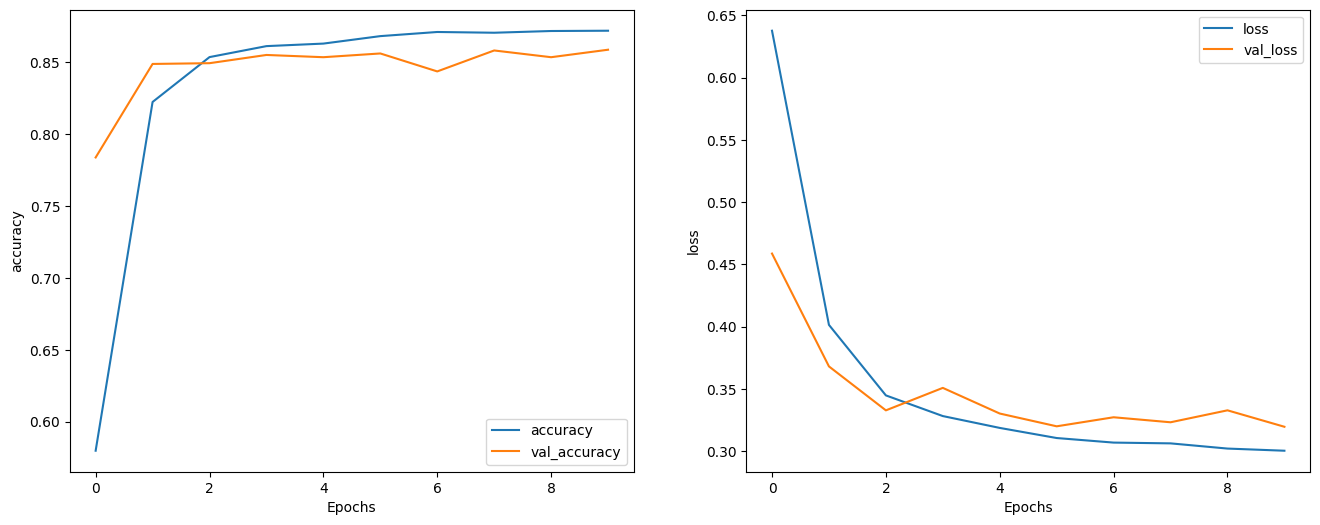

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
